# Delay Tolerant Networks

### Description

In several instances, network communications can occur with relevant delays, as for extra-terrestial communications or for supervised monitoring networks. In such network deciding which node can communicate with which other node and when is extremely complicated issue (a np-completed scheduling problem).

### Assignments

1. Generate a series of patterns of transmissions on a network represented as a graph. In such graph the edges are weighted accordingly to the delay between transmittion and reception.
2. Implement euristic algorithms to lower the potential of the network, i.e. aiming at minimizing the distance of the communications from their final destination.
3. Find out the most efficient algorithm

### Contacts
Leonardo Badia <badia@dei.unipd.it>

# Introduction to Delay Tolerant Networks

Delay Tolerant Networking (DTN) is a relatively new area of research which 
is rapidly becoming the focus of considerable effort. DTN is an approach
to computer architecture that seeks to address the technical issues in 
heterogeneus networks that may lack continuos network connectivity. The
final aim of this developing study area is to tackle problems which the 
Internet is not able to face.  

There's a great variety among the different DTNs: they range from deep 
space networks to buses driving around mobile wireless hotspots in 
villages to provide Internet service to kiosks. 

The big difference from the regular Internet Protocol (IP) is that IP
assumes a seamless end-to-end data path instead DTNs are built to account
for errors and disconnections. Unlike IP, where heterogeneus networks are 
connected by assigning each node a common network-layer identifier (IP address),
a DTN uses "naming, layering, encapsulation and persistent storage".

The situations in which we use DTNs are pretty challenging:

* The throughput is generally low (we can think for instance about the acoustic in underwater modems) and may 
be highly asymmetric or in the worse scenario a return channel might not 
exist

* These networks are frequently disconnected, not only by faults but due
to motion for instance

* These systems frequently operate with a low duty cycle and the queuing 
time can be very large; with these conditions TCP would time out the session
instead UDP would lose all the packets.

We decided to use 2 different approaches in order to face to routing problem with DTNs. The first one is a greedy
algorithm while the second is an epidemic algorithm. 

We decided to model the DTN as a wireless network where at each time step a link has a certain probability of being shut down for a ceratain amount of time. 

Before going into the details of the two different algorithms there are some assumptions that need to be pointed out:

* We are working with infinite buffers 

* There are no errors in transmission

* There's a maximum distance between two satellites beyond which they can't communicate

* We keep the same size for every packet and the same bandwidth for each link

* This is a centralized system, in the sense that Earth knows all the topology of the network

The simulated network is a satellitar network where the node need to send data to the main station on earth, for the sake of semplicity all of them have a direct link to the the destination. This is not an oversemplification because since links often shut down the overall behaviour is similar to the one we would have in case of indirect communications.

We repeated the tests done below also for the latter case but they were not kept. This is due to the fact that since some satellites are too far to directly communicate with the base station it is necessary to increase the number of nodes in order to have a meaningful configuration.
Increasing the total number of nodes is prohibitive because both the algorithm are superlinear in the number of nodes, meaning that it takes too much time to execute them in this particular case.
In most cases the results were very similar to the one obtained by the simulation, if not it will be specified below.

In [2]:
#used to import the utility functions
import sys
sys.path.insert(1, "utility_functions/")

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import math
import pylab as pl
from matplotlib import collections  as mc
import mpl_toolkits.mplot3d.axes3d as p3
from network_utilities import generate_network, plot_network, disable_links, adjacency_matrix
from greedy_routing import greedy_routing
from graphics import pkt_plot
from metrics import throughput, delay, deviations
import pandas as pd
from epidemics import epidemic, remove_duplicates
from tqdm.notebook import tqdm
import copy

#MAIN PARAMETERS
################################################
n = 10                                         #
c = 3e8                                        #
T_tx = 10  # da regolare                       #
r_max = 60e9  # Marte                          #
tau_max = 200                                  #
delta_time = 10                                #
n_configurations = 10                          #
################################################

In [3]:
nodes = generate_network(n,r_max,seed=17363720)
A = adjacency_matrix(nodes,tau_max)
sorted_nodes = np.argsort(A[0,:])     #sorting based on distance from Earth
A = A[sorted_nodes,:][:,sorted_nodes]
nodes = nodes[sorted_nodes]

<IPython.core.display.Javascript object>


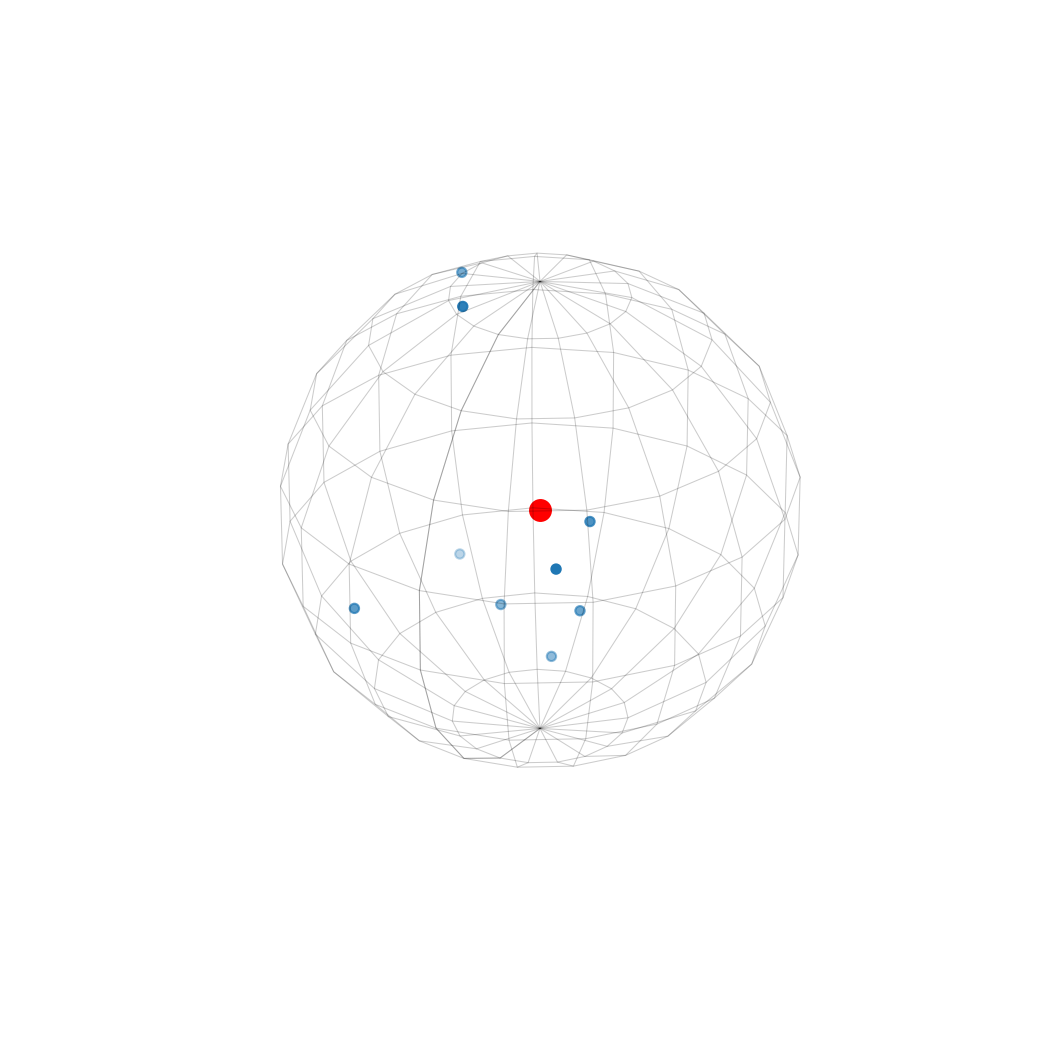

In [4]:
%matplotlib notebook

fig,ax = plot_network(nodes,sphere=True,r_max=r_max)
rotation = True

def rotate(num,ax,rotation):
        ax.azim = 0.5*num*rotatdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABBoAAAQaCAYAAADt3BtfAAAgAElEQVR4Xuy9W8wl1ZmmGUlyBhtzsDmVARvbnCETczYGAYUpG1zVrq7urr7pHo1m7rulbqnnaq7maqQZtVSjUl2MVKUZdUutUlW5C3Bhi7TLZcCQlUAmpzTGGBsb0mWMzcGcMhNGT9hfziKI2LEiYsX+9///T0hbOzN3xIoVz1oRGe+7vvWtLe+99957lZsEJCABCUhAAhKQgAQkIAEJSEACEihAYItGQwGKFiEBCUhAAhKQgAQkIAEJSEACEpBATUCjwY4gAQlIQAISkIAEJCABCUhAAhKQQDECGg3FUFqQBCQgAQlIQAISkIAEJCABCUhAAhoN9gEJSEACEpCABCQgAQlIQAISkIAEihHQaCiG0oIkIAEJSEACEpCABCQgAQlIQAIS0GiwD0hAAhKQgAQkIAEJSEACEpCABCRQjIBGQzGUFiQBCUhAAhKQgAQkIAEJSEACEpCARoN9QAISkIAEJCABCUhAAhKQgAQkIIFiBDQaiqG0IAlIQAISkIAEJCABCUhAAhKQgAQ0GuwDEpCABCQgAQlIQAISkIAEJCABCRQjoNFQDKUFSUACEpCABCQgAQlIQAISkIAEJKDRYB+QgAQkIAEJSEACEpCABCQgAQlIoBgBjYZiKC1IAhKQgAQkIAEJSEACEpCABCQgAY0G+4AEJCABCUhAAhKQgAQkIAEJSEACxQhoNBRDaUESkIAEJCABCUhAAhKQgAQkIAEJaDTYByQgAQlIQAISkIAEJCABCUhAAhIoRkCjoRhKC5KABCQgAQlIQAISkIAEJCABCUhAo8E+IAEJSEACEpCABCQgAQlIQAISkEAxAhoNxVBakAQkIAEJSEACEpCABCQgAQlIQAIaDfYBCUhAAhKQgAQkIAEJSEACEpCABIoR0GgohtKCJCABCUhAAhKQgAQkIAEJSEACEtBosA9IQAISkIAEJCABCUhAAhKQgAQkUIyARkMxlBYkAQlIQAISkIAEJCABCUhAAhKQgEaDfUACEpCABCQgAQlIQAISkIAEJCCBYgQ0GoqhtCAJSEACEpCABCQgAQlIQAISkIAENBrsAxKQgAQkIAEJSEACEpCABCQgAQkUI6DRUAylBUlAAhKQgAQkIAEJSEACEpCABCSg0WAfkIAEJCABCUhAAhKQgAQkIAEJSKAYAY2GYigtSAISkIAEJCABCUhAAhKQgAQkIAGNBvuABCQgAQlIQAISkIAEJCABCUhAAsUIaDQUQ2lBEpCABCQgAQlIQAISkIAEJCABCWg02AckIAEJSEACEpCABCQgAQlIQAISKEZAo6EYSguSgAQkIAEJSEACEpCABCQgAQlIQKPBPiABCUhAAhKQgAQkIAEJSEACEpBAMQIaDcVQWpAEJCABCUhAAhKQgAQkIAEJSEACGg32AQlIQAISkIAEJCABCUhAAhKQgASKEdBoKIbSgiQgAQlIQAISkIAEJCABCUhAAhLQaLAPSEACEpCABCQgAQlIQAISkIAEJFCMgEZDMZQWJAEJSEACEpCABCQgAQlIQAISkIBGg31AAhKQgAQkIAEJSEACEpCABCQggWIENBqKobQgCUhAAhKQgAQkIAEJSEACEpCABDQa7AMSkIAEJCABCUhAAhKQgAQkIAEJFCOg0VAMpQVJQAISkIAEJCABCUhAAhKQgAQkoNFgH5CABCQgAQlIQAISkIAEJCABCUigGAGNhmIoLUgCEpCABCQgAQlIQAISkIAEJCABjQb7gAQkIAEJSEACEpCABCQgAQlIQALFCGg0FENpQRKQgAQkIAEJSEACEpCABCQgAQloNNgHJCABCUhAAhKQgAQkIAEJSEACEihGQKOhGEoLkoAEJCABCUhAAhKQgAQkIAEJSECjwT4gAQlIQAISkIAEJCABCUhAAhKQQDECGg3FUFqQBCQgAQlIQAISkIAEJCABCUhAAhoN9gEJSEACEpCABCQgAQlIQAISkIAEihHQaCiG0oIkIAEJSEACEpCABCQgAQlIQAIS0GiwD0hAAhKQgAQkIAEJSEACEpCABCRQjIBGQzGUFiQBCUhAAhKQgAQkIAEJSEACEpCARoN9QAISkIAEJCABCUhAAhKQgAQkIIFiBDQaiqG0IAlIQAISkIAEJCABCUhAAhKQgAQ0GuwDEpCABCQgAQlIQAISkIAEJCABCRQjoNFQDKUFSUACEpCABCQgAQlIQAISkIAEJKDRYB+QgAQkIAEJSEACEpCABCQgAQlIoBgBjYZiKC1IAhKQgAQkIAEJSEACEpCABCQgAY0G+4AEJCABCUhAAhKQgAQkIAEJSEACxQhoNBRDaUESkIAEJCABCUhAAhKQgAQkIAEJaDTYByQgAQlIQAISkIAEJCABCUhAAhIoRkCjoRhKC5KABCQgAQlIQAISkIAEJCABCUhAo8E+IAEJSEACEpCABCQgAQlIQAISkEAxAhoNxVBakAQkIAEJSEACEpCABCQgAQlIQAIaDfYBCUhAAhKQgAQkIAEJSEACEpCABIoR0GgohtKCJCABCUhAAhKQgAQkIAEJSEACEtBosA9IQAISkIAEJCABCUhAAhKQgAQkUIyARkMxlBYkAQlIQAISkIAEJCABCUhAAhKQgEaDfUACEpCABCQgAQlIQAISkIAEJCCBYgQ0GoqhtCAJSEACEpCABCQgAQlIQAISkIAENBrsAxKQgAQkIAEJSEACEpCABCQgAQkUI6DRUAylBUlAAhKQgAQkIAEJSEACEpCABCSg0WAfkIAEJCABCUhAAhKQgAQkIAEJSKAYAY2GYigtSAISkIAEJCABCUhAAhKQgAQkIAGNBvuABCQgAQlIQAISkIAEJCABCUhAAsUIaDQUQ2lBEpCABCQgAQlIQAISkIAEJCABCWg02AckIAEJSEACEpCABCQgAQlIQAISKEZAo6EYSguSgAQkIAEJSEACEpCABCQgAQlIQKPBPiABCUhAAhKQgAQkIAEJSEACEpBAMQIaDcVQWpAEJCABCUhAAhKQgAQkIAEJSEACGg32AQlIQAISkIAEJCABCUhAAhKQgASKEdBoKIbSgiQgAQlIQAISkIAEJCABCUhAAhLQaLAPSEACEpCABCQgAQlIQAISkIAEJFCMgEZDMZQWJAEJSEACEpCABCQgAQlIQAISkIBGg31AAhKQgAQkIAEJSEACEpCABCQggWIENBqKobQgCUhAAhKQgAQkIAEJSEACEpCABDQa7AMSkIAEJCABCUhAAhKQgAQkIAEJFCOg0VAMpQVJQAISkIAEJCABCUhAAhKQgAQkoNFgH5CABCQgAQlIQAISkIAEJCABCUigGAGNhmIoLUgCEpCABCQgAQlIQAISkIAEJCABjQb7gAQkIAEJSEACEpCABCQgAQlIQALFCGg0FENpQRKQgAQkIAEJSEACEpCABCQgAQloNNgHJCABCUhAAhKQgAQkIAEJSEACEihGQKOhGEoLkoAEJCABCUhAAhKQgAQkIAEJSECjwT4gAQlIQAISkIAEJCABCUhAAhKQQDECGg3FUFqQBCQgAQlIQAISkIAEJCABCUhAAhoN9gEJSEACEpCABCQgAQlIQAISkIAEihHQaCiG0oIkIAEJSEACEpCABCQgAQlIQAIS0GiwD0hAAhKQgAQkIAEJSEACEpCABCRQjIBGQzGUFiQBCUhAAhKQgAQkIAEJSEACEpCARoN9QAISkIAEJCABCUhAAhKQgAQkIIFiBDQaiqG0IAlIQAISkIAEJCABCUhAAhKQgAQ0GuwDEpCABCQgAQlIQAISkIAEJCABCRQjoNFQDKUFSUACEpCABCQgAQlIQAISkIAEJKDRYB+QgAQkIAEJSEACEpCABCQgAQlIoBgBjYZiKC1IAhKQgAQkIAEJSEACEpCABCQgAY0G+4AEJCABCUhAAhKQgAQkIAEJSEACxQhoNBRDaUESkIAEJCABCUhAAhKQgAQkIAEJaDTYByQgAQlIQAISkIAEJCABCUhAAhIoRkCjoRhKC5KABCQgAQlIQAISkIAEJCABCUhAo8E+IAEJSEACEpCABCQgAQlIQAISkEAxAhoNxVBakAQkIAEJSEACEpCABCQgAQlIQAIaDfYBCUhAAhKQgAQkIAEJSEACEpCABIoR0GgohtKCJCABCUhAAhKQgAQkIAEJSEACEtBosA9IQAISkIAEJCABCUhAAhKQgAQkUIyARkMxlBYkAQlIQAISkIAEJCABCUhAAhKQgEaDfUACEpCABCQgAQlIQAISkIAEJCCBYgQ0GoqhtCAJSEACEpCABCQgAQlIQAISkIAENBrsAxKQgAQkIAEJSEACEpCABCQgAQkUI6DRUAylBUlAAhKQgAQkIAEJSEACEpCABCSg0WAfkIAEJCABCUhAAhKQgAQkIAEJSKAYAY2GYigtSAISkIAEJCABCUhAAhKQgAQkIAGNBvuABCQgAQlIQAISkIAEJCABCUhAAsUIaDQUQ2lBEpCABCQgAQlIQAISkIAEJCABCWg02AckIAEJSEACEpCABCQgAQlIQAISKEZAo6EYSguSgAQkIAEJSEACEpCABCQgAQlIQKPBPiABCUhAAhKQgAQkIAEJSEACEpBAMQIaDcVQWpAEJCABCUhAAhKQgAQkIAEJSEACGg32AQlIQAISkIAEJCABCUhAAhKQgASKEdBoKIbSgiQgAQlIQAISkIAEJCABCUhAAhLQaLAPSEACEpCABCQgAQlIQAISkIAEJFCMgEZDMZQWJAEJSEACEpCABCQgAQlIQAISkIBGg31AAhKQgAQkIAEJSEACEpCABCQggWIENBqKobQgCUhAAhKQgAQkIAEJSEACEpCABDQa7AMSkIAEJCABCUhAAhKQgAQkIAEJFCOg0VAMpQVJQAISkIAEJCABCUhAAhKQgAQkoNFgH5CABCQgAQlIQAISkIAEJCABCUigGAGNhmIoLUgCEpCABCQgAQlIQAISkIAEJCABjQb7gAQkIAEJSEACEpCABCQgAQlIQALFCGg0FENpQRKQgAQkIAEJSEACEpCABCQgAQloNNgHJCABCUhAAhKQgAQkIAEJSEACEihGQKOhGEoLkoAEJCABCUhAAhKQgAQkIAEJSECjwT4gAQlIQAISkIAEJCABCUhAAhKQQDECGg3FUFqQBCQgAQlIQAISkIAEJCABCUhAAhoN9gEJSEACEpCABCQgAQlIQAISkIAEihHQaCiG0oIkIAEJSEACEpCABCQgAQlIQAIS0GiwD0hAAhKQgAQkIAEJSEACEpCABCRQjIBGQzGUFiQBCUhAAhKQgAQkIAEJSEACEpCARoN9QAISkIAEJCABCUhAAhKQgAQkIIFiBDQaiqG0IAlIQAISkIAEJCABCUhAAhKQgAQ0GuwDEpCABCQgAQlIQAISkIAEJCABCRQjoNFQDKUFSUACEpCABCQgAQlIQAISkIAEJKDRYB+QgAQkIAEJSEACEpCABCQgAQlIoBgBjYZiKC1IAhKQgAQkIAEJSEACEpCABCQgAY0G+4AEJCABCUhAAhKQgAQkIAEJSEACxQhoNBRDaUESkIAEJCABCUhAAhKQgAQkIAEJaDTYByQgAQlIQAISkIAEJCABCUhAAhIoRkCjoRhKC5KABCQgAQlIQAISkIAEJCABCUhAo8E+IAEJSEACEpCABCQgAQlIQAISkEAxAhoNxVBakAQkIAEJSEACEpCABCQgAQlIQAIaDfYBCUhAAhKQgAQkIAEJSEACEpCABIoR0GgohtKCJCABCUhAAhKQgAQkIAEJSEACEtBosA9IQAISkIAEJCABCUhAAhKQgAQkUIyARkMxlBYkAQlIQAISkIAEJCABCUhAAhKQgEaDfUACEpCABCQgAQlIQAISkIAEJCCBYgQ0GoqhtCAJSEACEpCABCQgAQlIQAISkIAENBrsAxKQgAQkIAEJSEACEpCABCQgAQkUI6DRUAylBUlAAhKQgAQkIAEJSEACEpCABCSg0WAfkIAEJCABCUhAAhKQgAQkIAEJSKAYAY2GYigtSAISkIAEJCABCUhAAhKQgAQkIAGNBvuABCQgAQlIQAISkIAEJCABCUhAAsUIaDQUQ2lBEpCABCQgAQlIQAISkIAEJCABCWg02AckIAEJSEACEpCABCQgAQlIQAISKEZAo6EYSguSgAQkIAEJSEACEpCABCQgAQlIQKPBPiABCUhAAhKQgAQkIAEJSEACEpBAMQIaDcVQWpAEJCABCUhAAhKQgAQkIAEJSEACGg32AQlIQAISkIAEJCABCUhAAhKQgASKEdBoKIbSgiQgAQlIQAISkIAEJCABCUhAAhLQaLAPSEACEpCABCQgAQlIQAISkIAEJFCMgEZDMZQWJAEJSEACEpCABCQgAQlIQAISkIBGg31AAhKQgAQkIAEJSEACEpCABCQggWIENBqKobQgCUhAAhKQgAQkIAEJSEACEpCABDQa7AMSkIAEJCABCUhAAhKQgAQkIAEJFCOg0VAMpQVJQAISkIAEJCABCUhAAhKQgAQkoNFgH5CABCQgAQlIQAISkIAEJCABCUigGAGNhmIoLUgCEpCABCQgAQlIQAISkIAEJCABjQb7gAQkIAEJSEACEpCABCQgAQlIQALFCGg0FENpQRKQgAQkIAEJSEACEpCABCQgAQloNNgHJCABCUhAAhKQgAQkIAEJSEACEihGQKOhGEoLkoAEJCABCUhAAhKQgAQkIAEJSECjwT4gAQlIQAISkIAEJCABCUhAAhKQQDECGg3FUFqQBCQgAQlIQAISkIAEJCABCUhAAhoN9gEJSEACEpCABCQgAQlIQAISkIAEihHQaCiG0oIkIAEJSEACEpCABCQgAQlIQAIS0GiwD0hAAhKQgAQkIAEJSEACEpCABCRQjIBGQzGUFiQBCUhAAhKQgAQkIAEJSEACEpCARoN9QAISkIAEJCABCUhAAhKQgAQkIIFiBDQaiqG0IAlIQAISkIAEJCABCUhAAhKQgAQ0GuwDEpCABCQgAQlIQAISkIAEJCABCRQjoNFQDKUFSUACEpCABCQgAQlIQAISkIAEJKDRYB+QgAQkIAEJSEACEpCABCQgAQlIoBgBjYZiKC1IAhKQgAQkIAEJSEACEpCABCQgAY0G+4AEJCABCUhAAhKQgAQkIAEJSEACxQhoNBRDaUESkIAEJCABCUhAAhKQgAQkIAEJaDTYByQgAQlIQAISkIAEJCABCUhAAhIoRkCjoRhKC5KABCQgAQlIQAISkIAEJCABCUhAo8E+IAEJSEACEpCABCQgAQlIQAISkEAxAhoNxVBakAQkIAEJSEACEpCABCQgAQlIQAIaDfYBCUhAAhKQgAQkIAEJSEACEpCABIoR0GgohtKCJCABCUhAAhKQgAQkIAEJSEACEtBosA9IQAISkIAEJCABCUhAAhKQgAQkUIyARkMxlBYkAQlIQAISkIAEJCABCUhAAhKQgEaDfUACEpCABCQgAQlIQAISkIAEJCCBYgQ0GoqhtCAJSEACEpCABCQgAQlIQAISkIAENBrsAxKQgAQkIAEJSEACEpCABCQgAQkUI6DRUAylBUlAAhKQgAQkIAEJSEACEpCABCSg0WAfkIAEJCABCUhAAhKQgAQkIAEJSKAYAY2GYigtSAISkIAEJCABCUhAAhKQgAQkIAGNBvuABCQgAQlIQAISkIAEJCABCUhAAsUIaDQUQ2lBEpCABCQgAQlIQAISkIAEJCABCWg02AckIAEJSEACEpCABCQgAQlIQAISKEZAo6EYSguSgAQkIAEJSEACEpCABCQgAQlIQKPBPiABCUhAAhKQgAQkIAEJSEACEpBAMQIaDcVQWpAEJCABCUhAAhKQgAQkIAEJSEACGg32AQlIQAISkIAEJCABCUhAAhKQgASKEdBoKIbSgiQgAQlIQAISkIAEJCABCUhAAhLQaLAPSEACEpCABCQgAQlIQAISkIAEJFCMgEZDMZQWJAEJSEACEpCABCQgAQlIQAISkIBGg31AAhKQgAQkIAEJSEACEpCABCQggWIENBqKobQgCUhAAhKQgAQkIAEJSEACEpCABDQa7AMSkIAEJCABCUhAAhKQgAQkIAEJFCOg0VAMpQVJQAISkIAEJCABCUhAAhKQgAQkoNFgH5CABCQgAQlIQAISkIAEJCABCUigGAGNhmIoLUgCEpCABCQgAQlIQAISkIAEJCABjQb7gAQkIAEJSEACEpCABCQgAQlIQALFCGg0FENpQRKQgAQkIAEJSEACEpCABCQgAQloNNgHJCABCUhAAhKQgAQkIAEJSEACEihGQKOhGEoLkoAEJCABCUhAAhKQgAQkIAEJSECjwT4gAQlIQAISkIAEJCABCUhAAhKQQDECGg3FUFqQBCQgAQlIQAISkIAEJCABCUhAAhoN9gEJSEACEpCABCQgAQlIQAISkIAEihHQaCiG0oIkIAEJSEACEpCABCQgAQlIQAIS0GiwD0hAAhKQgAQkIAEJSEACEpCABCRQjIBGQzGUFiQBCUhAAhKQgAQkIAEJSEACEpCARoN9QAISkIAEJCABCUhAAhKQgAQkIIFiBDQaiqG0IAlIQAISkIAEJCABCUhAAhKQgAQ0GuwDEpCABCQgAQlIQAISkIAEJCABCRQjoNFQDKUFSUACEpCABCQgAQlIQAISkIAEJKDRYB+QgAQkIAEJSGASgXfffbfav39//fnVr35VHX/88dVhhx1Wbd269QPfW7ZsmXQuD5aABCQgAQlIYPUJaDSsfhtZQwlIQAISkMCaEThw4EBtILzzzjuHzIT4c3yzDwbCL37xi+r111+vzjnnnOqYY46pMCAOHjx46Pu9996r9+syIdr+PWdfzYs16x6eWAISkIAEJNBKQKPBjiEBCUhAAhLYhAQQ/RGF0DQOUlOB/Y444ojqyCOPfN93+m8YDc8991xtLrD/hz70oepjH/vYB6jyW9N8yPn7on0o89e//nVtcpxwwgnVKaecUn30ox+tv6mjmwQkIAEJSEACyyeg0bB85p5RAhKQgAQkMDsBTISXX365Ovzww98XkZCaCExtaDMRUlOB4xdt//RP/1S98MIL1ZlnnlkLfP7+xhtv1FENy9heffXV6umnn65OP/30OpripZdeqk2H1157rfrwhz9cnXzyybXpgPGBEWH0wzJaxXNIQAISkMBmJ6DRsNl7gNcvAQlIQALrngDTExD3v/zlL6uf/exn1c9//vM6V8LRRx9dfeQjH6k++clP1n9umgpMS+jaciIeEPT79u2rzjrrrOrYY4+tczK8+eabtdnwmc98ZtAUiWY+h5xG4VyYDGeffXZ9nemG0QIHjAc+mC5wOvHEE99nPhCF4SYBCUhAAhKQQFkCGg1leVqaBCQgAQlIYFYCTCPAVODDqH2M4DN9gegDogpOPfXU6rTTTqv//uMf/7je7xOf+ESdpJENwZ3mXWjLv8DviP+IbmiLfAjxTjRD5GLguEcffbS65JJL6mkSOVMj0jwO7M/Wl5uB6/3hD39YRzIQrdCX34HfiXjABAlmGDMYDUQ98IEd31y3mwQkIAEJSEAC4wloNIxn55ESkIAEJCCBWQkguhm1x1QgDwHfTBVAzCPO+TAdAGOBkXqiCtpMBEb2f/SjH9X7Mp2gK+9C01RYFPHAhT///PN1lASmRro99thj1ac+9alaxI/Z+swJjBEiGbgWpkUs2j/MjrYklHDAhMFwgCtRILAlOgLDgUiN3/md36kNGqdcjGlJj5GABCQggc1KQKNhs7a81y0BCUhAAitFANHbNBX4O+I/lo9866236j9jKCDimQ7BlkYkIIjbohAo/yc/+Ul9zKc//el6n6nbs88+W5sXiPJ0+8EPfnBIrE89R/N4rh+TAQYYATnbkCSUmDkYM0xBYWpILNV50kknHZpygbkR7HPO7z4SkIAEJCCBzUZAo2GztbjXKwEJSEACa04A4YtpkEYpMKKOSUCEAL+//fbb9e+E+/PvGAuIekbbMQm6VoFYFPZPuT/96U9rAU2yRsqbsn3ve9+rpy4QWZBuJIcksuLjH//4lOI/cCz1f+aZZ+qpDUwFmTPKgHMRmUF+C6ZpMOUCY4XVNZh6gdlAHcgPwZQLIkr6IkCKwrAwCUhAAhKQwAoT0GhY4caxahKQgAQksDEIYBog8F955ZX6g3nAyDymAuKU0XHyKSBoiWJAQEf4PiPpjKqzbylhjamBYEYcMzVgbLmPP/54de65535gigRTECIhZMkWJCcDUxuIyBhb5yH1wTCBFct1Yi4cddRRtamA6UPUBqYHUy8wJTB+aDMMiFhiM3JiDDmn+0pAAhKQgAQ2AgGNho3Qil6DBCQgAQmsFAGEJ2YCpgJClYSM/BsCFNFKJAHGAmH6RDbwjYglMoDflpETAMGO2YC5wcj8mKkAjzzySHXxxRfXJki6MZXjySefrLZt21asXZj2gahnNYu5kzXSVrTdiy++WO3evbu64oorqjPOOKOerpFu7IepwjQL9sc0wkDi38j7QBtjFKXmQ5NVMUAWJAEJSEACElghAhoNK9QYVkUCEpCABNYvAcQ1pgKCE0GMoMQ0wEBAJJMckX2Y/89oOAYDSRRZsYHpB+y3FhvLU/JhmkMz18Ki+jA1AhF++eWXt+7GyhMXXnhhkVwQ1I+IgvPOO+8DpkZJZpgvsRwmZgbRC7QpEQwYDYs2prlgOLA/5gLHEp0SS2wyXYV+gdEEZ8wHVssgCmIZ0RklOVmWBCQgAQlIoI+ARkMfIX+XgAQkIAEJtBCIqIUwF5geQURCRCUgxIlq2LNnTy0kEZiIUSIImPePGEV4YkzE6hGxKsTcI/bNy6Fe5B8gkoIEiznnxyghKeOll17a2j/4LYT0lA6EQGfaCSbDXGYMbYghwDfCH5Mgpj0QbfL973+/Xq4zJwcDZlIsoUkZMIgcFhgZYTxgaBD1QH9gCkuYDxWZFWsAACAASURBVJy7GTkxhZ/HSkACEpCABNaCgEbDWlD3nBKQgAQksC4JIBQjz0IatYCJgDhHsPPvGAyIUgwEwugR74hYRrGJXiCkPt0Q7ZTLvgjb44477lDix7nEdbMBqCtLYHJ+jJA+sct1EqlxwQUXtLYlS19ynVzv2A0mTO8gJ0NffYaeA4GPiYHwZ0PgI/abbcNvJL0MIyD3PPCkfEwH+gKGA+ZS06ygz1CHMCDoA+R7iPNFvocc8ye3bu4nAQlIQAISmJuARsPchC1fAhKQgATWLYG2qAVMhTAWGL3GVEAsMlWCEWx+4xvBet9999XfiEySLubkQUAAR5QEQjumYCwrdwMj7RgIGASnnnpqZ9u9/PLLFR+mhLRtiGxEM8kix2xwJdkix8O01Ea5iHrqRqQBBkNz1YzmuYg8IF8DU0GGbpHvgWkVGEr0Bc7ZZmhQNjke4EodYciHOscyomE8EHnhJgEJSEACElhVAhoNq9oy1ksCEpCABNaEQEQt/ORnL1VP/+Tn1ZatW6szTzmxOvPEY+vR6FiSEtMgTIVYFSIqzGj/rl276iUqr7vuutFCOU0qielA3RCcMcWiS6xOBYcgZioFI+ssg9l2nhDOLO/YthEZQS4KphwM3chtwNQLIkGYVjB1I7ogxDtGDkIfwZ6bmJF2YIUNWEwxPWACN0wOohswHcj/0Lel0zHCfKBOzUSTOUZW37n8XQISkIAEJFCCgEZDCYqWIQEJSEAC65YAgg3zIKZE/NOvXq+++9wr1Q9+/lb12v6D1cH971RHbjlYnX3qidUXLjun2n7u6XXEQlsoOwKdaABGwCnz2muvLZpXAOMiplhQPtMJMB0Y3S4tMhlZ51oQxaxK0RTY/Ibx0pUkEa6sSnHZZZdl5XyIDoSo3rt3bx1RgSEwZUPYE6GBycB0FMqD15jkixgERBaMjdBIryOSghK1QL0wHKjXkA0zK000SZ/DtGDKBZ8wU3LySgw5r/tKQAISkIAEcghoNORQch8JSEACEthQBCJqgSkKfBDVGAe/enN/9d8e/FH1o5d/Xf3yna3VsccdWx15zHHVW+8dUX3kuKOqT5xyXPWvr/p49dmzT3ofD0bJCa1ntBnRiAgkHH9KfoI+4IzSp1MsqH9EO2AKjBHTbefEaCB3AxEAmApR7g9/+MPacFlkBrDEJatZ5EYBwJF8CIzUj2VHWyK6EeEYM7G05NRcF/B+7LHH6pwUU8sKztSVHA4sf0qfpO8QxTGm/IjaoLyIesBoISKEci+66KKs6Im+fufvEpCABCQggRwCGg05lNxHAhKQgATWNYE0agHhTFQAI718EM5MEUA0/+Wel6qHX3izev3AYdWnPvah6pgjt9bXfeDgu9Xzv3yz+vXbB6qLzzyh+l++eEF1wrFHVJSLsMNkIKqApSqJNGC0n/n8yxpNph6Iyri2WAGDOmE+TJ1iwQg8xgIb0Q3wyllVgkSORF0gdPs2RDdlsj9ie+hGNEnkNWBkHwMEkV3KcKE+GAK0Kfk2hmy0DwypY/ODQYCxwO8vvPBCPZ2DfhSrl9Avx/YjzkX/ZAoL5RONQd6NXONnyDW6rwQkIAEJSCAloNFgf5CABCQggQ1JgBFiRvwZ3Sbsnb+HsZCKOIQc0w5+8ss3qv/zG09Xu3/ySnXpmSdURx5+2Pu4IBb37nutOuX4o6p/deXHqyvPOKpedhHRjfBEICOWn3jiiVooDw2FL9kIiMp0dQyEd0Q7jF29gevHUEHMc32IYnIWEPrftSFyMUDYb9FG2Yhh2gcjI9cc4DjMFerEeWKlhpy8B2N4I9yZ1kHeibapM5gGmDxthgL708+aH/pPXC/thtkCB/ookTGUhTEQfXZMtAN9n37JuagjdcFwIHIkl/UYXh4jAQlIQAKbl4BGw+Zte69cAhKQwIYiEFELzMfft29fbTAgohBthM8jqjAV+CC4mtuOvT+r/p8HflS9+taB6tMfO76VzUuvv13t+8Ur1baTDlZ/fMWZtcGQZv9HfCN4u1ZiWAvgmB/pFAuYpFMsho6WI36JbsBkuemmmxbmhuhbAjN4UB5imGUsc4QvgpzcC3yIACB6oW3pyDl4f//736+nICD8m4YCUz/oW22GQm5UCUYAq21gBrDMaDpFhnaknDAdMCBy249+iYlBVAP1xATCFIHdolUw5mBomRKQgAQksPEJaDRs/Db2CiUgAQlsWAKIU+ajM9JO1ALCCeFJqD4fBFksNdkH4e8ef7H6Lw/+uNp/8L3q7JOP/cDu+99+s3rhpy9UP33pl9XNnz2/+l//xbXvE8Wc+6mnnio6h7+vzmN+T6dYxGh5TLHIXYUBoX/33XfXxgBiuCuCAEG7Z8+eavv27Z0GAtNMMCQ+85nPLEwaiZGE0CZ6gf0xFhDIYyM0+thh0LRFJ2Bu0NcuvvjiDxgKRBvkGCU552baCeeHcZgUMUWGaBVYsDoH/TuMh76EoJFv4/zzz6+nazDNB8Nh6CoYffX3dwlIQAISkIBGg31AAhKQgATWDQGEFhELGAsRtcAIMqbCaaedVkcuEMqfO8qbXvj9P3ip+vP7nqtefOXN6qIzfrMCwIH971Rvvf5q9carL1e/+Mmz1evvHlFtOerD1efOP636V1d/ohaAiHM+zz//fB3iTvJD/h6/lRCeczVQJMUM4YpQjWiHRVMiEMCxMgRRHOQU6EoKSQJFIjzazAgEO8bBeeed17nUJHWM6AXalfMwRaJt6sIYTpTfNtWBf6cd26ITiAwgmmXu6TH0KdoGs6FtygRGTkSr8A2fWPoU86HtPuC+wZzDbAiGJVbBGMPeYyQgAQlIYOMS0GjYuG3rlUlAAhLYMAQQtrt27aqTLCKemF+OscCHEd0SYp5Ej//bXU9VO595sTr16IPV0e++VR08sL866pjjqjde+2V11Ic/Wv347aOrc085rvo31/xOdfHpx9ch6BFVQaLACHXn3/gt5sOnxkP65zAj4nuMQVKqkRnBJ1Igcjtg6oTp0BStjISzEgUJL4mQePbZZ+vIgrPPPvsDBgC5F4iYwBxIN8Qu0y8wGdpEdCzfSH04HoOBth6zcS1duRP4rc1MoE5d7YE5QhQABsDcG2YM5gBmzSLzJ6Idwngg2oH9w3hIjR6mqtA3mUaR3jv0AdqFc/LvGHi021r2y7n5Wr4EJCABCcxDQKNhHq6WKgEJSEACBQgghhBZu3fvroXstm3b3pcTocAp6pUjEM7kdPjrB5+uvvP0z6sX3zysOuNjJ1ennnJi9frPX6hee2t/9fqRJ1cnHXdkte2sj1T/7nc/Ux2x9TfJIiMBJJEMab6G+C3MiK7vMCX4HUGXa0qUGtHvYohQReQjqCNEH9HKNWIuILZDaMMAowVzALMlFcREPNCO8ImNcpkawPHp1AcYELFC2bRLLE2Zm9+A45vRCRgMfCijKxnj0H7E9TIlBJNkrsSTaZ1gAl8SZeZGUUS0QxgPkWCS42kfDCCMm64VNGgjDAfannbAdMidWjOUp/tLQAISkMDGI6DRsPHa1CuSgAQksO4JIDIJl0ekYgIgRrsy/Y+52Jjvj4jmg2hHQH/owydU//3Jl6t/fO7lat8rb1X79r1Yvf3r16pTP/7J6tQTjqk++dHjq//585+oTj7+qEOnjTpOHd2mTkNMCSqQa0rkCvUultQrIh0Qrq+//not3MlTgGiNUfEQxESaEHXCv8OXPADkYGDjWJIdMpoeyyzSxpgLmD1ETxC9wHfb1rdUZJgJRCSkxkJpY4boGgwUojiWsWHiEDnCNBWE/9ANcyimyPBnphzRLkRKpCZQs1yMBgwH2oZ7hHadKy/G0GtyfwlIQAISWF0CGg2r2zbWTAISkMCmJIAYQsQhDBFDiKJFc/hzIUX2fgQTYhkhinDik45KI2SfeOHV6t5Hf1jt+d4z1clnfqL66EeOq676xMnVVeecVB1z5NZDp4wEkMx370vEl1vP3P1yTQkiJtgwBtKcEs1pG+nfF01FgQ85CmAIN7hiCsCRb+qFIKb9GIFn9J8kmUSjEG3wve9979DynxG9QB0jeiFWBKHciE5oTnvIWSoyl+PY/chrwJKRGGBTjZzcOiD6WfUCVmeccUbuYR/YL+4FooXIocFypaeffnrdfnzaTBnaCDOID30dw4HoiBLTlkZfiAdKQAISkMDKEtBoWNmmsWISkIAENhcBDAUMBkQl4dyIIaIFuubw59BB9EbUAiPCjMSGudCWFyDKRNAhiBl1X5QDgvBzRBejzKu8wTKmaLR9p/+GMdBnStAuRCMgdhHcMcWCNiTCAbFKlALRC+ecc069HCYj53xH6D8mQ+QQoC2aZkKJpSLnbpPITUEEx7I2eGM20C8xCKYKfe6PSOyJsUMbcp/EShbN6AX6B21HNAR/jjwOpSNGlsXT80hAAhKQwDwENBrm4WqpEpCABCSQSQDhhHBF8DCqStg8o+UkGyTcfugceMoLcwGxiyAOcyFn5BmBywg8dVkUoo64Zt78RRddtKGS5SEe+0wJBDYmAR8EZrrCBmIVowb2GBwIV/7OPkQrYMzQpghloiMQyvy9mT+h1FKRmd1w1G4YKZgnTCGZKviHVACuTD+BPTkxpiZrTFeioB5pUlD+HpEOfKf3EPcphgMcIo9DRKQMuR73lYAEJCCBjUdAo2HjtalXJAEJSGBdEEDQInAQKmS2R9gjYhA5RAowAp67ygDilikRGAz8OZIW8j1kpDWmBTCKu2jeOnV/8skn60iGE088cV3wnlpJrjlW0mDKAKP4mAHwjmiESLyI8KQtMJAYLd+xY0edT+KWW26p2xUzCQOID6xDKCPWQ7Cn333/NvV32DTPnVsm0QWM6tMPco/pura+49N60h6YcRhrGHJTEzV2rUSBSRQJJTGPMIViJYtI+kkf4D5mxQp+g0fuvTu1X3q8BCQgAQmsJgGNhtVsF2slAQlIYMMSQMwjSBChCBXEeuQ3QMgg3HKy67NvRC4ggCNqAfE6doQX4YZYJrHjohHqF198sTZEIsHhemksxCmj4XzCNMj9pt0ieoHRdBghOmGN2OWTRjMQFUHUB0tY0laYC+xP+9DufDP6jUDmO03eGH+OduTcfNiaf879t/T4tmP6fu86BoOL/sw0m7WoJ32RNty+fXsdVTA2USN9g9wbi1aioN/Q78N44JiYYhHJO0niiulAmzYNmPVyn1hPCUhAAhKYTkCjYTpDS5CABCQggUwCCBTyMCDiycMQqw5weCQKJJLgpJNO+kCJiDhGyiNygTLCXFiURyGzarU44kNix0VTLBDURDOsRQLIELttRkGOeYAwRLxzfWEa5H5zHMwxYu6///46ZJ/RbqZGYAwgLPktpknQnrB6/vnn6zwNCOCIiqAtw2Cg3hgQfKhXmgCSfWJKRTq9ImcKTG67T92PayGhIkZDuqzn1HJzj4ffzp076+SMmACwwXDgHhrKCXMo8jXkrGxBW8VKFtybtFFMs6AvcD9hgmAy8RkSXZR7/e4nAQlIQAKrSUCjYTXbxVpJQAIS2FAEEJ8YDAgTEggyVSLdEKQkX0QsMQoaG8IUcyIiFxCehKhjMIwduW0DG9M1cswDpnUgrDFKpmw5xkCXoYDgH2MWIPSG5BKAP0YCEQmR3BEBSTTKlVdeWQtr9sH8QXDSLhgS/J0Q+ocffrjOX0AZTLXgGzEbZgfcEcT8nTZGlNK+fCg7TRBJHwoTgmtvMyCmTh8Y257woK5E4qzFRp9E4GMOcL8QVcA3bcC9xm+57U4bEdkwZOoS10w/iNwOnDtWI6Fto+1oa+7xRYlY14Kf55SABCQggfIENBrKM7VECUhAAhL4LQFEJSIM4YnA4NOc1oC4xGRAhJCnAYGCaI1lKBkljciFOZaQRCAyisuoe6yI0NWACKjnnnuuTgCJaE/zFuROQQjzAOGXRhPkRhaw39ipIX0dE8MnDAW+I1oB0U/USBgLTJ2grVjqEAaMVtNGtDXHILgffPDBWlCy/CP/TgQEuR0wHjiesmhzIh7YiGTh2mh3PqnpkEasEEHQZUDApc2AmDtBIf388ccfr69tLcwOVoHAXEin8sCPKR18+DOGA5+cewjTh2lEGG9jTQFMoZhiQbRDTLGBFf0F4ymNaOrrm/4uAQlIQALri4BGw/pqL2srAQlIYF0QQHz+7Gc/qz+MThPF0CbAEN2MniJmEB0IHEQJIpTjEP5zikTOzwoTnAfxs8gs4DcMCcQa9ePYNG9Bm1GwyDxY6zDytmgF/i1Wk4jvNPweE4HRcz6IapgxWs5INgYMHIn0gBNmwu23314LXUTn2WefXbc1/NiPP3MsOTrYh1wO9AGOp80ZBcdwQERTL4wM+sSiaTJdBgQ3TZsBMVZEt92EXD/1pq8ve6Mv7tmzp9PowDSCMSwx7mgDWC7qg+lKFFP7akQ7YDyEKYKpRT/AgMKAzI24WDZbzycBCUhAAuMIaDSM4+ZREpCABCTQQSBEI1MbEJFdy1MiJB955JF6BDzCuxGTiI+hc8uHNgbCjHoytx5j46yzzuqdisD+1PW88847tO/QqQhD61ly/5xoBcR4U/DF1AiiFxDyjExjGjHazW9EK8AGI4H2Y2T93nvvrW699dY6YgEBTl9gSgy/YR6QSJKR7YhkQZzTJiQ2ZB/2ZcQ7IjfoKwhUjg3TgbIxQ3IEaiSqjGSV8Y1R1GVA5JSbtg99g0SmRHDMFXGyqD/E9AnMn64Ndph5tBfmA+3FdIuuFSK6VqKY2i/pR9SD6VQsEctGlNB6S646lYPHS0ACEtjIBDQaNnLrem0SkIAElkiAUW2EA+KNUenIQt8UYwgMBOOzzz5bC5zLLrvs0Nz+uauLwEQwI7Q4N2ILM6Qv8V0kgMRk6DJO5q77kPLHRCs0y0cMBivEOAKWUXBGuonugBlCFNOBaSd8w+muu+6qLrzwwtqQYSNiJBJ/NkfeIzdHhNKzP21EP8JcoG2aiUER9DG9guuMnA5jllPE7Ii8D2kOCK6vzYBoM2JSbhgncGnmIBnSdmP3bZs+sags2MfUCvaLqRVpBFHOShRj6xvHxTK3DzzwQB3dwOoZbhKQgAQksP4JaDSs/zb0CiQgAQmsKYEQhgjASPQYo8GYDukylDEaTQg1UQuMYC5j9JecD2TApy4IKkbMCZtHGDJy3pebAVMEIU0egVXcxkYrNK+F9sIIIkoBZoh3DCMiNxDlsYoE7ccWyTtpQ/bZtWtXbTR97nOfq/9OP2CFDqZZwJv9GMGOZU1j3n60Q5oIlPNjONBP4N6W/LOk6ZCywGhoMyBgEEtvpqtgYEBEEkyiMjBalr31TZ9YVB9MQkwHDBzaHLOEe4JrGroSxdjrJrKISBjuRxKNLuO5MLauHicBCUhAAv0ENBr6GbmHBCQgAQm0EECMIUgZSU1D3RGa6UoRCM50GUrEI78z4j117veihkF4EYbPqDyClzoyOp6ek+SEjMYvWpYQEcbIfSSAXOvOMCVaASZhGKTfGDBwIqcGrBCafBDQsQwl3/z20EMP1f/GyDOj39SHcpk2QELE3/3d3z2UKBMjgFwNGEqxHwYCYpyEkfQVyqQvkRQSkYkRFAkvQ7zTjpHrA6Efv6ffafLBqZEOXW3MdbYZEBgwsKBuJFFkxQaiNDAjlimYc6ZP9N0zmA3w5jojyoFjxqxEMfReIapkx44dtbl17bXXzj6Famj93F8CEpCABPIJaDTks3JPCUhAAhL47TJ2RAcQQo+BQHg7gg8ByWg434iuWIYynWrAMYgYTIa5svMjVhDNGCAkF4yEhW2Nt3v37oWZ9RHCjMiHAF6LDpAbrYBYbzMROD7+HQFO24R5wPQIjBQMATixkkQsUdm8VgQo0Qjse+65575vGVLa/Z577qluuummD/w7fSWdew9TEheSp4G+gXinXoxoI2ZhTR3i3/nmGsLUwgChb3FMmBexL39nY3/Ki9UOIpEk/SGiL4Z89+Vr4LxhQMCIvke0B3xhjWGTRkDw5zlMNs5L349pK1P6K9fDvUqZRJVwHRiEEZ0ypexFx8Ls7//+7+tzEhlTMmHnXHW2XAlIQAIS+CABjQZ7hQQkIAEJZBNAdLA6AC//CEIELAIUsUpoe0QutIkDRAtiERFUWjwgXmN6BEIYMYpw7jsPof7btm3rFH2M8COiSwi3HMht0QqIaMyB+CDAuN7UQKAdEMNp9EFqKMS/cyznoC34UA6cGLnuSsDJ+Yk2oI2J/kDIElYfeQgwOO6+++56fj0iNN2IXOD35pQTyqO+5G5INyIriICIxJJNZphIHMu1U2ZzygvXkxoQ/DlWOojVKzAbGDGnb4RR0fXNtbNhSuQaE9SBqSAkhaR+kQcickDwjZiGd5sBMSUR6pTpE139MyKU6C9MIeIcV111VW329BkwOX2+bR+Y3X///XU7Yza0TZsZW7bHSUACEpDAcghoNCyHs2eRgAQksK4JMDLMlAdGOZnDjTBDFPLnWIZyUYRCjIYzsl0ymSIiNqZHMEIc0yNywtU5lpH1yy+/vLVtEDtMrZgzASQ8YYOZwQcxH6s6wBPRyd/5bjMOUmOhT6DG9AjOh9BeFOkRQGh3po3QzqzMAWOMAKagRJLGBx98sBbzrDLR3BCmnKuZbDOmVCDGm2KVc3IOjIu2hKKcg2ugPyLUMRz4ztlgEIkk2T8SSS6aOtM0LtJIiy6DAma0B+XS3/mGId8YHIj3WIozNSDoDzBuMyByI4CmTp9YxJF75uGHH67zOZCPJRJf5vLPaaPYh/tv586ddd9iGkVfHpUhZbuvBCQgAQnMT0CjYX7GnkECEpDAuiWAGEIsEokQ4ieiFnjxzwn/RihQBvPWx6wM0AYPoUpIPqKRemAwDC0bUUeo/qWXXtraPiEWxyaAbE5lSHMIhKnAPoywcw2Iar4Rpk1TIcc4absIhHCE0yPcIvdCurJA23EIYaIRiF7g+tOVH8jFgElBPyAfAWLwjjvuaBX7i3JgMCWFaTdtAhLDBcHMFA34dF0bESd8iK5A+Ob0xyhrjOmQeyMT9cNG1A/nST/8O4ZD+ol6R6RKcxlO/o4h02ZANNuy5PSJLu7cN/RJ6sP56LO0AcbNkDbo48n9wRK4mIkkiOxbHaavPH+XgAQkIIHlEdBoWB5rzyQBCUhg3RBA8PCCj9hG6CH4eMmPOe65F4LAQpguGp3OLStWRMBgQHjF9Ig+0dxVPiPnzKdvWyEAoYs5wlSApnCiHoj2vnwI/B5mQ3wjLhHWYdYM5ZnLKl3Gk7DzMAZyQt05lnZHSJKwsck3VoiAC1Mmrr/++lrkN7foQyxf2iY+ydfBaD7naNuYCkM9+gwqOEeC0Rhlz7nO9Jz0hYh04FiMFUTz2JB9hDEGG/2+uWHehfHAeWFAlENqPCDcm9fANII2AwLOqQFB5AMRIUTq5EZB5Par2C9diQJWGGdEOXA9cOPeHGr8ddWBe+exxx6rDSXux+Z0m6F1d38JSEACElgOAY2G5XD2LBKQgATWDQGEy3e/+91aOBCyjJAYKty4WEQRorQ5Ij4UBKImpkcgnIheQMyMHeWP8yOOGLEnKWG6ERpPeDjnQCy1GQoI5+a0hTAWEJKIQurXHLnum94wlE26fxgxXBMRH4wwYzAMCWuHM6KdkXiSGba1+969e+ukkcyhZ5+uqScIaAQv0yPaNhgR8UBESdcoeEy5oY36RD/infwNRHHQ57oiIfoYp6YDbRjTK/rOn5aLyUAU0Pnnn993urq+tFca9YC45nxp/+ky1NpyQBAtgunC+eeackCdmytR0KY8N+hH9J1YtWKsGRjwuCe5JqJsMJ4wp8Y8k3obwx0kIAEJSKAYAY2GYigtSAISkMD6J4DoQWQjkr7whS8MEqnp1SM4YuQbsTtmQ3gRvYAhQAQABsOiufRDz4EgR1QiWjAHGEHnw0g7ApflLNuSK/JvCB/qx/F8I7piVDrm4iPwlyGGYB3JHakbvDGHhhgxCNvnnnuu5gCPRaIawRej17fddlvneQip54Mw7NqIdokR8K59KAMDITe/B3Vj6gJ9hdHvvoSgi/rNWNMBjhgyRHOM2TAPmlMuMGPSXA+0UVsb0x9YZpRr5/7B3MJ06Mp3MaZ+cQz3JtNnMDSanIkKol+yD/cEUQ6YHkP6ZVo37jmeKZgNXBv9quQ0jSkcPFYCEpCABD5IQKPBXiEBCUhAAjUBTAaSIzKdgGUKx44II1oRBIhdRr6HbIzKxxxzBBOiGYFSOgSca2W0HUMB8UadEUF8GInn76x8EFxixDmMBY5fZrRCG0NGzTFL+Easw2qMEYO5gljEzEHA9QnBHTt21EL+K1/5ysLw+MhTQB6Grg1TgE+6/GXbvrFiCfvlRGggSjGM4BPLdvZdV18/HWI60I8x7LZv397Ls++8/E55RAil5gN/j0ST0RdhgxDH6GCFEI6DL/9GVAFtUWpKQ9QbzpwDs6FN+NMW3Ge0IXWOKIchESJxLu47zCnOyXOBSJep0RI5/N1HAhKQgASGE9BoGM7MIyQgAQlsOAKIAcLYCZu/+uqrDy1dOPRCKYdwasTMkCSKjOAiCvkwMhrTI0pGBGBcRNQCo62IHwQ6YgWhFuei/myIuLWOVmjyxwBB1MGJrW9pykXth2ijvRlxxlTJCbHHcPnTP/3T6vbbb++dFtBcnaKtLtRh9+7ddfRIn2BkdJ55+pgNuVEKCG6ukXZEZMeSnEP7dbo/4j1MB9hhYEROh3RFFfIKMOpecpWVtB7ca00DjLph8NCnmdZCv47lUBH6GA7UhwiHMaZUFzdyaVAfcrksumcxGqgHZiL1wiyA3ZApRfQZEoXSH7gG+sMY02JKH/BYCUhAAhLoJ6DR0M/IPSQgAQlsaAKIV8K8ESEkRlw0At0nXBGXCEZGU3M2BBuCAQMA0Y/BUEo0hCAMcwEzg/DxWN0BARrz4NNpEFwD0wdCqIVYy7meZ6qg0QAAIABJREFUufYZszTlorogUBGHjIBjMuQKvW984xu12P+jP/qj3siCXKHNlA2Mg5zoF0ayEaqIyz5jIr1+oj5ob0wBDLBSIjs1HTCu4Bg5HYgMItdFjoFTqt8g4JnaQpuGSQaniHgI84w25N8wHErcb4j/MBhzkjXCjTaJpJkwwgTi3swxFzkfyVox3Yh2wtCZY2pIqXaxHAlIQAKbkYBGw2Zsda9ZAhKQwG8JIL6Z5oBIwmBoy5KfAwvhwIs/332jmrHkIgYDo6AxPSJX7C6qD9eTRi0gssJYIMoiRAxCm2SG/B0xGHPfEV1PPfVUPbe+WZ8DB9+tnnzx1eq1tw5UJx13ZHX+aR/KEkU5/Nr2aVuaElZTppHQPohMBDuCcMhygTGthn7SF4FAuxKpsG3btt6pAwhOcjBQZs5G/hD6K2bDEBZce0zBQNhyHUOO76tb03SAM32L6IK5ohqadWqaNtSpmWiSyB4MJqYI8Rt9CmNiah3TlSiG9KuI0sE04M8xtaJvikw8c7jf2biGEhErfe3s7xKQgAQkkEdAoyGPk3tJQAIS2HAEEByMQiI4yMeAcBs7jz0SCSKqusrgfIT8I/YQNUOWXOyCj9hg5DbMBULluZbIt9Ac9UbIEFqOUMVU4Nh01QNCu2HCv8WGwfAXD/yo+q8P/bja98pb1XvVe9VhW7ZUnzzluOrfXndO9ZXtZxY1HNKlKTFA4MT15Iz0Luqk8CeKAWZEbOROP6BMTKFvfvObFckfKYNlBheJdLjSJ3LMA+pD9AMGVW6kQSxnSZ8dalDRB4jeQdhiBBBFM7bfL+qX5BKgnyGY00iHqYK+65yYO5hBfSYQ1x+5HjB5iLxgCggciERCrHNvjEm02LYSxZAHJ/WiXYjMgBN1IUKkqy70HfoZ9z9/pj1zImOG1Ml9JSABCUhgHAGNhnHcPEoCEpDAuiaAmEUIIbAYOSeR29jRXUQfOQ8QfW2CgN8QqnzH9IgpYguhFMYCQol6p1ELbaIREUIdEJjUgdFsxB9RGBwf+SQiaV0seYnJ8B//ck/19Sf3VW/vf7c6+C4mQ1W9W1XV1i1bqqOP2Fr92+vOrv7DF86bZARQP86NEYPxw4gwn75R3dxOiHBDUCImEWJDTAsMir/927+tzRe4kOSQiI9FQjRC4nMjZOhDMBiS14PrQZh29bs+NnAmkoLrI7qDZJglNwQzAh4GkROEv9PvIqdDqfal3pH7oC+xZts1MoUJwQ4P6sf9hGGXJjzNXUVl0UoUuXx5JlEO10Qbx8okbYks6TckM+VZQL+m3kQ3DOnjufVyPwlIQAISyCeg0ZDPyj0lIAEJbAgCCCxMBkREGARj52nHnPnzzjvvfUYFQgGhhbhHCMT0iDGjpECPqAXEBPVHcETUQt/IPKYEAioMhfRaCfdmTjuj6ZRJWD51j3nmf37fD6v//evfq95452B11NbDqiO2bqkFDNf0zsH3qv0H362OPfLw6j//8bbqlgtOHdw/IsoDVkRfwAlRVWqEnVFuRBgjzYxWj1lx4Fvf+lYtPq+//vr6+nbt2tW7mkII1tzRZdo0IkmGCMScSJq+RkHQYnTAH6NjigmWnot7i3IvuOCCQ/9Mv0lNB/pk5HSYajowBSqWNu275q7fuR+Y8sF9S33oL7HUJn2pudJKlznZtxLFkPpxj3B/YDrQN2JqRRqtBFeMJ9hy71AvDJ6xz5sh9XNfCUhAAhJoJ6DRYM+QgAQksIkIIDgxGRgt58Wdkb+xI7mMvhMhQDREvPQzdQGRgjBAlDCCnpvgLW0GohYwFfhgFCAewlhgxDJHiCNeEXpEb2AcIOjaNuqKMEIQEuHAfogZohe+9J//ofrBz1+vDj9sS3Xk4Yd94PC39h+sqmpL9flPn1L93//DlVk9KRLhwQ9hxOg2AnGs2dN1UspGiMMLAT1GdJGvAgOAVSYwGzBhHnnkkeryyy9fOGLMMbT9kL7FuTAmhhwDS6Zy0F9ICJjTL9p4pbkraA+SJA6dktEsF4GMiUWeiq5zhulANAv30FjTgfsOfkSdjGWQ1hFzgXubSBjuBaYkxDSlmHbBswRGkd+Eb0yaOH/uShRZN81vd4IXzy3MIUwQnmP0lzCnwmyAJddABM7YSK0h9XJfCUhAAhL4IAGNBnuFBCQggU1CgPBoloVDRGEGhIAYc/kII17qCdNGXGAIUCbnQKghMoeO0CJcwljgzwiXMBeGlDVmDn5EeGA6EN2A6H/ihVeqP/6z71avv32gOv6ora3C+l1yRLx9sPrQ0YdX3/lPN1cfPvqITpzUC5EUI7OxNOUYA2BRm8USh1zLWWed1Wmw9LU7IpNVJm655ZZDSSMjySNGw6KNRJBEuQxpN0bSEbG50y3i/Fwv/ZqtLxFp3zUjTsnhgbmF6UEbDYmwSMunXpgyfdNMOCaNdBhjOlBn+hfGYckNswTDgTrBgpVYwoChzph5YTzwjeERK7nwXCBCiOdBzkoUQ+pNP4xpTpyTc0RuCcxF2i8ituZcYnRInd1XAhKQwGYjoNGw2Vrc65WABDYlAQQ8o/UIEYQuo3y5S1A2gUVZCEKiBTAY2DAXeNnPFc6IhTRqgTLSqIXcclLBGVEWQ1cVQKw8/vjjtVC69tpra3H54LO/qP7Hv9hZvfnOwer4ow7v7DesQnH80YdXX//3N1Snn3DMB/bDfKFejMJSLwQbUQZzbAg/RpKjfceO5iJa77rrrtpISkP/EeJw2r59e2f1OZbkjozkDxHpUXaanDOXEZEWmA30GRJdDjlv2zkQzUz/oI8SDTJ26URYYX4MmY4RES8IafoMo/OR06FtmtCYZJq5XGM/7gtMAwQ89zmGQ9v9SdvHKhf0+zRfA4J/iPGUW0eeQZGfAhOEKAfug8gJw288q+a653Lr6X4SkIAENhsBjYbN1uJerwQksOkIIA4Qn7xs82eEAAJyjBhDgCGeYu423zE9IgcsAiCiFiiL0c8wF4aIsTbzA2GI+EEY5q5ekJaDEfPEE09Ud9xxR82GKRP/7P+67zcRDUe2RzQwveKN/QerjxxzRHX/f7qlOubIrXWRCFQiAjAY+HMkdxwr/HPYYvggBolYoU2mbPfdd19tutx8883vK4YR7lj+s6v8ttwEuXV55plnDpkxucfEfpgNRKYgzDHRxvTv5jlpQ0bI6U+MyvflA2keP2YKSVpG03Tg/DG9IuoydHnQoVzT/RH19DHOidlAP+szBJm+Q1QE9zfPC46bQ/TDiucbkTzUj7qyYfRQZ6J7MGzcJCABCUhgOQQ0GpbD2bNIQAISWBMCjIqSDJCXbV68IxfB0PnnvMRz7M6dO+s50ZgWjMz3CS/EH8IzVong72EsMErcJ1L6oHFNCEHME4TgFCGBUGd5wEsuuaQWQ1zzv/yzB6pHn/9VvZzlUY0cDfz+1oF3699uv/T06v/4l9vqkVTMBQRqyaUpF3EgEgAxxzej+VMMG85DZMCjjz5affnLXz6UeyPOj/lA0sF0+c9m3eAYySf72q9N2MOPaRdjNkwdzAYYlJpGQJ+l73Nd9HnyFeT2W9oFM22q8QOLLtOBexzzgXota6N9MQ+IWuC8cOnKDcG+9KkLL7ywNgGYIgM/7jHu1xKGUPO6uRe4B/fu3VtHO9CfuDcxIZfJaVnt4XkkIAEJrCIBjYZVbBXrJAEJSKAAAV7qEeGELCPAiGqInAq5xRMKTTnMAcewIPEjL+2LEs4hRsNYQIgg+jAXMBbGRBq01ZXrQeggIhBxiIepSfDIOUG51J3pApgoX3vsxXp5yzfeOfCbhJBbD6u2sLzle1X1zoF36+/jjtpa/ck//0x16pHv1GYO00dyTJjcNli0X4Smc06W7Jwq2hgJ/trXvlbdeOONrYIMsUbUAWZM10Y/IUQeITl0Q9Rj9gT/ocezP32WSIJIgjmmjLZjiObgfqJPwxrmfRt9lPoMWbazr8zUdCAKh2u9+uqr12RJR6KSiBagX4Th0OyDGCTk7Ig25e/0W4wbnhXcK3yGmp85nNgHRphPGD7c2xiS5M2Yeq/knt/9JCABCWxWAhoNm7XlvW4JSGBDE+AlHpFD1nUEOKPQhJMj+HM2hANlMCqIUcALOiPEbaOBiEPEV5gLCKswFvguKSAQKWF8ICQRDekydznX1rUPjLg+xBPXgynD9ic7vl/92befrd4+8G61/8C71XtVVR22paq2vnewOmL/69X/dNUp1ZcuO6v40pSLrgVDhKkiGANEMZQIRacd77777jrEvCtigdFpDKuLLrqos3qMIjN9Y2xeA4wKpphQxtiNPkh7En2DKVByI0IH9ghVDIRFS4bSVxHVRBSV3jD/IuEn9yp9gr4wRx6Evrpzv2A4YByQRBMTJhXyRDTwLGAKUbpxrxHhwLODY8Ykke2rG7/HtCIiPzA9eJbRxzUbcui5jwQkIIFxBDQaxnHzKAlIQAIrSyDCvBHKiHyEHy/wfeHb6UgjI/OIAkKbY4nENHM8o7thLCC8EDdp1MIcL/BDBN6YxmG6AOHdiFyWJWREPoTRfc+8VP2/3/1RxffBt35dVW+9Wl1x5jHVv/78BdUNl36q+NKUi+qPOEPsM0KLKVDKyGFaDKL41ltv7Tw9gpLIDzh1bay0gBEx1gCinTEbLr744jHNeOgYwucxGxCwiN+SW2p4YahgZrRdbw6vofXCEKL9uQeJVoq8Hwh2zEXqQoTAWmy0XayAAfOYGhEr0nStKMK1sA8RSnPlcaBs6oYpBz/MBuozNRJqLTh7TglIQALrgYBGw3poJesoAQlIIJMAo4qMcmIyIHwIGWYKwKL56rHsInPjEa2IlMh1kB6fRi0g4nhhj3wLcyY5ZJQUgcD5GeVujopmolm4G0IHc4GVEtgQ80wRCOOB64Xr8y/sq94++F519pmnVWec2p8Ir0TdogzELUISQcZIek7ofu75MQ8eeuih6ktf+tJC0ySEJFNo2rYmx9zzN/dj1QpG5xdFC+SUTX0wG2KlhJxjhuyTTuHBmOKTCtdSPKJO9EP6Jfc2fJoiOSJOuOeJYCplQg1hwr6YkDyLMEUwHDDFaAemLCza4DlnHgfKxmTgmcJzBH5Em2g2DG1h95eABCTQT0CjoZ+Re0hAAhJYFwRi/XimSyBEGBXmhZq/t0UYIEoQrSSTwzBAjIWwQ9QSCYG4J9yYb8pk9JZ92W+OqIUUNCIFYY0BMjQJ39AGQxgRCZImISQ8HjZcK78Thk89porfoXVjf9oRgQRzBObYaIG2c9O2TJm47rrr6qkoi7Y2Tun+fb/nXjvGEqKTiI2pWySwRPDONdJPBBD9hW8Ycs/E9vDDD9dh+lNFP/crJkPk4+jiwn0DP/ouBmPudKmpnNuOJ0IGw4GNaVif/exns5KVzpnHgXp85zvfqU0P+hjmDZEhuQk+5+BkmRKQgAQ2IgGNho3Yql6TBCSwqQjwUs6INKPwmApEFxBGjUBn5DkVOOyLAGkmYksjEsjPgDhiH0LgEU2IlZLitq+BIg/D2GUF+8pv/o7JwOhzCFs4YdwwnYC8DYiSUoksh9aNkG/qQj0YMS9p8CBK77nnnlqAX3HFFb1VQzjSr+hnbVuTY2+BHTsg2DG6EOglRpspjxF1TICSkSDN6mO00Fbcc0SdMJLPcrCE6PPnsRvcmcI0JJKFumA2YpBx3SU4jq0/zxwiZmBAmw4xPyKPA/lIiLQqkccBw4YIpptuuqmeroEZhdkw1Qway8fjJCABCWxEAhoNG7FVvSYJSGDTEEAQI0DSF2UEBv/G6HwkhmPUDoHISzWGAS/rGAipaGUfRh8RBZTBNIIhgqAEdEQFI8MIYERViSSHOfUiMz3nQnDHCh1MKSH8HNMDdkzb4PeSQn9R3Tg/QhGRTBTDFKHadR4MJcyB3/u938sSovQNeCDK2jaiLoj4KBE5gNGAsZJGB+S0Zdc+RAQwFQgzqVSZbefinoxkrJyH82ISjT0n7YNxSIj/0Gga+lA8H+bqQ7ltwrOH/kFyWQT90IShJfM4cI/fd999dV0wY4ly4NkTeW1yr8n9JCABCUigm4BGg71DAhKQwDolgKBBICMmIvSXaARGbhElCGdenhE9jIgysonB0ByZR9QjZPgwYsiIL4JsmUvAISII92bUMvIwLEvQ0/xPPPFEHWaOAGK0E0GHII1RYMQiop86YT7Mndl/GaPRmEqEkJOXIVfA9q2iwChxKYOIfktOiJIrNnA/0LcR3XObaNyX9Gn6Fn2J6KAhfZr7mz5Hnbm/ybswdsMooy5zRMXk1ol7HBY8VxD2TIvimrjfc/sf58IkwLSgfzDdATMqkk7m1oX9WAkDxkwdIuKEe47nD2bDnDlnhtTRfSUgAQmsZwIaDeu59ay7BCSwaQlgDvCizBbJzBA2Tz31VG0mIJh5ESdKgdFlEp+1vTwjHBGcjOyRrZ7vvgzxJaGnJgcGB6Jj2XOlERuslIDRQDQFdWhboSMdqUbcINqGCMccbvAg9J7IgSHLkeaUne5DlMSdd95Zz5lHdOduCDzEf9sxwbFEPgLqQ38mKeQll1xSNKSd+nPvIC7HLsGZy4v9MAMxDOhTTGHIMTi4duqI0UU9S9wTtDkRBZRF31rmVKjgxTQSzo2xQH/BACFig+cO992Q6UmRxwGDFBOD5xyf3OkP3GMcy3lpI/o0pg4mSCTTHdLO7isBCUhAAu8noNFgj5CABCSwzggwoocIQTAgQhC7CFRGCxETCAhG3BE2RDG0iWFG8RDVvKwjflLBxYgvoj9WnpgLDy/0jLIiMqjD3FECXddBtMIDDzxQmzHw7JuuwTQVhCNiEHNiiDhaxDJdMYBy5xxVvffee+upGNdee+2g5sWEop6IxeZG33v66afrOfilNvo57dG3NOvQ8zFyjbgkUmDIaPrQ87A//ZwP9xQmUl9/hyNRNRgS3BclzSzud4xFDCMiT+a+x5u8yCVDv06XG+XZFYYD9xLCf+g0ocjjQFQCnHPyOHDePXv2VBdccEFtVNDX6Nfwjzwka/VMGtPPPEYCEpDAqhHQaFi1FrE+EpCABBYQwGSIJSd5KUaEIB5ItMbIIGHJvGR3vagjkhE7vJjzQs9LeSpkKJ+X79KjyOklIVQxORDquSO8c3UKrpc8BQhBEsMNGeWNJI0YFLAcm2yP9mNklfYjqqREfoNFvBhVRmQzZSJ39DfKo570obbVIBghhklXosgxbRijzl3LaY4pM46JBIvUt5RZ1FYf7jXyJDB1Io3god8guNNoBQwQog4iH8iU61t0LEZj5NOgLUtETOTUlfZExBMx0Ny4F/mNPoa5BIOhQn9oHgcMQ+552gEmmA3wIBKM+5G+gTHkJgEJSEACwwloNAxn5hESkIAE1oQAwpwRY0QRL8NhMiAYyMtw9dVXd45Q8hLPnGiE4KKlImNFinSZx1IXy8s7EQyMOsZSgyVHa4fWk5FLhAXijtHdvqUd28rnmhilJTcGUQh90RDNMhBGtB8ClNDtocJq6DXT/kQz3HbbbXW0y9CNPkQ/hFdzY6Sc6xjDsasemDC7d++uE/bNwYb+TvshKIeOoueyo49g7mzfvv3QIWlOEswlDD9ENnzpB8uY0sEzgWtHYHPOuSM7uPiYDoMh2mXMUS/MBqJniOrAcBianyI3jwPTaGCACcSGKUQ0CX2Yvsfzas6+kduH3E8CEpDAeiSg0bAeW806S0ACm44AYgWTAQESIo8XYUQqvyGaGSVsjr7FPGgEDMciahaN2jPyShnkICi1IT4RDYwQEqqNcBg6kl6qLlFOjGZTF4wPRpfHrgpAmQhWojQi3D1nhJgoCo7B+MF4mdt0Qdzedddd1YUXXlivSDJmw0ygT9GPmhumDeZF6eUjEYLwbDvnmGtoHkOeEqJ80lVaSpSblkEOkLYooRhFx2Sg/yF45zBUFl3PsvsheWRoyz4zBVMilumFDffIkIgjrrmZx4FoL+71eP7wO3lAmEITRlOsTkIdMUO4R8es+FG6D1meBCQggfVGQKNhvbWY9ZWABDYdAULVmS7By3aIrVhxgpE7XpIfffTRetpEKnAR04zI8VLNCF1feDhlMm2ipOCiDog4BAIGySqEISOWEXaRj4FrxqSZKvAQRlwrERJEnHRFDKzFSDI3zbe//e363rnhhhtG30P0JwwRDJrmxqg9I+N9/WzoySPMH6E+1xbRBPT9oaPnOXUifwpTnYIN9xr9BAOOUXT6BFwxGuY4f18dI7KGes29qgr3CNeaaxzFNAYMIYxKDIcx+UsijwPcKSfyOFAfrjuN0iFCCWM3TFGmWMRKPn0s/V0CEpCABH5DQKPBniABCUhghQlEgj1eilnlgI2X4liajZdfREoams2IHC/PiAde5nNH6hF0RDRcfPHFk4nwos5IIHXA5BgTpj+5Eo0C4MT1USe4YX5gDmA0ENZeKqIAIYMwYYQUwyEVRYRqUwemWCBsciIfSnBgag1LT95+++2DR4XT89OmGFdpMj9+J2oFs2vbtm2jc1Usuk7695ipKUPYRbg+ZsPQkfO+8xCOT6QH7c70FYwNRsu5rxG99IM5z99Xv3iuRK4Q7llG/ufYiCDC7CMJ45ANw4HIrEisyfNwjOHQzONAm3DdGFnpMyCevZwH84fosWUsizqEiftKQAISWGUCGg2r3DrWTQIS2NQEEOtEMvCiG1n3EXQk8sNsiGUtMRb4NwQSI85EESAEOWaIeOZYym+bf5/bEAh3RARigHozBWNIHXLPM3S/yMeA+EewxvxwhD+mzFDR03d+OMITDjEHP7L9Yz7kmj9958n5nf5wzz33VLfccstk8cg0BkRXc2pN9MESJlXbNcEOgdi22kUOg9x9ELKMnHMvjRGxXefB6MGAwqRheg3TZdryecT513J5xVj9hAgf7pXS05zClGpGYOW2Ef0ATkxXgiN9cUwd0zwOmAislsL1tpkNPEuJRsHgZZ9l3r+5XNxPAhKQwKoR0GhYtRaxPhKQgASSpGSI1BhZ5AWdF11ehAn7D7GMmCU0G+HCqCkmw5gXb0a8MRmGJjSkwTA+CANHAPASTshxSaE2pVMwgkoUQZgvaVmLlmuccs44NpLLIZRpG0ZNlzl9BOPn7rvvrk2pSHg35brgiFnTXG4ScY6hwXnm2Jg+xNx+xODY1T1y6xVmHWbDmPsozsP9GqsscF+QbBFx3RctEUZdabMj9/rZj7pjwNGmmDt9+RSGlM2+GC8YBFMinegTsOL+pj9S3pgIIZ5de/furcvCuGjmceA8TKPgOcyzkWfwWiwNOpSx+0tAAhJYawIaDWvdAp5fAhKQQIMAUxgItWbkO9a558Wff+NFGpMhRt0QeCQz42X52muvHZ1nIIQcQmhoBAIv+ogSRBkv4HNl7x/TURB4mAmRj6FZBlMcGLktmfwyPQftgqgiOoURUYwHxApmDCPbU4RsDo8HHnigYoSaaIYSGyO/1L8ZVk/7YwC05W4ocd4QpwjBuCdKldtWDlNEiHZB7A8Vr4y4MzWCKRL0rViulHs1d+nPMDuIbFhLwy5MOphHcsQS3BH1mGBty6QOLZ97i/uc9uI+xigYakbF8w+jjLZr5nGgTTEb4IA5QqRZagIPrbP7S0ACEtgMBDQaNkMre40SkMC6IcALLtMgGEWM0b42kyFC/hGyiFVEbG5ytTYYiHEMDgR57sZ0BAQZ38zpXqVw4rZ8DG3XlZsBP5dJm5GBiEFgYuAgrhglZqQb3oxyw422Lm06YArs2rWruuOOO0YbUM3r6VpZAuFFxMacJgACEOFL8tNlbJhQiFjaLsds4N5NRSoGQ7qSAe0xJKokzA7MhtJ9Ywg/ciPAArFNjoISETn0fcocwqOvzhhqGBiYeUzbgv8Qw4GoBowK7kfu2TCLuEf5d6YM0c8xCOnrzWltffXzdwlIQAKbjYBGw2Zrca9XAhJYWQKx5CJiP0KVEcxEMjCqyUs+L8CMdvIyzegxL7yReLAZzj7kQocIRerECz0jtLyA8xnyQj+kXmP27crH0CwLk4YEhuQVmGPUOJbmI/9Dm1DFdEA4YzpgHGEWhekwtT6I3r/7u7+rrr/++qJRBpHUsGkqxRKBJURoV5vT70jcOVd7tfWPSB6K2dDWx6kT9wGilP6EuCXao9nekXT08ssvH9SlyYnBvY7ZkGN2DCp84M5cI88epiBNjQCa896DF88nTKIwHHKitMIkSqf/pHkcMHvo90SqRJ4Nnpu0eSTqHYjU3SUgAQlsaAIaDRu6eb04CUhgvRCItezT9drDZGBONxED+/btq0VNrEARwoeXXcTN2IiCEHDkD1g0coo44CWbl3iMECIo+uabL5t/hHpHIspF58eQYFoD00VKb1GP3KVCaYMwHTAJGAkP02EoYyJgMBkwolgFouQWwiqdW0/dd+/eXXTljq46E+2DITNV6OYyiWVkYRrJVzkWEYsw5b5lxJt7si+PwSOPPDLKJBkaWZF7bWP2454hMgPTg6iroX0zPecQc3NMXYma4FmFOYs5gim7yHDADMIwa3sO0g8wgjEPiZzAGGSaGM9lplSkSw+PqavHSEACEtiIBDQaNmKrek0SkMC6IoB4Z6SQkHBEFBvijRdxXuQRnbzgMoqGeGy+3JMIkpf+OHboxTOiztQJRHHXhviNefi8YI8919C6Ddk/8jEQ+dEn+ig3EvUxWlxyCwMjtx7NcyNqw3TgmyiBMB0I3+7b/vEf/7E2pG699dbikSYYM5g49MXYEHSMvF944YV9VZv8O2KPdi69SsiiiqXLySJWuV8xGvgzo9k5bUL5JFslJwHGxNCNyAr6Ve40jqHlD9kfHiVWUME45ZrmXkkEU4DnK0YChgPTe7oMByJ2MNEWLe1JxATlseQqRgNmHs9qnjlTVuwZ0gbuKwEJSGA9ENBoWA+tZB0lIIENSwCBzws3AiLCzjEZGCVjbjQvxBgLi5IsEv6PyBs7uogxx9ZbAAAgAElEQVSIIWldW/gvo4EYDLxcxzKNq9YYkY+BujLqnCv8EEuIesRCqQ0xw1xvRrinTGWJ+lA/TB5MEUwHri1MB9qsudFW999/f52XYY6knFwb/SBdmYSRfcwGjJW5N0Qu0ycwh+acpsF5MBMYvebD9XFPYrAw4o1YHTpdCBHLcWPyWFCfvmkcc7Nvlo+Ap070BZ5PQ6d2wJWcH/Bcxsb9E/c8hm1bBBgRKvTnRaZrarB94xvfqM4///z6uUP7YsCy/KWbBCQgAQlUlUaDvUACEpDAGhHAYOClFpMhRGPM5WbkFqGKCF60BBxClJBs5n7nzENuXmoIt2aIP+KdkWNGb5tTNdYIV+tpMRd4wUdU84I/RPx1JTYce32wZGSTtiyRTb+trcJ0oH9gLIXpgOhGuN15553VNddcM8v5qU/bqDzRDNRlWfPUSZJIXy9lEHEPpaYCHPk7eTLoV/FhWhHti7BsM3n6+g31pgxG1cds9C+mLfCMIPppSF8fc76cY3hOMLUDZkQmDInW4HqYckN0Sq45mFOnvn24dzAc2DAc0ucrfYE6kaQyx7jFfMLA4Lq5flhwLfx5zPO4r+7+LgEJSGA9EdBoWE+tZV0lIIENQ4DQW0apGZmNF1pe1u+777562sT27dtrgd/3skroMS+7l1566Sg2jNQyKkmCPTZe/gm750Wcl2fEXM4L96iTTzxoSD6GtlMR+kzizVIj/4iMdIWJiZe38HDaiRFl+hDCCQGL4UTuApY5RexMTSjZVgGm6RC5kDJjOgXnXWSIlWRBdE2MhPfdH83zIiQjSiG+uYdiilLTWGgej/nGPZO7TGV6PNOfONeUEe90GkeaM6Ik3zFl8czASOGZhZGS2y60I1MOYgnQMeceewzRC7RnLMsa04EwczDucoyziIAgkoF7kecJUUWRvDeXw9hr8DgJSEACq0xAo2GVW8e6SUACG5IAL+SMTGMy8EKK+OHldOfOnXVY+hVXXJG9nF0sczl2zjqGB+cn9BkBRd3Y+PuQ0cllNxTRIAi3KXkQmHLC/OoSI8NMgeHDaPeylyJEfCL2v/Od71Q33nhjPeUGw4MNAY3pwKf556Gh7pTXtroEI8Bc9zJHpTE86KOLcnFg2DVNBbhQz9RQ4M+5LLhXiOroizRqux8whOgjU3OC0N5E8SBiMRtWRczCFtOS+nFf5vQHIrp4hg1ZVrfks4a6huHAfcvzlzbmuZiTcySNgIj8IVw7zybahesq8Xwpec2WJQEJSGBZBDQalkXa80hAApueAC+1hJkjfiKpGyOBjIQjQAiHHjpSyksyI2npkmxDQCOaGI0mOoAX/sjDsCripXktvNhHYrwh+Ria5TAqTjmESE/dMI0YBc1dYWLq+dqOv+eee+rpEqnhRIg94i8+77zzzvv+jLDqMiEwJdr6QORHiKkDmBpEhhCBs8wNo4npDZEXgmttmgpcL/VsmgpThR+CEkOOvjOkLOrHqhkRPTSFF/cB0QCcHzG7Kvcrz7gwATFjFiVV5PrnXPllCN+I5CLCgb7PcxUTMicPSBoBEUsUY4LxXKadVmWayxAe7isBCUigBAGNhhIULUMCEpBAD4FI5hah9YgOxAoCiZdt5gqPmXPOSz2CakxOAM777W9/uw5b5kPIc+7I7lo0OOwQV4hH5kAPEXnN+pJ7AoNg6kjq1BUmSnDkWnbs2FH94R/+YXY0Bf0xjIfUgIAxfycaAMGVRkFgShA5wTSdmDoBQ6bZENEwdEOEUY/c73RfuJOYEqOBP2N4IApTU4G/T+kji66HXA1E/AzJt1B6GVC4EdlAVNSq5QTAyAsBzlSRRVE+mFeI8VJTmIb2w3R/mHI/7dq1qzZJrrzyyt7iMGnTCAiunXbBwOU5T9/k+lb52dp7ke4gAQlIYAQBjYYR0DxEAhKQwBACvLzy0o3QIGKAUTNeQBH3vNSShZ5/H7ONTTBHJAUv+GzXXXddVpjzmPqVOiaiBnh5z5k73XfesdzSckuvMNFX567fv/Wtb9X5ERiBLbXRV8N0SKMimCaBqRUmBFEwCCmMMoyAIcZB1BUzgA+j8vGd/rn5W/wd0wmBTZ/AVFjmqH4YHUNXe5m6QkyzfXm2YHpgAiHol8mgr69RN+4zhDjt1DXNhcgi2o92XJWNZyP9nmdN35KVbSuhcGwsecm9FEuTLnta1arwtB4SkMDmJKDRsDnb3auWgASWRCBCnBGlvEwTWssLNasFxHJ3iLSx29CVExht4+WfevEyjGg8+eSTx55+KcdNzcfQVsmpCQxjhYkQeEsB0XISDJivfe1r1R/8wR+MWglhaL0ffvjh6rLLLjvUf5gKgPBHkA0xCdJ9h9Yh9qcfM0o85f4Ze26OI68K0R9DomKeeuqpOnIpXR50Sh04FiGLqOX5MiXR5NR6dB3PM4/pYTxnaKtmlAmmJ9MMGPVfhQ0TmGcz05BItMuzuq+PMSWOvpgaxjzzI+KE32LK3BxJWleBm3WQgAQk0CSg0WCfkIAEJDATgRAAjOjFUoS8iEbyPkJzh4Ret1WT8HFeghclxeM4Rp0RRgjTWEOexH6sYb+qo2yl8jG0cWNkecqyegiLGKVcy1HkBx98sL68q6++eqZe/P8XS7/FaCAfQ4jFoUZXyUoiTkkmODW54tg6cX/HKhy5xsFcvKgLopjVD8ZMoxrLIPc4nj9ELvDNdJc09wFmDRyJyFnLeymuJU2QS90wJVlNY1HEBQYuphvP03SLaDaumylf7EcenlVdySe3Pd1PAhKQQA4BjYYcSu4jAQlIYCABRrOY54sY4sWa8FvmIBNFgCAoYTJQJcwCXlwjOV+zmrzokgGdDyOKGBsYC9SLBJQkMFzFrWQ+hub1hbAZm8AQcQvPtVhhIr0WjI6vfvWr1Re/+MVeo6lEG9OXWELzs5/97KHi5hihz61rJKJcS4HKaDx9AdMqRyRj9sVyirnXmbsfzxyeLZgefeH+uWWW3o9nDjk9MDsR77FhNBCNsQor3fBMJUoF04aNZxFmA3VelNySpKhcQ9N0wqCLlYYok9V9MMdyVuUozd/yJCABCSyTgEbDMml7LglIYFMQ4IWfVQAIkb3qqqvq+fPxwooQIDdDiTwDvMAi/Ahlb0s0hpmAsMGEQHikZgSji/y9RD1KN2rpfAzN+hFhQp6MMQkMqRsjlxg0ORnpS7NJyyMqg/rccMMNc57mUNmRzPDyyy8/9G9rsbRlerGIO4y8EIVLAdE4CVFF5FlJhXNXPRDahNCTs2COjWcPoviEE04YlVx2jjo1y2S1EHLWRBJLvokQ4ntqhNfU+mMC8GxsrgxCnXl28xylrds2DBTMr67pKxhSTAPDiAizocsgnnodHi8BCUhgFQhoNKxCK1gHCUhgwxCI8HJE/i233HJolJPRZ15UCb8tlfSsa2nBdEUL5oMjOtItkpet5XKMXQ0e+RgQYs16l+oknINRyqHz2WOFiTnrlnuNCMq/+qu/qm6++ebeJQRzy+zbr9nf2qZS9JVR+vdVSCTI/UaOBJa77JuGhMlF/5szkoh2wmxAEPflFijdHrnl0XeYokBECPchf1+FCKu2XAtxTdHO1DfM4/R6I0Eoxm9XdAvLZnIOjDHMC6LR1tqwzG0z95OABCQwlIBGw1Bi7i8BCUhgAQFeImMJwDAUwmQgeiBn1DMXMC++jAwicNgQGIyqYXIwMsi52l54Y+m55qhd7nnn2G/OfAzN+sKMEG0iS3I3RvMZuSZ0upRRlHvutv2YskBfu+2226YUM+hYppxwXoQUG2YNTOLvgwortDOrtiDezz333EIljiuGZIdsfeYV4pIEgc25/OPO2n0UbYWxGdOlSpdfqjxWLeF+RHjz3CJaZq4lSfvq3LZ6RPMYIhFoP/pbW14O7g+evW1GRJTFNRMVxdQJ7iGSYK5lRE4fF3+XgAQkMJaARsNYch4nAQlIoEGAETlG6RhtZv4/o5sIC0Y7efkcImxz4JLNnXMyKhZhuTGKuWhkNU12lnOeufeJfAy8eBMtMPd6808++WSdMC93PjgCBHFBArc+ITk3K8rHlCE3w5VXXrnU8PgwzC699NL6MhFdzD0nP8FabRFlspZmB9fOPU+egT7RGHkuENQ5OR2mcI1EhqWmak2py6JjYYdpxjQY+vRaTZ9gGhJTzViydNEW06d47jYNAp7DGLl9K5HQb/l/Ie5njIvc59Fc7WC5EpCABEoT0GgoTdTyJCCBTUmAUVXCuBnJYvSbF82Y10v4cmmTAcgkJSSCAWGOCGb+cE4YLkKbKRV9K1UsoyEjHwPRF8sQGH15LdquGTFN9AgJ3OYWhznMGQEmYd3v//7v5+xebB/6M6smRCQMYeB81npZwrXOExGAMf3g0Zf7Y5n1jUSGpaOpinWqpCD6NM8zjCzqu+x7bUjeGqIvMEcwG0jyG1tML+Ia+gxT9sXAxBDCgMJsWIVn8hxta5kSkMDmJKDRsDnb3auWgAQKEghDgaR0jIixhCWJzRix4s+LMpVPqcbOnTvrOc7XXHPNwlDd9By81GI0LJpHPKVOQ46NKIxl5jwYGrqOmcOcekbt++bfD7n2KfveeeeddX1KTxfAIEP80Ef4xJ/jGzMN0wVxRXg7YovRaAwuRBX/tui767epghKxduKJJ9bTBNZyw8QidJ6pNYvqsuyVOiISZY6oqpK8w3Qksok+wXNhWSszIPT37NkzaMlbnr1Eh2FApkkdY8pKTn/knmMaBdfOhmk3V26akm1lWRKQgARyCGg05FByHwlIQAIdBBBaCAdG4Aijjfm7fBM1kPOyOQYuI3+MoPKiiuhMR9UWlccxhLz3hfaOqVPuMbzUM6edKAHE8jIzrw8ZhWcuNSP4q7DCRLCl3R944IHqK1/5yqC57PTTpnHQNBNoFwwyPkTI8Ik/800ZMVWCfseILuYCRhrH8m9d312/Ic4po8ukyDEwMIO4Nvo05Uw1LnL7cdt+kXOAvCldI9oIS0au5zIg2+oVU0zmND6ncONY+g4rqZC/gtwbGJGYWHM9Q9P6YprFkrVDroPnKcfxjOB+YcOA4DmDIZezcQ9wL1EOfRezAePMTQISkMB6J6DRsN5b0PpLQAJrRoAXY6IWEPm8EPOyyAs9o+aLlkGbWuEYZSdEmxdaXpL7wrXjnNSXPA7LeHlvu07ELeKdl/Jl5GNo1oERSDYE16ItEh0uM9oip1/ce++9takVCUA5BgMgNQ3a/oyYaTMQUjOBiI1FIr2ZfJR2ZKrQlL7EPTTUnEhNC/6McUYkERFFfcZFGBo5BkbsM9S4wEiAK0Zj20ZdqceyV4SIyKs5DdCcPrxoHxLpEhFCv4qktTxfyakyZ0QRfZnkjmOS9bJULuYCZgP3GH2S6AimGPH33I1y+D+EPoxJMeW+yj2n+0lAAhKYk4BGw5x0LVsCEtjQBJgrz0tlhLA/+OCDtYBgRKprrfWpQEgASTQA4brkY4hwbV6Q+0ZI4wWYEcM5X9q7rjGyrS8rH0NbPYg0oW0Wtc+qrDBB26YmAiOe3/zmN+tlUxHnEaGAEE4jD9qiEYYInq72axoNy54C0FUvOMVIOPff2OiKtqiLMcYFbUY/Q3gS5dQ0NxitxxzBGFn2Fks0zmmETrkmxDb9GmOBjTbBmGFqAaZf20oPU84X5xhjDKTnxcBkahHPZZ6tmE20/dAVajAsmHpBH6asOXL7TOXl8RKQgARyCWg05JJyPwlIQAIJAV6IiSRATDDySUj5rl27qhtvvHG2sFdG+IhIwMhIM5QjWhiRY5R7kYGASRFhvstuzLXIx9B2jQiKRWvXxwoTCHOEzVwb50FQLcqJwG+YCGEcIKYJuWfFgtRMWJZp1DQaYEn/X9Y8+kVtkY6El2wz2gmxu2haSNPYYF/yemCsIZjTYymP+xVRyog3YpQPo/bLWtaR5whGCHVbtRB92GCkphE7tGcYrIzyE400NMpkUZ9A3PNB2E/ZiEbgHuH5Qtvzf8SYFVkwVTDxiI4jUm2oWTHlGjxWAhKQQEkCGg0laVqWBCSwKQhExnFeAhFZvBzv2LGjXhZtrgz8Mce6SxyQMZ2X70XLLw7Jql6qIdcyH0PzGhhpRhyz9GiXUCmxwkSYCF1JFWNqQ6wWsigaIeb508fuuuuu6stf/nJ2Po5SbRjlpEYD1/jwww/XLJclkBddDyPK1KlrukJpFn3l0e9jdRemAcRGHXl+0M8QzLQrwp+pOpgNYTxgJMac/75zjfmd82I2YKal9RtTVsljIjqlbdoBxhvPMO5jokFK5XbBvMVw6YsIy7lOoty4v/l/gFU0+D9iTD2Z5sJyqRhS/L+yjBV5cq7PfSQgAQkMIaDRMISW+0pAApueAGKL0NaIKmDkau/evXVehs997nO9S5qNAcgLNudgZKtrDjEv37yYdq3Hzgs8IjumXIypx9Bj1jofQ7O+tBUCjxf3to2Q9hiF7IoSSKcsdEUj8O8c35VUMfIi9C1/l9aRFUbgSR9bqy01GiKHBauXrMKGIKPtcnOVLKPOjMLT3xidT80YRqypK9EgsXH/wjeMB8wHjsF4wHSYI+ohkp2SRHOVllXsyyNDdBT8yHExJqdC2vZwxxDIWY4yp8/wnGXaBN88A7jXx+bi4H4nsoHoGPrQqphoORzcRwISkAAENBrsBxKQgAQyCfDih+DnhY85/ggGXioZiURUzjHnmrBrjA3mJve9aCKUyYJOuG5zxD4SqzFSuIxtFfIxNK8TNnBoayfqi8DhNwyArhUaECYhINJEis0VGkqO8tPv/vqv/7q67bbb1nT0OTUaEMSxAsUy+lPfOSJaZdu2bSsRYRH1pU9hFKQj0pgiiMfUaGi7PqKYUuOBv5OXJTUfpk5biWfYKpkNGAkYt4umLvE70QPcd0Rxjc1BQmJdGJRcKhYzkqls1JHnMDlxxm6RL4bpJBikc07nGltHj5OABCTQRUCjwb4hAQlIIIMAL4/MA2eNc0ao0hd0BBfJ1UqPCka+AIRtromBEUIYcHNeL6HlXAP1nHtD0DPiiABYpbBsRB8v/tQpjUbAfIg5/hhIiwwEfis5PzynLYhEwUS6+eabc3afbZ/UaBiyTOhsFWoUzFQFphal+UuWde6u82AOcE8iEmMqBEYDYnpoTgBEJ301PpgQ9MXUeIjkk0OuO55liO05ki0OqQv70s8Q6n0CnecZzzX64thnDfc9URGlc1VQNwxipnp8/vOfr9to7Bb/D9CPMJFpp2U/g8bW3eMkIIHNTUCjYXO3v1cvAQlkEuDFl5c7Rv4QCoym8WdGv+OluPTLHy+pjGaTXCy37JjaQahtOsoX88VLmyEpPl6uSYiGEOJleMzc5MzmyNotTbxHmzEnHZOIhHLp9AXaEmMGEyaXc1YFCuzESP3f/M3fVDfccMPkMPGp1aFvEcFDVAwj8vTNWB1gatkljmfUlxF+lv9cpY1VE2DF84JtrNHQdk0YGanxwN+572K6BQI35z6MZ1oz0exacdy9e3cd8ZFTd4wSnpWYwNzDudFEtAnTzZj+k3vMEB4YQ//wD/9QR6FcffXVQw5t3ZdnKwlh+f+AKUKr9qyafIEWIAEJbDgCGg0brkm9IAlIoDQBRs14meXFN15qY/SPlz/MBhK7ldxiubRY1WJI2URYMGIfwoYXaowGXqjnejmNfAwxhWRI/oEh19a3L8Ic0cSHtqI+CBA+RFkwehlRFhgRmETUNTdipO/8pX9nxBVx/8UvfrF00YPLS40G+hhsV0nUs3IAiRbnSsg6GNhvD0BwImjpY0QMkLuBqJ+hEQ055+dctBPmQ0y74LhIMhnfbfdnJLmF35QR+Jx69u1Dn4dV7vKO3PcYTRgtcGY6W9+GWcb0hjnvfaZkff3rX6+uueaaIv9HUOeHHnqojuAgr8Rcz/M+dv4uAQlIIIeARkMOJfeRgAQ2LQHEC6KfkFVe3hk5i1E/RvAJax+bWbwLKvOGeaGk3DFzj0PYMJ+XCAbK44U3jIfSjRn5GBAFYxOfTakTwirMBYQDo7lhLqRz2Jk6QWb5CJNmpBkxhuCbY0RzyjXFsV/96lfrlR1WIXIgNRowaDBsiA5ZlY0ElSTPI0/Dqm08R5guwXOEvso9ycj0Mja4pMYD9wiRAukKFxE5wDQETCTqliPW56r/2GcWU4z+P/buLfi26yoP/LYJGBPMVQ0VoN0JgaZ9i627ZVmyLMkSsoSFLAmKhzz1Qz8mkEq6+jX9lqQJVf3QVV2Vh+6XEGRbwZEsy/aRdbV8fHQs2QK7Uw0pCI1DNQSTkDS5GOj6bRjK0tK6zHXba+29x6r617n812XOb8411xzf+MYY3msEGJVSlyGOfEUQWyuWPKgzQuU1R6lKhNDTTz+9X2uvvvrqza5dS2Ka904EEoHjQCCJhuMYp2xlIpAIrIBAlIBjiNqs85hVpcU25TbEfUndhjQ96sWXyobb7q1tX/va1/ax4YxCuQeWMAp5Zj3nkGXyEDzUCkEuwCCIBcRKG2kgdAIGiIaoMDGWzBkypmPPNd9Ipe+9996xt5j1uirRwKCXnHQLMf3VTiL+GMnk6ls7xNhHDpBDEg11HLw/9QoX/i+IB+ok6wdSZC0co5zvmKom1mrhUEgGaoWmMqFx/0OoApDG1nW4IgfmKKPp2/TUU0/tyT5qibUUZFt7x7I9iUAisC0EkmjY1nhkaxKBRGAjCET5PhJVm3BevrqkeM7667odxMZccdLax1Bg1Eis1laycQzkkY9Bm7W3JJZ6zHPiGuMRxIJn6leQC6WeV0RDGHr+jkAqvXZK28de+9hjj+2xPZTnu6+dVaKBQY8Mm1r1oO+ZQ38/VHI/9P5Tzo/8KbzoDM+tjKs+MYKrFS6ouLRRPg7kXOR6OKRUX9lJIWpj3lFhUUKlEKHUQN776oEcFV5mfV/6iFwQ1hvrjjwS9faMaQOyBNlA9SaHy5zr+5j25DWJQCKQCNQRSKIh50QikAgkAjUEoqRYJA1sIhli8zhX/fXwsNkUz5UB3T0vXbq093r1ZXAfMgkOkY+hnsiRUUCtEOTCmE01ZQejhfExNkv9EJymnMsL+uyzz+4+/OEPb0YaHUSDRKNf/OIX9yEdWws56SphOmU85rqWSgVhZh5uLZdEtY+IRG0VKiYMwfvn/7S7mmhyzHtYiqVnIxSnhBsgT9wHUWJtDc//r/zKr+zXgEMpcuRaEVqGmEM2zLX+GBcJJ63JqtI0qTdK8c7zEoFEIBGYG4EkGuZGNO+XCCQCR41AlBLjJbIJFe/bFK/MWxaJx6Z22GaRrNqGWrLCOY+LFy/uECfvec97ZrmtjTuvMfnv3PkYuhI5Mm6melOVmxMyQU79l/7SX5oFj6Vu8sQTT+znAo/yVg6x/cganlmhE2Nk7Uv3pbQ04tLtaLu/Of65z31uT/4hKbd+IG6QXtQr3r9qhQtYM2yrxANiYOp7GpjIayGEY6ryw/qHLJZLRogXcsw8PiT+VGUIJuRSKNfmKieKADKn5G647bbbRilAtj4Ps32JQCJwnAgk0XCc45atTgQSgYUQUEWCQUXaSl7blhRtLo+YTTADmLd+7soVIHrxxRf3RIMNblRbGAudzTJJ9Zz5GEoTOY5tc1yHQPrsZz+7x+Cqq66aertFrydZf/zxx3f33XffpjyUQTQYf++J/B9bO4yzvBZUF1v17vJu87LfeeedW4OvsT2IhshFU8UU1vUKF4iUaoULJMRY1QMC1joruecc5EVU1eD9p9IQwnCoAy5CQSKELcqJ+r7MUeHDWFCvIWe2UKHmULjmcxKBRGDbCCTRsO3xydYlAonAARHgvfMjZCLKzzUlQ+ORkmxsajhCqCdsxJcoscb7SH1AMswwZHyNkbpX8zHwwk1JEDc2kePUaUCZEhUJSkvmTX3m2Oufe+65vZF87bXXjr3FItcF0UDJwtO8Vel/vbrIImBMuCljkFFofJdI0Dqhaa2XUnBpNzVLF4GDHKhWuEBEUIdVK1wMUT0oCyrMAGExx4E0ef755/dKoalKiaHtoaJAKMf6E8QHTKesqdEOhPJHPvKR3Qc+8IFZckAM7V+enwgkAolAHYEkGnJOJAKJQCKw2+2rGCAPKBlsALsy14tdtnmeGjrgeTbmnjWHx64+kBQZNp88dza54oNVChhy8P4hK4IMGZPdfI5EjkPaXD83SpTqP8NujqzvU9rTdS3DTElLlSbGJMFbql3uG0QDQ8mYbqHkZlN/q/N+STzG3tt8RHx555F/Y96psc+ech1cEUzCKErL7iJTzZtqoklrnrmNfIiwi7b7IUitPVPXWv1GMkR+Fmu4tXCOpIylmPquKHGq0k0csTYhG+ZIqCtUDpm8NZKyFKM8LxFIBE4LgSQaTms8szeJQCIwAgEbYeELNr28cV2bPh55GfeVfpuScV8IAvmsTftShoY68TbTvGgIA//2vFLvWeRjYJzb6JeSIUskchwxrPtLqiVKbfLl3dgy0fDCCy/sc3+8973vHdvlxa4LokFCTsbfVvNcIA29X97RLR6MS+Ex3ifqgKHk35p9QpDEujUlJCJyPcSf7lUlHhAR8IGT93ZKCWHrEcIiKuRYtz2X8mXIejgV97ZvB/Ij+jg13Mfckt/l/vvvH6Vem9rHvD4RSAQSgSoCSTTkfEgEEoGzRkDsLEk9LxDvf59nyUYuJMRjgYuNJc9WqWdw6LOCWJCwLwgCm1kb95JNe+RjIFsuqYKxdCLHof13Pgwk2aTo0AcKEmTSVkMntPfhhx/erPQ5iAZElVwXW5X9e4+/9KUv7ZNVLkXijZmPcY31g7GOYED+WQfm8GZPadOQayOxorVyLNlQfV6oHqqJJr0LyAa4yGeBeBvzLMY9RZY5Ieyreg9rnDURIXWoeaIviI46SRehKUPUIm1j9sgjj+xDQ+RSySMRSAQSgTURSKJhTfTz2YlAIrAqAja4lAw8XTxJNs59KgXnM7DGGmM8K+0AACAASURBVFkMfbJdG8oljQubaFnWf/iHf/gVjPWXYSMRWlv7w/vn2r58DIdK5DhmkjAwkAwIhtjUR5m7rRINEt8xfGSO3+IRRANjTeLSQ5UGHIMF8lAbqXm2dqh8QnXh3WRgWn8OnS9gKiYUAqH+WsJIR1wG8XD58uU9OShURyWWUsJBiIZSktb0qDZR7zfy0VphrTvEYdwRNUJm6ge1iN9PJXDMfYqe22+//RBdymckAolAItCKQBINOTkSgUTgbBFgeNqQMZgY/n0kg7h0mzhl0cYkVQwZvyR6cyU3axs8smDxx3VCQRvka7DRrW/Ybcz9juEgOWX992slchwzQfWDkqNKtBhvXtK5S4iOaV/9GthSM9x44417ImiLRxAN2lryvqzZB8aceTxHbP/c/UA0IPK8Y7CMEKepVWHmbmff/RCm5gSSZAmyIZ6PgEMWMsIRtdY1pYC7iFrhR9ZARGNXaEoQku55iPcOkav6hG9AUw4WBA4Cdwqm+i7Py9133734d6ZvjuTvE4FE4LwRSKLhvMc/e58InC0CEoOFx5t0tiQ2lvcR2TBGkmrzp6ydUISlDQqbZ9LxKKVWH2QGN6KkmsyvLR/D2okcx0xQ5BGjhDFcJYQYRmT/WyQaGEV+PvjBD47p8kGuYVRqI0LqyiuvHEW2HaShu90+oStVD+/w1o4q0aBtjOfwco8hMNfqH6PZO2WNYDgvRTYwzBneiAUhFULPYIisRQ7USVskjnAJJFOJekn7fQuQkodQ6RhrJGgbARJJgmE6dj48/fTT++8MUjyPRCARSATWQiCJhrWQz+cmAonAaggwQiTd4+0Xy1pCMmisDS8v5FA1AsPMRtamuGTjOxUYhgsipZrdvHpPsmRl42xkJWCr5mOwOSVZdg9x5NpOfi4BYCQBnNq+Ja+XFZ8EGXlUz3/BKGKs8IZu7fj4xz++zymAiNrqgWig6GFQauuWD/OWJ/xd73pXcRLTQ/XH+4bYq5a0ReBYV7aaYLMNG2RDtXrOWMO4C3vJd+u5c+RcQDYgHbzn3mlrV5SMRAYPIXQjpK2UdJ4yV6yvFFeI4KYEuzBFlPhTSEdpEt5qm5CtQk6oGpYigKZgkNcmAonAeSCQRMN5jHP2MhFIBP4cAbLUZ599dr8JZYSUkgy8ZAxVxMSQw4aYkoGRLmb8EAfFAoO6SwrM2PFDvmuTHSULKQFs3INYYPyM2egeop/1Z0Qmed5PBEr9IEsWHrM1okG7GAVKWi5hqM01FogGRh+v71vf+ta5brvYfRANvNRbKxPqvTNXq8ooiidkJFxL16TFgBt44zCMrXVTvPBtjzXn2kJ1PDvKRiJXHddcc80oZQLj3DrvWUuveeYmUrFNQUGVJr9ElBUe2h5jISnkddddd3Tk1cDpl6cnAonAhhFIomHDg5NNSwQSgXkRILt96qmn9oaHDdiQig9t2cK7WmgTzFPJcBgTbjG298ImeAC7ylgiXMTxkg3z4olRDnKhL1fF2HYteV29wkTTsxj0xuIQsdhD+vr444/vw1i2Wo4x+oJoQIjAj0G59YOnHeG0tVCZJqIBlpQ45nE1r8jWMY72Wet46f1pbgw1jLv6aT3rUhpEAluJVBGjMEScGvcha7z7RPLIaljZEmNQEoaHbJB82Do+Run04osv7pUzN9100xJdyHsmAolAItCLQBINvRDlCYlAInAKCNi0Pfnkk/uu2HgN2YDyDvGqSaA4xNvI0BGmMPfGu2s8eErJbslyq4f+89YJh/BDdmxDHt59Mm5EwzEe+haqka7kf2KjjfuWiAbSb/Pywx/+cHE2/bXGCNFw8eLFvSG8tCE2Rx+bKq/Mcd+p9zDmiL46+WidEdLkXTxEroCp/ahfH4Y6kmGs5L+pTS+99NJ+7W1as5vKV5qnMBZGJRmkNa6LdK0+M8odW0fGVhYqwbU0sXAo4swHZXqHHJRq1pY77rhjc6qeIf3IcxOBROB4EUii4XjHLlueCCQCAxB45pln9pt7pQNLy6PF7RnlNq1DEsvxTjLsXXPIGNmvfe1r+5rxNqWIhCAWtMVmG5mALGF0kwj7P+cIC5GLwXWHbO+AIWw9tanCRNPJ+mzstxQHzxCIMJ45sFjyHgw4YUfCh7aEYVufI3nl1hLiMYK1rclL/a//9b/e51cRQjGnKmDJeVEnNKkCrCEIqTn6wDNvztWJhr7ylX4fiSOp2BAOJeVOIwQr1selsBMqo03IkK4D+YFIdd6QKiqIn8985jN7UlBf8kgEEoFE4NAIJNFwaMTzeYlAInBwBHj4JXK86667BikSoqE2eaS4wgtKDptbMl7JGIcoJ0ru3XfOpUuX9t5Qnj5EQyRy9Ke2RDm3K6644lWScptZhjhCgqe1ZEPe15ZD/B6xgiipV5hoejbyhwG0FSNZPozHHntsn5uhq1TfIXAseYY8Ak888cTu+uuvX9TbW9KW0nN4w8nutxQO1EU06BcD1FqztZCPUsytMdWQsalkA6KhXkGntHylNmtPJI6UA4WiidHe1S5qGGu4ubMU8WoeWG+pP/oOa7nvkDkxJMcM0gcRe/vtty/Wj7625+8TgUTgfBFIouF8xz57ngicDQJKfdlY1sMJSgAolbjGvSLrOcP3kMYjDymiwKb8hhtu2Pe3KZGjc2zSJUxsOsht5TKgfFB+balNdgn2fedEhQmETklIC6KBoTHEK9jXhim/f/755/ftYbgfw2HefOpTn9q9//3vPxppP0PLu7CkDH7o2DFgYdkWd095JTafF3+o+mpoW5Y6n6oK2WANnJqf5otf/OK+ykmsRUPLV0Yfefitb/CPsDGEa9saJy9PhL4tgVNURqG4KVlnfYuQDdYv7S45zKULFy7s15hjJa5K+pnnJAKJwDYRSKJhm+OSrUoEEoGZELDREjZhMzfGk81jbkNYkoxL4i2GjZwMQ0tgju2ujbA2Mrp5uhjTsq43eet40OWNIMvuUlqEukF/9HuL6oa+ChNNeMoqD5ctEA0MTck4lZ871FwZO8fiOm1+9NFH920+JIk2pd3CEBhoJe/vlOcMuZahq01deS6EMjm21O4hfXQusgFhImxhSj8kIL3yyiv3pJx1DhE6tHxlve3WNuOAtAh1V52sjNwvQpvGfDtK8ELGIMJKiQOEMkyFuJUq7D73uc/t1/trr722pEl5TiKQCCQCsyGQRMNsUOaNEoFEYIsI2LDz4jOuSzdm0Q8eMGXIJGfrMwZjA2hDPaR++1jMtI30VvbyiN21maxuyqv3Rh585Stf2W/4S5M+blXdEBUmKC6GjCmiwXGoMqNdY8tLy9i5+eabx06Bg19njn/84x/fPfjgg5suw1kFBsbWAMkEt3KUEA3eV4khkZZNpVq30pe+dgTZoA9jE4jGmma98yPUYC5MkGeRONK6iKytlkNFCAll8Q1YgnCVk8PPkPw/QbKWki2+EZRut9xySyaF7Juw+ftEIBGYFYEkGmaFM2+WCCQCW0IgqkXwhNmc9pEF9bZTACAp+owUigebUbG/cjksfchJEBUUeLaqG+O6zDjaQmnBYzd0s781dUNphYmmMaD8QNCsTTTA9GMf+9g+bnoIUbL0vOq7v/dB6MQDDzzQd+pmfm++yNNA0bSVMAQqC2RZ37sYBrDQoGM+zHde+DGVE7yviAYefwY24mWJfBvaKC8DzCXIRTgEIWu9FUbRVWJz7PiMrWhEiSH3gu9aX4USc+2zn/3sPlzuGEunjsU2r0sEEoH1EUiiYf0xyBYkAonAQgjYONok8mq2lUfrerQwA5vOrnKIUX7MpnRpA5ZHWWgELxxvflO28qbEabGBtlFGuow5qBt4hqk11szdILEn46MkgVq9n4gGhqf2r3nwVGvLBz7wgTWbMfjZEuqpOvGTP/mTg69d8wJx7d7hUiXP0m1FNCAn+8oVmudf/epX90bvlnJMjMFHf5EN1o8h6yQC4JFHHtkb+d75pcki64PwDKoTB+yRgcasNOnsUHx8Z6IqxpBrtce1CIQ+hQdlnvdXaeeSfBBD2pHnJgKJQCLQhkASDTk3EoFE4GQRECpgo8hAvuqqqwb1MzxNTWXV4kYMgWp29UEPGHByNQ8Dg0lSrzbCoF4KDilBbUGaW1U+DHj8K6dqh/honsU1cjcwzhEePLxjCBMSYuO6JtHAkHn44Yf3CTu3kCtiyDyAv/klR8MxHcg5uTmGGLhL9s889C71EQ3awHPNmESUHruBiGxA+jDcS+Z+nM9z/xM/8ROj3vkp4xiJI4VPUFQw7Kfmm2hqj/sK6xLeN/SI5MPWd6R42yE8I0JQDqG6G9qPPD8RSAROE4EkGk5zXLNXicDZI0DFYINOKupPhMGQg/fHJq6tOoN7uW9kJZ9awq2pbW15GLr6QSZuwypMwvVRKm9ISbQ+nGJzS1HBeDuEAeSZwkVKK0w09WGIgdeHwdjfM5p4qe+5556xt1jtOoQdQ/GOO+5YrQ1jHhwGo0owWziGzkMqHu/zmgTZXLiR8VM2UGh0JViM8pXyIjCShxLFc7XXfRCrFA6UDtYhpE8JUVLaBuv0l7/85T0Z3EUWtN3PtwoJ6Pq2JK0ITmokqh4VPPJIBBKBROAQCCTRcAiU8xmJQCJwcATE1IrltXETdzsk2ZbGMtAZ503hCX7PS8rb6L5LGNqMI8+Q4LGeh6ELzC996Ut7Y1zfXa/qxtC+lwxWVd0gKVlfnHDJPdvOiXJ/JRLhrueUStantLXv2qoMvO/crf2eegfZc+utt26taZ3tMVcZcu9617sO7hVvathQZQ3jnDrLe30s1T66BkR/EFaUWU0EaLV8pfX35Zdf3ledWPugbEC2hWrMutcXslDaZkox35GxqhvfOGQIMq2t1C9i3I9Sl3O1u7R/eV4ikAicJwJJNJznuGevE4GTRoBhYXNKxcADxVAdUss9wg0kkGuS6Memzsa/q0zkGJDlYWDM2YzbdLYRHW33ZlDZbLqeJ7SvlOWYNlavqaobeFzHhDR0tYF8mgJgaIWJpnuWJuGbiknb9byOzz///O6+++6bHael2ly9L2OX9/SYKmVE++XFEO4zNCHsEriOyRWCnKDS6lJYLdHWpe7JaI/cGQiHOOrlK73/xg5JtJXDOmJNog5gsEfiyCmqtlDgveMd7xjdTXOE+sP63/RdksxV+ASV35Ryo6MbmBcmAonA2SGQRMPZDXl2OBE4fQR4dmzcJA/j1ecpGlIHXbysWP6mrPBhWNvMzeldHJKHoWsEESxKsSEZtP8QpTaXUjdEhQny6bGevipWJWUFl3w7Pv3pT+8l131VTJZsw5R7U8sg7eSXOLaDJ5rKpyux66H6NIZo8C4gehBuh3inD4EFQlcYhbVZ3gAGfL18Zag5tkQ0wMZ80jb5JqwrxieSdo4lW2PtnkKG+d4hFKjY6okzhWioSqTd11133SJKvEPMm3xGIpAIHA8CSTQcz1hlSxOBRKAQAR4w4QYMVDHxNualWdttxmz4mmq1R0mxqRL+ajfG5GHogkF2cRtdnrZDe63mVjdMqTDRhBGDgHFzaFy0hRLgiSee2H34wx9ePHN+4Wsy+LRLly7tr7n22msHX7v2BTy95qfyiGsfY8usShpIYo+oGmvMrt33+vMpuISpOUj+6+UrGcXUA1vLKxAkqG8LooRxjyjRH6QJlcbQChldBPeQcUOCaIfvVD2szzN8E1XxyKSQQ1DNcxOBRGAMAkk0jEEtr0kEEoHNIoAMsNGK5I8huy/NIWAzzytU9zrbuPG+MVLn8ihGHoZI9Da1KoRBkfCL5/bqq69exRghdWYMwQtWpbjXJxQZMMOQcmSuHBi8pdGuQ0/gp59+ei/bXzOp3ZQ+I8SEfZijW/Mul/SLVJ9BuwWDlbHnGKPSkSfDPBqi0CrBZ41zkAjeSeutP2+77bbX5A6IEAthbFs7ggQRlhelUyl+EJrWdmoHKodS5RsSVDiJvk4Jw/CuylFkLUbcVEkp698LL7ywb9uxKqu2Ng+yPYlAItCOQBINOTsSgUTgpBDgBWcMhUS6mhyxpKOuj7jbOD+Sl7nnHF6gah6GOaXQNuWSDaqVXo17Lun33OeItZZrwoaWQTXEAztHhYmm/jBmhubrmAMXYTyPPvro7t577y02OuZ47pz38A5Igie56haNvpK+Rmb/UsOv5J5jzkE0MCTHVC6I/DFRWWbM89e+BhnsXaQCoDSzVlkvvJt1xUmEV2x1zumDBIuRgLf6zdBHSibEkG9HSUgEYty8COJi7FghG6qKsCpxIQQH3hJsZlLIsQjndYlAIlCCQBINJSjlOYlAInAUCPDgCB2gZpAMi7yVccSLXOIhqiaRjGRacjXwMlExjDEMqsDNlYehaTBsLLWTN42aoWRTu/SgVtUNvH4lbYoKEwyOkvOH9OF3f/d396XqhiQGHXL/tnMvXry4n4vHmNsg+oQs+bVf+7U9YbRVo69vrEjGGXBXXHFF36mL/n4K0aBhrkcqSup3LIf5z7hlfFtTkQtIhggv8PtI2CnkLQ6krHk3JUni0hhRX1EwUF/VCVV9RTbot28KhYNvSdv3yPptjZpjbGEKOxjL2xPP1Bb/jwBeI4xs6fHI+ycCicB2EEiiYTtjkS1JBBKBiQiIkWWoxiYtarGXblIZokInwqvGeCdVFtowxTidOw9DE0zivnkKbWzlpxgbsjBxCBovL1U3ICbI2xE6pTk1hrTX+DKYbboPdZiDv/zLv7y766679jlDjvWgMjHHzK9jJRoYcQzXKe/yHOMnVIBBOpa4NAaMcvN4S+95EzaUMN47xjYlSVeFBusEo51aI4xi44UgilC4OfBf4h4Md0RCm+HuG+AdMgcRzpE4sh4WFmS5d2yOkDFkg5A/SqRom+dLCgljJPwcz1kC07xnIpAIHD8CSTQc/xhmDxKBRODPEaBmqOYFQBogH3iaSg6yVRLXKClJempTj3goUUQ0PWOJPAz15zCeI8GXNvNUbc0A6VM3xIaYikE4yRIHYwcZc0ii4aWXXtp7O2+55ZYlunSwezKQvE+Ik2MlGniKydzXNlrHVMKpD3STUX6wyVDwIGsSz7k5Yz2lYCjJQRPqMYa4A3FszLaeT8B3Ir4ffYoZa1BURorEkdVylIgBROtcZGuo8nwTkNAOxIgEqUj5OcIBC6ZEnpIIJAJniEASDWc46NnlROAUERArKydAdUM6xIMdyR4jERdjwIawSQ5bgt9SeRjqz7aJjLJ3NvQ26hLFbdV73qZuYEzoi2ofY0mdvnFBNJgnc8iS+57l9zyHH/vYx/Ykw9o5M0ra23WOd8v4wO9YiQZeZcRPhFZNxWTs9XMQDZ7tXQ8jfmxb5rwOvhEegVhkwPoZUn0hQqes44xv5JDEhlsnGoIUQRIoLVlCqvhGIBwoHYwjcoXywDrl/1SNmOuwFsV8oaRx/0gsSkGSRyKQCCQCSyCQRMMSqOY9E4FE4OAI8OjzhocnTAOGZHe3+bdR5vGx+UNSIBmqnqaSTtnQea6NHHWE9ixlOGsPA939Qw5uoxvy5JL2rnEOI0RlEN5x7eb9ZKDMWWGiqV88eDyshyIaeDhV4LjzzjvXgHnWZ1LKkL4zgo6VaACI94PxG6qlWUEqvBnShvE9tXJEGOWIkyHGfGEzi0/zPkd4hDAzpBp8x6571gYHdRqiwb+PxRi2xggxUj6ydEzgR/0BQ8kZKSKQK3MTYpHU2Ph4ByRKRh5qayaFLJ7ueWIikAgMQCCJhgFg5amJQCKwTQRsoMQsy8VQ3dwxwslF+6SsCAYZ6XmQGL8MgXoW8b6eHyIPQ70NjPPY1EacLS+VTeRcJTj7+j3l9zblcjIw/q+99tr9OI01TkracUiiQSiI3AwSc775zW8uad6mzzFOxsd8O2aiIfJMhIR8DdCtLwjMqIwzpQ2ILGvPGkn9EB0MZKSq9YYBO4fBiqwVBkcZ4D2CF2P4WA5jIlnn0JA7fY3EkYhv3yMKrzmPKBdK1YDEsSaqDLR23pI5+5j3SgQSge0gkETDdsYiW5IIJAIjEZBAzAaqvlmKxIJ9YQQMXSoExgdlhA3ekA3zIfIw1KHRXx7zelsRDQzCNT22Q4aRV43RxVhiYDBYbHypU+YmHWyqjdXcm/em/vLC6tuHPvShIXBs9lxEHGNWv46ZaBD64V1f03Cdk2jwziBZGbVD1qyxE8176h1CMCBlIzxiqPKr7/lBYDCIjRfi91iOqADkuzMm4afrfbsQFpI1zp1DIcIEfSMQG9bZuZJPHssYZTsTgUTgMAgk0XAYnPMpiUAisBACNmW8XxL81cshMo54xUi+uw7kAiWEDTSyorSG+aHyMNTbrs8k4Daydfm1JF8MdT9bP3hCkUSMPptdePo/PwwoG2E/c5EOFCDufQii4ROf+MSeBJozznqt8TTfZKknX0dkHTPRQCqOAHrXu971mlKEh8KXASnEYA5FgzaT3CPRljTGvY+MUs+yVlIvWGPmJgNjDMw5uWeQJwiNJfu2xLhT2SGCh3xPqu2wLgop03dJIccQFl39ombwLltz5ZNw/7kJjSVwzXsmAonAcSGQRMNxjVe2NhFIBGoIIAfIoesxvGEcXXnllZ0GRZT6snkmce8Ls/D4ah4Ghr5N91Ib7qYBtwmlwpDToP5cpAlVwFwZy5eacGFI2OA2qS+qpAPjUJ+mkg6IBj9RvnSpvql08txzz+3uu+++1YzZOfvGaGL0IYQklDtmogEuDECVTdaqzIJoeMMb3vCqfDJTxsu7pE9RMnHKverXeg+pC7w3CFhrXZ3QnfN51XtRnyCRvfdrKlDG9k/7he8NDcPzPN8048r4Rx4jAyiK5vzOSHb8/PPP798DY3sseTDGjkdelwgkAodHIImGw2OeT0wEEoEZEbAJs0mqe2OEFpCfvvOd7+x8GqOdh5Px1Oc1WiMPQ73x4Ymy8Was1A9J++CxdaKB4cIgL9ncBungGnHMVaXDkKlEzcDzuzTRcOHChb3Rt3YZxSHYdJ3Ls8o4pgQpeafmeu5S99EXUv+pyRjHtm9uokE7GI3efXMu8rWMbZ91DpGJYPDuIV+tr1QYhz5efPHFvWf/pptuOvSjZ3meNc66hWx4/etfX3xP4SJIBd8kRCsC2fUS2Q65T98DPedzn/vcK+qrQ4Tf9LUpf58IJAKng0ASDaczltmTRODsEAhPqySQ9c21jXdfbC+j9ZOf/OTeu9nnpV0jD0N9QKNWOwOpjUgoTYC55mQJNcMP/uAPDk5aKQFdhFcMJR1cR/69ZDgDo+LTn/70Xs2whmG2xLgGQSOHySkQDcYI4bTkPOgaB3kuhHNVK+TMMW7efQSK9WzMYX2JZITW0wiPmNOwHdouFYA+//nP7378x3+8kVgder81zkeGU8wNSbhYL4FqrVOJAoFu3pZWtOjrL6LdO41IolQZ0sa+e+fvE4FEIBFIoiHnQCKQCBwtAogEYQxNGddtmElXu0oZSqLGC3j33Xe3eonWysPQNCg2mox0+SjaDufwSm053pahx4CYKoduIh3Ejbd55ZBFYsyXNDCfffbZvRF5zTXXHO17VW+4sRIrLqfAKRANUaVGnoY5peilA45oeOMb37g35Oc8gnjlPe/LS1N9rrGN8Agyeu1aK6ykjgeSS/gEz/4hcqvMOR5xryCIEUul63JbwlD/T21iDWtStA1tv5AoYRm+ldqZSSGHIpjnJwKJQBcCSTTk/EgEEoGjRIDB/fLLL+9l8DZK9UOMKy9Qm3fPho2nyea1qfyg2ubuYaO7Rh6Gpg03L5dQgy5p9FJGzFyTxLgheHjHS5Nuljwb6RDJHp0f4RVV0iGy5UsQusShDUpa3nvvvY1zcolnHuKe3hUeVCTOKRANMLN2ePeb1o6lMV3yHSXVZzSWzPEIjxCOFeERcxivc+Jn/UWC8OQjWLdCgAztI8JafpPSikZdqhfEn3GeWmkkKhchF7wPoWKZmwAbilWenwgkAqeDQBINpzOW2ZNE4KwQsAG12WrzivPsMyKaNk02ajavPIAMd97FOBjCsZFjrPKkzV26behARQZzhlFfIralZNlD29x2Psk67KeqGbraw3CK8Ioq6UD9YmxLjLAx/b106dJ+Tt14441jLt/sNZH3w9w7FaJBmAESag2jqmttmjoJkKu81AhWCVTrB691vIPUHPovDGvN8IiuPgd5qC+hglpDhTJ1XFyvL1FatS/0oW+OuJdcH8iXsYQtPJGj7oHERsSaByV5c+bAI++RCCQCp49AEg2nP8bZw0TgJBFQ3pGHta1KhN/bRNc32zZoPLRk4P5eNXireRh43KsExFogIj6UIWMUyWnQd8xdOq/veUN+v5SaoZR0kLcD2SCsYW5PNoLh4Ycf3t15552D804MwXCNc5ELCDdyfNUN+hKsrtHGoc8UQmM+dIVWDb1n6flLhzdRKlgH3va2t71CIPBeI/iQDNYSMn7lcbd+aK/+GCfz0Jq/Bjk0F07GRagKZUMXYYIIQ+x1hVpEAlCk0pjkv/D0HfSN1CbvNqKhhNCeC4+8TyKQCJw2Akk0nPb4Zu8SgZNEwKbIJonks80TF2EVVbLAxkz2bps8SbBstG1aeXV4dBiLbZ7AtYCk2uCdF3dd4skLmftaGfW7cJI3w4++rHEIhQmCyryJ8Io5SAdx5Ay5W2+9dY2uLfrML3/5y3sVCMxOhWggZUfg9SWBXQLYEiNy6nOFhSEU/JiXKjeEkT4kf8PUdky9vpprh1JJvxAofYqAqc9d6npkqxAKISBdxDEVke9TX7ll3y6YICSGrPmRpwRpGN9Qa6OQQXMmk0IuNQPyvonAeSGQRMN5jXf2NhE4CQSQAiTCTbkVdNBmTlk0m6jIZ8CwsJGygWJYMgwZvDbhW8nDUB8cm0htbitl2TSY9WzlWxlwYwJziTvX8qSKXUc2GHeGV4RXBOnAEBujYjEXP/axj+3e+9737j2Ep3QYty9+8Yu7f8D8XwAAIABJREFUK6+8cq8GORWiQb+UtSUTP3R1kKWIBvPQOhf5SiIPBTUKg3Vq2cs15jWiAUEcCXCpQbyvbWv/Gm0c+swIhbMWNoW3uB9C3O9KlAruhzRDXlDilRDSQT5VFT0Ufr4fmRRy6Ijm+YlAItCGQBINOTcSgUTgqBCwmbaB5mFtMwoj+7qs8g7/Dvm3DTeVgFwGEp/xavMsbc1DFrHWDNc+r1Z1AKv117c0sKTqNrI/9mM/tlqzmkqeMjh5SrVN6AxjLJQOpaSDTT6v4l133bVa35Z6cPVdCgPpFEIn4GXcGHIIpkMec5SgrZIKiAVzmNILacIjjUxlTPJ0HzP5Zd3Qt/Cw87hLJmsdKX0/Dzm2pc+KsAekZ1MCTuuJeVk6N5GAyAnfMaRMX84NBLbvSvX+8W3NpJClo5jnJQKJQB8CSTT0IZS/TwQSgU0hwCC0+ewyWHmrxcLyVtqAkaraUJGW8tY89thj+803Ce5WN6uIEG0fWtKNx57xXJLP4VADG2oGxsKaWeNt7nns2hJRamdV6WDTXkI6qDSB1Goqs3oojJd6TvVdOjWiQfgUw/XQ3vFSWXyMqXlJqcDgRir48W+kAkIhiAV/r6oW5DZAPB5zcj9kif5WpfxDKmss9V7McV/98D1DNtSJASQYIsD6U3ogCpBY5rSKFG3kue8Ksr6plKX10bxx+D7mkQgkAonAFASSaJiCXl6bCCQCB0cAaWAD1iUptXnzQxZqwyYmmRFow85TxIh/97vf3VvB4eCd+/MH8qwHUTJUadFX1nONPm1BzaDfjGY5LEoqXjSRDsgqG/9qjLtxEqajpOUpHsJLJORjuJwa0YB4Mh8ObYh3EQ1BKoRKoU4qVImFvlAI95JfQ06aOfKQrDG/VUag1KiSeJFUFpk6xBBfo/19z6RCQDJEaEic35bMuO9+sDGnzW3j3hQWJBzFN8Y7XT8yKWQfwvn7RCARGIJAEg1D0MpzE4FEYFUEIs/CO97xjk5paHgqeW54eagCxK3agNm4+z9JH9f0rrcByRulPB2SZEz79F2/xepu4YC13Aw20mP6M2cfqt75Ife1ebdxZ3TboCt3GkqHz372s/uxWjMkZEhfhp5bNfROjWgwN1966aVX5XIZis+Y86NcKOIqcioEseDf5ldVpYAkGEo4Rrt4qM3frawHQ/Ey/1TMqKtOmiprDL33Fs6nsBPWJ8SlWk0DoU51N7Z0pe8AgheZUCeZkO/mXhtZ79m+IZkUcgszJNuQCBw3Akk0HPf4ZesTgbNCAFGAMEASdB0UC7ywNliRLZ8Xx+aLN5sXSRjFWkkJu9puEyico6+Pbfcgx2UQHloO3tYe0mfGuXFY+yA9NzemeLCrpAODkZrhgx/84H5TLtY6fngS++Kk18aj5PnVKianRjToPyPPWjDWoCvB0DnmDW+xOSihJjLBXEEg1MMfxpIKTW1BYER1jZIkgaX9OdR51jPkaxNRol9KQA6ptnCodg95DnKJcY8U0J+YlxQbU8hZ30DvLyI0vnWIDSoXZH3bPKMGpIyDe9d5Q/qY5yYCicB5IpBEw3mOe/Y6ETg6BHgfbZDEs/aVZ3v++ef3qoXrr79+v5mKspaRQIwsVR35pY2LoSDz3kXM7lijoElqPLQdc50fagYb3dhAz3XvMfdh5MlaP1fs8eXLl3cqWUiOyOsaPwxyP2FMVgmI+PucxuQYLEqvCe877+cpEg08/t61OXOaBKlQD38IUgH5xjhGJh5iHlBI6d/W1ruSOdil0Ioyx2tUDilp+5BzouIDIty6gYxCrkxdNyk/5G1APFMxIB88S1hF2xFJIc3NutJiSJ/y3EQgEUgEkmjIOZAIJAJHgQBFgg1Sn2fcJumTn/zk3jvkXMYfr2W1lNiYRFtLgxSlLEuIlK62MGJ4yLaQmBDpwRDv2tQujWv1/jC26Z6LaHjkkUf2CdWa1CPmIcO8SkBUiQjtaiIg/B81xFiiaW48o1oLj+gpEg3UNubp2NCXKqkQiRr9KX9CPfyBAemgqBJ6U1pRYOqY6h+SrVrKcOo9D3V9X84ZRJF5eYx9q2NIfWDttl4iGqzh5tDUw9ibc0Iz/N27jEDoOrTF2u2Ya72c2o+8PhFIBI4PgSQajm/MssWJwFkiwOChQuhL/oWQsLGOzNuk8ryx1RJvQ0uHLQ04o9TG0kawbwPY15Z6Obi+85f6fXjFED5zbJbnaCcDkIf+7W9/++TbuZdqEw8++OAor7T52URC+D/y5i41RF8SwMmdq9yAighhR0VULxs753PWuldk4Fc1pI/cQSoYn6pSIUiFevhDkApN/Tr0+mOuyZPSVGVgLdxLn9tXRce7om/y8Ez1/pe2aanzzC9qO+slJYK8NnMl8QzCHZ633XZbY5LIar8yKeRSo5z3TQTOC4EkGs5rvLO3icBRIjAkzlisK2OdURRGUrU0GgB4d77ru76rs3LFIYFSuUB7m7KAD20HokWoSD2L+dD7TD0f2aMdc/Rpalviet5CYz8H0UAVY9xs2uc+kDRtJIR5gmigemhSRDBw+wzm0vYyfL74xS/urrzyyn2+iVMkGmDxq7/6q/vyiXVCjLEVKoUoLQl7xl+VWOgiFdqIBuRnH2laOk4l5yE3hE5MJTJLnjXnOcpzms8/8AM/0Hpbax4ll7CDueb+nH0Yci+kENLZ2nnVVVfNWn4ZCX3p0qV9+KH53pdDJpJCmutrf0+GYJjnJgKJwHYQSKJhO2ORLUkEEoEWBKgSxIv2xVFHzC7PHUmtjPI33njjawgF8nlJtpTJXPvguYoEhXPEa9t0k7yuKSXeoprBOCMaGFwSnE09nnzyyb3CpqRU5tRnVa9n/HepIWAf4RdNRESfcVF9Vp1YOEWiAZ7WAwSCNaEa/sBorYc/NJULHDq+5uChiQZhZwzNsSEiQ/s41/nWcXO2i2gwhhRv1vNjI1KacEIyCP/7wAc+sCfE5zqouZAGqu9QgiCBu9RRmRRyLuTzPonA+SKQRMP5jn32PBE4CgRsiF5++eW9Qcdw6jqilJuqDZKISbjmTzGmVQNLQkAGxNqb0ihlyVs0VwUMyb7EnZMSr3XIFG8zuyU1AywQUZQIU4kGxvxDDz20u/vuuzcn1/a+dKkhIiSjSRFR98zXq3TMTTTAkZE45c8p13q2H++LuSFEpEoszEEqNL2Da+SIiWS6JevoWutG03Ot6YzhvsoS1ptQKx0ytGgprJTNRTJINDuEHGxrj/H/0pe+tP8Wes+psbzf1ui2eR5zxvmZFHKpkc77JgKnjUASDac9vtm7RODoEeCFYwj0JRRkMAiVkIsBuRAVJppKoFEQICOqdcvXAIpnE3kyZ417Xig/axn5ETNtvOaKL55rbBiTYqApXqYc4pxJkO+9994ptzn4td6RtgSVyAlHVQXBu09xQx0TyS3JuhkrXQZ+qfHveVQDfhhTQ/8cc03TM/ST4TWl7OmQwbQmMdzm9FaXPN+6x2jsUgeU3OeQ50hKqM3VHDttz6dMoQqbcz09ZF+rz0IKhDJpDnWabygCWNhEHNYxxLRvhe9h0wF/CgtrRyaFXGs25HMTgeNFIImG4x27bHkicBYIKM1mY9y3KbeRspF2VCtMNJVAY1TYxJG+r3WIKRbmYOM3h8cq+vH1r3/9lc3jGn1D8jDc1lRUtPWbMS3ueCrRgGRwXHvttWtAvNgzKWyqRIT4eF5PhhsDHYmEHJPjYi4jfwsx9RJCIinFxB/iWIto4PVnjE9V9BwCo3jGkLU6FDdTK/ccsn9tzxL2px9UGnOoCaj4JHStEzaIfIQDMkPoUP0QbiYsxft+Cgk3tzC22YZE4JwQSKLhnEY7+5oIHBkCUZbLxrjPIGFAMt550uubKV4ZxkQktPJvnq8+Oe5ScNm8aW+oLuZ8DsLF5rFPATLnM+NeoWYgQW/zkC3x3NJ7RuZ1cuQph2oTSIZj8gyP6W+9tCAiQuJEFRpO7WDYUTQsFS5RxYuqhpqqjzxdAmMVGiQCPJYKDchjBnIpKYzoRKissf7NOV6SsCJEfbcY+lQHY8eMGoFCoi1sxjcDEYGgb0pQ6ltlbbemZ1LIOUc575UInD4CSTSc/hhnDxOBo0XA5sfGv8+gY0BKnsXT2uRJr5dAK0kwthRoZOWRuGyJ0A1SdxUfGPuHPmzykShzSH2XaDuPJ+n/FKJBos3HHntsX9ZyTiXKEv2des+6bP2UiQbvpHVmrlwpXdgjGhjOqkAc+kAeGUdG5TEcQ8PcrK/IMCqcNYicuTC9fPnyntCTb4JKzbuIKBha4UR7rFm+eV2hQUh9aiXke/27JLzC2m7eIP3nSFo8F055n0QgEdg2Akk0bHt8snWJwNkiEPXtxYX2eRltymzGbr311lbjj5dfqILNGkm4o6+KxRLg2/AxxpfyuNlURo6KJdrfds9I2rmESmOufsyRzBBRgci55ZZb5mrWZu9DZs+LyiCGnZAYHnGeVgYQosWf1b/7v2MkYJCacoosQf7VB3hNogEpaw4bw2MYpzGJe3now7A+hj42LQC+aVFW1u/1BxmAQO5T99Xvh6zxDe1T8EWyXKqGH/qhH3rlNpEU0j1USylVl2x2YcuGJQKJwMEQSKLhYFDngxKBRGAIAsIgJKHqi/VHHjz99NN7w+97vud7Wh9BPmqDbZPEaGIYVzdTQ9o29lwkAOONZ2mMZ6rkuZ7Ba1lN+lVy3dRzPNNGdatqBv2bwyN/4cKF3Zvf/ObFiKKp4zDkeu8EQs/7ED+Rp8G/I5Eqw4ORwcBRIg9Zx/jwDvmJv/vTj/Pq5EMTIVH/v6ZrIhfEkH6NORc5B4tDJBIkRRfetYaiATaeL+6/a70cg+ES1wTZNbRCEDKHOqUkieQS7Z5yT++l0Ak5Q4JU8H/6pCrKkO9WJEkuDWfz/lM2CFcRYhPPp6gQkuL9zqSQU0Y3r00EzguBJBrOa7yzt4nA0SAQ8tcuKbONj9hTRlBJYj7EhY0rr4wN0yGMigCcESOxJSN1SUmvPvJ+MQYPdegbT/fWk7DZRGsnT+GYQz+VtVRtYmsVNZr6E6RBlTxAIFT/nyGP9PIOxU/827vC2AiDuCRpIsOmTj40ERL1/2u7Rr9COdGmoBhCYrR5uCmikJZLKY2q48PQ510+RJhG07zQT/09RF/HvGfVaxBbcLriiisG3Sry4EQ5x0EXr3yyd0HOkKuvvvpVLfHeIst9t5pyKTQ12/dAQs0h5IDnw927jOj3fsET0eFoSxy5Mmz5+EQgEdggAkk0bHBQskmJwLkjYHNEMtuVHT0S+8GKSqHUc2UDJY8BsoHRf6hD9nAG3NLPRL4cslQf/ISiMGC3nihsKtEAV9UJ7rnnnkNNm9bndCkRgkzgjayTB/V/MyLaDqQMQyMSe7YZQEuCUVVLlBAWTUqLIDFCbdFEXMCM15baqERpEeqLoTJ2WB0yH0TT2MDDPJbTZill1VxzwnqN6LJeDz3qSYCHXr/W+V2EnvWd4qCU1IWB+T40TBDJ4BscYX7mCYLMO0TtsPW1fq2xy+cmAonAqxFIoiFnRCKQCGwOAZ5Uxk0beWCjbLNOGSDEYsiGmUHx7LPP7uWnh0qYyIMorp/KYOmYYXG8YnK7En/NOeDHombQ58j7MVbR8Pzzz+/Loi5dBjFIhDYlgjnMwG1TIgSZ0EUilMyBeiUGRsaLL774Kkl3yX22cg7jqY24gDV1lPemel6XOsN5kZOiRFURBAfSkaE21Es/J44MeDL8rcfbw4r3fkyYh/eIMk7FBn09lqOPEPXNk3MI2dD3jiOU9H+sAguJ/Pu///t79Ytvy+/8zu/sSeVMCnkssynbmQisi0ASDevin09PBBKBGgJhDLaRBzb3Np82WDaPchLYSA05Xn755b1M+v3vf/+Qy0adK28BUgSpMXazN+TBEvYhaoZIZYfcv36uMA1jRmK/9aNE+t/Vh49+9KO7m266aVLCQIZrW06EUCKY431KhKUzv0eceDUhXdP/bX3Mh7TPumAtKS3NGjkpSpQWVcKCZ5jxLNGmH+uYP60PYxQSQ/oY51J1MSIPRUiOaaNreO+RDGOIBtdXkwCPbcOhrytJWosocnTlxEEMOK9LGVjSN8SGHCbIMffLpJAlqOU5iUAiAIEkGnIeJAKJwKYQ4DFhLLdtoBi25KMM95AgD815YOMkq/eNN964aJw0w0wbbZIP5TkkdUXEIGqWPiK5Ylt99qWfP/T+jD1e6zGKBF69z3zmM7uf+qmfan1slUSoqhGqfzcn+pQIS5MIJbi1kTLVsnsl9zmmc8SgqzoxdD0Z2kdzkDcaUcEYtJ75UzgY0iGIB38uFdpgHgaxcggCdChGcb6EpJQfpTkJ6s+pJgEeE34xtt1TrouwwK4yvOaOfA2wafu2+FY6hiSPbGu3nB6UctYmJH8mhZwywnltInA+CCTRcD5jnT1NBI4CAXHhary/6U1vek171fOOigqRHZu3ZqgX0H3En4o15dEben0pkDyGUZKs9Jqp50WJsqlerJJ2HJOaQX+m5BgQMoBskHS0qUKD+WjzHSRCG5mwlOFYMl5DzmHs8Lwrg1g94HCqsmk5OHhrS/O9DMEzzu1ShSB3gnhAPiBczZcq8UBtMdd65f3VnkMmxR2KGaJBxYkp5E8kAaby6gs1GNq+Jc63hiO96u9e/VmhlpNHpel76VtKaUYtM8dhTgpFMS+RNhQOTc+d41l5j0QgETgNBJJoOI1xzF4kAieBgDAIyauaZP+RBCtCEBgFNo1Dk1wBincG2cDw5CnjxZz7sLmNUoCMl0MdpZvUqe05NjWD/kaOgXo2d//fRh7E/8vrQWXjpy2sgbdvLiNw6vhMvb4t14e8DceYyb8ED0onRtSSYUBDSqwiAbSnqnpARgTxEGEXY43nqCTAoN3qvGVw89hPLQUakv85vPslc2nKOcZFyEgJWfwHf/AH++S/VGVVEtO8cY8+smJoO7Xt05/+9H48JDbOpJBDEczzE4HzQiCJhvMa7+xtIrBpBEj+bZ7rUtCQklI68GwxDCW5Ks28Xe+0zZnYXSQFjxnDaU65OmOArNWmdqzkd+xAlchux967eh1CyDgYk2M5kFXPPffcft5USzwary4lgv59/OMf3z3wwAN7kuEcDjH8wph+7Md+7FXdJftn1JwiDm19nnO8p+ZQQXxViQf3o8yqqh78u/RQctc6ONWQL33e0POoaihMprYv8h6M/WYMbfeU840pYqQ0/I0yJZRzQRhR/lnXlqhyJF/DpUuX9kT/HXfcsVh4zxQM89pEIBHYBgJJNGxjHLIVicDZIxCZtuuybKqDSJ6m9ryDhB1RUDeCSkFkUKgCQR0h7tTmbM4NmU2iTdgaRnhJIrFSnNrOC6+ssJMtG5yIEMoS441cciBIePkYZlVlQpdHV3JNuTbuuuuuqdAdzfXeMcofsuzqgeDz3qm+cWrHIUi66tozB37mOMM08jz401ElHvy9rdqNdZCR2pVUcI52jr3HnKVAGd+wGpo8eGzbx15nPIT2lSb0pXxBmAuriTAYIQ6+aUuENoQyTGigbyjyJo9EIBFIBJoQSKIh50UikAhsAgFeEhv9qmy5WmGiKtEkpxUjOja5lxANz2MwhdE8V1UIIRnuzQhfupRl08ANkWaPHXhSXcec5MzYttSv03/GnB/jzLtLBcMjKukdD652D4lbFjbxHd/xHbPLkOfq8xL3EUZAJl0nyyQQVOpuiNd8ifYtcU/rjRwUiKg5FU7Vtqp2g/xaUnJuHUU4BPkgnIoRWq1wEQRhELz6PDYEY4mxiHsiGigu5jCYGchhgE9VSCzZZ+NmjR1SEcQ4horOOhf5VZYKidE+WMLxPe95z5Jw5L0TgUTgiBFIouGIBy+bngicCgI2+BJX2XxXDcBqhYkw2m2ibahsjMca8jb6vDHhieHV4/Eeq5CIcYi2McTWqtse5UGVJVziCMXEltQMDGLjh1zwd0aJDTCCoZ58UXiO/x9CUv3SL/3S7vbbbx9dYm+JcVj6nry/DLN6TLv3lMqhtATk0u2c+/6MJ2TnUu8vEpJK65C5AjyvGm7h79bOKK8pREZ4whK5aqaOj7Wel34IMdj1TCodc3vJJMBT+1z/PpXez7hSNiBFje+SuUass5/61Kf2a+I111xzsutBKfZ5XiKQCDQjkERDzoxEIBFYHYGmmu6UAciAepIr/8eYnhKWUPcYITp4un/gB35gdE4F9+BFYuBGiMcawE4p4VjSXp4sXrI1M9XD2mY8yAX/hruf2GS39QV5ZRNurEsOnv1nnnlmd//995ecfjLnCDFB0tQrMDDEEYJbLok4ZRDGEFFDnuf9EXZyqHK3TW3zvlA5hOLBmopsJdWvqh6WUnUMwWuMAqnv/tZpZOOaY9DVxqrirq8v9d8bx89//vO7m2++efS3rPSZjz322B5H34JDEmel7cvzEoFEYH0EkmhYfwyyBYnA2SMgOzYjURkzR73CRAAUtd95VKd4HJtiYJEdjACb7TFKCV4yxq8QjKXkqiUTZUoJx777h5phjaoDyKXItWAjzliLkIghc0FuD/OrVLr+xS9+cR/Sc8MNN/TBc1K/l5eCMuSKK654Vb8Yfki+IZgfEzBDiaihfUNkSBDLE7yVg3LFPGcwes+qpTWrxINwmUOvbUsoTORpEH63xjpWMuZj83hY++UHMseU4R2i2ippV/2c559/fq96sk6MKTM95pl5TSKQCBwXAkk0HNd4ZWsTgZNDIIxXGxUxwv5NLiuOvl6xoUn5MAaQtqzeCA8G1FBFgo25zd0WsvFHoq6rrrpqdqNA4kwkzKHUDOS5QS74O6MnyIWxSSiRFEih0gRmjzzyyD5MZ4v5KMbM/dJrSLCRDPV3cG4pe2l7DnWeHArmyFLJEefMOTAnJt5tCpZQ+kRpzWqSSWuL9bGaaHLpvA5LKWiQyvo4RRk3J/7Ve0VVJCF4pQeCyDsbFUjM4aWTXhob6zN1k/eFmiyPRCARSASqCCTRkPMhEUgEVkWA0SeRlQ1fU4WJauMY87wnU2OJyYZtyup1yv0/Q2BI/gFtjhJxW/BS2jzzTs5NNET+iSW9gBESEckcYRu5Foz7HEbNkMoCCKlf/uVf3j344IOLJQdc9eXreHibQTxnFYAt9n1MIr4h/ZBMkwG4tRwX+k3FUl8Tq31DAleJB+Qfw7aqepi7GslSOUEY5u49VxLgIXOg71x5JIQOlhIFxoVCw1oZqhTzrF7Bqe+5Q3/vu4d4tk4iJEtVYkOfk+cnAonA8SKQRMPxjl22PBE4egQiFMKGilcEkWDj0rRhaSt/OQYExmZk5a5fTzrtWaWbJptzR+n5Y9o79JrLly/vJIMcEwLS9izl1sRszx2La8PP+8aL509KhSAXzIm5pdpRWeCd73xnL3GBjOL5vO2224YOwdGf32bgeW/kbdhy1v4p4Mc6s1QyVSTgklUtpvTdmCN8Sys8UDgIQ6smmvT8KvHgHZ6yDi1JzMi/ooxrqbppCrZDrm0rLdt0D2SPdQr5Xs2nUg9HHPL80nMpGuS58G0wxiVraum987xEIBE4DQSSaDiNccxeJAJHiQDPjYznQg4kJIscB00bU+fxnMwhaY7wDBuj+sGLHkZWX6ZzG0LtpoCYw9s+1yAyZubc9IWa4e1vf/ssnn3KkQiJMKZwjmSOc3tEmzA1vuZRX0LDJ598cp83pLSe/Vzjt4X7vPTSS43KHp5TRo0QllM92vo+tb9ItS9/+ct7tdEWj6YSw0Pb6d0O4oH6wdrhPauGWwwJe1qynGokARYqtwU1WmBNzWB97PvWRcie8p/1XCq+rYiUqZWUusY/SCBhN9qiykW9HUPnT56fCCQCp4VAEg2nNZ7Zm0TgqBDgiSG55LVuqjBR7QzvCVnoHHGgvJbu9653vasRL3HakgbydLV51CO3BDVGHyFx6EF58cUXZ5XN8liJ37ahHXPY0NuIBrmAzDGOjFV/Hpqkacs/UO0bb+1DDz20u+uuu2aZc2NwW+uaCL9pUsWUYLdWu+d67lJ5FHifeZq7whPm6sOY+8xROrj+XO96NdwCCUEZFcSDtVMYSds6i5hhLC9FQFJRWd+QqFOUF2PwbrvG9wfp3qWSowDTbsZ9E+ln/YIdEn8p7GJstFUSSu0QipJHIpAIJAKBQBINORcSgURgFQRiU8trY5PSFStbEj88pBN9nkWGFmODN7vJQ+P3PLskxqVlEoe0b+q5iAYbZ+TA1CPyVgxVMzAwIteCP7UlQiIYGXOHRAzpp3AIXtV66cbqPeQOuXTp0u7ee+8dcuuTOLfr/WAo8/5uyQM8N+jCoRjAUQVnrvsPTUQ613OH3EdojH4vNb7WToRLNdwC8VtPMhmlNb/0pS/tCd+ljGXYCNmTa2IskToE35JzKREovZAITQciAjGv+lIXyY2IgNvQ5MYlbXSOsUFkGCsqIOsG8n6IYqX0WXleIpAIHCcCSTQc57hlqxOBo0dALgRGrA0VpUI9u321g3NvmEpKQIYslYFd97iTGDOeedrWNJjbJsGc0m9Gl41jySYcecTTBhuGBOMhyIUlDYWhL4Na8+ZeV8Z5JINDmbhzO7pymCAFjenSpfPWxNz7zWiau7oKSbz3g4G41YMRS3Y/pOLB1L4gGqrEg79bL6wf1p93v/vdiybPDNJ7Se//EIy61ichhIgI49OXUBSx9Vu/9VuLhX5VCW3kLXLWmroUsTEEwzw3EUgEtoFAEg3bGIdsRSJwVgjwajGG/WlT0rUxQQqQaIqTn8tTUloC0iaXJ76aANEmmHx8K5vSpokzlxeQ55GHs03NYPzgEeQCgyFyLfjz0CERpS+R9tqsd8l8VZtAMmxRsVLaz7HnGVNx13KP1A/vBCXPKcdiD836X4ozI1HI1ZZLpcZ6O5ciqhSb6nlRWpOhfPHixT3hQ30kN8gcKq2mNlEIIB+3QAK1zROkARIXyVB2hj3iAAAgAElEQVRC3NaTLY8Zi65rqolNOQx8060NWw0Nmrv/eb9EIBHoRyCJhn6M8oxEIBGYGQFJFFVGsKnrS3glVwLDcE4PW1cMerWrkYeBdJe01ib8q1/96p4Y2bJHd664Zt5r/a4a2zBgAERYBDJBbC5igYx3iwqP+vTti5WnZnn00Uf3ZS23Erc98yvYeTtjy9hpSiRHXcTTPHdYwSH71/csRpO5z9ie82Aokplv3eOLTOIt7wotmhOXtnt5DxFevhG8/AggIR0qHViX5jyQz5LECleYIw/QlLbVFTW+V947RIjvYISVlDzDnLMmz10tyLPr1Y18G33bhU9YI/JIBBKBRCCJhpwDiUAicHAEnn766b1n6vrrr+815ORKsLHsCq0Y04HSygw2fTy8kj7a7NmQ9pEjY9oz5zVzZGoPNQPvFHIhVAs2/7LIR0jE3Bv+OXFou1coWtpKgNowM2xuueWWQzRnc8/oKq/H8GOE8i6f6mF+8M6aH3MSZ8gLRuzW1SCIJqFta1db8Q5ahyJXAeKXEkl4B885ImROg1ZoC4KNkmfOcR/6nghBMAeRA9Ze88bhuzNUJYY0iwSkc/YpyHoVVOK+xsXaKXxiy6qdoeOR5ycCicB4BJJoGI9dXpkIJAIjELBZlM3/gQce6JV/2mRKuqju/JybJM0urcxgw6dCBQOBJ39rpSybhiDKc/bF8LYNn02kewiFQCQYM/2PsIghHrURU+Qgl1B9CJ1oIkouXLiw3yjPqaI5SKdmeghjzrvXlMNCLDbZNvLvlI+u+TG238KQGMfeoy0fS0vuS/vOwEYo1NUzjG9KN0SENc5cnAtTxDbVxJpEmjAOh34J07NGIVvGfgN9v6xnsJzrCLL26quvfuWWxuWFF17Yt1PY2dj2ztXGvE8ikAisj0ASDeuPQbYgETgrBKgDHnnkkd1P/dRP9W5ElpR98ljy2JXE/PLUPPXUU7ubb775KCTjNpZKo1EelB42jogUygVePR7Na665Zr/ptkE9tU0jAqvJQJEEEBGm2sQQ/EpxPobzqh7Venu9k96ZtWX1S+NofjA2m0oHjn028o5X+hjmlfcf4TB3Qswh2FFmCa9rw8uaRYWAcBDiZE5GueQhz6me6/tEAeDbsBahCnvrEPUYAmXqGFDlSXjZVsViDFZtlWkonij/3vnOd8767oxpY16TCCQC6yOQRMP6Y5AtSATOCgFxtk8++eTuQx/6UKcM1CY3vIpjPfNdwEZprpIEk4gGniXtkK9gTW9XyWRBNNhU9smKKRXIpJELNrX6x7CyeZeD4pSNSRtinsK6Z57H3ry75557SqA+yXO6yARGEPn21vMMTB2YkhKoQ58xZ9nZoc8eev6SarKStjBkEQ3i/ftITt+KIEhd550WnjI2vwpD2bVryf99a8w/ZMcca3BU1aAMHItJfcyo3XxnjE/1EKoRCTyFG+aRCCQC541AEg3nPf7Z+0Tg4AjwlsuPcMcdd3R6jBASPFUSMS5xDEmYaOPHUxbl1ni6GPIlJMUSbe+751e+8pX9JrmpxjqPXSRylFxMSEQkc9QvG0X9bSrr2ffcY/p9W2b3559/fh8aIPb4XI+uyhJk3Qy/U6/GUVICdcj8iJK61Zj2IdevcW4kvp1T1VHaD2sUT/zQ9f8P//AP94os65iQC6TwUGVCGNFCqw6tPkH4Pvvss3sVw5w5MubOdYSkNj8oF+oHgkielxtvvHEw9qXzI89LBBKB40AgiYbjGKdsZSJwMgjw1JAlv+997+sMWwjjfqnEaTZDPC59aonwrEmKaMPKe0ZaTuVgMyi0YGuHDaBEYkIeyIttviOZIyMxEjkiIuoeLrJh/z+HJ21ruFTbg8gyhvU8DB/96Ed3N9100+ZVK0ti693z3jUlYDX3vQM/+IM/uGQTVr93V+WNMY1D6kW+mTHXr3ENsgUxuUbyW/MMOTM2bADRoP3GMSpVlJSEDJxda81sqryy1Fh4XqgpqDLmzIMi74rvwFzlO6kk5Byhkqgf1lWKQd/Mrav/lhrLvG8ikAj8GQJJNORMSAQSgYMiwIjhcbruuutak0FGWUkblaFZtks7UxovbdPEKK0bpDxPNoU8XtQDQ71mpe0ccx4SBcmAJLG5RKZEIscuD13EJ8N9LontmPYf4pqmEoY2+p/61Kf2+UPO+eD9RCQ0JY+rl947VZy6DKkxffYeCjt5y1veMubyVa7h2bdOBsl6yEb4TgjfmkrkGkdGtnAwayDjvUSlgEyjDKPcmbviUROOvjPUQogAf9fGOY30IMwRA3N8U7tKBCOIPve5z+3xbiIiDjmP8lmJQCKwLgJJNKyLfz49ETg7BMR1MtJJLttKI/JmIRvmTF5VB7o0j0GXssKGivHAa7aF+uvUC0icS5cu7RUNqgbY7JUkvISPvgqlmNOTttUJbux43aolDBlVyIb3vve9W232QdrVVbWkLeTkIA074EMYmnIqWKfmMMxIyf0cW9w6hZM1pF75Yemh8G4KmxiiQuhqE0Mb4aBaBSOeYquvCoN1PXIlLEm8eqe0DZmNFO4KXZqC+5wqQUStdraFdyDhKXgkUD7GEshTcM5rE4FE4L8gkERDzoZEIBE4KALyM9i0kaQ2hS1EaUVVE5pyDMzVWOEFZLldz6iHTbQ9m3FqQyqWmYG/5Ka0rQ1UF0gPmzqGEXJhiOwY+aOcnNwMa7R/rnEdcp+6MfP444/vS16ae+d8qMiijGtTDpK5cxdsGedSMrKkD8eK29K5cpqwo0KgqmmK/y/BuuscZCzFgPGgQkM4WLfbEk4iWhATS+UkkXgVoYFkCFLFOozcoeiY80B06bs1bupB/SahrnWi6UBEPPPMM3siwjcxj0QgEThPBJJoOM9xz14nAqsgEFJcBkxbVQQlFm2+5kyE1dTZLnl4nE9ua3NWD5touh9SwsaLpJSh2lfxYa4B8Dx4UYAgFmxQybT9X9smsOnZvF2unVOuO1cfl7qPOcCAoOKAn/wM999//2aTfC6FQ/W+iD5kIKVHE+HE88qIWFJtdIh+ljyDkUm6P1W+71lIQHguZbCW9GfMOQxziXOpCw7lmbbmWntL1t0xfXKNeY5EoSbQRyouhn19zsutYZ1oI96mPJ/X3/31sxp69+u//uv7cI055l21ffqJXPVtnZrIuCQU6PLly/v+SQqZRyKQCJwnAkk0nOe4Z68TgVUQ4DXn+Xe0VUXgzWGkLy3fl8hKiT5GZtvB0ODtGpKQ0gaZkc9gd/++0mxjB4L0X4iJ5/HKwSueFRvK0tjqc1QzwJ30l6KFLNzfGRR33XXX2CE5iesQZgzLtqobpOfmyzmoPuYkB6pz7dgmCgKVQupQJIn1kyrrUM9DbiMckLbWbT/VcBnzABE5V1JMa7fvnMM966E5vjtIjyVyQ5iHlIRTk/3CzPenqyqIteILX/jCPnyiL0zl2N6JbG8ikAiUIZBEQxlOeVYikAjMgEDEKTNmmpLNlYYqzNCUffwo45wXv+mwGWRwlRrr1XvYlNrQMfgZZHN6AnniyF9t8pAkZKlNORj0jwFdsll1LkLlnNQMxguGxgiGSsrB89yTl/UlQURskXrPZXTN8S4vdQ/vGYNqjr56x7xfa5SKnIoPYsl6Zi08xIHwQ9K2rc1LtUE4gJAKY45cNl48/74Fwmis5VMNZt846jFhEu7XRET7vbV7ibni3ZV0cojarQlv94FVVxgG3J544ol9rqA5wjWWGve8byKQCCyHQBINy2Gbd04EEoEaApGxnvS6SU1g42JTO1cJrq4B6Crh57ohYRNNz0EIkJnrM8/cHEY8bHj7HH35JUrLw5HAkvCS055LboYYL2Msv4b59pGPfGR36623zi5XPrZFoC/2GllIcn6Id3Rt7Erk4aVtnDPfQ+kz5zxPglAG41RDu69N1k05QsYQvH33Lv09so3CwVxH1PL+W3ut56qGjFWpIaARTgiUrvw5fSR4aT/avksIdIZ/X2nnrudYNykW+sJbfGeRVLfffvvZfV+mjFNemwicCgJJNJzKSGY/EoEjQIAEl3efN6TJu6ecGKXDITxZffHXY8ImmoaAHNdGi+rARn1MbKwNKi8UTxt8yGr7NruleRqEkIgFPnRW+S1M1wjlMRefeuqpfX6Gcz+8m4wsyVqbDiQDgubYqieMGdfIKSNfxdSjK8Hm1Hsf4nqEKQN86dwcTWVnD9G/pmcY/6hUIcSKcW0NH7NW+g4wuq01fWELJWF9UzARvihcw7dk7FFaRQVxeeHChX2ehrmTW45te16XCCQCh0MgiYbDYZ1PSgTOHoGQD5Mk12NQbUgkweLJ6jOi5wDSs0hTmzY/U8ImmtrGS0dhoN88WaVJvsj6bXQZftpJGVFaaq8kTwPiAvmj0sQhMJ9j3Oa8RxiS+s4QuOGGG+a8/VHeq0+xUOrJPMrONzRaiUvvR2mJ2KZ+exfdR96LY33PkAwq9QgtWlL5xEuOJJ0jXGWuOeh7YO2m/LIWM5qH5O1BaPreMOxLroOzcK6l1CO+tXJETAmFGRJC9bnPfW4fKnL11VfPNSR5n0QgETgSBJJoOJKBymYmAqeAAPmtDSTvWD2r9qETjnXVKp8aNtE2VhHrLNmlZJjVTOP1axh0kpBRQDh3TJ6HvjwNPGcIjJLN7ynMv6Y+MACFo7zrXe/a43zuB2IL6cJz23SUxGafEoZzGH0USe6zRLnGQ2JtveDNLyVKx7SNMU/Sv3Qy4DFtQxhbL5BxQv8oE2DRRR5Zx/WJEqQ05wJlX1uy5DHtbrrGt1ibxpaQRrwghEqSwiJnLl68uPvgBz84ibCbq+95n0QgETgcAkk0HA7rfFIicNYIxCbNZhupIPFeGLhRQk38a9QSXxosmz8Gf5MMdq6wiaY+8I4hEBhsNnr1qhfKgTF8/Un9ULo5bXpWV54GagYSWrkZjtXLOsccUcpRybe//tf/eifxM8ezjuEe1QSZTe01bxCFbaEVx9DHIW2co1pEX96LIe1Z81zGpdCZvrj8KW2UywLJNdYAnvLskmupoLQREeJdoPTwd9+yutoMXkLe5DMZ0p9D5PPwnutLG6HYhwXliXldEkrjm/fYY4/t1TBJ5vYhm79PBE4LgSQaTms8szeJwGYR4NXjqeE5rhv5FAR+DpmZGtnBc1ZP0jh32ETbgPB0aQNlB5ksIoYBZ3Nq4+pnqkS5K0+DzO42x+esZjA2n/nMZ/ax1w888MBm351DNgzJJUygLY7cnGI8dZW1O2R7l35WH/FS8vxTCTeJtXFqKEkbZu6P9PONmLr2lYzL2HN46JEMvldUav7tT6S174n3x/9RByFlhiZdDOXft33bt41tYu91iGzfAMT/GKJZ4mb3KCUq9Ak58f73v7+3bXlCIpAInA4CSTSczlhmTxKBTSNQzeBeN/IPIcmtg8ObTz1Rl+guFTbRNDhKncECwWBzaqOKdBiTMLLp/m15GqgpGJTnrmaA2UMPPbQnW3ID/GczqCukyO+j8gn10TkcpUnvurAY4v3dOqbmB8O5L6HhmH6UJrAdc+85r7GuIs2t1aE4E27E+Kb4YIBbwxEyYxR6L7/88j7Z6lCCYmgfhfMIARmjmkOkUER0Vc+otse68clPfnJ311137ZWEeSQCicB5IJBEw3mMc/YyEVgdgWopQUa+jZjNanhWlk4yVgegzXO7ZNhEvQ2kp9oBG4d4Vxu/MR6mtgFuytNgg8nzdu5ZwBkM/+gf/aPdddddd/Tx83O94H1lX08lDKAUrzmqIFBFUCxNyfJf2t6lz+PJD5Jy7mcxXoUilHrJ537+kPtFDp23vvWtr6gvjLH11nhL5Ch/AyJ7qGEd5SfH5OUZ0gfEiPd5TOJN5DgFCrKl9HjiiSf23x0ETB6JQCJwHggk0XAe45y9TARWR6AqQZajQDwro9rfGXyHjt30XPJclRziOFTYBE8Q+TllgefzqAstEVICC4TDXJvMep4GG2TPtkGek9BYfYKNaADD5sknn9yTDOfioe+DiZyaQdyW8X4Ow7uvDVv6fcj5lbgc+75EWd8tJjgcijVjOjzuc0v7VWZQ2vhYwrmQcnIv+I6ZJyo5OMJwp2RhzIcCpJ6Ppw174SNCk8aoIYaMZ1TdQfKXVjOK+48hzzgY9O2ee+4Z/S4N6V+emwgkAusjkETD+mOQLUgEzgKBalI1hq5Nuw0a74041rk3rX2gaoOj6mVcOmzCJl3cLm8QbxeSoVp5wu9tTBnAflfPH9HXp6bf1+XIJL+RLX3M/U7pmhdeeGHvQeVxFBeex24nllryujbZNok41c+U0njHhvNUDzO8vO9LVms4JKZIWmtVqWy+tG3xLVg6ZKC0PX3nhRpPrgZkEmIASVwlpBDHvivWdcS2tVdeni7S6qWXXtoTwXOF0HX1A1liXg5VtzUR9X14IWP+6T/9p7ubb765MQlz3/X5+0QgETg+BJJoOL4xyxYnAkeJgDwMNlk8VqFu4A1idK/hTW6Sfi4ZNkG9YHOGWKDe6NpMM+YQM/I2yOrtz7FHNU+DONlUM/wXJD/+8Y/va7szAnj1usqNjsX/2K7rM3IYV+Th8DqXo7p2jenzHCUyxzx3qWusTzEHxqo86m0L7zrCb657LtX/6n2NLU89YqCLeEHMUJMhkeXmiUoVTUkvldBcKuFmHZOxiZj7ksa2YX/p0qV9/2+44YZDDE8+IxFIBFZGIImGlQcgH58InAsCVa8gI99mgzcZ8dBUYnJpXOrJrJYKm9BHmzKbc/GsvFklh40pUsBG0AZ2ijc08jTAnYqktA0l7TzWc5Aujz766O7BBx/cMRYQOkNjqY+1723tNueU+xQm0Jb133yObPWn1v+2/kwNfZiqiNgizlMSCTb1hxGO8DuGsqneE0lCo/KCtt9yyy3FlTKozHx/hCFFpYoqyekdPBTxObaSSFsy5b65CqvHH398d//99yex2wdW/j4ROAEEkmg4gUHMLiQCW0egbsDYoDH0JBYbEx86R3+1gdEUuSHGenba2mIDZzMpTlcIBDXHmJJtcIqwE4TDGK87BYn+icPlectjtycXEC+33nrrPhTglKTtY8cX+ccovuqqq1pvUS1TO/Y5x3bd0FJ+1f7F2sdTPzQOfss4CQFjMAuzmeNAqsJqSHLBOZ475B7eD+WH9V1YA1WCig2R16Q0B0M8E9FgblG7CV3wnRB+cfny5X0o16Hmi9wSSNYhOUTkExLuOCa877HHHtsTSmOSUA4Zrzw3EUgE1kcgiYb1xyBbkAicPAJ1ubWNGi+hpF9iWtc4tIHKIDKcMzbnUlfwdgmTsHmzcZ6a1AtpQRWBmOF5H7qhdZ2khzfddFOqGf58sl24cGE/Nja8sEXgUHuc81ESFsHYkgyQ6uFcDl5Y64VY/KFHhAScGl4xD+TqGEN+1nFsqo4zFOulzvdeGH/rurW3XkkCSSJEbWzOCoS3+yOD3R8BKrRgDDE9BgPze2gIY18Z3K52GGtExR133DGmuXlNIpAIHBECSTQc0WBlUxOBY0WAocurLpO2g5ef1+bGG29szW6/dF+rte3nCpvgoWK02oTbdA4lBPr6bEOIoOF9l8SydCPKC/fUU0/t7r333lmMgr52bv33xuehhx7a48ErZ5Nv7JA453yUlK6MKgxdqodTw7CEgGnr8ylX6ZiTnO3LDbLGnKLYCPUdUpz3vilBI9WZdfltb3vbpGZalxDUn//853e33377wapvUJJQMiFdS6sdUUEg5ocmkQQQ8u2jH/3o7u67717t+z9poPLiRCARKEYgiYZiqPLERCARGIsAo95mLNQLvBmk63fdddfYW06+jvGNACHfnBo2YYPIq/X1r399Xy1C3O1SCc1s0mxqecFK8grYRKo0Qb1B5pz5GXb7zTzDRpk1B+myMJdjiA+fPPE7blCCA8+tZHWSaJ7L4R3SZ2VQh8rZSzA9VhytdwzxIJDH9mMKkTP2mW3XGevol3UduYBk6Bp31yjbKKnxVPWabyXiE6HnO3IolZWcC5Qp1XLPXdgqRepbMjZ30LPPPrsvDZrVfuaewXm/RGBbCCTRsK3xyNYkAieJQL2UpE07Q/nd7373av1FLlAIML7HeuZsMG0MqTVsuqgM5pARl4CCKGEw2wjbjLYRG5G0jPfJ5nWsvLekTcdyzsWLF/eVPMIrvyVDZ00MzRVGVlfcfeQcgN1SZNqaGLQ9W9lPpOTQMrxVQnOL/ZrSJqQTTziiodQT3vQ8a7F59yM/8iNTmjPpWmtjGPnV/Aulc5zhTcE2NbFxlJt805vetPN39zzEms0RwAGg2kXJoW0ImLHEdX0NLnlmnpMIJALHh0ASDcc3ZtniRODoECCztGGyMbGh482wIVszMSGjyg+Vhc3y0FhjaghhEjxdEkoONUDmGERkjc0h44+6ob7Z9/+/+qu/ut+oCrPQ3jUxn6PPc9zj4Ycf3oftRCKz8FjzrpWGo8zRjq3do563pK19wp66KlNsrV9ztGdswtCosHMIY3GOfg69B0+4NRDJOvZwD8Tfobz31XZW8yMw7uVf4GkfeiCUqFemJMesh/BRVDDorevW91LSY2jb43y5V3wPS/ovzwKsENhDD+vtZz7zmT1xNwWvoc/N8xOBRODwCCTRcHjM84mJwNkhICs3SSaygdcoEiWOSa42F3jUDNpC+smjVtoWG1PtF88umeBY6ehc/bBpI18m/bfZr3rU9EsfeRx5H8l7hxIqc7VzK/cx7p/61Kd2DzzwwKtIBZtsHtU3vvGNW2nqwdtBmWOe9GX+V35vTBjBwTs04wPHJgxlRPOQqzpziod1EJFsXRl7CKOzds2d06arPTz41k15GKoVH8b2QTUWpC6yciwhgPhGWFS/RcgHagn3ZJQvSYRSHnpeVGLqwuKf//N/vieGxowZkt4a8qM/+qOTCKqxY5XXJQKJwOEQSKLhcFjnkxKBs0WAgcvYFb9qU6kag5wBa8bE8z7ZaNq4lVSbYIAx5nl9GfMMh6Hx2ktOAEnnqBt4Bnm/hHCEmiG8TlvO7L4kNtV7k8Db0N98882veiRsKByUqzvXgzFt/vQZxUKfzo2wqueZKZ0jjERzakzSvNJnrH2ed0r1HoqAoYd1Vb6UQxBXkX/BGo4Y8L5by+dax623jPQxOMCtLfxCu1V50GZk6FLheb7J1kElp/vIkijpOaavyDdjwPlQmhNi6LzK8xOBRGAbCCTRsI1xyFYkAieLQCSPE9NtI0OCzBDmPZE8a62DV4UygUKhz2gSP+xc3m4S6KkJv5bqM6x5pSkZhHLwTlUTtfnduedpePzxx/eb9bpkV4JNEuUhteSXGse17ltaso5hKMM+UuJcDp5va8DQNauq5jpVrISHRHLaoX2kiECQTq3Y0PVcax6lAOOWke4dl1ugz5ge2hfzwz3HhJGE4kyOhKb3CtmACDQPKQGaql8MbW/T+RIHa39fSITzkColYRb15whVtNZSQ/SRmnP0Ke+RCCQC6yGQRMN62OeTE4GzQCDIBcZ8xPPy8DHs1swXYMPGE8fT2BY2oe3aLFaWnLxv87WVAdW3Cxcu7DdxPI3CO5Aj/v+c8zTwCCqrdt99970mnwW1it+XyIa3Ms5zt6M0wVtk2F/K2Jm7X3Pcz9xgXA3Nkn8OITmBDU/4UGk/4x/ZEBWJ5hiruId2uT+SgeedgmGMB760TUFej/muCemyBvVV8EDq6A+yYUoCzrY+UflRx/WNB/WGc4bmJnJvzgZ7AN+kcyZ2S+dVnpcIHDMCSTQc8+hl2xOBI0AgyrvZGEWGct4b3tMlvVh90IjRfeaZZ3bXXHPNazKFIxZ4/0nsxaHaoM7t/epr35TfK4HJwOG1t4GlyLCps7lDNFCXLCW/ndLupa8153iYm8qqRs4O8/Rcj1I5tPdY2NNWlT1LjZ+QkTaPc9szxaIzwE/9fSO5R9oODRHxTgqli8Ssc4wd4oLBzPBHsrr3EkZ5va19qoSuvlF1aGOJhz8qHVFmwW7OI3JNmLNdISVIet+XoTltfFd9X2GFpJhz3OfEIe+VCCQC8yCQRMM8OOZdEoFEoAUBHiVejEgEyUCpqhzWAs4mVFLAn/zJn3zFCCBP5S2yGaJeICE9Rnk4YsFmNJQa+oXw8f+80eJieaPIh0/dAKrOr+eee27v0bSJrh9bmJNrvQvx3FLjAYm1lEd1bQy6ni+/jNCpUrk4gwopE2VUt9y3qW2zblpfhhJ15py1aKrBbI1DFiIYIv+CKkeHXt94662rQwgXbQ/yrpQQgTVVoMoNYxIydo13CWmkvb4vpe2N51EFUQcK77MWG6M8EoFE4HQRSKLhdMc2e5YIbAIBcas8I5Hd2wbsP/yH//BK0qm1GqldYs3vueeefRMirID0lzExdeO7Vr88t6tcnH7bpPImIVsYTbx+1A5zJUVbs+9dz/7IRz6yu/XWWxsrhURSOmUbj0m9MifW3gey776QCMYhA2eobHrOtq5xr2qZ3pLnnxN5FaUZqdT65k9gF0TMlHfOcxmtCG1rNym+9Wytd1g7qOW8H6WHb481e6jCz/ptTgr3mrP6UQlpNCZ8KkJsJP7U7lNPklo6/nleInDKCCTRcMqjm31LBDaAgEza5JU2YBHDa8PBO2jDsdbBs8Lrf8MNN+yTvNkcUjAM8USt1fa+54qflZuhyfNazdNgk4508KP/PGM2rNQcQ2Ot+9q09u9tnp966qnd/fff39qUsV66tfs2x/N5Vcn8GX19Y29+Seh6zGTcGMxKy3/GvRmCrumLux/Tli1eIwzCWl8i/9f+KfhU8y9Y5xAMS+ZfKMVbUsz4tpWSHcLZvHNjkkgKE6GiiBC/0nZ2nRekUVeY0JiEsFUSRpt9a+YkSOboe94jEUgE5kUgiYZ58cy7JQKJQA0BBj35qnhuxq9DDgFeUUbNGoeN1KVLl/bhBDao5Js2aqfg0Q9s2+q5RxxxvdKG64J0EMNuEmIAACAASURBVOrC22QTiHwo3TCvMZalz7Qxtim/8cYbWy9RG56RdCxJP0v7XnLeEJn/lIzzJW3Z6jk85+T59Yolbe0dev5W+13aLsQBo7nUMy+xoXVnSAJWa5PwCONgfbJ+D5Xvl/Zn7HlDw0GEIlFAjCXuKAQlckWSz1UukoMgEmg24TCmxK2QDN9a46a9SouecznhsfMrr0sEjgmBJBqOabSyrYnAESJgQ8K45dWLjdQQo2aJLkvyyHvNELjzzjuLY66XaMvc96znZ2i6vw2fTZ5Y4qaDtxBG7sVD5zybQ57DYyUdPvGJT+wNoCC7mvotIdu5JigbEs7EYyvOegse5Lnfn677DS3FeG6VTKhiospGSVhNaT6DyDGDYDBPJRC0fh06/0LpXBMGoW0lRj/ihFGP+J1yIGwY776xiJup67S1H95tapzLly/vK7CUkvOhkgiC+5xJ3SnjnNcmAseGQBINxzZi2d5E4IgQsLl49tln916MqpcL8YCAuPrqq1fpjU2SEIJQM9i0nsrRlZ8h+kjObWzkoug7bOyDdHBNkA5jvW99z1vi9/rw8MMP7x588MFO44SHFQlWgssS7Vzznozo0pKzqlMwouZOQrdm/0uebf6LTS/NKcC7z+CkljqXQxgaYqDkHYKl5MBtigTfCSFPkX8BwYDw7AvtWRtrSjlrSUnIzG//9m/vifgSvPr6Ze1CWphzEmxOwUmbkPFvectbXlNdJsKsJDktJTR8Q4xlJCg+1zWkbwzz94nAqSGQRMOpjWj2JxHYEAK8NeLiEQrVMlZjNipzdQvB8Oijj+5+/Md/fL/Bk6fBZvdUjq78DNHHap6GIf02nkE6uC5ibIeWOBvyzDnO5emjVvjABz7QeTt986Ns3LkdUYa25F2giEHSnWOICeOYAVlS2nNo8shTmHMSYJof8vF0GaGRGJBXvH7wziMXrM0ITXPtmEittvC0pvG1XlMgzKUO8mzzzp9CfEoVB01tQzxK7FknysY4CuplTIdWcDmFdyP7kAicIwJJNJzjqGefE4EDIWCz+Pzzz+/uvvvu13iSh0ov52iyDezFixf3JSuvv/76/WaM4TAkU/oc7VjqHjxapMtt+RniuUM2wm1tlTwySAcetCAdSgywpfrfdt8nn3xyL7Xuix0fKo0/dD+WfN6QfALnHF89RPJ9roQMI5Jx2hV/T5rPw10th1nPv4Cc3jqJ2fZOVvMRtJ1DacWzLylyqTKgZA1A5CMJkD5I07ElmhHS7iMpZPUIZU9p2VbtiSoV8X0414SyJeOX5yQCp4RAEg2nNJrZl0RgYwjYcJKQKilYP2S45/U6VJytzY7NXygYIlyCp0U8Ma/ZsR8l+Rmij315GkqxgKsNKdJBgjYbSaSDEIvSMnelzxpzHlLloYce2t111129XtE5yu2NaeMWrkEKMky6clhEO8XWSzzXluNjC/1Zqg0ML1L/kvWCMUXCXpKvYKn2rnFfc8ma0JU0U4gF41qlBWoa+QDMP+uyn7HG8Rr9bXpm9Ed1lrZDDg9kQ9c5U/oDY2syMmcsASx8wjhWQ+WC0C5N5ixJqLYonRvHuZbInTKeeW0icIwIJNFwjKOWbU4EjgQBuQBk+3//+9//Gs/UmPJYU7odHh5eMwmpYiNrI4YMEYt67EdJfobo45A8DaW4MOptKpEOjAcGVpAOhyKU6m21madiuffee4u6YV7aEG+BJClq8EwnDSndKA48cnXM9Pijuc2QBI+HXuO2AmIYovXKNtX2IaGtwZLNOhA3x5B/oRTjCCHpKuFMzaDKzZKVF8xXxA+yYYw6pCnnRlfYSxM+TeU7Ke+0aWsVQ0rHN89LBBKBMgSSaCjDKc9KBBKBEQhQD4iNt5GqSmTdKqSUhzDotIOHiRQXsRAJqbQjZJ3iro9901OSnyGGcWyehtJpgHSANdLBs1SsYEiYC1PihkufH+e98MIL+zG+9tpriy4914oKSCrvIsOn7xADLj8DVcO5HeY0w626hjRhEHHsQxLmnRKWVC/mSD3RbuRfkCQYEUHRcKq5PhjT1ABNipYoQ4yImJK0sWTOCFGRdFJbrMNDDsS8UKlqzg3kkBAi/1dyNJXvHJLrpOQZeU4ikAhsE4EkGrY5LtmqROAkELDBsTEPSXY1oRdJps360sY9I5cHVpI7XlttqG9+qR1410rKkW11YMKLWLpxnSNPQykW2hakgzwIxgDpwMBYepP98Y9/fMfYU46x5DjHBH5wEUIkIZ0KMX3HkHP77nVsvyd1Z3j1lSMcaowdGw597a2XR/QNQPb6f55163Ip+df3rK3+3ndFyEITeYf8pv7qCi+Zs1/WX6S/MI2hCgoEtqoY8f0ufQe0H1GBdKqTEueqHJtzTPNeicAxIJBEwzGMUrYxEThSBCJZoI2NTabwhEh6JUbTJmuMnLMUDhJPHmpx54wo5IbEVvX437akV6XP2cJ5Q/IzRHvnytMwpP88edpqbtiwIhuQDjaxcyZE0yYJK//ZP/tnu5/+6Z8uJjR4/hw8red0MJ6RDCV5FxgsYrZPqSxs6VhTxyjNK+FqF0lm7pGMn0JIVik21fNCKSYpJIOawRn5F4RV+b8f/uEfHnPro7nGOkf90lTJxftm3TukKsicRLpb20oIxQC6nkvCWCJk60kimwZGWKLvcD33i3eoK7TmaAY5G5oIJAKdCCTRkBMkEUgEFkPARks2e5mvGfw2mrHBWTpRGo89eSeSw2a3Xse7vikm79TOY03cNiQ/Q/SdwoPaQHm1NQ4b0CgpiYAwVjbf5L1zkA5dyUjb+kuFcw5GUL3/4sUZICVl9nhqEYTVkrVrzJ+1nlmSyK6pqsJa7T3Uc60lFEt+QnJPscYgZVAHMdPl6T9UWw/xHNUZkNu8+dVwsbb/P0SbKEuQHN7dkjApbYqcDPphDI2vMawmd2xruzWYUrAeHrNG1alD4JvPSAQSgVcjkERDzohEIBFYDIFqPDPVAMm1TafNyle+8pW9gTs0ZrS0sTwuvGohTeXJaQqbiPvxPjJuSyX2pe041HlD8jNEm5bO0zCk79QNQTogiSLZYDXb+ZD7OffChQv78WzyKLbdCyYSoJ2bJ3qIwgipRRJeUnlh6Jgdw/kl6g+ebMb2UhUF1saJsax/QSr4E9GAgPLO+mHUeq/r4QHWflL8ElJr7X5OfT6y23tSDVdAvlvr6nmLpj6r9HphPeawNpV+7/SDowARXKrWQVD4LtXD+XyXVZ061/wlpeOU5yUCp4BAEg2nMIrZh0RgowjwDJNOhqHH2LcR5eEY4kEd2j1STxs5z+VJCg9SU9hE3NtGWfvIOefwpg9t85Tzh+ZniGcdMk/DkP4xYCLsxlgE6TAkzAYmylqqNjFEpUJZYXNMGn9Ox5CYaaScKiKUQud4lPT/lEJwrBNIgyqpwFj1Pnq3kAr+9O/q2uk9jjW1uuaYa4zPQyaFXWueNoUO9JHeh2irdU7uBGMmrKHvmyenhJAXqj9krPktgXLX0ZaHIhKlXn311Yfoaj4jEUgEVkQgiYYVwc9HJwKnjkB9Q8K7hWB429veto/xZKhUE0TOgYfNkBhym6CoHc5otenp82zz6kY+hznacqh7jMnPEG1bI0/DEFx4z4J0kFsjSIe+uvBUCQyae+65Z8jj9ueeW/xweBivvPLKolwWsKVKOubkqYMnReUCa4l5+Vf+yl9pvY01iPF9bOEl5oJ1uhoCgWTwvlVJBX/vS+Qa+SyqpALcKGJKZPdTxmgr19bJliB3u0jvQ7UdAY/0MI7yZXSNZ7VkqbmBzO/7nrbloXAvISUUDXkkAonAaSOQRMNpj2/2LhFYFYGmTaVNpg0oj5hN+NAM2F0dskEm8bRpqspySz1Ichbw9NQTV60KYsHDx+RniNuunaehoHv7U8wZxBXSQUiO2O8gHerJPZ1/8eLFfdLPMZtZ0m5zYErYRmm/tnDe0I3/KXnrx+BPqeW96fLoloRXjHn23NdYh6ukAsOYWiVIhVArjFUf1MMkJAW2Th/bGjsFd6UcVViiHrB2MdL71ABTnjfkWsSHkEZrgBAXY992RMlS6yqyrSv0I1SETQkfo7QnYjOPRCAROG0Ekmg47fHN3iUCqyJg02oTQ8EQhw0N5YANjeRzJVnuSzphY0MtIY606kUsCZuI+wdRUa0ZXvLstc8Zk58h2rylPA2lONocM/aQDhQsjCHzyE9slB9++OHdjTfeOMqjjJhCgB0yI3xp35c4z7ynbKmXoGt7FiPbGHTGd//pn+52X/jCbvdLv7TbvfDCbvfVr+52f/RHu90b37jbveUtu9011+x2P/3Tu9211+52r3vdEt1a7J6RHK8rvGbpHDRjOqfd9bwKJPN1UqGJuBvzPNfUlR2UbEjgc6pY4hsIY7ka4IEkLU3EOBb3IdchcZHVCCehEd/yLd/SeHlU0fB9jSTPbc/pqrgR1aAoXfJIBBKB00YgiYbTHt/sXSKwKgIkt4y2ehksHh3GMY+G5FJTDxslz2Fk1pOvlYZNRBsYCAiQepbsqW1c6vqx+RmiPVvN01CKFyIJ2WCckSaMGBJgioYhZS2rzzu30IAhWeThJO7cvJPQr/F4+und7ud+bre7fLl/GMVp//zP73Y339x/7obO6Auv4cWuhm8duunGJ0iFyK3gXQmFQvzZF4I0td0UDL4DsS6r7sNzPiRvytQ2rH29tSkMcyEDQg6QDVs7EIjaSanQ1D7fCu1HmJhb9SSf1f5UyZV6P4cSm1vDKduTCCQC5Qgk0VCOVZ6ZCCQCAxFo21DYsDz++OP7DdcctdRJuRmZ5Kn1OFMEBOOzNFYaCWJj3BV/PRCGRU+fkp8hGrb1PA2lADKuSJMvXbq0k7Dvuuuu28eW2zT7s/rT5bUticEvbdMxnIeoKYm5jr4wHknuX1MW9Rvf2O3+9t/e7X7hF4Z1m6Lhb/yN3e7v//3drkO6Peymy57dpVgYmvNiakutp3VSgdeYMV9VK5j/fUn/pralfn21ikuQopQgh27H3P0acr/ot28dErOq8Btyn0Ocq1oKIpGyoSl0jCJDSKR51fbtNv8RbSr3NBFZvq/CMIRV5JEIJAKnjUASDac9vtm7RGBVBLokkjyCNizvfe97J206eYuiHGHdeByTeKutJNeqQHY8fEp+hrjtseRpKB0DagbyXxt6BrEfpFf83Z+OOvkQpISNsM32VuKoS/s99jxeTARNl4eyem/GCIxeFWePZBAK8bGPjW3Gbnf//bvdL/7iUZANQgAksr3iiite09+S0IqxIDHikArVEAhzG5lWJRXqFSDGPm/qdZH/g3pNuNMQQmvqs7d0vbA+ihIhWRRzWz58U31XEAn1ZM3GEIlAzdRWuhW55Po2QqUppHLLeGTbEoFEYDwCSTSMxy6vTAQSgR4EukoF/uZv/ube68yYa9qsl4Brw8IbT+rZ5H0ZGjYRz6zWDC9px5rnTMnPEO0+xjwNXZhfuHBhv0nuUqWYm1Xiofp3RjSVjBjiJjLi1LyxjcRBB8AUH+T4rzI0fvZnhysZmp7hPkIpNn50JcSEDc/vVM91VICokgr+jkSrh0D0VYBYE07hEjzk1FeM7daQmzUbufCzkbnW6ve85z1HkWQWoYBMQyZW8yiZk08++eS+YlQbEeu7bj62ESrnVnlk4amVt08ENo1AEg2bHp5sXCJw3Ah0ZbPn8fB7mw4b8qFZzV371a9+dV9iry1p39CwiUC7rf731kZjan6G6M+x52moj4tEkDfddNNoAguuVBFCcfy9SkIgKBh6VQKiGpqxZYOvbf4WJXesXPx7v/d7+1ClV4gcORne9755Xg9hFE89tdvddNM891voLl0qEOoQ5I35M+Qwz+ohENbFOqnQVRlgyPMOdS6ZvFw8MLNWz5GX51Btn+s5wo2ee+653Yc//OG5brn4fRBmxs43tpq88/Lly/t18frrr29sg2TP1oa2qj31steLdyQfkAgkAqshkETDatDngxOB00eAAStE4moJ32oHr4cNs401ma/NTOnBq0LJQCrc5h0bEzYRz6/WDN/ypn6O/AzR51PJ02Dc//E//sf7RJBTxs5mmSqinrTO/ZuUEOTrSAjPbFJB+L8p7Sl9N8ach/RDnpRmwmcwyuuwj9FWXULliJLEj6WNs15curTpahRdqoWSHB/mSp1UsK5VSQV/n7MCRCn8c58XRBaCqi1uf+5nbu1+wvusKe9///sb8xZsrb3RHuuaUq0IovhGI/CpHW6//fbXhD1Sg0UFmzblF7WE0DQ5mvJIBBKB00YgiYbTHt/sXSKwKgKRFO2qq656zYaE9NhGhHdL/Opb3/rW1rJa9U4wjGyAhEy0bWbGhk3Es2yuSEbHhnUcAvg58jNEO08lTwNv8mc+85ndAw88MGkIjL+xH1J+1XxvC8fw/9QOQULUE1SuaVDKEC9haulc924hufY5HS5e3O3e/e5JWDde7L7XXTf/fWe6YzX3QH0NqitEhAtE5Yf40/WRUyH+XLoCxExdH3wbcyXWl3MtaShswjxA5pUmJh4M9EIXyDliPbRGIPaRBL7Z11577f7/qoffOf9V+Vtq7Rqr+Fmoe3nbRCARWBCBJBoWBDdvnQgkAhydl3eyjNdDI2w8GWbiOKkbbMLakktVceQtJEMVH9rlIR4bNhHP4rX1M1T+fMgxl/nexq++2RvThlPJ0yD3h03wnXfeOQaGV64Z6uXve5i53pQXIpJUur5NCUFtsGReiD5SxbvJeIgfYQHeDUTD6//u39190//+v+++abfbvX632//Z9PfX9QFU//3f+lu73T/4B0OvOuj5TSUsKV7MP39SJCAW4Ea1VVUrIJqWHNODAtHzMCSbUCQecbkazu3wjsv7o/+UQMeIAWJMGIW1yI/vMBK2/s0295Epkl62HYinKPd5bnMh+5sInBsCSTSc24hnfxOBAyPQVm+e58PmhaHsT7JSRn1XfXX5HGx2SC5t3NuOKWETcU/GlZrhb3/72zcpX54rP0P091TyNJhHNvM33njjpJmOzGIgdHnmJj2gdnFXckpz0ea+qUzn1JKFxl2yPjHY7lUlFPxdu5xDcRFGBlyoGsRh//F99+3++Atf2P3Jbrf74z//qf/9TyskRBcZESTFnqh4z3t23/TYY3uCkhLEn/H3LRjoiCM5YiiyEJ4IBT+wMXcky2NYIhesVceYu2PO+f3YY4/tVWuHep/mbPvUe6m0YV4g1a1PVB3HOB+sAwh8ToIf+qEf2udp+Wt/7a+90hdrRUn/hla5mYp/Xp8IJALrIZBEw3rY55MTgbNA4KWXXtone6xLw23Gebre/OY373HwbwZim4IgSmXaqHZ5S9yLx4TXdWoMqDjUb//2b9+k1HXO/AwxEU8hT4OEa9/5nd+5J4imHFuS9yIaqiEZ1VKdTckpo0wnYoBxUCcPqv9GWKmQEKXsgkyo/smQrhr3r0rm9n3ft9v97u92Qh3EQxcZ8RqS4ru/e/cnzz+/Vzr50Q9/MvDDSPOndtX/1Jj4P7+Pc6KR1evdz4/7+4m/1/+s/87vGVzK/yFLQ62AKPUeMcTmUBpNmcNbuvYTn/jE/p2M9X5LbVu6LVUvPxWauVEvG7l0G+a6v3n/2c9+dp+zwTrz/d///a+El8nB4RveVybXefI07HO85JEIJAInjUASDSc9vNm5RGB9BJrkxVpVL6lnIy+O1UaUoVg9/I701P+XJI2ciyBgbPJGtZXxWhPdOfMzRD9OIU/D448/vk84N9WgkdSMeuYd73jHmsPc+WyGN9KB4U/tEz/hXdcHJAEj2A/SLP5kBDOKEYCUO0NypHgecgLOf/Jd37X703//7/eKBj/UC11/Fv/u275t9yeXLr2GBECMBPFgXXAwfuLPIA78O8iB6u/jGn8iIEIpASc//l39O3zi/+Pv8XvkqL8jGlwXZAw8EaYUKHn82fggGnjyGdnndNS9/HITweNYcdCfS5cu7ec2hYY1J4gF6yUnQF+ul8byuOc0KbKvicAZIZBEwxkNdnY1EVgDAbJsSRvrm+6mzOzk2EIqGD1VD6pkdQyDPk9JGBfIjTlCHjyT0bDFTOlz5meIeXEKeRo+8pGP7LOh96le+t6FqJhy5ZVXriJzDiWCjX2bIoHBQnlQDWuoKhH8f6ghqiqIUEfw7DtfjgbvXBjrTZ796v+5lyz6jOnX3Xbb7vVf//o+P4M8DE1/jvrd937v7nW/8Rt77NuUC1NDKOAXiomqaqL078hSWEju516hnICneYMYRe6cUz6GpvdKdY0XXnhhb1yfmxe7Xir52NdY32dz3pgKD5ITR/iEuV/63T10WFrfWp+/TwQSgeUQSKJhOWzzzolAIrDb7WM2EQT1nAqvKpFXQYrMlCwz6nZTFCAghEHUE0o2ATxX2ETcm+eWRNSmaivH3PkZol/HnqeBQf7QQw/tfuZnfmYWcmApz3QkhowcCE1EgjGuEghNZMKUShXRBgaDhK0M46YwhCZDP7LQMzB273vfbvf00/O/Gu775JPz33fGO1Yl4EFaUJPI3cCgDoVJJIZEOoSq5Bhj9MdCx9hGyjiE0Z3TIYzG98xPEHkRTojkO6bDHPc9l5sFYYKwtE4hdSl7EAgl4Yq+6daQqaqzY8Iu25oInCsCSTSc68hnvxOBAyEgHEJmapLt6vGqEnmVX9icSzhFkeDvDH2hC6Wl3+YKm4gmiSVVFWNLG+Ql8jNEf485TwPD75lnntndd999s8xu4ToyqNdDefpubvMd5EGTIsH/hZogFAhNRMJUj31fO/0+pN2IhtJD3yhqVJPZqQ7x8z9femn5eUdQdUJoFSOaYisO76Z5WP0/eFVDW3iEha1UQ1mmkEbloK5zZpC1vOHmzLmQLJFQGCFXJcl936wpfSEG64xW+1PlX6Bk8i1EMiDUqFR8yyNZrfWy7zAPYHOs4SN9/cvfJwKJwH9BIImGnA2JQCKwKAI2I2KYbaqrR9OGPH6PLOA9sTnnPSlNnDVHtYk6GNoRnu2uSheLgli7+RL5GeIRx5ynwQaeUXPbbbfNMhxkwca8Wve+KblinUyIkIZ6GEP13yXqnFk60XMTBgMVkfj50gOR4p246qqrdruLF3e7d7+79NLy89z3uuvKz1/hTOsTElJoVfX9MUe6jChGFuVDNacGoiEUDxFusUKXFnkkslkSX+9TE+m8yEM3cFOqPUZ4lXTSrHo4xQaaWtSEesloRCyyxLia85wDJXlJ5KlwyPGQRyKQCJw2Akk0nPb4Zu8SgdURYMTYUNQzsHdl9SfnVg7tuuuu25MUpcfcYRPxXMYEL9xWNkZL5GeIvh5zDDFJMsP5+uuvL50yrecxpqk7ePEQDaFQqIc0NCkSjsk7zbsup8CQpJeRvwLRIC/D7tprd7vLlydj/soNrr56t7t0abd73f7umzn+1b/5o90nf+V3dr/6tX+7+8Yf/8nue9/4+t1/+63/bvfgB96ze/3r/6ytEuJ993d/9ytS+ZLGI6aseVXiwf9F4k7EAwXEMSoBkCpi9ykZkIC+AxEWV4LNMZ/DMEeS1/sbagDk3iFUS3NgaP1DGFXVGQgT66Oks0iVW265pehRVBHmckli56Ib5kmJQCKwWQSSaNjs0GTDEoHTQKBNfi4kgYSyHtNpg22DJqbXRoQHrPSYO2winsv76N5DjLHSNg89b6n8DNGOY87T8PTTT+839VUP8xB8baYRYH6MOSz8GYlFg1Q4FuOgpO8MXMlWh4YGRV6HvfErR4OcCnMcyIWnntrtbrppjrvNdo+PXP5/dv/n87+x+7d/9J93/+4/fmOn0MW3vP5Pd6//g3+5e997rt/9T3f9d7s3fes37yS//ZEf+ZHX5KQZ2hDGaDXcwr+r1UOQD+Lit34gLhmW3slzis3vU9eFyqOu9NvqePpWm4PV77FvkQoU1hB5Gq5GEBYciHtkbEmYRcHt8pREIBHYMAJJNGx4cLJpicApIMBbyvirVwGobkCr/SSr9DvJ1IRdkJ3y5vUdfRu7vuv7fs+AEMax9sZwyfwMgcGx5mlQQo/ndIinzCY5yAVEAw+kuRp5GXhjeR63EurQN0+H/r5J/l9yjxdffHFPvL1i7P7sz+52v/ALJZd2n+M+S+R8mNCyT/7Kv9r9r0/82u63fv//233zX3j97ju+9Zt33/T61+3+/X/8z7v/9198dfdf/+jbdjf8yBW7v/sTb929/PKXX0msOeGRr7mUUVcPt5C3phpuUZrHZs529d2rSi7wfjNYt1guuK8fQ3/fVxp5ayq5rv5Vk0BWv3/m4xNPPLH7nu/5nn2okPCYkkOohRCL7//+7y85Pc9JBBKBI0YgiYYjHrxseiJwDAiQEsu4TU5cPRg4cg1EWT2/Y0RHzDOPhyzWNqfK6PUdS4VNxHMRIGTAa2fKXjI/Q/T1WPM0/JN/8k92d999dycZZNOMyDKvGAP+jVjwQ9ZdVysI/VFxZGhCyL75upXftymL+tqHgOGlfiVz/je+sdv99E/vdh/7WN+l7b+///7d7hd/cbfbkKf+P33jT3b//f9xafcrv/1vdn/xDX9h973f/oZXtf93f+P/2v3BG75v99/8V9+5+x9v+8u773v9v3vVmjYejO4rEav1cAtXVIkHBO3a6ptq4sMxiUeXwm/p+woTYUy3ee29d74pY9VXS7e/en9rpbZWv9XW0AgN8b3wXSz9NsKGOudcQmgOOVb5rERgawgk0bC1Ecn2JAInhoDNCCMuyntF9+qSbf/mSadgiAoVjEASU96SuiKiDtNSYRPxHHGo2hc1w9capiXzM0SfjjFPg1wDDz/88L60Zf1AENnYIxZsmhnHiANzql4NpX6tDbZ5eKoZ0psqJ5TMbQof7+qrkr8hG/7O3/kzZYPYgtJDuMTf/Ju73d/7e5siGTT/2f/793b/8yNf2cnP8Jev+IuvMdz/7df+xe6P3vC9u9d98xt2rLgJmQAAIABJREFU73vzG3b/w3t+cK98WuPwDlTDLRj29XCLQytzJA01TyKRLoJqSBWhNXCc+kzrRfSzLTni0gq8qX2oXs9ZQOkVSXGtocKtzHPk7IULF/Z/FzJUcrjWdcdWdaOkb3lOIpAIvBqBJBpyRiQCicCiCLRtKhjuUcaSLFiYBMl7nZCgVOAx4U1p887Fpk2c+ZK1yRn5DM7SKhhzA7t0foZo7zHmaSDR/sIXvrD70Ic+tO8GIytCIhhfvLuhXBgiMT8mz+OY+dZWZrbvXghAxkVjWJOcDT/3c2UJIsV1/8N/uLmcDNH/X/zCv9z9b0/++u4//vGf7L7/O771NbD84e/85u5Pv+27dn/wn//C7q1v+k+7/+VnrtlM7Ll3oBpugcxl+FZVD0uul6FgEM4Ua7dQOgZmXeHWN9+O6feIWsqzvrwnsBB2UP/mbamv9SSQ1gt9+6t/9a++kuD54sWL+5wL+yo0BUeb86Hg0jwlEUgEjgyBJBqObMCyuYnAsSHQJpPkffv/2XsT2L+Ka8+zsI33FYNZzBYCIayxjY2xMQ42IYQlEB6EF16/me6WeuZ1a95TS63RtFrTPaNZW3ojtbrVMx21pqd7nloT84AkQMIeA4kxBrwBYQsQDNhh8wLed3v0ue8dc319l6q6VXf5/c6V/vLyv0vVt+rWrfM933MOCgHivPkTg6WowgTydTZjRVLL2GETgjnGLO12SVAZcryayM8g7e1bngaSjjLXUJxIJvR0vgXfxHmQLlSz4L6+9wg5B0Lfa8uWLYnag5woLkdR2dpj90DRQOWI++83Zs0aY95805i9e40ZN86YSy81Zu7cvwm1oGJFh48H1mw0/+ez75m9Bw+bM6eMO6GluzZvModGjTc7jowxl4zbZX78X9/Q2TAbSW6arm5BMs808YDyIFS4RV5lIRJDcv+uVPCJMfVs8y+Q8BgiqC0FjE3fIfkhG/jmsVag8EK5kFaCsfZy3pIlS2xumVRmyQuntLpYT1IEFIFeIaBEQ6+GSxurCPQPgaLET2xeMFbwbGG8I68t2uCyGWNzQvb/POlv7LAJQV3KkmF0tlFqjg0s/XdJdug7Y0jahkfSNu7W9zl1rkOizNzAoHn++eeTKhELFy5MlAuQDKHGiI00icuqwnfq9KWtazF28HS7kmdgQu6KttQ9TeFFboZ/+tPXzIdbd5vzT52YJIFMH3u2fmK27DtqJk6Zbq6dttP8z3/v5qiqqpD95v3JhlugmkqX1eTvvuEWGKUcaVIBjzg/tjL7kP1t6l6EFeHxr0piDPa8R22H4xXhwvyQvkBOkTMpHQYj16FwQJ2xYMGCyj5zDSQ2YRiDuJ42Ncf0OYpAXxBQoqEvI6XtVAR6ikBRKSuM2BUrVhwrR1jlLYZMQPKe9YQ1FTYh8KOuwOhsQ/rbRH4G6WdX8zQw3ul8CxhBbFiJiWYTbJM41PVVwltHnocixY3r/bp0vm/JwaJqMl3qW4i2YGz9xbL1ZvUH28zhI8acMWXsMbKB323+5GPzxb5D5oKZZ5h/OGusuX3pwhCPbe0eEMDpcAtC3FA5iOoB4sE23CJPFcX9mDsY14N4uJZCxpBHTVSVK6YNrCBwWfvIZwM5xNqaF3YG0bB169YkJMZmjSwqed1GH/WZioAiEBcBJRri4qt3VwSGHgGkshiDeD/TBxvaBx98MImptykZKWoCcjWkN7pNhU1I2/EAY4TjsWryaCo/g/SpS3ka6LskcoRkwPCRfAuSbO2RRx4xV199dZT4+K6SLiHmH4YEY+2a7JI4a8g2YswH/Xjrkx3mnz/0utm0bY/ZfeCwmThmlBkx4iSz58Ahc2DHVnPahFHmrmu+YW66YKy5+OKLBwoOCLZsWU1I4XS4Be9gnhqNkKPseg05Q2nUQQ1FQsXB+2RjcDNRmqgi5DshIYRQMvC9hWQgD0PegWqRcWVtJhSyKvQGsh6HAQkh9VAEFIHBRkCJhsEeX+2dItA6AnnyWRqFXPu5554zc+fOPZbNuqqxkBYoIdIxrU2FTUjbJMEZG2VfSXFVP/N+32R+Bnl+m3kaIJYkmSNzhU2pVIrIbnjZ2C9btszcddddx1dB8AE655oukS6BunTsNryfGAau4TjDljn+jY+3m3+7/D3z0bY9Ztf+Q+bI0aNm7MkjzYQje8zSr08yP5z/dXPoULdDjULMHQxKVAnp6ha8H9lwC4hkqdKTfS4hcxBbg2hokiSVcDPbvrHGoSqiEkeXDtbfX/3qV+a8885L2lamOGQtgHiChIdgqQqnQpkHRjYOhi5hom1RBBQBdwSUaHDHTK9QBBQBBwSI9ccrlvWYYjiTvA+jkdwLNgf3ef31148lo2o6bELa2Ea28CbzM0g/m87TIPkW2HxD6AixwMa1jNTB6Hn00UfNH5NcMNLRJukSqUvJbYtCm6qeiRcTZYmUvKs6fxB+f+TIUfPqpi8NeRsOHTlqSA55xWmjzJ4dXyTzE+OyKGHtIPS/qA8YpWnVA7kH+D8OVEbZd7cob0/fMfLJucA3jRKgKAGqwgebwofv6qpVq5Ix/Pa3v11JqEP2s0ajPLNJlgwZQ06YLoaLNIWxPkcRGBYElGgYlpHWfioCLSFQFANOYilJRAYJgVFpc+A1gaRAosyf3KdpbxDZt3k2OQGaOprMzyB9ih0yIHJbCYvAsy4hEXi7qiS40k6ULmzWb7nllmjD0TTpEq0jmRv7Ega+BEVT/WrqOZBcYIFxhvdXvbQmIZbJmQImGM+QLxBSokTyTUDa1Jj6Pse3KlGXSEzGDCKdH0gGG2WGhFEx9/lOVSVLxllA6CFEpR6KgCIw2Ago0TDY46u9UwRaR0AIBTbh6UMMFbxdGJq2RjvGKR4RyAkSVLG5adqrKl4olBhFcashgW86P4O0PUbIANhRfpIxJ6aX5GKiXKjK0l6EKfMB4mfRokUhYT/uXhiUGOWXXXZZtGe0cWPfEAjIHap6uIZctNHHmM+UMr28o9/61rcqvb8x29KVe0s+Hbz0KJMwwHnfyedxxhlnJOUSyU1A/oZBOsg9QP9cqyn4EhShsWNthmBgTpOXwXZ80uUqSfQIsVSWuwVSmJwPkl8ndD/0foqAItAdBJRo6M5YaEsUgYFEYPPmzYmsNls+j80JmxGMTDJvo0qw3XiwaWWjyuYeY982C3pIgPHi4O1pguRoIz+DYBXC24ZhIfkWmAtIZkW5EGLsXnrppYSwmDVrVsghPu5eEFwkt2uKXIrWkcyNfZM6+iaRbKpfTT2HNejll19O1gIMaz2MIe8HuKTJZdYASGeqE4AVqoZrrrnGWrXUdVwldw9kk2tZ3S5U4qD9kAyszRBFJHq1DQNKl6tE7cdaX1a+FLUL3/u8ChZdH2dtnyKgCLghoESDG156tiKgCDgiwMYDzzUlvNJHOiEU6gYO20zdnLt69eokKdnixYsdWxTm9CbDNtrIzyAo+YYMkMBRQiLwkIlqgT9DJ9F8+umnk41tOklomFE+/i5sxKdPnz5QlRboE2XpXMu1+pbFjDEubd4TAuqZZ55JktvZqrLabG/sZ4MHxDHS+LwYfAxaSIYXXnjBXHLJJcl3wVfJFLsvLveHUOc751uNCC8/86eNcAJJ3An5C7lAsk5IM9t1GhUDVaXI02CTcwLCFmVYE2pAlzHUcxUBRSA8Ako0hMdU76gIKAIpBPBgYXBmN2DpzUZaamu7uUHRwAaHjSqes6YTaRFWwOYwW74txuC3kZ9B+mGbpwEDg/ACUS7wbzauEAt4MF29fC44/vznPzfXXXddYjDHPDCumavZMKCYz4x9b9+a9oMaZ++D95NPPpnkjMmqtnzu1fdreP9Ru1TJ7vGCo3qAeIBoIOTAJh9AV/GhP6w/vuVeSYyMog8cmjwggYVshCzIU6NUtSdbrrJK7bdu3bqBLW9ahZX+XhEYNgSUaBi2Edf+KgINI4DnH7IhLaVkg4mRPmfOnGOtIZQCj4htKIJ4kPCKsLnFm930RpX4djxQMTeHbeVnkIEpy9OA9wovnigXGAsJiWgqo7iUtqTiRGyyibAPxty2SkrDr5rX43xLDRYplbwa0fOLqHhC2M7MmTN73pP6zWcdh1yskt1DRrB+gBlzibAKwqhYS20TA9dvbZg7yBpdp+RxG+FxqM4YLzDnuws5LMoKF5VJtlxlldpv7dq1yfti61QIM0p6F0VAEWgDASUa2kBdn6kIDBECGKF4P0n+JAcbHEpipQ02EgSSYM422V7a0OEZJOpD1s7G1bZaQd1hoM14gKq8d3We08YGNNvedJ4GPJBCLKB2YEMq5EIbMbe0hXrvd999dx2Yra5lI058cRMqFqsGBTjJt9QciVj5KYvFDtC8Xtzi4YcfNgsWLLAmSXvRKY9GIsFnPtkY3NnvAu8WhDSqIdRPeNdZV5payz26e+wS2s27UCd0Rsj3phKKoj5DeUBSZb6bHHxrwJ+QFpeDMYfoF3JC1H7cJ/tNYJxRNOBk6MPYuuCg5yoCisCJCCjRoLNCEVAEoiKAMc7mBWmxHGwyUSRkN2aUvSLWGWVD1cHGjo2RhGRgAONtxkvGpsc2sWTVc8p+Lx4gSJRYsbVt5meQvtMGPI5U+CAvBuMjORdiqwiqxgeCCenuTTfdVHVqkN/jASSfgWzOg9y0xZv4lprLIxBb7EZrj8ZARNFAxZNBmRO+YJLPhdAimxASCZfLJnBlTWVucS8MVrzt4NploxSDnTWxSsVRhatv1Yqq+2Z/jwoNop9xSlfIgFAm9MM1BC1vDWFdRuGWrUrD95mwyauuusq12Xq+IqAI9BABJRp6OGjaZEWgTwjg9cbrT5ZpOYpKXqJ8YBNk4yXNC8ng/tybTSqeGtcNkw+u5IpAAhpLNt1mfgY2/ShH2EhD7JAlno1pzHwLrmOA1JeQBjzKTRzML8gWG2OqifbUfQb4QQK6qlF4T3nP0gRi3bb08XrWN6qe4MW3DfvqYz+r2sxagcEJyQshaXNgcJapg4SkRilx+umnJ+t5l9Ye+iihZSGq0fgm3rXBWs6BxCEfBLmN0oS+ED/MY1eM88pV8l5ANmTDzPLCJl3ar+cqAopAvxBQoqFf46WtVQR6hwASzWzNdDzkeMKRx6YPvB1kLM+TXGY7XqSK4DxCM1A3oGqInSiS/rFxixG332Z+Box3xo0DlQlkkUvJs6Ym6sqVKxN1RQz88/rA3IJ4GZRShr4Z4Jn3vMeuMuum5kVTz4EcZT6wzmS9t021oQvPcQ19o80kIoVASHvV8/rCXMMI592DzOGnK/H9fIdQ7KWJdN/xYM1FaRBrbSHEg/BEVIBZMoj/hzRhrXc9ispV8i2H0Ejn60F5SKhFzFLEru3X8xUBRSAeAko0xMNW76wIKALGJN5mDPF07gU25hiteRm6MW6RyVaVuswLyUgDzqYJQ4jzYieKzNtQhRh8NrF40Jv0GkNuQCrwbAwnvIiMBx5s8VB1Scb8+OOPJ3PLZ4PsO0YY5zZkmO/9m7yOeGmfuHAh82xzqjTZpyafxTvBuwHZ1eQcbLKPNs+qqjSQd48iwrnoecw5jHrwJkwBwqHtEokhq0VIKB7rfejQPwgxyBrCFbOJHuuGABaRlXxH+A6nv+UoJwgRYc3RQxFQBAYfASUaBn+MtYeKQKsIIDNnE5r2OGezVKcbSLktNiJVEs68kIy8jjaRKBJvEJu1KnLEdSCazM8gYRJkg8fDSChINv8CFQrY3HcpFv3BBx803/nOdyq9oq7Yl53PfMawbCI0J2S7s/eqk5hNyuLF8r7G7HfIe/NOYBSCJd7bYTzwUhM2wVxwydlCWBZEcLb0cRWGzD0IB9Z21iJUEVSsaPqQ5LCoGUIRAyjxUACEDMOBYABrSIa8dhIWBxHhq8pYv3597tjz7SfvA99yIacZO/m/psdLn6cIKALNI6BEQ/OY6xMVgaFCIG9jURWbS11vjN2y5Fou0u3YiSKlTBgb7ZDe/qbyM2TDJIpKU7Kxx0vVFS82sdsPPPCAuffee53jiuu8hGzKwQylTJ+POonZwB4je5g9kxiarGXkg+HdqFN1oM/zCKMfo9L1fcirPuSCA3OQZ2Mo870gcWQog9+mHZDdKPBCrochKlik2w4JztwkYXERGYPhD2HjSyCXlavkGwZpLSVL8xwPNljrOYqAItBPBJRo6Oe4aasVgd4gkJVKYtwQ0zl79uxCo9wm3hdDD9myS2nJmIkiiTtF0WBTMcNm8JrIz8AzUDCQWDMdJlHWPvrJxrEqrtqmj3XPwUu3YsUKc+edd9a9ldP1bJYhw/DU9fkQTzTvoush89PnWtdndfV8SFTyDOCRH+Z8FagZyFExadIkp6FCVg9R4xO6k34Q8xjyj0pGrL8QDtnwAKeGWZ4MyYCCI2RuDnknwcQ1KWO62ZBgtI/vJARYUYiJrYKwCJIqVVSWhMoLpbSEW09TBBSBHiKgREMPB02brAj0CYFs8icbLxabFwzaslKXNvfJwylWokjkqXjY2HCHOGLnZ8BIR52ApwmPrK3kGY8bG3pfmW0IbOQehDAQI33DDTeEvK3VvSDLYsRSWz080El1VAkYiUimh7lMHQQd7wLrFMTTMIaRkC8Bg9Y3GWtZGJ3rNIfEhnDgB6KBZMO2FTBcn8X5VFugQlJoUgOlEGSuL2nN95MQDN5vSIayxJl1w/6q1gHawLccUpZ25CWH9sFer1EEFIF+IKBEQz/GSVupCPQWgWw5KwxoNoJIOcsO1AdsSorid/Eqv/fee16b+xiJIqU8GJ6oEOETsfIzQLRgGEiGcdeNuJSxo7yjqwcz9CQmkSHGxbx580LfuvJ+ZIen/2XhPZU3afmEunkWkEyjaKjjeW0ZglqPRw3Ee4QHnYSww6ju4D3A0AYDnwODmDUo5HvEmEAA8Q2hbCttE+m+TxvzrolZISIviaJtu+k7Y8KfkCBl7ybnMG/5Fo8bN872EcedJwrFOXPmFF6fDs2wza3k1Ri9SBFQBDqHgBINnRsSbZAiMFgIZOPA2fxh4FR5/qtKXWLYI1uuI18PnSgSTxRetBBhBaHzM0iYBPHMSH3Z2PsSIhBFhLe0HZP+m9/8JulHGyUWMWTYNPc5AWDdyhFFSeAGawUr7g2KGt51qudAeg0b6SLhM6gZfKs/2H4PfOYUpCgKLOT7eNMhHBgv33Uv3YY6ZEBVXyDYCQt0zf3ANxPyHXUa+TKqCEC+Baxjdaoa2YRfoZ5D/cP3oqpaVBU2+ntFQBHoFwJKNPRrvLS1ikDvEMjGcLqUNMPzzmYJaX/2qCP7Tt8rZKJINs14uuoan6HzM6TDJJDk+hoFgpt4wvCYFSWObGKi/vKXvzR40kLGSNu2W+Lz+5wM0SWhah4uhI9A8rSR8d92nGKeR24C3nU8+lUJbmO2o617h1jvCL3AaI9JFvINwtCFcODvEA6QQ3UIBwnti6HqkmoWLiV0+WYQvkMyTNRmNn2DqKdyjm8SSOadzXcYAoQwEwgpvo+QG22T1G29M/pcRWDYEFCiYdhGXPurCLSAQFpiLV5Am80N4RGiWsh6Z7K5H+p2K0SiSPHuSDyqb5tC5WeoGyZR1n427WwaXUvT+WKSd91f//Vfm1tvvTVqHHZZe9k8s2H2lR2HxMLnXhh55Bbx9Wgiuy4qmefTnj5dI4kMZ82alZChadKhT/2o09YQCXCFVAVHG+O4Tnu5Fo86c561mrKYGNpVnv/sM4VkTJdtrNuu7PV8J8nRYBNSQl8IT4D0IF+IzVE3CaQ8w1ZZSDgHITKQ3KhMIKn1UAQUgcFHQImGwR9j7aEi0DoCyIrZlCHpdE3+xQYK7xMbwvSRzf0QopMhEkXSXtpKm32PuvkZ8CARP86Grm6YRFEfJLQlZA15F7wYq4cffjgpbdnWEaPmfZN9sc2XUtSmYTSuBYts9vy33347edd8E/g1Oe4hnkXYEIlYQyTAhLAjT0DTpSkhS1lHIBww6MuSJqYx4zoMdZQDsQ5UaJAiVUQuhj5KhmnTpiUJJG0PvjEcVEqqc9jmSmKtgeCZMWNGUm6zql912qTXKgKKQHcQUKKhO2OhLVEEBhYBZMXEm+LNcJUYsynBaM6WsazKdu0LZt1EkWwQaXMdj02d/AyQC2QSx+Ah5KRumEQZjkie8abF3HAXPZ/N/ssvv2xuv/1236GufZ2tMVD7QZFuQIw2P75z1ZU0jNSNVm7L2KMIkTApYuMhF+sQjK10xPOhkGwQA+SkqXtgKKNwawM7CCPWEogTyAZIh6oKPJBKku+hbt+LrpdqDWVKDymzi/HukoyTbxzkTgiS2Lb6k4SDQMLzzSCHhB6KgCIw+Ago0TD4Y6w9VARaR0BiufEY8XeSptnKZIuqHFTV767baUkUycYIT6Vte0UKjKevasOa10bf/AxsOslpgdIAL1WM2OFseyV8BRKo6Th9QmrwkF1//fV1h9r7+tCVRrwb4nlh1lh2vc2wefHT+GRzzeDdJ1cDRt+gHyGSQKYxgrDkcPHIh8aY9RPCARUBpAeEQ96aJgQAuVlcQy5c21yWBwKCBHJLFGsu94aM5t33DZlKP4t2kLgy6wjIaw/fJ76rkOBtkNMuGOm5ioAiEAYBJRrC4Kh3UQQUgRIERBorpbdca64XlbqMXV7PN1EkG0DKqdnE12Zhc83PkA6TwLuIoWNLioSYtGweeV5dCa5rW1avXp1IncvKqrneU84/fOSo+XTHPrN9z0Fz1Bw1E8eMMmdOGWdGjxpxwi3JU4AMGCOzbwfVQ/BI+m76CRNivoWostI37LJ9R0WE4dlGYtKmsWPeoAAIJX9HVYPx24UEgZCHfG9oDwoLCId0SEfovpeNHXOKtTVLwIA9OQ9Yc31UIJC0fJt8rs221yWhLOeuWbMmUTNUVZ1qek7r8xQBRSAOAko0xMFV76oIKAIpBIjlZlPKJo6NGvG4Lod40Ai/SHuZyP2AZ8k2ttblmelz8XTxQyhCNldE3j3rlA1zyc/Ac9iMol6IHSZRhB0ePiT0kEc+Cg7fMXnmmWeSjXZo4+ST7XvN7z7dab7Yc9Ds2Hswad6EMSPN1HGjzddOm2AuOHXCcUQOnmySQWKQ9O1gTjN+tgnksv0btnCBdP8JAUtXBaiLZZ/mDu87xi9kaoiDfAcQN3VKFYdoR/oekMwQDnj+8cATmgCZGCIHj21bCc1hfU+rBVBcELaCse6DP8oN+oDiLoQigzYS2kgYhs3x7LPPJuE2tufb3FPPUQQUge4ioERDd8dGW6YIDAwCSEDxmiKzZKPj481Anokhm/burF+/PjFwY+YhkEFwSRSJcoMQkSwxYjOgNvkZJEwCAgYjsYkwibK2s/GFAGpS+kwiyAULFgSVqn+6fZ9Zv/ELs2HzboOqYer4kxNSAcLh0JGj5munjjeXnDnZXDhj0jE48HxSOs83z4HNnIh1DqEnKGLyysfaPBOvKkaYDflmc7++nCPVZQgBk6NuGEpf+s4azriz7oZSThEGB3HT1FrugjVrLOUYIcjHjBmT5DSZP39+dHKbNsp3RHBhneE7CGnvu+ZDZDNuvu98FjuIDwgZW+fBCy+8kBCz6XfHZTz0XEVAEegXAko09Gu8tLWKQC8RkKRxbJQgC3wSiOV5YiT3Q1P5AVwSRWJ84wFz8XRLJQ0pmZcdbIxCjEOMmjbCJIomn5QhxUsWW10iG/Bly5aZu+66K1im+iNHjpoV720xb3683Yw/eZQ5a+rY4wyprbv2J+EU3zxjkrnuG6eZ8aNHJXDYJG3r6ktLbDxGh6/cf5jyEqTHUEokpr2yhDxhkIZW2HRt7jDmrLe+c6aoP13P98HaT5gUoWKLFi1Kqjw0caAaktAk3lcIzQkTJng9OmQSSGmAy7zn+/XQQw+ZxYsXe4UVenVaL1IEFIFWEVCioVX49eGKwHAgwCYSbzdeITZNJNvyObKlLsn9QEIrPE1NHjaJIqWcF/Jq26MsP4OESVCLHG9UU+SKbdup+84G2CX7ue29s+ch133iiSfMPffc43uLE64jZOKl97eZj7buMZecOSnXW/v+5l1m8riTzVXnTTMXnf6VqoHQIKTMvgZAsE443gjvJmog3zHD6OLdcyHTHJvYydMJkyAMLK3McolV72SnLBqFocia66PUqro9nnrmku9crLp/3d8T3sF3DAUZ7w1rsO93zKUtfDMhd8gTAYmFGsD3QH3Fj636wOY5LpVrWC+YP7feemswNYxNG/UcRUARaA8BJRraw16frAgMDQIkn2IDSSwncfUYyz4Higg8+hKzioeJzVeT9del3Xiy2QCy+cbIzLZBynm5lBDLy8+AWoD/R64NdkjVu3hIFvRQsb9lfSRumQ3rLbfcEgwK8jK8vGGrOXrUmLOm5m/mt+0+YL7ce8DMOXeamXv+Kcee3XUjqQgk2o3h4lspgXFAweKjUAo2cC3cCLUSa1g62SuGKGUamf+DeqDYgAyNodrg3pA1XS17CMlNuAJzXcpK8k3zfXeq5gjfD7DmG8N8wzivS6hDlNDeEEkgpf0QF7SzKjEoaopf//rXyTvjmgy6Civ9vSKgCHQXASUaujs22jJFYGAQkAztbJrqlEKUUpdsRtno40mmjn1bGf9pD/GpRYkiMeTwGNvKjNP5GdJhEmxo8RqHiomONbEYZyTFPtU2XNpEzg9IJyTMoY63P91hVm/YVko0fLnngNm654C5KkM0dClrvgseeQazy/UQh7wDTebmcGlfrHMlFCxNmErC2kGOPX/rrbcSQztGlRFIBtZL1BJdO3i/heCWNViIJfKThCTaMMgx3vmukKyRhI88vy6BJaGHJNwM+R0hjI8qGFUEEedRJWru3LmNKEG6Noe0PYrAsCKgRMOwjrz2WxFoEAGJM0U6yUa8zkYHo57EjBAMkmSybcm6JIrEO4y0VqovsAFj82zjwUnnZyAGHBVDV8MkiqYOIQ3S3zpjXDU1V61sZmMxAAAgAElEQVRalYQphMxSv+mLPeblDdvMx1/uNd88I1818sHW3Wbc6JGJooGkkHJIckBya8TsdxUurr8n3KVOKBPvoihtXJ/d1/MhVkhCm612w/9TBYf1LUQ2/67hwxrHOo7BG2OOQ6ySc6coP01beNAuvjMY0tkEjKjaIFd5h+omV0wnneQ7ArmMek2+LXUJGL69zMu67cyOA0oU1GxVJXJRoKF8WLhwYaPVidqaN/pcRUAR+BsElGjQmaAIKALREcCgQfbJRsPG6C5rULrUJfetE4oRsuN5iSIxPgjvIIFXleoCbNgMEoIhJQe7GiZRhhteT9QXIeW52ec9/fTTCaZVXjSX8T10+Ij5zTubzRuf7DCnjB9tTp889rjLt+89aD76Yk+SDHLRhaeaSWNPPu73GCPE7PuGBbm0NdS5SP3xyPomtiN+3LeKTKg+NH0f+isGd/bZVE6oo9hqui8uz8ur+uNyvc25Xcx1wpos4XF5fYBo4z2C+IRkdiVhpOQzKgbUC6yd6W8FRjzYp0tc2mCZPkeSQKbLsbreo+h8lBeoO8oqSfFtQwVETgtyKumhCCgCw4OAEg3DM9baU0WgNQQoh4bRzYYtRCIqQjAISUAxgGzbt9RXDECQ9LM5xYAjZII49qpyYmwEkZVyLV76PoRJFGHHppLs6HU9cGVj89Of/tQsWbIkOJlBIsjf/uFL8/7m3WbUyJMSwkHKW+7cf8icf+oEc9GMiebymVNOaB5jzpwMKaOOMT/T95TcKRg4PoetbNrn3l29piz5XduhXLEwi2moptvctXKpkncGI7+shDLkN+QTZDqefRuyAaUCiiBUYBjg5E7Iy8EQIsko7ynzNsS3NzvHbFRN5IaAoGNt7Gqyz1jvjt5XERh2BJRoGPYZoP1XBBpAAGKAjRWemiqJpU1zuBdeJCovQDR0zfOfThTJBhLDu0jmD7kAGcE58+bNG4j4Vbz7jEuMWG429ffdd5/50Y9+FEWCu2HLbvPe5zvNF7sPmh37DiY5GyaMGWlOmTDanHPKeHPJGZPNiBEnnTBNGUdkxDE28zbvhM85qE+QUvsSdRgv9LsqEZxP27p6De8pR15eiq6XaPTFNKahmm4TeRBQCKAMaPuAGGc8IYxtcs5AoqOwIzyBsL6i8BmIBYxzDG++DdxbQu3y+gyZzpxLl1J1xYZ+QF77KpfKnseY0feikAyIEnABT5fEyK591PMVAUWgmwgo0dDNcdFWKQIDhQDST4wSvBmhPL54Y/GeI8WMYdDWHYB0okg2i8Qepw065KbkYUA6CyZg1LX4ZF8MkAFjdNfZHBc9m3n07LPPmrvuusu3eZXX7Tt42Pzhy72GcAmIholjRpmZ08YlfxYdEtJD7H5fYvSRMyN59s1xwvvHOMeoQlA5SC2dgOeasKC80KCy37XU3CCPjWmophtIbhqM8C7I6wkLYq2hLTYKBfqB8gNVBn9CvlGRhYNvAYQcfeN3GP2oGGzWibqYCCkfOgmkjFsZ8cY5kAzgRzvqhk0Gmcx6E0VAEWgUASUaGoVbH6YIDCcCyMrJUI9BEqr2OBu3l156ycyfPz+KpybUSLHBevHFFxPp7YIFC5LNJV4gDDQ2nPzg5SLWtQsb7BD9luogqFd8veVF7YCQwfC56aabQjQ16D3SVUOC3jjSzZD6YxCRfM7nYN4ylwdl3tpgIDlX8jBDuYVqK1bJQ5v2hT4nVrWCvHaiBOMdgnBt80BVgSoLdVJVbp1sO1n7mAcQyOSQgYyDtGD9Z62HFLclLri3XO+rlOLbC+ERqzJMWYlbyHTWakg5+kw+JT0UAUVguBBQomG4xlt7qwi0ggCbETw9ZGQPZXiyoXvssceSLOhdkNqWAQvZQA1xEgWy4USOy6ZLYnJRNrAZtC2D2cogOj6UzTXeuNDebrKXEzsNadO1o2/jCJaQBHmx4TbYhogft3lOV86RyjBFlXNY5yASB+k9Zk5X5ZgJOT5UnkAJ5TsnQ7SFbxXrtK9hDGFCZRLmA/kd6oQnQagTuuKzjhLSADEWIwmk4Mz8AKu83AuQwnzXICTBoGshjiHmit5DEVAEyhFQokFniCKgCERHAHklHqLrr78+yasQ6kApwP3mzJkT6pbR7kOlBAwViBY8XRgj4tnqmyfcBiQkwmxy2SC7egXL7v/8888nCpaYySZt+pd3Dt7HPilTqJIAjmWJ7qoItA0bNjQ2FgcPHzFPv/mZuX/NRvPRtj1mzKiRZtGF083fmX9ekqgz9kEIFIZVUQUApPFSMSZ2W5q4vySBbDK2nnKRKELaCofDKEaRwHshoQ+2WOPB5/0n5II1CmUEygbUCL7fvbLko1XtgqCAqPAhKaruLb+HTKBSEmqN9CElf3k2IUWElLkoOWyfr+cpAopAtxFQoqHb46OtUwQGAgE258i0v/e97wXdbJAQkntfd9113sZSEwBjgEhVAjzIeLqkZBqJwPAsD0p+hjSeyOpRc4RMFvj4448nRkAXVSyMKR7ZvozlunXrEgPA1aCSMcaw4h1EVRT7+GzHPvP3/9Nq8+YnO054FLk5/9nNl5j/avEFUZuBSgc1TVFZVQw7DFWSAQ7CQa4V+tRkaEybqhCIFUhfwgxcEiei7IFggIhCrQZRIsQCa6AoEjDIXQ/GAALTZw0l2StKA5e+uLavKFwI5wJkAyQz+AzKO+GKj56vCAw7Ako0DPsM0P4rAg0ggNcTr8aNN94Y9GlsctjEoQ7oqlwZw4P+4xXEUMHjyaaLjSkEBAoHlA5NbuaDDkLJzUS6G9Ijev/99yeEVVdluGzuu1gJJTtMhB5BNBAGYJOULm+Ymcv0F7Ii5kFyzh/8XyvN25/uLH3MX959pblnbrw4cLy3SPqLSvQNWnJMEu5SFSEv8WWs8a5jWNdtE3mEIJJsFQCiYEK1IBUk8kg71n3Weu7rmg/Fl7yC4OWbCwkYU0nAt41vGASLHLLuC6nO/AmVm6nuGOv1ioAi0CwCSjQ0i7c+TREYSgSQw+LhWLJkSdD+oxJgU4MxHyurdp0GiyFGUsQpU6YkGccxzJCZsjFjU0v4B6oG4mjZkJWVOqvTlrauFc9WiLKm4PnAAw+Ye++919s4jo0DHlk29rGSr4VqP+8NoRNXXXWV9y2l0gZkRczjwbWbzH/7wKuVjzhzyliz4r9bYkaNHFF5rs8JVeUrBylnhSTyY131JaJ8MCb5pBjIPtf7XiP9rcpnwBpOOANEMQekkyQ7LHs2hAFr4YUXXuhU5YWkwXwnXNdPSDG+JbHXIfJZ8G1LEwmi7kD5g1oPsmPQvmu+80yvUwSGDQElGoZtxLW/ikALCCCvZkMSulKAJKLCs4RHqUnPWxWMbEjxCLIJS6st2DSCh2xoIUv4P6S2ECZ4h+gHMcpNbvCr+uP7e8ngTly7b5yyPBvP4KpVq8wdd9zh25zo15EAE7l0jNKeIRsfgiRgjpP0rg5ZYdOnu3/8glnz4Rc2p5r/+PfmmqXfPD5e3OpCi5PoKyX6inJaNBlKYtHcWqdAmKF68U2I6PtwngnOEBxNGqeQ4ay9ReWXIeYw+lmDRNXC2u5ykC8BAoAwCNukyDwP8oUytLZHE0kgpS3Zkq7pikOsMbR/ENV6tmOh5ykCw46AEg3DPgO0/4pAAwhgbP785z9PkkGGLP0m8bzEvrKh6ZJxx4aSfuPByh4YopAKJAlDrosHHDKCjRmkCfJhpK+QDZAOhAnElL/GngKQKSHKm1GTnXCZG264IXaTve8veRrq5D7wfrjDhSHCHkKEX9g0+ar/5WmzdfcBm1PNP7/1EvMPrgufIwF5PIqGsjCREOSNVScjn8S44olmfXKV+odoWtPJcVEosA6T+yW7zvKe8G1BkQA5gIJhwgT/xKMQkYQboFCwSXiJOoC555KTBkKE74htCEidMYM0J7xG+sK3i+fzLWat5ttcFGpU57l6rSKgCPQDASUa+jFO2kpFoPcIUIGATdN3vvOdYH1BisqBkc798RTV2QSGahibUmJyUS3kxeyykUftwOYMrzD/zkpc2eBKxnEICwgHfrrQP1ec2CgTMoI3uI6XkpwCGPLz5s1zbUKj52OQ4hl19Xg22chQ3nfGJLb3ef7//ivz2Y79VvD8T7dfZv7uwvOtznU5CcMNgxPju+hoinhxabfPuaw7bRK3RQkGffpSdQ3rCRWRMPzTeV9QEfC9QoXAuku4m08yx7znE2IDaYpapEqFx3eE9d9FWQJRwzfRhsiowqfq9yhBwEbWOp7N2sezpXxuKNyq2qK/VwQUge4hoERD98ZEW6QIDCQCGM6/+MUvzKJFi04oheXbYZQBbBSp0c3fMZ6KMsL7PsP1OgmNwCApK+soMcF4yZDi0oeig02vkA543IR06NMGDi8e/ayTtPO5555LNrFdl+JCgGF0lo2p67wKfT6KmRClKcnzECIspqx/f7FsvfnFqx9bQfD4P77OXHLmZKtzXU5ifUGxUGXwNYGHS7t9zsV4ZI1JJ/jzuY/vNRj4rHmueQl8nid5fuS7QeUIjHveDzz1/PiWfy1rD/dHDcB6yDOKjvQ3zqZ/fH8gMWIngZS2pPOWoNIDT5QhtAPCCHJZD0VAERheBJRoGN6x154rAo0jIKoGpO8hQgHS3h6p210WQx27wxgieO7ZPNpk2UZiigeIDbVtDC4bYUgHPG0QDRgElC+LsRkOiReGAyoONsC+5RR/+ctfmjlz5tQiK0L2qehebLghG1C0dPUIlbhQvJaQSLGOlzdsM/f8+1WVt5973jTz4D9aWHmezwnkmMHjXWV8U8aXqjJlJKPP85u6RtRHTSeBTPePNY6wuNjvD8Y+pApEGYYx3xPWcEnWGztHDmsiZAPhhEXhBYR05CneiuYDxj25cOoQui5zje8dhCqEOVjyLYI4Yf1DrVdFzLk8S89VBBSB/iGgREP/xkxbrAj0FgE2sY8//ri5+uqrg2yEsvGreGgxvosSesUEjs0gm0ae7xJPS3JDNrTz5893ah6bOAxaYmL5c+LEiceSSPoa8k4N8DgZTxuhH74xu8uWLUsSQXbdiGNs8GzHDinwGIJjlzBnMGLq5jXBsCZkKXYs/3//89+a/++ljwq7PHHMKPPAP1wQRc3AQ0VeXxW6VFWZos6YNXEtBiIqMZc1LHS7MPYhsKhmEoKQzmsf6zUkLwd/Z82EYMBQjvXMvHbwTcRAh5jOIwcYD8nhU4Uz4wZuKArqJt6tepb8HgwhyWkj3z+IZL5nTefZsG2vnqcIKALNIqBEQ7N469MUgaFHgA07Bs7SpUu9PdsCInHEeKVEYtu0bDQ9mGwI8RITMuGyUeU6NoeElNhmIs9OIjaYKBxQOoBBV5NIyvigOnH1FjLODz/8cFLasg8H6g0MlybipH3wsMk5YHNfMTSqDHCbe5Wdc+TIUfOvl79r/sOK982eA4ePO/XSMyeb/+OHV5rLznKrAmDbJiGOZs2aVTlvs1n4bZ/RhfMkCSRJBNsm81C/kUg3BoEFkcG8hfjEKIf4TOdnaHosUONBNtCGrAKAykrktbEhz/keQiDmJSCO1Se+54SdoAZhrGinqGJInOryLYzVRr2vIqAItIeAEg3tYa9PVgSGEgHkosuXL0+8vXW9ZiRdRGabzsuAR7HpUpcY+WwIkfq6hjCwOSQOF8MbCW9dNQK5MGgPSgc2sHjoCK9A8dCFIy2vdWkP5BSJB2+77TaXy1o7l/ZCAHVVOiw5P+oaJbxvJDL1JclcB2jHvoPmsdc+MRu/2GPGjBpprr1wuplzblwvNCQXoRM28eZNJjJ0xa7qfNYNSWJbdW7s30PYsHbZhKDZtgUDGBUcP6y7qMiqQmFs7133PMgPFAEY66IQ4J7kPECdYKMCazIJpPQXQog1TvIxQIqALaQ7IUR6KAKKwHAjoETDcI+/9l4RaAUBvCBsaBcvXuxsmKcbjDFNubD0hiZdXquJzklSRww2H2OePA1syjjw/oRMgNbFJJJ43Cj9idHm4u1CIQAhQ4nUPhwQYJBPkEddPCDpGIu6xkA263wX+1q3TWDFOkOISNUhJXebipGvao/L7zF0UeCUJSd0uV+dcyHqUJKESKiKkgpygfkOcQFxhEFfl+iu07+8ayEmIVggqyHPWR9ZKwnHQx1VdvANgQxrKgmktAU1HljSRiFVmUeQ2yFJotBY6/0UAUWgGQSUaGgGZ32KIqAIpBBgU7Ry5cqkekAdw1qSIqYNgCblv2wM8eiyMUdF4XOIwYcXS+JaY8jtwRwSBq8lifukcoWrAsOnj9lrSCDGxrmqtFv6utWrVydqD5JB9uHASHr11VcTQqUNjKswguDCAKvz/vEMDCMMCrzPg3pAGDH3bMgDCFRURV0zYqvGhjaz/tRJ1lr1DJffs04xR8vKiVbdD3JIKliwPrNOQzLgfSdkoq56rOr5Pr9n3SCkg4PvGooGwliqvi9NJ4GUvq1duzYhhFAo8l2RPBHMozqljH2w02sUAUWgewgo0dC9MdEWKQJDgQBJ5NhILliwwLs+OZtRDHViitMH3jA2znWNqKqBwIOE16lOSU2Mf+Ll2VTiBeeeeMFjGacQMWzAIWn4s40kkowb6gQXbz/hNoynjVe5atya+j3efoybLhrh2USqvpgwX6dMmTLQ3kuXcQylFPEdD9/rWDMJtbKtfuP7HNvrCHOAxCXO3+VgfWNtY35jAENoQoQRmsa/JbzAheR0eX6Ic+kD7xXhFJAhvF9lKpM2kkBKP5966qlkXRZCiLWd0ImulyAOMU56D0VAEahGQImGaoz0DEVAEYiAAEYuMfdIY7NEge3jihLaSanLmF4VPJdsaMna75rYMN2/bKw83lM22XVj520wZIMKhpAdeLfZ0LIB50+XsAabZ2XPIXyG2H5b9QaJICGlqjx7Pm2JdQ1kCnOxi95t2sb415Wm40klEWQX5PaxxhFlCu+5TQlP3icIVN81LVYfyu6LYUusPSRe7KSeLv1bv369dQUF5jIkDwSD5DTIrmPMeZRdfRgbxoSwCUguyJay0Ik2kkAyjhA3999/v7nllluOJdNkPSCMwianhMtc0HMVAUWgnwgo0dDPcdNWKwIDgQCqBjbmZHP3yW9AzC2bxzzvCR4hyYIdGixRHtgaH2XPz6oy2LwRWiBS39BtL7ofBrGQHqhBYieRdMmlASaUtvzhD3/YWNm2ELhj1EiStBD3C3kPl7J5Zc9F2o0BXhVDHrLtTd5LSEvWKBvyjTGXxLBNtrPOsyB9mQ8uCqM6z7O9lrwsGKwQBmXrFoY25A7fEM7P+5ZIJQTWbAzhvhwrVqxIVA3z5s0rVLlB2kIYluEUo79gTvt+8IMfJGS7hC3yPe4TxjGw0XsqAorA3yCgRIPOBEVAEWgNAQxbjGqkrWwAXQ8MfjbIedfGSo6FEU6bkRjbeuPL+pWnyiCOGE8WVSxsvKiuuFWdT4JLxgYygEMSe4XcPLIphWhCdltVsQBC6YknnjD33HNPVdM79Xv6+Morr3QyTwPGMOE5dT2PJD/EELIpv9epwbFsDHOPsALb9Yl3h2R4qKn6cpBng9KKXVMLQWIxR/PmFjijXmCdghRlHpetT4wJag2bPBtdGjfGBpKEtQQlRvZ7wHduw4YNzsl16/ZR1m/wJ6kzJFyXidW6/dXrFQFFwA8BJRr8cNOrFAFFIAACslnBsCbG0zWWnY0Nm9EiTxyEABtQ1/sWdY324mVjUx5qw4o3kTCMrCoDpQa/4/9tPKkBhiP3FmAsSTeRJIdMIoknkj5WSZkZY7x2N998c6xuRrsvBg5EWtdiwm2z2VcBgxHOe0EYzCAeGLMYtba5C4irJwxh9uzZvYAD4pR3i2R+XUuOmJfvgvWI9ZI/JQlvVT4bVGOi2KgT5tbGgLJ+0E/mIOslayVKPTkgGSBYmib6wBSSkflz1VVXJc0BY9RnXS3p28b46TMVgWFHQImGYZ8B2n9FoGUEkF+K0UMmcBejmrwCkkE8rxt45NmshkpMRTvZWJE/waWdZRAXeUyF1EAO2/QmMq+9tIe2SklRvIMYz5A4vgYKm1KMMjbPZFYvOjCE2NguWrSo5dnq/niMIjyStoaq+xP8rsBAQWJeN7cC/SO8YFCNC9YXm6z/Mgq8J+SegWjog1ELoYkRWyehrd8MrL6K9Z15yndBCFnWX8J0Tj31VKt1h9wNrB8opyCI+3aky8fyrYTYk/VSSK02KtuIEhGyQSoBgTP5aKoUan0bA22vIqAI+COgRIM/dnqlIqAIBEAAYxMJvSSmczF89u7dm5QCY6OVd9gasjbdgLBgU044Q8iyXYR/sFnjvtlD4opRe5QZ4jbtD3mOJJFE6YBnsU4SSTBlHC+44ILCJq5atSqRPeN17duBsST17bvUdt4bQn/q1rrHy8r4dY1ICYU1BhXx7y7GE+EyqKxQAHX5EEUZJINPjpyYfaNtKN149yEWIG1Qp0FuupC8hAhBhJWtLzH7UffeKOggmoUkYc2lTyTuZG1h/W26Eg/fLAg4CHyqeJC/RL5VJK50GZ+6+Oj1ioAi0G0ElGjo9vho6xSBoUAArygGC5tLSANbD7lNPDRyTjw/dQwhyZkQw+CvCv+QTOoQEV30kLKJR22A0oHNJgoHjFdbwwXSAlVDWZK2J598Mvl9nTFs60ViTlO1oGuGJ5JsvMJ1w4qYnxgeXfSI1x1zxo7KBxBcLuQixCmGbZfIwTwsUChhtKIYaPtgHcFwTv/wHSBs6uqrr/bKHyHrNv2rCq9ou/9Fz6fEJ2FJaaKLvD4Y+qy3fBeaVmpITg8IZilByvebb1lfCZ2ujr+2SxHoOwJKNPR9BLX9isAAICDGJh5AvKy2+Q/YaOHxKfN0Swyyb6lLSAq8mrSprvc3b6iqwj+4ho0dScC6Lk+XJJJ43TDSJJ9DOqY4DwPIIAwN5M15x09/+lOzZMmSzuU5sH31GD8hYGyviX2eTUZ/mzZI/o6mvao2bat7DvMZ6bqrkgbji/WiaQPQtb+oWiAEm64YwnoPCZAmFfg/VEvyA0nD9wCSDmPaVR0ioWesQV1LcukyTigGCEfIEreMHcqZO++8s1ECGvWSfHP5tsr7AXEpSYNd+qfnKgKKwGAjoETDYI+v9k4R6A0CGJt4RNjI2Hqg2OiIdLOso0jX2bi6ZthnsypGPpu9GAcbbtpXFP7BMzHC6SfeIhcJd4z22t4TIwKVA2oHvIlCOuQZDPSP+N48rz9Ez3333Wd+9KMfOXmVbdvZxHkkFGReFxEpTbQh+4w8T6lPO7LlWX3u0dVrfPvGmiHzvat9k7KdvgSsbb9YQ5n7rAdCLkDgkMAwTSzw7zzJvW8YCvkMUNughOqzlF/yS4CVHChRyF3BEar6ke14oqRgPUdlIaGLEEGvvfZaUmnFRflj+0w9TxFQBPqLgBIN/R07bbkiMFAIiLGJ5wZj1Mawt83w7lsCDPIDWXjMyg9s1jBMqsrhIZdF5owxbhta0oUJIkkk8XzTh6IkkkikMQiyqg2ue/bZZ81dd93Vhe54tQEDizF29Yx7PczyIogrjJS0AWN56XGnFVVN8blX167h/Wf+kqPB5XBNIOly71DnEq7GvAwtdYf8TSsVeAbGZ1atYBsGRuiKa7JD+ZaQNLHu/A6Ft+99smE4kDQoCghV4u9NhiuIOlDGg7GF8EC9Q+hEqKTLvljpdYqAItA9BJRo6N6YaIsUgaFFAGMT8gCPTVnMvgCE3BZprWS9LgMOw4oNEaEZNgdGMe2hHa6yXZv7yzku8mwMGAyfvsbDk5wTXFE6sEFGWo7nl1hfjANCVNjEpr1ibGQx0m+88UYXWDt3Lp5ZPH+EwHThwIAh3KEqrKWqrWXJTKuu7frvfUNeSO6KIW0bAtYGDow/RFMdhRTrb5ZU4B1HPZYmFurkR4BocPWUs2ZAxtqQ1W1g7/JM8tdQ5Yj3lG8jSiRCQfgRVQoJGG2JG5dnZ89lXjPmkitH8gsx3ihSXBWDddqi1yoCikA/EFCioR/jpK1UBIYCAclcjfHJJqoq7ptNLRtRqeNdBhIyWrzjJHSsOjD+2dDx/Dob8arn8Hv6LAm1qs5nkwdhgoe1bhK/qmfF/r0kkWRMwJv+QDCRByNtoCHJxZhZsGBB7CZFvT8x1RAqJGDswgGueCDrEh82OUa60F+fNmDksQa4JnVELYD3t6uGLuQQpXrLwrWyeKVDIIRcYO3CAM6GQPhgXXQNpUIxpG1VXPRNSmLaXhOyvaHvxXvKN4v3lDwI/JlOiou6gUpNfDNjHnlJe4VkZK6zlkA26KEIKAKKQBoBJRp0PigCikCnEGCTiEcbA5RNfln1AqlZj6KhKg5XSl2yaSvz4nIennUMwiaSpNnmmZBBYnNHTgdCKOp4Crs06BgsqByoEc/4S5Z5xun5559PSIguZMavg1nXsrL7xr5nMbAN/amDXRvXilpq9uzZlWtLtn2QmpBmocMSQuHAO8a7VeaB5p1MqxUYZ9YbSAVRLPBnbE/62rVrk/KJNqQB3wOIWMpBxja8Q41F1X0kGSbkFYQs4SDpbx25KJhrVaR81XOqfs/zmQ/p5/BcVD8o/lxIq6pn6e8VAUVgcBBQomFwxlJ7oggMBAJsaMlkzSaYZGyELpQdLhtRm1KXGPEcTRkJIn/FoLE9kLCCE5vOQTvw4IEJZBOGDeM7d+7cZIPLv6sIpa7iwXjhkexKngY8xa5lG/OwdVHkdHVs8tpVVXa2rC+EB2EAdvH9lLw26bwH/F+2CgRGe1qpwN/bSPTH+8/aaENofPLJJ0lOHRvVWl/mIoQgigX5FmbHQL4fvMs2ZIxPv5kLqHv4JqaJf+Y5/0+S265XRPLpt16jCCgC9RFQoqE+hnoHRUARCIwAXhI2NHgGCRMoy6vgYjBVlbqkOoBkKo+1actCZZvQMn0dqgvCLdiA8jNIB14zwgxQMPB3Kk4Qo40Hln4jHeYHmaOjzFIAACAASURBVG76730gIfBOdkFiLEogWwMuO78YB94lSfyHsSHydt4bfjAM5e/y7z6RRBAFkA0++VC4jsSt5OTo2oFnmr6h1hLFAuOYzqsgMfdtt91FsSZhdza5fdrul8vzV6xYkax9rIdFSjyIeULOYpRfpq18E1GcZZM9Qn6sWrXKXHfdddFDDF0w03MVAUWgOwgo0dCdsdCWKAKKwN8iwEYdZQEkA14qwgSKjBQ8PrblMLl9Ue14PGH8rumNqktCy/QEkXrmTbe3iUnKxplwCUiUhx9+2Fx77bVJKAukDAYFP8iI03/vAwnBnCbnR9vkUFVuE7ykQiTk/ck4QOwgmcbDSpw4HnLmMvfmT/mRf2M0CvmQR0JkSYmqf8eehySCpX8+Ce6Ym6hXqirJxO4D96ctabUCpBDrKv0SxQLEQhdJoKp5msYPvOlPlxNwuo43Y/fQQw+Z7373u6WhIBABqAtIGhnjoMQm5SyzhD/f5jVr1pjbbrutk/MnBhZ6T0VAEXBDQIkGN7z0bEVAEWgIAYwXPDRsovizyDiTGFbbyhAQClRvwDCSzTXGFAoBkrfZVqUIBYPLZjr7TLyTbDBjlt8M1U+X+xD7i6EHgfTII48kiSDJsl529IGEaCqeugwn5hskFUlU8bhD1mTJBN4L3qeyn7RhahO+xHOLSIgsKVH1b/pXRUTY/r7IwGb9wRgngafr4aNScn1G3vk8N51Xgb/TPyEUIHtQbZHzoIvEQrZPzAOI5Kpkv3jWCYuDkLYJsQiBdex7SIUJ8tZ85zvfKe2XzDfX6hw2faB8LaF62Rw5vMuoGZhTixYtsrmVnqMIKAJDiIASDUM46NplRaAPCMgGB+Of5GUQA3mbSMnK7ZLxOl3qko0SRgWeZrw2TR8u8uBs27gW7z9lIkmANkgHCTmRd5MM8pprrqkkGvpAQuChZK4RZhDrwOgoUyOgVuBA2k9cdx6Z4BqLHyqxpC0mVUSE7e95fzC480gJ3ivwIakgknUXw7xuaIoNDhh6olSQPxnbbBWIdFURCFb+3Ze1wkbtxTl43MkTwDo4CAfzB4UG7yYhCzbJjgk3hCQPXdVGCP/0fZl7tI93ZMmSJaUJmwdhPLQPioAi4I+AEg3+2OmVioAiEBkBySDOZguvXN4GOV1n3LY5eJbxgpE0DM85Xl1kpy7GhO2zbM5zSXiWvZ/EJpN4DowG5WB8kOaygaYKhY+E3QaLppUQEGOMVVnlk6J2Y4CUkQj8jnMwUDAo80gEQh44L6S03+cdtBmb2OeAVR4pgeoJfDBeCePiHHLGyA/vWdVaEZp8gaTKVoFgjNMJG8sIEfrA3MMzbav+io1/1f1tlCEQZhAsTSXvrWpziN/zTUJ1xDfJRtHBM/lGUqkpZAJSyZeTJvmZR6zJOAIgNgYp8WaIsdN7KAKKwPEIKNGgM0IRUAQ6iwAbJ6S+JGQjtCEvFwPeLH7vUusejwybbsIxeAYSclcvbkjQXGvFZ59NeAk40Y9BkQ7TR8b29ddfT5KNtRF77UNCiIFfZIiizsE4zAsFsVEjME/zCAR5rs08xgNOO0KVDIUQRHlUVoo25PsS+15SShCigQNiBvIB0oEfSZ5If1FCMZ7Z5LHMW4xfl3VJ+oXhnCYVGC/e63RpybxnluFCeVVCkmLF8ccYk6qKPOCCV90lR0+Mdoa8JyQ484+1nDWE0EAUDVWHEEkhwyfIWcQ8E5KXZ4jSQhKlMv/1UAQUAUWgCAElGnRuKAKKQGcRwOPIhp0NP4QAGy8MmvSBkXPeeec5e/PxyrBJvf76672MgZCgES9fd4PIphADdJDKjOGle/DBB833v//9VoiGsjEuIiFQmLAhl4oY2QoZkEIoNQjTyaoTRI1QlhshBJFUp3RjHiZ18hmEfI9C3QtjirwwhE3kHYw9GAr5gPcZNUFa9cD7CDlWJedPh0AIucD901UgMPbqqhDS4WKhcIp9H94P2k1OibwD8pkxqsrfErudoe4vCYnJucN8slF0pJ/NnGO+hUg2i4IGfPkuQaLRFt4LmZdSnSlU3/U+ioAiMJgIKNEwmOOqvVIEBgYBCXNAtYCHO1tlgVh+jGtXbyrGHrJUvEXkAmjzgGhI17X3aQsbQVF3VBk3Pvdv4xoM7x//+Mdm6dKlybj35UiTEBAPyIyZxxAneJX5Nxt4xgmPYNozXiXJz8Ngx76D5rebtputuw+YEScZc/a08ebSMyeb0aNG5EJGG0gyFwpTSDsMviLDvC/jRjsx/PEiu7yPEEuQBKJ44O9CJlHhgfGFcGI+Z0Mg+Df5ZdIhEPzbZx4U4SwSeOZcyPvGHleIBtb3vJwmvE9i7PapT0WYsU5g2EOqSwLSKqIley/IeDAJEc7w4YcfJgQD8xdlCaQ8axVEf1EVitjzQe+vCCgC/UNAiYb+jZm2WBEYKgTY+EsMOAYaG/N0PC6bMxvPYRY0DC1JogZR0aaRFCqemwoUxPeSfd1GQt+HibRs2bJks0v4RJ8O5hbjwQ8GA/HM/OARxHjCY8nGPV2ms0wJgUc7a1AdOXLUPPfO5+al97eZLbv2m537DiXnTBt/spkxaYz57mVnmMtnnlg1gTYhpQ9hkDAmhGHQl9CJ6NoYb0gYsuzzDvkeEAp44iVnBsYf48zYQDrggUcxIaEQ2bAL3+cWXYfRSG6ONsKP6vQF4xu1DEk50weGL/gSBjIIeWl47/mO8f6kSW8hH2yTx/qQZHnjIyErEloFycDaxTrM2kGFj1BhV3Xmh16rCCgC3UdAiYbuj5G2UBEYegTwDiJPJkSCUIr0BtNXtk0Gdow+Nv5spCAv2lIC4EHFu5zOEO876BgVbFwHJTnaY489lsSnL168uPUQl7IxwbjEc0wSSzbj/FvIBYzwNEnAOeTUyCoKskqIKhJixftfmpc+3GF+v3WfGTd6lJk6/mQD+bBl1wEzauRJ5uLTJ5m7rzrHXHrW8dn48XzyEypeH3KLudu2MihvfBgHKa0pfy/7P0gGfk9cet553MvmPqxZEAh4qDGGmcOiaED5wH1cE0z6rAmsBRC1xPyHWF982uB7DfNfqn+k78HaDZ7ZMDrf57R5HXMCRRBEkOQEkfYU9b+sve+///4xMsu3X5DwkGQkXwZ/SDEhqSBECM3g//RQBBQBRaAKASUaqhDS3ysCikDrCMhmGcMMjyOGGnGsHMSNsvHBqHM52EDhWeQ67skGra3KDT4lOov6ClZ4zNkYtqnScBmLsnOffPJJM23atMTb1zXyBCOBuSPKBQxL5hPtLfO0cp2MuW31iSwJsWnzdvOfV75r3ti0zZw5ebQ5dcoEM+rk0WbkyaOTP/+w85A5cGSkmX/h6ebPl15kRhJT8bcHIRyog0LhiYcTIiXPY541ym0Nf1uDvuo86TOGKT+0M/v39P8R546BhXxd/r/qmrzzwAQVSpGKAG+1hFpIgknmTLqyRQilAyEGzM+Q1QhCvdtV94Fcxggn5EMO8hiwVhPaEgKfqjbE/j1VM1A/oS7KKpby+l/VniISs+o6+b0oCCFxaBvfSEkGCfaQPGA/COEqtpjoeYqAIuCPgBIN/tjplYqAItAgAngaMaIlRhQZJ0YdG1G8Kxh3Lke2WgUeXjZWEBjESDd5hC4PiOGCwYQXs24SuSZxyHvW008/bb7+9a8nBn02P0cbbWMjjpGO8caf4MvcYy7akga0Wzznvsk7n3j9U/Poax+b3QcOma+fOt4cOrjfHDp4wBw6eNAcOrDfHDyw37yxcas5d+pYc8dV55tLz5meeLSZ2xgMGLo8u8pQtyEGUGfgAcUgSd+Pv6cN/TyDPW38+xj0NtfYGkWSfA+pet2km4wvhnBeSd68eYtcPU08pBNMSh4Pn3AoSEfGxXV9bOPdyj4TDFjHMGw5JCSF/gyCRz1dYSJvbCEghFSxHQ+pqEToj8/aT0gV77OoetKJNiWEYlCSb9piqucpAoqAPwJKNPhjp1cqAopAgwik40aRqCPvZDPFRgwjz3XjmZeAUTZZGLRIWZs66pTCK2ojHlVwChWH3xQW2edANCDxZzwwBLPy4ibaxXOFXIDwIORGwiJ85egYUWzc8db6GLX/78oN5pm3PzczJo810yeOzoXhgy27zUhz1Nx62XSz4PypCbmAHJu5wfMh61y99nnEAAoJ7kfC1iLDv4lx8n0GRtWHW/eYde9sNNu2bTWzr7jUXHn2FHPyyPxkmjbPgbTEeLQlGrL3TCeYhBjC6MRwTIdbVM09rkHxRY4DW7LFpm9NnZMtw0rZR96/vq9p4JetMJGHKes3CgLXfAjkTGGNcg1l4j1YvXp1ss6CcTrnCm0RdYnPetXUnNHnKAKKQLcQUKKhW+OhrVEEFIESBNKZsCV5FhtPciu4JKJjI4V0Pa8+OUYYRiXKhiakuR9/udf81WPPmy9GTDYjR483Z00Za5Z8c4a57KzJtYwDNo14M8Glzx6o5cuXJxJ/jGJUKL6eOtcXCw+9hESwycbAE3IhFAnFHGZsfEJc/tPfEg1nTBlrTplQTDSMGjHC/NGcmeaGS76qrILHEsKBnCchDtRASLZRnvTt2Lhtj7lv9Ufm95t3mz9s/MiMGHWymX7a6eb0yWPM9y4/0yy+6FSv9xCigXkisvO6uEgOkLTqAYNP1A7Mz6yihtwZrGGUUu3jkTa0IclYz7qgaqqLZV6Fibx7MtbMI5RpLgfrFjlCXK9jvqxdu9Z8+9vfPmFNQlkCeeFLnLm0X89VBBSBwUFAiYbBGUvtiSIw8AjIZhMpLR5UPDdSGtCldnhWkpsFDkIDQ4y45ljeGwyHB9ZuMj9bt8lsfP9dc2jcKWbE6HFm/OiRieF41XmnmH98w0Vm3OiR3uNKP0mW2efNOUQDKgaMWDbCeGZ9ww2qgGTMhVwAOwgsJOfE68cgnahGgJHu46F97LefmMde+8TsPXTYXDhj4gldY369snG7+fppE82fXH2uueLsr6pPhCYaIOa4p08/qsYk5u8hGf7N8nfNu5/tNNv2HDBm20dm0oyzzZ7DIxM1w9dOm2DunDXT3HzFmc7NCE00ZBsgiSXxjAv5kE4wSb4HPNAQc1XKB+fONXQB/ZIqOvQFIqWvpIlAJhUmUOBVkVCMLcS3axla5gYJhl0SgPIs1GOzZ89OlEnpg3URUhT1VYx1sKHppI9RBBSBFhBQoqEF0PWRioAi4I8AoRJsOPGssPnEk4pn1sVrj2GEDFcSSuZt4nkOGzYM3Biy41+8+rH5qxc+MB9s3W2OfLHJzDjjLDN63PikROGXew6ZmVPHmkUXnWb+6fcurvV8DECMWTarMfrhP5J2Vz7zzDMJsQDpkyaafOLV855YVIYSkiEWyZQ2OnwrAnyyfa/5v3/zvnl105cJ0TB1/FeqBubtpi/2mi/3HDTzzj/F/PnSC48LAwhNNPh6Xu1mQJyzwOgvn/ydeeG9LWb/oSPmnMmjzK7PN5rTzvtG8t5/tmO/2bxzn7n0rCnmX9x2qUE54nJgIBPqUGVMutyz6lxJMClJ+1B7zZ8/P0mWG3suV7XN5/cyr1jrIW4IIehjP6TvZRUm8vBh/FAmFH2nyjAl5IJ8LDbzj+eg8INEuOaaa074TnAv1Dl9J3l85qBeowgoAvUQUKKhHn56tSKgCDSMgMQd411hY/3cc88lMcgumyCScLGJzXpu0l3BO0h8M5u1UBJzuf/eA4fNf/OTdeb1P2w30yacbE7e+YkZP/U0c/K4Cckpew4cNh9s2WMunDHB/I/fv8xcPvMrb7Qr3Gxu6QfKj6IM+K73bPJ8xpexlaz5qFjw0Pr2xaUMZRP9RD3DJt6nP4+8+rFZ9fst5p3PdpnJY/+mvOXho8Zs3bXfHD5y1HzzjMnmB7NnmlnnHF+RhVwkUi42RB+rFEIhnhH6Hu9v3mX+8onfmTc+3m6umDnFHNj1pTm4b4+ZcvrZxx713ue7zKSxo8zdV51tfjj3HKcmtEE0SAPJZ0OYEe8NpCohCMTrQzj0ySMNYQKOqABYg1EW9fkoqzCR1686SiHIAxKSomgpO1BwQSSwLjJfsoQ9IWRvvvlmQvKEChnr8xhq2xUBRcANASUa3PDSsxUBRaADCGA4s+lkU/TSSy8lG+lFixZZZ9lGjspRRU6wwSX0gGdVnesCy7Nvf27+9a/eMZ9s35eQCTs/+8iMnTzdjB7/lQSe3A0jTjrJ/GDWTPMXN1zkcvsTzpXNYlvlO+s0HqIBj6Z49SQcxEXG61uGsk67ba9l7hL/TH9cFSeQCVSfWP/RF+bznfvNrv2HzEknGTNt/Ghz2sQx5oZLZpi5559yQlNCEw0Sc061hr4cT77xqSHPxa59h8wFp000X376kRkzfpIZN/mr6jVf7jlgPt2xzyy5eIb5Z7e4xcljIEOIuSbkC4EfaiyMQgkxgpzFMw65yprJTx8IB4zldevWJf3oY/6P9FgSJiV5E2zVWJAAkOI+pUmlhG5ZFSXUgMxT1lfalpeYFnKEe1HtSQ9FQBFQBFwRUKLBFTE9XxFQBFpHIF3Pm/jRFStWJEkPUSjYlHHDg0MMs01eB7yDxKdiMLiEZ5SB9JOXPkqMnMNHj5ozp4w1Oz6FaJhmRo+fdOyynfsOms07D5jrL55h/uUffVVH3hd8KgOwmcTD1Sf58W9+85sE+7R8mJAZkuCVGXGhylD64u1yHd5nkl36emw379xvXtv0pdm660BCNJw9bXxSNWHCmFG5zQhNNJQlV3XBoclzH33tkyR06QBhE6eMM1s+fMeccvYFZuSor6rN8A4SgnLdRaeZ/+H75Z7hbNtRqqCGappowDiXSgVZMgGSjjWAc4RwsDV6mxwbeRbhbS+++KK55ZZbrEnkNtpZ9UybChN594AIYN2m6o7PUaaW4r4oHrg360GeSoz3mopILrkefNqp1ygCisDgIqBEw+COrfZMERhoBDD+IQpIqoVHGK8LnjsqA2C0lRnTlBVko825NgdkBsoGPGs+FQKyz7jv5Y/Mf1y5ITFyZk4bZ3Z8ttGMnTjFjJ4w+dip2/ceNF/sPmiWfPM087/+oD7RwI3BCU9nn7xTEA2MczqDuqgASAqaHucYZSht5kfdc8iZgLe5Ka8thgXvSqhSobx7eJ5JJNcXEuvlDdvMv3vuPfPR1j3molNGmV1bPjHTzzneoPvDF3vNwSNHzM2Xn2n+0fVuFTXaIBog15C5o74qI1whHDDikebzbkGGdJFwoNQiRO/ChQvrvmKtXS9qH0I/bL830ljIAFQNvuuChJ5ky2OikqA8NEoJxp05w1qanQOcQ/vLQgxbA1YfrAgoAr1AQImGXgyTNlIRUASyCLABIwSCTZTU+MYYRQpKqACbo2y5N7kHXhpKJlKuy/bgGYRscB2JAusc6z76wvxvj75lNmzZZS4+fZLZvWVTQjKMmfBVDPKHW/eYiWNGmb8z/1zzXyw4v87jjl2LIc6msk/xzs8//3xCJmVLtUEWSUWI2GUog4BfchPGhaSQbPabiIMOTTTQtfXr1zfW/hDjsf/QYfMvHnrdrP3wCzPx8A5zyrhRZtKpX1WX2HfwsHn7053mG6dPNH++9KIT8lxUtQGigfUnlAqq6nn8HsOQdcpWag+BCuHA+4MiDMKhifln0xdCDVAuQez2rZqJ9M+lwkQeJmCA+oRvjs8BAci6wnyQbyGkplSIQXFTFBpB27kWJVnRd9SnTXqNIqAIDBcCSjQM13hrbxWBgUJAEp7hKRLDEw8dhhSbbpQNbKCzB0YR8aiuXjw2fcQ/1811cOTIUfNP7n8lMXLMScZMObjVjIVomDglUWZs3X0gkcFTTeBf3TPLnDV1XLBxw4uJEUQIhWv/gzXC4UYrV65MPIFZrxwkEzXf8d7y+5hlKB2a630q84pwniak9jGIBrLWYxBivPTl+NWbn5m/XrPRvPLbN8wp008zZ8w41YwccZLZsZewpf3mzKljzVXnTTP/5MaLk/93OQhfgMhsimiQEoQ+Mne81hAOSPUh9ZiDVMxo64B4Y22nLagvbImTttqb91zWcRRkrLG+yiGbpMVVfYZ4J4SGdZKwGcgL3lNCJcpCIyAjUET4hm1UtUt/rwgoAsOBgBINwzHO2ktFYCARQFrKZozSjZAAbKowSEmqhzQc443NPh58iVcW7zEyb5+DUpF4gcqSbNncl4oT//LxtxLp9rZPN5qpU6aYMZOmJsnpOM49Zby5Z9455h7HbPc2z4ZowGPl6ymzeUaocyAayF2At5+D8SO2GMIEWTUezz70owoP5q+U8Ks6t+7veWfwfPsaQHnPxzDkfpAlfTkwBn++bqP5yeMrjDnlXLN935GE6Bs/ZpSZMWmMufiMSebPvv11M3nsV3kbbPvWNNEA0UreEhL7+R4owSAcWON4ryiN2AbhAHas4fSHtvTR2GWNIhwKo943nCgEIUgbwBMiFiKJ9siYQjxA5GTXT0JwRPVHtSI9FAFFQBHwRUCJBl/k9DpFQBFoHQGMAjZEGDhsSgkLYKMt8ckY0xhveGbYTGEECQEhhqtPJ9gA4vGB4KgjNYZs+A8r3jdvv/t7s8+cbE6eMNWMHz3SnDppjLlz9kxz6xVnOlcisOmPxHKDFV7DLh+rVq1KxpbxwhuHkgEFAx46jBHGnNKQXe9HFcYylwn5ib25j0E0kDOFMWGs+nQQNrD+7Q3mk5Omm99v3pWUBT1t0hhzzQXTzbfOnmJGjRzh1R2XhLNeD0hdhDGOgktI1rr3g3BgfYPIZS2FcMAD3sSBYYwSgL5AvmEc++YoaKK9ec+QChN1vw+MAUqVuuWVn3rqqYQ4oiqMfK/4BhAaAYmTJQdZH5hT6QS8bWGpz1UEFIF+I6BEQ7/HT1uvCAw9Ahj9eLeR17I5YnOWjefn/1E7sGFG2s01deN+MXh5LpuxOqXiCKN4fNVrZtPOw2bitOlJmMQ1X5tuxo0eGXVsZUMPVm14LW07B9EAvqgaII5IZJk2xCV3Bpv6Psn28/qPsYiRF1JpkPecGEQD+UsIW3JNeGc7D2Kdx7qAvB2yKuSxYcOGZJ7aVLap81zeCVGT1M0dk20HiiHWUwxnxlXWzzrtLbsWsg3ikOdAHEJ0sMb2SbHEukpuCb4vLjmA8nBBXcJ6UCd5L+o12gNZk15XWANE4ZB+NmPAfCLxsW8VnFjzQ++rCCgC/UNAiYb+jZm2WBFQBFIIiGdGEl6lFQ5poIhDJpSCjSub2BBxv2zi8DhxL195LG1sI0M9z4UswVCvS7rEmpCM7aOPPprIexcvXpzEjqNiyB4QRxhDkA11xiFWP2zvi1HBJv/KK6+sRV5VPS9E7Hf2GbxbGCZ9U5bIehFaRdIU0QBRAtkQszIA4UoQDswbxhglVAxSTyphiCe9bjLEqvcg9O/rVJjIawuhDYwtuYZcDwgDviusnZBozBPyEnGUkQlFZL3r8/V8RUARUARAQIkGnQeKgCLQewTSsaZphUO2Y2yw1qxZk3hyrrnmmtrVIyThF8YvXrc8I9gGXDaBqArw5DV50H4k78hqm0hC6NI3yblB7Dkb7auvvrr0ckm8Vldm7NLGGOeiDECunpfENNTzYhANbVRZqIsHxA4edCTlvu9uURsgGggjiTmOouYhzKBOCJctjhAOrK/8oJ6AcAhVkUDGIl3lIMY8te2r63lSYYK1tE6ejPRzUTixRhOS5HJwDfMPRQqhESjCCJOQsCzChbg3CYGzRzb80OW5eq4ioAgoAlkElGjQOaEIKAK9RyCdPZsNt5T0ypOusgHDU47EFe+rxPr7gsC9MA7x8PkaueSRoN1NEw30WbLVd6WMGZtj8GB8kO8i+2WjPGfOnNIhYg689dZbyXiy2e/rAQkm+T9i9SGGAUfyO8YplJEVq+/p++Ixx+iKkWwwNtEgJCFERuzwjOxYYFRLnhpJQFk3TID3HNIibVTHCPGJMa+EcGb+h1SWoDiDAHMJ6+F7hLqIP5nXovDiXvwfayrkMnMmqz5C7ScJaUMTbzFw13sqAopA9xFQoqH7Y6QtVAQUAQsEMHTYAGPs461Bxpq36fvd736XGPRsjDEGpPpCnWRn3IP7Iit29T7RtbaNNAk9IF9DWxtMNusYFowdG2A212zcUaCwWa4iGsBxEPI1gIOUigzlLc6+PjGIhjoyb4vXO8opGGSETMQoQcm98frHUjTwzpLDgHChtt5Z1j3mEsQYCQUhmXyqjkD2iIGbDn2ij0j/fQncKJMm56YhKkzktdX1uwCRgLJLFHZpLEmCDJnDN5HvHmEU2XnDN4y1N9acbWo89DmKgCLQHQSUaOjOWGhLFAFFoAYCeMKJt6Y6ARso/p5XU57/JzEWRhxGHZtkYoNJuFXHE87z8RQRguBquPh4rmpAlXspIQoYCT5ESd22sAkmfITxwKhIe0chGjjmzp1r9RjJlt/nfA0YXRx4H2McePKpxBLS+9oXozCN56uvvlq7TG3R+MTMWcFaQy6PEAkHQ8wvDFwIB9ZR3l0IB9ucF1xLX1h/s8kHQ1VdCNHHontA9kCO1q0wkXd/F6UbpA9EAolNi8L4+Pah/GJ8sqFyKMiYs3kEREz89N6KgCIw2Ago0TDY46u9UwSGCgHixPGCE9PPJg3DNZuxe926dUmyPTZkcrDJEqkz5/smFCQMAa8QBqILaeEbixtycImRJvQAEsbWSKj7fDbH9J3NOgoG5LxZLxvjhTFiSzTQJjbchKJ03RNahB9eXIgf5mkMb3UMoqFvFQIgt/D+SoK8unM5e31MooG1ivUrFhHli4UQDhAEhJJh0FaVO8Vrj/osr4RliKoLvn2xuS5khYm850G+orSryp/DOkr4HudSWaJozWC+s65897vfPSHZLGsmY1X1LBtc9BxFQBFQBAQBJRp0LigCisDAICD5BjAe2HyR2AqFg5AKonqYPXv2CX3mfMnSjafXN+ZY5Pt4lWzLzXVFdk7GcQx/lCB1NtVQXgAAIABJREFUSnbaTCiRS6OiwGAqSmYH0cDYzJs3z+a2yTmDkK9B1DEkhgx9xCAayC3BfUNUcwnd37z7YcRi4MYiozDqKAkZugoHSVI/+OADQwLI2O+o7zhAODAXIBxIcgvhkLcWQqhBzJKUMK/ELmPEmt01QgVcpMIExHSMd5Rn2CRYZa2DZOB7RVuKSAawfv755xMyd9asWccNrRCbfCu7Oqd856JepwgoAu0ioERDu/jr0xUBRSAwAngSCYtgc4vnDy+PJNOCBJBNetFjkQATysA1riEQck+MAdqB0WUTs9ylDTXtZrMZywBDOYGnjs1tnlw6Oy6vvPJKsqmfP3++00wRbyOS5hil+Jwa43EyhhrGewzDPUbZQOa8SMg9utv4JXh2iUV3UR65NBKiAQM05P0x4CFPWZtC3telXy7noihjrrG+QSSyJqfDIyAZIGOKvOhdIWCzfZacPIxvzOSnVSVSIWGYx5A4ZWQM6h3ICL5/EFTZEJXsd9JljPVcRUARUATKEFCiQeeHIqAIDBQCsqlC1YCBykaMvxMOgRedWHJim8sOjGAMbpGipsMsbMFCHUD4BtUcqgxdPH+0NRvmYfuskOfhIcOYgWjIbkjrPAejA+wxHvCqsUG3CVEhMSLj4Uo00FYMHMahj/kaMGaonpKXZ6TOOHBtDKLBhsSr2+5Q12Owk5+BdcHn3bZpRwyigXcHAi0G+WTTJ99zePcJreF9lMokUiqzLAEtxBVjRShcV45YFSby+leWUBTClm8bRE0ZPswX5iJkDvOHUq7pdZfvDiFzaeVfV7DWdigCikD/EVCiof9jqD1QBBSBDAJ4bzCSUSSk/46hCxFBHGvVwQYXooCSX4RSVMUa590PAoFnViUK61oiPZFnI2kOYYhhhEr+DMgUl2oKEA1cv2DBgqohy/09scfIsrtA4rh2AMzwBLuUt7N5RgyigbAlySth04Y2z2F+o1rCyI11MO9QHYRSHohB2FeFDjhjpEP8oWhCWXb99deXhh0wRhxtJKgtmhexKkzkPa8o/EYIdKnOU9RWEr5yD0hjiB3mfTYXBmNBuEUXw1NivZt6X0VAEWgOASUamsNan6QIKAINIcAGi40sXho8OvJ3Nq54c1wMN+TrbMbEC++anI9nQlagbCiKf+1ivXj6jDQ3L0mb7TDilaf/YIix4FM2jUzpjKcv0SAKDTbSsWKpbfFwPU+SlEolFdfri86PQTSU5T8J1e5Q98FY5D2OacBCNGAIhppzEKaEYbmsXaHwCnkfyW0A6QCJibosLz8Dz+xCNZ5031FlCEFVlFMmJFZ5ZJUQepDolGkuOiR8D5Ic0p35A+mVzhki1UuKcmSE7IveSxFQBIYTASUahnPctdeKwMAjQDI9yAE2VvJ3DH6f2vbIVJGxYpywcSvaGBeBCtHBBhvJc164QIzkfHUHWOLBCXHwSWiH5xKDDiUIRr6vMgKigXG79tprvbsk+RpihCF4N8ryQkr/IY0OGcYSo0IE82X9+vVmzpw5USplWMJldRqhQWBqm6zV6qaZk0ISDRB1GLgYhDbhRj7tbeIaMZKR8YuUn7UPsoEwtezB+iGhFk20r+wZsStM5D0bcgByVsgqQsj4PwiGsvxBrJfkXZCExBC+KMOyoULgCxFro/BrG399viKgCPQTASUa+jlu2mpFQBGoQIB8DGzOSX7FRp34VDatbNJ8jDY8cMQMszFGikpsrO0hcb0QFXk1zmMYfrZtKztPKmi4GOgQKqghJKO/T8hJuk0Y2ozfokWLanWJ+HDug7KkT8Ya4TeMA/Mm1BFrvlEhhBjwLmeuF+VFNlY9FLZyn6yR6Ht/jETeAYzBmMSIb/tsrxOSIWsk816i6MojGwhdg6CMmXDRpv0QzZDVTauiCEWCkOF7JbmHqpRhrHGEXKFEk7WX/yM8j7VPDskB0+dQHJux03MUAUWgXQSUaGgXf326IqAIRESADTobMzZq/B05KaUtXXIEZJuHjB9vkSThsjVa8fhifJAYMlvRAe8/m8E6YQqxYIRcoc8YAmVhI5ApGA0YxuKxtMWmrO0kKsMwrks08AypNd+nfA14HEkKGTJxYSyigQSLkFKuip9Yczfvvrxr9D92QkXmGooqF0Iyr70Y25AjIYmmJvHmWUUkg7SDNYMf1ph04lwIS+ZSWYhA7L6wbkMyxK4wkdcPqnJI0lxyLUB0lOX8kATEfEcmTpx47JYo6sA1jSPEOwqJPs+r2GOv91cEFIH6CCjRUB9DvYMioAh0FAEMCrxleG34c8WKFeaOO+6o7XHF+GPzhqeLjVpVVQmBh+skU3g61poNIj8XXnhh55CEQGCjzQa3qAwdRARGAXHLGPG2eNh0FqKBsVu8eLHN6aXn9DVfA2E7xOcX4e8KDO8Fip/QxBZhLtyzDpHn2hfX83lvaV8oLIueH4JowIvNeoEqq4mcAK5Y2pxfRTLIPfC4Q1RCAMn8YU0hpCL2WJX1AwNflGg2/Q15DusuKhawgZwuy/eB0g4FH/iNHz/+WDNYvwmbSFc/gjyBvMyeG7Ltei9FQBFQBEBAiQadB4qAIjCwCLDJwvhBdoxn7KGHHjK33XZbYrSFOPDC4Rki3ts20SHkBJ4qNs8SZ4uagY1ibC+rb58xFtj0sllNG5EY7sT5EhNc5W3zfTZYgXMIooE2SLk3yKe8uHDfdsa8DiUOnm0MzhBHLKIBUoh5kPamhmhvyHtgdEHopY2xkPeXe0EQ8H77KhpYu5j7EHxl8fgx2h7qnrYkgzwPQhEFFcoG1hlCAPizrf5juPPutRVu9fLLLyc5FHjvy8L9srilxy+dDDlN6rBmd/V7E2r+6X0UAUWgfQSUaGh/DLQFioAiEBEBvEFsqlAQrFmzJiEFQnpy8TqKxxlvvk18OhtwjAjOx0uFd5l2ssHu6kH7IEOk7r140DCkCE/xTfZY1V9wgsyhFF6og/uBOWSDaxWRUG1wuY8QZiQiDWHExyIa0jHlLv1r6lx578jPEPuoSzRgPPKO9WWOZvEUkgHpPyEktkfaM8+aAyHUBtHQdIWJND6QGxAuhCItXbq0FL+isBO5H0QwB989jjT5Xjd/ju2Y6nmKgCIwvAgo0TC8Y689VwSGAgGRiaI4QOLPBjh0AiwSayHzJWkfxqCNYkISLRJ6IfkN0sm6ujg4yME5wJQ+Q5SEMHzL+soz8eaz4Q51gDdVAQjx6Ev9eAwP1DAhMsTHIhqQmUOclcWRhxpDn/tguMo76nO9yzV1SBcpO4jH2WYtcWlXE+f6kgzSNsk1AHkJyeBCVITon6zNTeLPmgT5SfgIKgYJleFbVXRAmJZV7eA6chOxTgupkA4nDIGV3kMRUAQUgTIElGjQ+aEIKAIDjwAbMoxVwhVQHGAkZxMyhgCBTRzPwYtnE1csZchI0iUe9hDtiHUPPG2PP/54IuXlpwk1AMYrEuqQRAP4YMwh9WcT7itvj4Vz3n0hGTAarrzySivVTFnbYiUfJf8BhnHThqHtOEAuQYT4lGu1fYachxLHt8INyWZZp/qUtFT6LSUYXZUMWXyZoy+++GJS0jMEuWY7fk1XmIBg4LuBMoH1lDnDHGVtQoVXtDZBPIIRKrii5KsS8oaCR9ZqSZDchzXPdsz0PEVAEeguAko0dHdstGWKgCIQCAE8RMuXL082ZUhIydtw+eWXR0mwxuYOQwFvHBvkqiRubDIxSjDQmpB0+0IKOSPJySBISFKGGiA22QDRgAF7ww03+Da98DoULoS9dL1SgnQAdQdGiG0+kKKOxyIaINmY721WCSjqMwbdK6+8khBkTVTF8CUapKoN7bQJwwr+UtS4ISQDSg4M5BBk0/r165Owt7lz50ZXTtFtqTCBEZ5O1lsDksJLeRbhMRAM5IpJk1LkVeAbwjcqb30lHAJiuoxk4MHcm9A+VHYc6ZLPMfqk91QEFAFFIIuAEg06JxQBRWAoEGDTinR6yZIlScw/m3iJWw0NAJtIEomR5BGyAaO87MDYJUndrbfeWklMhG6r7f3Y+HKwaYW4gQAAQ/4d0yDiueATg2igP8wFjBnCVmKTJrZYF53HfMJ4KJNT2zwjFtGAlxWDnpwdXTsw3lDGhEqoWdU/KU1Y9e6n7wN2b775ZqKI6mr4SVG/hWRg7OsSYfIMqfiAkoq8OrFzCjRRYYK1k+8QJAPkMgRDNvyM9Y7cFHmEHWQeeEAyVJHYkD4QPlKtAqKYfzeh6Kl6P/T3ioAiMBwIKNEwHOOsvVQEhh4BNnjPPvtsYvSzScPouOKKK6IayXiQeA4bbzxkRYYsMcHIhDEwMHhjGu4+E0E8b3j+pW2QKfQNA4Ms/rG8xBANSN5vvPFGn6ZXXoNxh1KAjX0s4qmyEZYnSKk6ycpvedkJp8Uqp0p8OdLzLkr+IUFQ5TSVkwOjjnfehWiA9ELR0OWksHlzLgbJwHN47yFcWHNYB8hn44Kny/sRu8IE7wUkIQo2KkhAIuSVgZUQKb5N6QS7vPvkAUKhQO6IquS7fO8oYSmhVswrlGFFKgkXrPRcRUARUARsEVCiwRYpPU8RUAR6jwCGEMYxSQAx+kk0FlvmzcaRDR6GOd7/vJKKUrkCzxbnY7iPGDGiE3jTNjxj2dKW0jgMOBKSxSoZyHhhtN10003R8OhTvgY8mhx1DOZYRAOEFMoBkWpHGzCPGzOHIPLKygR63LbwEleiYf/+/UlcfuhEtSH71CTJIEQD3nc88njx8fQzt0KPIe8D4QhgH5owJZSO7w6kM6QJuXvKyupCeEASpHMIQTLwDWGOQDLYENH0CVJDSliyhhMS0kYFj9hzUO+vCCgC3UVAiYbujo22TBFQBAIjgLFPfgY2XGzo8HAuXLgwulEvVSWQzEpJy3TX8AjivcPblJbvti3lBx+MH8iYMjm0JMGMYQTgxaMNMYkGxqIv+RrEe4yn0nd+xCIaYt237jLAPKZUIDlQbIy0us/jeogGwghs5f6oapDSx84NEKJvco9YSga5P5gg9ZfEhbyjrI+Eo4VKZhirwgT3hWCgzfQBA78q1EEqJEEOoLDi4NuBmgMyFDLXdv5CykBc81zawvcFlURXCOyQ81DvpQgoAt1FQImG7o6NtkwRUAQiIID3Hc8rHmESROLFaqqspCT5kkSKsumTcnAYj2w28T4hq41RGcMFUjarGLM2Hmox1PEah/SaQTSQKf3mm292abrXuagz8Jx2PV8DRiyeUYm9du0suR4ghzBcQh7kusC4aup9sm073mRk6022y4VoYDwgPqmw0BdDEKUTREDInAzZ8WQdZC1JkwqsoRjNrI2+81+eIxUmCJkKlROD9YN3gDVdSnPakgO8k3yfZJ5CMrAGQ5S5qNy4DmKNUDfUE5Azkg/C9p3R8xQBRUARCIGAEg0hUNR7KAKKQG8QYBMmXno2mitXrkxUDRjITRzIYgkHYCNKzDGEApJYDBOpOsE5JJNjI92Wh1MSlrFZtTV+6BNGANJmNu++Hvf0OCBpJta4CaKhL/kaMEYwTkUW7TpvYxENGIEQQxjMXTpoE97kpt5x+s4awztQpWjAiIRIw3AOHRIQawyEZKB/MRMLFlXuEA89ZLEvQQChy/3BvO4ay7oBmQXBwHhCAoKL7bop4yTfJdZ92gdBwEEiTJd7QXawbvIeSonL2PmIYs01va8ioAj0GwElGvo9ftp6RUAR8EAAzyux7mSgx/PDxpWQhjpx767NQFWBFxOPIJtdss3PmjXr2G0gQWSjHaJUnEv7qvIylN0LkgSygWRlECkuG+S8+7JhpiLHLbfc4tIF73ORKDMWyLO7avhhzICJb6nGWESDhABh1HTpIFwKVQ5e3aYOjEbWk2xFgezzmd+867wrfTiaIhnAoqxyh5ANvmRH2oj3xR2CARUCBAPrHCFmkAQ+BCskHeoF3h3uyxqKEoJ54Xo/vm20h28LuR0g2bpYCcYXd71OEVAE+oOAEg39GSttqSKgCAREQBQDbOak3CVJIjEwXTd2vs3CMGNzSRsIPZg3b95xt8IbRTvz8jr4PrPqOsnLgPfX11uJN06SlyH5rYpNLmsT4Qzr1q0zt912W1XTg/0ejyBx0ag5QieHC9VI8KVtPt5YiAZUEb6KiKI+YDBnCbNQ/fW9jyRZRC3U1HtNW22IBiH0IIzqvCO+2Lhe1yTJQNuqwk98wzdYU6SkrQ8RyhrJ+0M4DqEJEAx1SUnWG74/hFtAMjAfIMd85iwKMAgK7oFahtw/fZhfrvNRz1cEFIHuI6BEQ/fHSFuoCCgCERAQjxibfDEKUBlwsEmzjaut2zQxylevXm0WLVqUGPdsOOWQZGVN1JHnmXj66DuES90jREUKvIVr1qxplGig37RdSg36bPbrYld1veT78ClXF4tokKSLc+bMqWp+Y7/HIMSo5P1p8oBwgSAsUzRgSOMBR2rf9aNpkkHImqrwE8hackVAjNoov+pUmECtRUgZP4wrBEOVYsVmXFFRobqB2IRAZP0nlMZn3RE8yPeDsgF1RBfLzdrgoucoAopA/xFQoqH/Y6g9UAQUAU8EUBPgkcLbgzGC952NHkoCm1rlno/NvQyvPeEGEA9sNIk95of/o214vL7xjW8cy0Ye8tlyL5+8DFXtqFuRAqLh5ZdfNrfffnvVo4L+ng06yegwJLoqO8ZbiTyf5KIuRyyigTasXbvWzJ49u3bIjEt/ys7lHSdPgo0RGuqZ3AeiAWOxKFwDAoT3DePSx6AM2daqewnJUCcnQtUz8n5vQ9ZwnSTTxfAvS0TrW2ECpQ7qBdYylAs8h9w6oQ5ITTDmOcyXOkmAUedxH9YsIS/KymmG6oPeRxFQBBSBPASUaNB5oQgoAkOLgMiq2ezjXcSQZwOJJwjjHrKhqU0ahgfeNsgOns3fkfBjREI44C1mQ0pG8hhtkk04VTjSiooQk6NORQqMsRdffLFxooF+dz1fA8YP4+Ya3x+TaHjllVeS3BFdkGpns++HmMu29ygjGvCMQxLxrjeZN8K27enz2iIZbMiadDuFbEAdkqcQ8akwgTqAd4xEj6zB3Df02sschWTmT+5fN08Q3zGIEMaN75tNxSCfeaHXKAKKgCJgg4ASDTYo6TmKgCIwsAiQkZ5NHoZRemOGJx0jF7IhpPeqCEiUDCT4k5JknIdBIon72Ejzb87DYxzSkOO+hI8Q7++bl6FqgvhWpGAMVq1aZe64446qR0T5fZfzNTBuxGOTQA7li+2B4USYUOgcDTyf9nDf0GSVbd/S50HCSII9n+vrXAORQPhRHpGAagoVQx3PdZ222V4borqD7bPyzgNDDOXx48db3Yb1GxUS6hWMbTmkwgSkrY06iX6jDCA8iXtBALi8X1aN/duTRLFFuBFhInUOCcEgnArsIKWb+HbVabNeqwgoAoONgBINgz2+2jtFQBGoQIDNmXgXScJFSTBJAIjKgMoQxHeHiMWtGgzKXrKhzdsMY6ijcqCteKvYmCITDuFhIy8Dz41t+PhUpGAMKEHaFtHAmDEHMDpQvHRN5o4hjTHrEucfk2ioChmoegdC/h4jDuMz9rx2MZJF3YPqI5bxGgLDtkkG+oD0H7WOLdHANVKtB8JUEqXyjkAmV+XpQEkmc4a1FZIhZq4e2vrEE08k7WI+1D1YK3m3CRVinqGY0UMRUAQUgTYRUKKhTfT12YqAItAJBPBeYbyjEsCQTMtX2bjhgcQ7OXXq1KjtpQ2QHXioywxaNuB4pIkXxshE1ktSOR/DRWKPCZnwycDuCohrRQrIlV//+tfmzjvvdH1UsPO7nK8B44gSiS6GSkyioawkoc2AHDp8xHywdbfZvvegGXHSSebsaePNaZPG2Fx6wjni3ebdaPrI88YzjyBi8LbHUg6F6GcXSAYhGjDCXb3yGPCMvZSaZL4XrW+MCaoxCAbWJsaG9TT2WggBRpgRWC9ZsiQIgcm3A9UGfYGgaYIcDzHf9B6KgCIwuAgo0TC4Y6s9UwQUAUsE2GBivKMkID8D0tO00Y43G68/vz/11FMt7+p3GiEMZFAvIzXYHNMe/sRgwRjHg8Umk39DQNh43mPmZajqPSoByUlRZkhwzrPPPmvuuuuuqltG/T3GC2ODlNs1+WLMhjEHxPNrG++P4UVICgqN0AfGDnPQx7h/ZeOXZvWGbebznfvM7gOHzYiTjJk2frQ595TxZuk3Z5jpE+0JB97pV1991TmsJBQeed54DEBCcWLgHqrdQjI0WVK3qO11wnBQqr3wwgsJeXDttdeeUKaW/ye5I0QrqgUIBtZcm3WzLtaST4I/IbVZ7+seMt9RNvEtIGxCD0VAEVAE2kZAiYa2R0CfrwgoAp1AAIUAG09CEfgR2a00TsqGIacNsTEs6jTtkAoYZcCwscRrh6wYo4CNteRzwCjG0MPgKzI+JS8D5AkevDYOpL544zHei+rQYxQvX768daIBfBgX1C2E14TMkVEXe5KEMv62IQIxiQZk6hAxroTcC7/fYla8s8W8+/lOc+jIUTN57Mnm0JEjZsfeQ+b0yWPMRadPMj+86mxrsoGxAhdynrRxQDSkvfGSeDZGstVQ/esSyUCfyFnjk/wWrHlPMbgh4ubNm3cMIpLqssZCtJFHBIKhSeKQ74gobSA5ILVDrCW80yjz6B/fgyb7FGr+6X0UAUVg8BBQomHwxlR7pAgoAh4IiKwZA52NKOELWfksBjw124mBjVWbnI0iG2yk8JIroqg7kAVI1WlzmhjBUwZpghoADx2EA2RCOp8Dnmc2uLbGqQekVpdIskXan1eCkA30r371K3P33Xdb3S/2SRAjhLiQ8LAJ76dNf5iXSPKZszYx5TGJBvKMYMC55Iz4fMc+859f/NC8tmm7OXPK2ORHsN1/6LB557NdZvLYUeaaC6abH849xwaShMDiHjbJ/6xu6HhSlmjgfUO501Z7qpqPaos2sh74qFGq7u/zexQpEDMueWhYu1FLMf8gEVBFkKuAtU7K97J+8ztbBZBP2/OuESKHOQAxyDodqioE7x33Z863Ra6FwknvowgoAoODgBINgzOW2hNFQBGoiQCKALygbEqR0ebVZMe4h2xg88smMYaxiTeO+9soJyT5GRvnrKEOeYIBAemAcYmhA+mAxw+Pb1N5GaqGhQ03mGLgsAlPYwoR8dRTT3WGaABTyB08hlnVS1U/Y/5e8LNREsQkGjDwIehcsFn+1mfmqTc/M7v3HzLfOH3SCTBBNry6cbuZfe5U818uON8qZwPEC7J0jMo2DjFweefAm5AsyMPYsf8+fZXQsC6ES6TbD9GA0VxFuHIN6yDrJusz+XQkgSTvBfjLmg4B4ZrzwQfT7DWCMXOSdY75geIlFNkBOU3f+SZ1hSgKgZveQxFQBPqNgBIN/R4/bb0ioAgERoA65Bj5bAyRteYRCYQtSI4ENos2XmSXZvLsDRs2FD4/ey8MdYzfMkOBNrPhppwnffzWt76VGIMYzDHIEpf+ci4ePjDFIGCzLAYZWDz22GPmnnvucb1ltPO7mK8BkgwpNuRR1QHJxLkxcgUg38bgSSdUrWrPX73wgVnx7uYkF8PU8aNzT3/70x3mlAmjzV1zzjazzy1P7ihl/mbNmtXa3BaigbWExJC8m0XhQVX4xPy9KBmaSHbr2g+SJULOVIUWSAgWxDDkLOsZIQrkxEDdALF63XXXWREWrm20OZ8QDtY2UYtI8slQygOUDJAyrOXg1YX13AYXPUcRUAQGHwElGgZ/jLWHioAi4IAAG2/izCEP2LQW5S/As40HDSMfGb1PxYeyZmGcUFfd1jiRxI4QH0VeXAxAyXpP+1E6YJTRR5QOLmXkHCC1PjWvIgXj8eijj5o//uM/tr5PEycKaYOxUGUINdEexhOvJuRBlcc2JtGAPJ3QEgxX2+P/eX6DWfneZnPhjElm4phRuZe99/mu5Hd/NGemmXt+eU4RCRvivWzrkESGGMEYulWlFdtoZ5dJBvBYv359aTJPCD9CBviT+YY6gD5BMPCnlKhkLeU9dQnBCDUeKLL4nqTz0EAKozwKVXkEMgXlBsS4jaIpVN/0PoqAIqAIVCGgREMVQvp7RUARGDoEiFXGAMd4I/Ff2YEkGsMNoybkRhaPM5tlFwOFdqCEwNjMIw0k5COdXwLPnxhmkCuSz8FGrhxrYqQrUjAGv/jFLzpHNND3ruVrYC7izYSgKjtiEg0SpuMybx9Ys9H85p3NZvyYUWbm1HEnNJ05sH7jl+aiGRPNPXPPSRJDlh0QgJAtLnkiQs9lSB9UHRjCrCFtvk95fes6yUCb161bZ6688spcEpd5xnzHsEaZhWoAggFSh3Hn/0VpxnyQxI+hx7nqPWM9ptSkJGeEhGMdpl+hlAdr1qxJyJYFCxYEu2eTOOmzFAFFYHARUKJhcMdWe6YIKAKeCGB8E17ARjC9SSy6HRtcPLmQDVXeZNsmoT7AK+qalZwNOIZ6Nls7knapJ5+3wcWYY7MuhiLeQUgHclWEDg2xwQBPsCR1o7zlvffea3NZo+dIvgZUJzb5NGI3TjLaVxkxEA3M2Rgl8HzyP7z58Q7zs/WbzLuf7TKXz5xsxowaeRxUH3+512zZtd/M/9p08/evPd+MGjmiFEqM/JDvos+40QYOjN42CY++kgxCNBDilV5/IIAhb1CSEYrAv5nLqKHIU8OalV3fmJOcYxNW5DPWedcQHkE7swozSA9IJ5ccJmVtglh58sknzdVXX530Xw9FQBFQBLqEgBINXRoNbYsioAh0BgE2iWwWUQbYxLKLYQwxESoBHZJbnu+6gWRTTXswJJH1QyBwL9sM7mza6TtVK/B8QjawgadfobxwNgON7Pitt94yxGr/2Z/9mc0ljZ8j+RpCjnudTkCQYdiWJYSLSTQw11B6uMSfHzp8xCxbvdH8dtN289mOfeaMKWPNlHEnG/5/8879Zse+g+bSM6eY7152emV+BilDC9nS5vHrX/86CXvCUG6KqjSKAAAgAElEQVTynanqs+QL6GJOhmzb165da2bPnn0sXwvrESoG1iMUCpC7hKyxPvJ/RTiznpHDwJW0rcKy6PfSTkiGiRMnHjvNlzwuawffKSqcfO9732uFEPbFSK9TBBSB4UBAiYbhGGftpSKgCDgigAHJBo5yk0ifbbKD4znDYxVqE49RwEaSDbLrgbHH9cQGU7ddsp273gcc2Djzw0aZfA78NJXPAaP4xz/+sfnTP/3TypAA176FOr9L+RogmCCJyvITxCQakIZDarnO2Z37DpqHXvnYfLh1t/ls+z6z+8AhM4LSrBPHmBmTxpgFF0w3Cy88tXLICDmiDaHKBlY+MOcE3pOf/exn5oYbbggWh+/Tjuw1QjKk8wWEuG+Me6AWInRizpw5yRrMOgjpieHOnyjHIBgkJKGqDSRj5Ny8ErpV17r8Xghn3r/sGgkBzNyElAx1LF++PMGBJJB6KAKKgCLQNQSUaOjaiGh7FAFFoDMIIN3HYCfe1zbmXMqYIY0NsamF7EAi7KOSID6YeGDqyIfY3LJJhnAgvAKlhORziJkMEaJj2bJliTQYyXG6IkVnJooxiacVOTdYt+nBxihDto/hUZQXICbRgJRbqpq4jg8Khnc+22Xe+Hi72b73oBk14iRz9rTx5sqzp5gZk8da3Y78Kqg5QiXas3po5iTIRpQ4S5cuDZq3xactck2fSAbajAqBZJC87xBX/Bv1AioRDGsb4jeNF+sWJICNOs0X582bNxtC1PLCdiBOWMvpT1rl4Pss7kduBtadW2+9tTPzzLc/ep0ioAgMJgJKNAzmuGqvFAFFIAACGG1IbjGekPAi17U5RL4N0VA3dh8vGPfz8dDS/ieeeCJpAwkCaU8II5hNLmENbN7x5rNxRuWAgSdlKW1wsjkH7/B9991n/uRP/iRJdElMNqRPTHLDpl3Zc8AEAxsJd90x93l++pqqOHDGDoMoRo4GkYfzvjR9MAaE2TQlkc/rnxCN4HDFFVd0Iglk30gGcIVgfOSRRxIVAsoA1i8IBts1ODs2QsAxJqErBPEslDRSMjavjSFLWtKXVatWJcolVDNNqcuafp/1eYqAItB/BJRo6P8Yag8UAUUgIgJsHilHhqqAH9uDjTJqApQIhC34GvgY1njCfDbI4l3Gw/bRRx8lXkHa4qOOKOo3m17J50CJTcgGSIdQ+RzSRAMkBgoTnodyIFTiTdsxrTpP8G47XwPGLqQMBnfevItJNKQl775zvgrnot9jUDPP25KR03eUDOTIwNPchWoTfSEZwA5ClTUEEgwcWXtvv/32JHFiiKodrMdSytd3juVdR3tFLVFUeYhvCCqbuuUnWWNWrlyZEK7XX3+9KhlCDqTeSxFQBIIjoERDcEj1hoqAIjBICCSl9davT+KCKR/m4knHSEbKLZJ/X8OL+GIMd+rCuxy0GcNLSnRKRQoUCHgIQ2ze0+2RfA48BwJCNvV1CAHIkZ/85CeJokHUEkiUP/7440TlYRuj7YJbnXMhQcTIjOE5tW3bG2+8kZBKefjEJBpoH++LDzFm27ei8wh1EjKt7r18rkd9RFgKShGUFW0TDYwzYQddzMmAocz6BLHAD2FZrI+0mTHEIEcZAKEY6mDd4P62YXA2z2UdQtlFSEbReirVYHgn6ii+wAuSAVwWLlzo9C2y6YueowgoAopAaASUaAiNqN5PEVAEBg4BNpJkQCeTPga6y8GmGaIAwoINrk+pyP+/vXvtlSYr7/u/n+VBIuVJZMtGCdixzZjEwzBgxmY4DGATJgdZFsHkBSaxHHxIFMdj48CEUwgYMAQbMEGOsGUlyhO/hb++rf9CNU0fqvqw76r7/pTU2nv23V111fda3dO/37rWtRIviahhGMy9fssa+nI9bQyYATBm4MbWe9d8+T0WS+JhNJHsC/hoIrnEqBnn/rf/9t8+/Jt/82/eUPKcYGjW/k1vetPVs4Rzec593ujXcKoh49xzXfq8ZoPLwaHeHLFLIN1ru796ROxvr3rpfSx5XUtXWrbSOv7HPjLZvv3tb+/uO2Mto6HKikvG+y1iHybDnO15b3G9U+foMzAjYZgK/cyErc/CePTfjcmMsQyyDJJbVx+M6rB2ArnFZ17VVX029z4/ZdrWyDLTsc+qS4/M26985Su7irF3vetdd1n+cWlsXocAAggcI8BoMDYQQACBGQQSDgn3973vfYvNgkyG1s2PZoFLxcdoJJZoWNIELZOhL/XtgrF/FMsQxH2xr7fAPY7Rz6Evyn0pr5qiEuKuN/fL/iGjoVibKRzN/5YaQPe413HO0a8hUbB0a9JbxTV6JRyqLLi30VA1RbPoj7l2fNzvrUTk0jxkJjbTPMTkkzQanrTJUHl/nzujYqH3aUsKeu8PYyFWVTBkfPY5VMwtTcskumc/hZYwVBl2avvXObmvUqz7y2Q49Xk+xuWp5qynrtdnSYZG76nibtvWJ1kpNYeN5yCAAAKDAKPBWEAAAQRmEOiL8Oc///nddmuXNvvrC2NmRV9Oj63lPRZKs33Nmh4yDU69ptnEUyK8eIqreDIcLm22NgPhTkC0tCDTIfGR2ZDpcK5nxL/7d//u4eMf//jBWcNmKTMbij82c82LOfFe85zEVuvMK/2+RZf5S2JJ/HbtKlemx72Nhu67MXcur5fc07HXNK7+3//7f3dpcHkuzt5DieXE5Bh/LR95Ek0pH9tk6D09rVTo945ptUK/H6rkKtZm+xujffYMAV0uM0nvsUPEtdufJvwzGarQ6HP8nOjvehkSlyzX6LO7yo5M6t7DVbRdUhF3bvz6dwQQQOBeBBgN9yLrvAgg8NQRaJay5QAf/OAHL27u2DruBFECdMmMbyZDs1rNaM39stmX+IyDfaG5n5i+0I6u6a2NzkiZe41Lk5wQH1tl9uV9lEkfMjoyGj72sY8dNUGKf407Ujzpfg1VkGQi7TdHrEFgS3HusXSiXDZO2+EkE6lxdGlvkiVjq7Fe+fqlJuCSa02f29gb/TCmVUFPok/FvU2Gclsl1NRY6L9bKjKMhUyDcyZq5sRYdvCP/tE/+pFqqt7LnW9pT5o5ORwGYJUvS8flqEzrHJkM5z4jRyVaBuhS0200E85w6fM70+Xc9ebcv+cggAACj0mA0fCYtF0LAQQ2TaBZrD/+4z9+eOmll64qiW9Gvy/aS3cnqGt6YiYRN+dopn/0Rpjz/L7cFlczcJWAJxQf40i4xCRhnljsusU9Zgt/8zd/8+HXf/3XT1Zb9KU+8dw5EgH3rMxYwqTZz7jesqnd3OvH5Fvf+tZuNnW65OYaoyFh3f30SHCN36c/6wGSsOpRDM3yJ5LGz34fj0N/O/bcU8KwnVlarrFkadFcjqee15hLbO/PWD+20XAPk6Gy/+kSiH4vN9MlEJmlS6qIGnvN0JenTIb9ioDGS1sK1w/nnGFxaf7qpVHFzZJGssU1zMzey3NEf5UuVaIt7a0T5z67+5nx2/WWML6Ui9chgAACtybAaLg1UedDAIGnmkBfgtvKrP3Lrzmabe6La+uS564XXroXe83xMgyWzqYlBioF78ttYmBJ5cU1TPoyH5dMh4RTcWc6/MEf/MHOaJgTx9p2pEiYty78SfVrSOi0vGS6NespoyFxuW8eTA2F/r016RlCCcF+Th/9bSzFaSa2nDaDPX3EZM7fes54bj8zGqYmxTAkiqmKhne/+927MXOunP2aMTp9bct/yu2h3SW+/vWvP9p6+vFZck3jx/K037CxcdN7broM4tKdasrf2Jq2z5Rjn3m973veUnG+JKe9JxozxTHniE1LGBqPS0T/9773vZ1humRLyz7j+/9CvOpXkYHFZJiTJc9BAIE1EmA0rDErYkIAgdUSSIT95//8n3dNIa8t7a1yoHX07RM/p0qhL7x19G/Gfo7objb70tn9rjVEe6Igw+KxBFzJTwiMfg7/6T/9p52x0xf2hGzVCv3scWhmcQivZi2XfMm/16B7kv0axrVrChmrxGNGWbPKVQBMTYWeW973jYN9M+FcyXlC7lxvkKWsh2FxyKToes3+Vu2TWC7eDIdm3vu5tPnq3NgyGRKDhxp+ZjRUnj9n5nvu9Q49b4z1BOkSQ7G8jyUQfQ4NbpkKo2KhJRHncj0n9s7feOt8iftT+agCqM+ZPhPvdWQQVR3We+Lc/Y1dg4pliegfJlRL3eYaBVUCtYStmMpDxtHc196LlfMigAAC1xBgNFxDz2sRQOCZJJCAr8/CtVUNwRs7JzRzP+fLdaXazazNmY27xaxqgr9rVgbc+vcMkXNfzm89KF577bXdteOTGK5UfcyyJ0qm5sMwIUYjtWYUr9lW7lb3Uj+KOFYS/liGTeMkIdo4SHwnIMtdOa1qZMzET6sTbiHKT+12ciue4zz7y0PGVopVbSRwe3RPU+Ph0ln5aezxSxSWz0Pvh8cwGuaaDDHZb9jY3/YbNt56XHaNxnxjv2aPvRfPHRmpS/vXnDvnoX9vqU29E041ai3+ljBkFiX6l3zuZZhkEszZDafrVJHTWO3IRF56vUsYeA0CCCBwbwKMhnsTdn4EEHjqCDQr/B//4398eOWVV2ZVIpwDMBp/JYb6Qn7qC+2YoT43U5bIbJlHu2Tc4kiotJyiL8XFuGT29NrrJz4Sji+//PIbTpXIjMfUfJiaEHFMDBZrs5F9gR+VEEtEw7Xxj9cnJho79+zXkImQAK0aJGaJyYR2HN7xjnfs7r+/V56eSL7H0bWrmqia5t5HBlgzwcfuZSwJmBoPCcep8bC0F0CMawDZmDomVL/2ta89vPDCC3eraDhlMuw3bMzMzICbGgtje8l75WdUMXSdlu3MMbD6jGmJQpUG9z4a/x3HjIA+PzMZirvKnyWfF702M3pOn4k+D6pqGwZgn1EZIEuud29Wzo8AAghcSoDRcCk5r0MAgWeaQDNifSluB4pbiO7ES19sm209t01ja3+rgDjVrDGxMcqDb5moZnKbpUxg9SX9FrPD5+KreuSLX/zirk/D3CNDJAOikvB49bMS90RArIt7VD9MfyYs7vUlv5jqm1Hezu0EMvc+e173k+BO4Cfwyk3LXVpKMGapW/fd75lE9zYaiiFT6l5GxpRNY7x7nbtEJuMh4T01Hsr3WGbRz0r8Tx0ZRp3n1FazGQ0ZO/cofZ+aDAnT6RKIfh+l92MJRM+59xKOwasx3lKWPif6fFjSULbPlWFkLhn/lzx3GCFtQbp/jM/iYZIs/TyYu6XlqGbr/x99PpWnTJml17vk/r0GAQQQeAwCjIbHoOwaCCDwVBJou8tE7C/90i/NWspwDsIo9+9ns6XHxEGlyJWnv/Wtbz16ymt2FjgXZ2K9WeRmrRPMPe4hqKbi5ZOf/OTDv/gX/+JkqfOxuBOFYzu9qgkyEw5VQWTOxP7QUoxEx5xZ2XPsukZmQ7P91+yQ0ExoxkIGQ+IysZLgrmfAoRL4nt8sfGOm/N3TCOgee19UdXPPY7//xKXXSvAlPIf50HjZNx6G+Bt9Vdoy9NRSg3sYDcXV+67xU3+YYorBfsPGpRUal3Lbf13jsF4MmXgJ5qUmZOOzJWG3MG7n3NPodzM1ljIZGru9N6cNVOecbzwnE7r7OLWrRe/bWGV+9j4eJsOS63guAgggsHYCjIa1Z0h8CCCwagIJ2C996Uu7cviav10ruMde7Ym1IYr3ASSGK81tb/Vjs6+ZET3uWaZfjGP7xmYvm0G/1/HpT3969+X9mnL8KiMSaqe2FU1oHDMhurdjJsSS9e2X9mtoic0wF5oBTcgMc2HOjHUzrQmcelbc02iIYSLuVst2jo2p3nu9F+b0K1kyLhvXU+MhY2ZUBzR+ut65CopbGA2ZQ9PeCv/3//7f3RKY5557bmc0jOqLaz9zlrA59Nw+s6piyPy8tAHrMOD6DH2sGf39xpPxzmTofVXlzyVH1SaNy4yoY0c5LJddo5/l8dZj+JLYvQYBBBC4NQFGw62JOh8CCDxzBJoJ/fznP7+bwXvPe94za0eIc5D6spooTFgfmqFMKHYc+0Lcl9m+vF86K3cuvum/F2fxNOtfPP289dEsYdd573vfe9Wpr9mRIiEyekDsmxGJvUNLMY7tjFH5fYK8ypVTR9cZ5kIz71UsDHNhqcBMEH7729/ezRgnYO+5tOHezRDHDiynzLarBsrkxRk8vce/853v7My7mmjWnPRYRUqxdf9Llk5kmIzKimEuND6a6U6I9ntGWTk71cDwVvc89zwZXs3MZ7S1lGRpFcO4ToK799ap5ShzY5r7vOlWmuU4k2HssDP3HPvPaylPhuuhXYQaF5kbmVh9LvcZ0Pt5TsPIS+PxOgQQQOBJEmA0PEn6ro0AAk8NgYTAV77yld2s3ksvvXRwy7ulN5tZ0ONQF/ZESV+Ma5x2SHC23rmZwTk7WSyN69DzE0qJhcRQX7IrCZ4zyz732i3T+OxnP/vwsY99bO5Ljj4vcVQ/jNaP32JHigTE1IQYZkQ/EzBx2DchEmT1TYjVfr+GXpe50KPXJ1x6NNO61FzYh5C4ymxIrB5an3413P//BFU0ZALcw3TqEgn+xlqz+49xJAobN70Xx44TGQ29v/a3mh1GQxUdx2bnM5Cm1QqdO1Nq2rBxbC85yuy79lpMhrGMoxz0HpqzPe+pPLUcpM+Me1ZF7V+/e6hhbhVO5Xfuzj/H7mNUZRxq1Nv/H+rp03jIWKgB5LWmxmOMe9dAAAEEriHAaLiGntcigAACEwJ9cU38J+QSQAmta8V2oqZqgWa+99cuj7Xah7aNa5Yx0XKtAFia4IRx8Sai+kI9Z0u7udf4rd/6rYdXX3315NrnuefKGMhsSNyda74595yHnteYiMnUfBjVEKMp45iV7zkJzsZMpfEJkcyFW5eSZwI0rmpkeq+j90Dl4PcSxn/xF3+xW76wpNngpffaeC5X5WkskclYS2RnBO4bDvtGQ0svyuu0aWPPGaZCjDIrDi2/yWxKBK/JZMjk7PMl06v3zrU9IXovVrF0i6VnS3NcX4jM4T6vMzquOY5VmfW+7rOm93Lv66oeGrtVxTgQQACBp5kAo+Fpzq57QwCBJ0Kgmf3WaCcU2+Juf8ZzaVCj3L9y2845jmb5m9lNAO0f48vs9PlLr3vN85s574v32OngWgbF8pnPfGY3e3qqCeaSmEfzzWYbE3JL+iwsuc6x53b9yvErs08wN5tbBUBGQ+K0qodDPSH6+zXmQ2Pm9ddf3zXXvFfFQeMvk+seM9QJ3YyGc1u83iJHo4loY668ZBCUtx6jkmUYDlUgJCTLWY1iMwczGBKa/dv+9pLn4lubydD9jj4RVXJ0r7c4+hzrM+7cMqJbXGuco8+nTKKqDPpMuba659iWll2nyqVMhZZJZESPiq9b3o9zIYAAAmskwGhYY1bEhAACmyfQDGhmQ7N1zdRd+6W82dBmxfqCP6oUEjvNTh/ar/3eM8pzEpQwGQ0Yq2wo9mvE/Jh9fOWVV+ZcftZz9nekuJfw3g+mcTEqP7pm+a2Ee3SqT7hU+XCoMWX/lpg9ZkKcu/HWiDc2y8c1zTVPXSdx1Uz9rStqxjr3fhb/vvCfmgCnfp/zutE8s74jjdte09FMfkZPP8fv/dtY7lJeev/XT2SYC0uXvHSu1vMnvu9VFXJunEz/PbOknHbfVTHc8n3S51qG6L2rU8pRy1AySzIXW7JUc89Mxmt2gIlTn3OZCtPmu1VK1CRzVH1kMoxdepaw91wEEEBgqwQYDVvNnLgRQGD1BCqZryS4L6EJhp/6qZ+6Smj3Zb+Z4ula4sRIM637vQZae1w58LVlzbeAnKiuZ0SzlonDyoYvmZFPJHzqU596+I3f+I1bhPWGc8zZkeJWF20GNx7DfCl/05nPc6ZURsOhpRiZEompYybE2J4zUyPR2HMT0UurDoZIPyTWx98yURLX3cuY/b+FCdC99x7IlEnsTsX+3N/3TYJDr8tkqPJjvIemzzk1Doovtr3/agbZTPaxnWGOnWeYDLcQwNeO2alZ2L2MbTWvPe94fbwyS+s1c40JeSqexl25zGAojy2RyNioMiaT4xbbsGaC9l7KKBzmZZ9Xw3jIZJiaxLfi5zwIIIDAmgkwGtacHbEhgMDmCYzy/NY09+U24XLN7FnmRUKrfg19sR1flvuiPsT7JV3vHwN0AjcBOrYkvGSm9rd/+7cfPvShD92098O497FEJa73mF3NCBi7TbQMZn8cjLXc5bb+BpeYMZk6h6og+lvny4SIf0I60ZjhMaoa5hgCja1TM/tDkGemJCLr03FO2J/792kFQYIxIX5oudCtxvBYCtE1LjHq6n/Ro/HduRKfcw2HNZkMjcc+tzpuXcUwctX9xuhWy6GmY6DxV1VB5y+PGQwtXxhHY7/nXLu1ZCZhhm/LLzpfyzF6L2Uuj8/rjOBzW6Leavw6DwIIILAWAoyGtWRCHAgg8FQTqEQ3g6DZ676AXtN4rLLfZuKaoa5KovXqCZkxMz2aqzWjusZjzOgnwBKiY6Z9Tqyf+9zndibAqX3q55zn2HPGjhSJglvt2JEwT9g3o1rpdLk/ZiKM7vTF16z9LWd5Ez0ZDon1ut63TWOz7xkbjZ9Dgv+UCXCKczlOgHUPtzxqgBrDe/UeSZj2Xr1mx4zK5ROaje2EZ7kfhkNj6tiygzWZDMUch8ZqvC8xvebkvfFX/5b9nVfmvPbYc/r8i3e5bGx3D4fM3aoQMhn2m+wuvfZo9JiJ0e9dKyNxfJY0Du5hXC6N0/MRQACBxybAaHhs4q6HAALPLIFKaSuh7Ytws8nXLKUYlRL9TLC37n6U6fYFt1m1axuc3TNRCbAEWTO/S8RMpkozkVU13OtIkCcYKnlPMCxdXz+NqyqOqhgymDrXnLXtGRNVfow133Nes4RF91cPjxqVji35Mh1qMnmro+qQxOotKw+GcJtW79wq3s7TWKz549gF5NJzH+pPkYGU+O2RIM3YmeY186ecP+nlEhlRVTH0uVIVw9JlH0uYje0lD/WYWXKe8dxiz8yLZUZUnyvH3jtj3Nc/5xoTpWvW0LXP8rgNI7HP48y8jIx7mWKXMPIaBBBA4DEJMBoek7ZrIYDAM09gLHXoi2gzec34Xjqj1hf1RGyN5zpvwjGxmEBtNvIe5ci3TmBxJ7ASvy1ZmJY2H7pW9/baa689fOITn7h1KG8431hr388qUJZWFiTUMlKa2a9s+pKmiNNmcue4LIHRPbUrwjvf+c7dyzJuEl637PqfwZLwumXlSWO9POz3I1ly78eeO6oJWkZy7Q4pVV1UuTAae06vmeGQAVNuh+GQgbIGk6GYGgvnqm5uwbtz9F7O2MnkuuaIXwZD56sSKRP3nGnW8xvzmSnXHOUtY6PP4s5VVVmfx5kM47+vOb/XIoAAAlsmwGjYcvbEjgACmyQwyuOb9W22vNnNUbp+yQ31Zb0y4IyFvtw2M9u5b122fklsc1+T0Os+mkHNcDi1Nv53fud3Hj7wgQ/cfc3zpZUFCZ5EcYK1Gc0lS0P2eY0mkaPqYy7Pc89rS81mc6u0yBSpaWlj55A4PneuQ/+ecdRMb9e4xTG2D7x15UWxVWlUvm5VTTCnEWufAZmBVejE/+WXX76qd8s1jMtVplAxNQauNVrmxlJfg4yjS5co9d7IMMiszFzIzJtrCGYG9Z5a2gh1em/l7b/+1/+6q1jIUItbMVVNVoXDLc3BuUw9DwEEEFgTAUbDmrIhFgQQeGYIjM7kzSJWutu63r6cXipK+3L7p3/6pw8f/ehHdzNqLc9IsG/p6It7wqHy8kRD5suhZQtf+MIXdgLhsZaGzN2RIqHWDGf8Y3+rkulmXpshHWu/ryn1HuNhXww3K5vwTcjf4vzlsvH44osv3uR8vU8yz6bbB95ibI8GoJ33kuak+zFkiIwdJ05xzNzIWOs5vVfbgeTapoSX8KjipjgS6teYnZdcu90m4r7E2NjfojKzoP4HS5Y3jR42mWBLXrdvMnz1q1/dmbq/8iu/svvcHmNpuk3tJVy8BgEEEHhaCDAanpZMug8EENgkgb6oNrNXqe+YUbx0JuyLX/zibna0L96J3ITDFo/WPSd+Kr+vkVoibHrUVDNmH/7whx/t9hKGzfoe25FirLHPACnmKgVueex3s587c3sshioYEkRTkdfsevHfqjFfRkNm0KXm2TT2ekq0ZOLS98YhDqPEvSUjly5f2j/vuf4o06VCjZN4976vd8vYSeaW4+bYuapiqIqjn1UxXLMTziXx9t7OHK3fxpzj2BaVl5himVZVHly6VChmGX/xe+mll3aftePz4ZZjaQ4Xz0EAAQTWTIDRsObsiA0BBJ4JAn3p7otrZkMiO6MgUbX0S/ToFN8660RMTdbOrVVeM+DEQBUCiepme0djuvpb/Jf/8l8ePv7xj188I3nJfR/akaJ8ZXokPm7Rwf5UXKMKJlHTTPA1jfoqHW+MTQV2IjizoTLwW5gDmRkJr2vijEf5rsFipsXS98Qxnp2zhp+3LnFvCVBVAmPL0HH9sVRiND+tgmA6m/6YZkMx9L46VTV0yftjyWv6jMo8OFd1Nd2issaOmWDXmk0ZlZmXl+wEMT6ri6X3fO+V3o99BjTWb1EVs4Sj5yKAAAJrJsBoWHN2xIYAAs8MgTFLNm44QdWM8xKjILHyrW99azfDlojqy3Rr7muQ1pfzW4m0x0xK4nosXeh+Ws+d8fB7v/d7u3XtCbbHPMaOFAmNqgFa6lEMlXBfWoa9NP5R7n5Ns7nEVuNif3lHArRxlAC/9jjVFHHJuTMZ4n2rCp3EYvd/Db9j8TcehunUcxq/5avGoL0HM3eOmThxz+jpeRmFtz5aMtAsfObYk6himN7Pua0l525RuZRRxkVLNqqkWFoVlIkUvwzFfs9U6BxVX92qv8fS+/F8BBBAYM0EGA1rzo7YEEDgmSLQDF9fZBNCfYltze/S7dESZc0g90U4YZ74rVS4L9gJyx63mE7Fc0cAACAASURBVK1+7MQkPJoFjUlmQ4IsE+X5559/7FB2LD/3uc/tejG84x3v2InCxzZxunal52OHgKUQGidVMzQepkf3NioRrp2dHWbX/tKXJbEO8+xWSzCqSslkaCb9mriO3UPv3zHzXo4ybnoPdr05yxMa5y2juLXZMJb2NIvf++exTLFDnE5tLTm2qOzzq2Ulp7aoXDKOxnPjkPGzdNvV+pf0OVrVQp+fLeXJ+MpYusVOJZfci9cggAACayfAaFh7hsSHAALPHIGWQPQFNhFYmfNY9z9HHCRuEjtvfvObf1hu3usqFe8Ldl/gE+iVTd9qh4HHTFD3kXirVDnB8mu/9muPefndtRIrmR7NTic+EkcJ/pjOydGtAu66ifkEbIbUkmuPviAJuf2jcVIVSUtvrjFQGoeZXtdUnfReKOeXrqef3ltLQxLxGUOXlM3PydswCYo5w7AxsvRaw2zofX/tVp6dq1x371UxXGsezWFw7jnldMQznnvJFpXnrnPo31uilsE2d0wO87d4q1qowqwKht739WHJZLh2adAl9+E1CCCAwBYIMBq2kCUxIoDAM0egmfuaD2Y29CU3wVA5e7Ol545mpDMa+kKfCJ2WnDdDnHmRmKysu/MnhLZU5TC2nfz3//7f7/o0XLuF5Dme039P3LdtYwJjzFAnKjOGEpZLt9lbcu1Dz60CoeqE8jpmW+ecM6Ok45iQbdlD4yLz5NLj3DXmnLexXH6vNcUypTIBei9cc0+nYk6UfuYzn9mJ+SoYMnEubQra+72qnbFcaA6r/edkKmYydI7yvMSIuuR6c1/TfWXMZaRcs0Xl3OuN55WfdgSpr8KcJWnlIGOi5RF99o6tYF9//fWdWVE11ZzP46Vxej4CCCDwtBBgNDwtmXQfCCDw1BGYbmv4d/7O39kZB4mucyXfY2/5RFWC8Vhzv6ofxraBlWonwG7Vff8xkvG7v/u7O0MlAZCoS7xcMwN/LuYMjrGG/lC/gP1Z2eJ5DAOnuBL1CcvMhjnbBTaWMk2ObamYaVK1RGNn6Vr2wbGqiEyycnTJMapzrt3GtPvMZCgfc2eyl8abeddMd+bgRz7ykZvMcl9qNmQ6ZTCUw6oY1vSe7p7qI9OYaHwU6yVbVC7NT8+vaWOfjc8999zZlzduG//1MBmNefs8bieVTNpy3GeyAwEEEEDgOAFGg9GBAAIIrJjAdMa6L+QtG0g4nCqVH/vE1/AsAZr4PiYou/WeP6oceu6ocrhUYD4Wzi996Uu7L/uV+CesEi3NJF87+30s/lhWvdD67lOGxnSdeUKlvD2GKFnSJLLnNptcw9FjR0sfOi41Clpi0qOS80uOelBUNXLNdps1ZswcykQ7tEzkkrimr0nM955strz3TUL2ln1Dij+TpOqSOc0wE9PlbQjkSysqruVy6PUx6l7KawZI+SjOe5qD0zgygapAODcOqiarSqglNuU0A7H3fqZt1Srvfve7Z/XbuAdD50QAAQS2RIDRsKVsiRUBBJ5JAs1Y17U+M6Av6FUhNLuWSDy2PnisRe6LfB3em8WbU+ab+Bz7zPfavmivYV33ocQnqGrK9uqrr+7+OVHbrHLiNJFwS3E/mi8u2TI0A6fKgUR9FSMJnHuv584IKffN3J8SpgnS8ry/DeOUc8ZNY+fSjvqNpcbtnBnk/fxOzbJLDa9LKwLmfMhMm5OO5RhjGcBb3/rWOaeY/ZxhlvRePJbTcpXhUf4zhu5lts0OevLE6RaVvR8aT7fY1WRJLH2GtttEuTn1OTj64/TZmgGScVSl0Oi3UcXQWpagLLl/z0UAAQSeBAFGw5Og7poIIIDABQQS0s3cN2vf7GCzbGPWbf90zcoluit9T+w1K7dkZjkhlUDu0axoM8It2VjTDGlmy+/8zu88fOITn/hheX9cRof4W207mYjL0KgqpHXlS49eX5l4wj4TJMPhnubN2IIzUyPReUgYZZw0PjJOTh3F3bi7xCyo/DzT45KlD+Ww/F4qSO+1VWSCdYjR6XarMYxV77PMwFsfpyozeq9nuo2dKtbyHt3forLPkMbDJVtLXsuz8d5nZ5+Hh47y2r9n1BRn5kKVSS1D6rUZPOcqIa6N0esRQACBp40Ao+Fpy6j7QQCBp5pAQqYv61Ub9KjEty/Do1fBuPm+ONdIL6HWv4/fl67X7jyjyqEv4V2zL+Jz+gA8RiJ+//d//+GFF17YGS7TI5HQDG9it38r7kuP0RDu0iUE47qZIJkNCdWqLRIuicN7HOeaRDaOKmE/ZwKU/5pfZtrsb4V5Lu5RldAWoEuO6di9xJDJZKhEv7GeKXeroyqQzJkaCXbe/eqUxlvVF3OWOFwS0+g1US5aTlKOu2bvz8bmvcbS0ljH0qEMqsyYYq2KIPGeGXPrio858Y1tRg81P2289F7IsBk57b3Z33uvZhythe2ce/UcBBBAYC0EGA1ryYQ4EEAAgZkERjf0Zi4TGFU2VNpbue/UAKiSoZnQvihXmZDIPTeDfSqEztU5WsJRk8NR5fAkS4n/5E/+ZFfi/K53vetg6ImHRMYxcXgOefc7tnq81X0mpGNYWfZoZFmlxK3Xqk+X3FTNMh0b5TID4e1vf/s5BLtZ3lGZsGS2vOt//etff8hoWMJuWo1zNri9JyS+/9f/+l87wXitMTROnVmVwZCAzrQ6VtVS88CE9blmrUvvafr8YqjnRPdXXKNfy5K8XHP9U689t0XlMEWv6blxaew1oOzzcewUM83t1772tR3Ln/zJn9yZRJkKfWb0mdpSiTlLzi6Ny+sQQACBp5kAo+Fpzq57QwCBp5bAKPWtrDcROZrS9WV5dNZPTLbGvuZ0Cb3K//sifa0Q6tpjjX/iovNlOty7/8ChZFbuXLXGP//n//xorqfl7jXVi9EcYZb4SNQ1A3uPexscWyZQtcPovn9rwyFTI+GU8B6VHQnyb3zjGw/vfOc7Z71HEonN1i+tEGg7wSV9LQomwV6PgaU7RMQwkyFTKXPtWo7NaJeb+JWb4jllmPRe67r7YnYW4DNPaqz0Hh9VAc3Af+ADH1jM6Bax7J9jf4vKOO2/v4p/jIVb9k6Zcz99RjWmpk06Gys1h8wI6zOxJRUZSIe2tJxzDc9BAAEEEPhRAowGowIBBBDYMIFm26tcaIlEAitB2Bf5RGXCMOHVF+iMgGaKE+aVy18rwgayZlhHlUPX7TqJ2SUz2Nfgz0z55Cc/+fDxj398d/+njkREM9MJo0qoMx2OcUiI1GW+5QJLBe8l91NuqnCIZzO+cbwlw0RqVQndT0ZLRyKrioY5pkvsEtJLTZel4ntqjs2Ja7AuX4nJxnzvhWvGd6K4CqDeV81uN1bObVPaa9r6MDF7afPK/XHTOTMSM/V6NB56L/f+qqS/aobGyZM4hknWmJ2zRWXvud57b3vb2x493PJYjPVYGY0pe2/3nstoG8uuxntkmJHXjKFHv0kXRAABBFZIgNGwwqQICQEEEFhCYOyIkEBNFI912wmuMSs7lky0dj3xdOvy5YTeqHKoEqAv64mgxyg7/oM/+IOdeXJqC88pz5YCxKij1xyagc6QSfQuaaC5JGfHnltsibdET7mM4a2Ea/eT2ZAh1Mx75eRLqg0St+V4yRr7xltjbe4a90RhpsaSZQ+J3kyGhPjYLeDSXPReGuv5q96YW50Q2yqG6hdyzTF6olS5kBAu9xkLGQzTpS9VWfScxx6fvc+7dmMh3nO3qOz91L0Mk+saRktfm9nVdftcKu7eY5mSmUKjUmlU/fR5cG3F19L4PB8BBBB4WgkwGp7WzLovBBB4pgg0E56IHGvTE4R9uU/kVXEw1uhXRlyVQ6XCtxKw+6D7Qt+McF/eE0fNoieW7jVD+NWvfvUhgfaLv/iLs3N+atZ6sGv29V6MzgW6v969PJ6bVT93zv49oVjVS8K4XR0yDeY29ozZ0uU3lfi3DGJOI8nOn/nRuvi5Ar/XdI3uqzF+6Rjr/dOM+9jGMKNsyTF3F49D5yz2ZvyHuZARNCoXjhl1o9FmFSm3rHw5ds/TLSqLKYNhyRaabS253ydkCd9Ln1te/vt//+87064KkMZ876PGWO/txk89bmLf3+a+Fy6Nx+sQQACBZ4kAo+FZyrZ7RQCBp5pAYqB1x4nIvjQPEZbob0avv3UkNPuyvb9Tw63hJKD6Ap/RkZBLbPa49RrtBGL9Bv7lv/yXi2+hio9m0euQ31rtDJGaJFYNskRILb7wzBfsd/BP4N2CX/dcI82XXnpp0bZ9CeLGWBUkcwRu1QGNtTlbAzZWquaY27C08d1YLoeJ2Dnx7GOfboda9UhxLlmyMc7Xeyw2VVTMOXqvVrGQqTV2OxiVC3Pz2zjtfT23WmROXPvP2d+iMj5zTaBxrrFTTttaPtYx3jeZqhkjVS/0OTHd8rUcDJOqvN3CyHus+3MdBBBAYAsEGA1byJIYEUAAgQUEEpEJn9FlvUqHOqu/+OKLu2Z+ozFkgm6uqFlw+YNPTWwUU4I+oZKoSyBdOgM9vUhC87d+67cePvaxj128VKP4EsUJj2Y/m+kvzlvEdy27Xp/gq+w7hhkgCb5rZ18zGqo+yTRYUi7eeEq8HdoqcP9ea6aYoJtjaiUKE9tzqh+6ToZHgvJnf/ZnLzIZGouJz/JcfNe8F5oV7zjFpHGaqZCh0kx7161yoce5/iKHxtC098Atxtj0HM38N96KtZyMLSovuU5xNgaWNhK95FqN58yqODeOxhabVVd1D8Pw6v5abjN27VjL+/ySe/YaBBBAYK0EGA1rzYy4EEAAgSsIJBB+8IMf7ARUX7gTVJWlD5Ff1UOzez/3cz93xVWWvzTB0Zf/BHPieVQ5XCK0pld/7bXXdo3mlqztPxT9F77whZ0giU+PeCVGeqzBeEisji03iyfh9Pf+3t9bnoiHh52p0ux9oqylAnOMgy40+hE899xzZ42dYm1NfBUip44Mg2boxw4p526osZ051PhdWoEwdmgZ4vcWlSvHlog0xkczxziUq1G5cO2ynO6j696yUqBzZjBUndF78xZLdlpuk8nQe+heR3FnMGTgZBT2qOKl93OGZuNv7LhSPjKpGu9PqpnmvTg4LwIIILAmAoyGNWVDLAgggMANCTS716xdX7T7oj+2eUvUJ87qkp84799uVV2wJPzEQUI0U2R00E/0XTK72A4KibqWAlxzTHdi6HyJw8RLjzUZD5X8xy5R2Ex8hsPSEvp6ePTaqhkaJ42LBNmcJQhVKsSmaoJTx2gQeu55GWHd05yGnlWelI9MhiVivXxWeZCx0jKZROYlY+3Q/WaSZOo1jhsn3Xfjuvdcf0vklp8l8c4Zx20ZGYdrt1+ds0XlnHj2nzMMpHpJ3Ir19BqNg8Zin3Vjt5axI0Y56b4++MEP/rD6p+e2U0/VXvc0Pi5h5TUIIIDA00aA0fC0ZdT9IIAAAhMCzYA369nRl+vE3Nh5IGGZ2EwEJY4SnM1sX1uSvzQBzSxX2pxwLr5R5bBkzfToOfBrv/ZrSy//w+cXR70e2vLu0LFG4yFRFbtmc5fsAtD9Tcv9494sbyXl9Ts4V2HS8+vmn0lV6f+xIzOiMXZqW8POVbXNHMFczGPni7miPUYZMjFqjNfXYO5r5w6mL3/5yzvzImMh0ZupEJd+Lq24mHvNnlfORnPGJa/rudMtKhv7CfXe/3OMprnXintMzlW0zD3feF5joHz2nhxVPZkK/b3rZWJ2f72X+zybju961VyzTGZprJ6PAAIIPKsEGA3PaubdNwIIPDME+sLdLHAzuYnIvmTXRK/Zxh6JgP6WYG1ZQ8IowdFjidi/BdCEaYZDgiGRlukwp7Q9IVGfhoyGS42SzJZmQZt9nXOsyXgYorEZ21gkvsrfqVnkRGD5n1YR9Pr4Z0qdW5JRjqpEyEQ4Jk47/1/8xV/slkQcOxpzXfPctpnF1hjteXPH5Ygx4yRT5NqZ/+k9ZMqMZqctD6iaJtOu8XpLsX5qLHb9ZujPsZue49ItKue8J/afU+5bxjCWLVxyjvGaxvhoGNrvg3Ofa713h7mT4dDnSMZV46R/q2InQ6ZtXR8rN9fcq9cigAACTwMBRsPTkEX3gAACCMwgUF+EhGFftpttbXY4w6Ev4M38JUr7At8X9QRdX+ATmwnWnv+YX9CrxBhVDt1aZe7FcWom+o/+6I92RsrYXWMGkjc8pZnQqj9qjnjJsRbjobw125vIH+Xkh3J3bKeE0d8jYX5um8caODZGms0/dDRTXnl/jUiPHYnR8nuqIWX3M8yIc9UWXScTIHOtn+eqLpbkujEylkU0RntfJGYzSy4dN0uuv//c+LZ1ZEbOucqJa7eoXBpnfKpUmRPbqXOPqp2MpvLZ51VmSWN6NNNsDPb5VfXMWNJTXlpaMRq8HhujS+/L8xFAAAEE5hFgNMzj5FkIIIDAU0GgL+EtnUjYVUKeQPrsZz+7E0n76+gTJonOBH/l4M1KJjzPzXTfGlRiIZGZgE5YFPuhGBJcPffll1++KIQMlpZg1OTwFsch46G4ezxGc8lynUCvjDxmzSxPjZpym9lwqH/C2JKwnNc071hlRMLvu9/97q6q4ZgBUN+LxOYhk6hx9b3vfW/X0PCYkdWMfffRrP25kvfGbDkcuwxktFxrkMUvVhkMCdzGYFyGuO091COT60kc8Su/x6oGpjuWNO4u2aLykvtqbMXsUi6xLu8ZBZlmo5/IMBemlUuZEZkMjdvGc2Otz4zM1GGsXnIPXoMAAgggcDkBRsPl7LwSAQQQ2CSBSokzG0bzv76Qf+5zn3v45V/+5aPbEPZFP/HWI9GZ4dAM9Dnhd0tACaZR5ZB4HFUOYyY3QfrFL37x4dd//dcvuuwwVS4VRucuWvwZIaPBZHl4DONhf8u/sZNAsSTEjhkrxds4SbS1vObYjHnnyHA4VknSrHbir5no/SNxWC6PbX+ZWM04qAz+0OvH+RKa47mV1He+ucsr9mPqXOVoVC403qfmwv7ziy9RPGcLz3Nj5JJ/bwlMOU5QT4+xReXY4vGaLSoviavlCnGbu13puMbYerJqq7hWkZLZ1bkOfd6Ur3Yh6XVjq9PGVeO7MXnL5TKXcPAaBBBA4FklwGh4VjPvvhFA4JkmsN8crVnDBEvr9c+tY+4LfII/IdaX+EyHZlPPlW7fCvhY3jFK/7t2pkOx1KfhX/2rf3VR1cXcrRhvdR+PbTxkFjVDnKEyeglkEpwq+W+cJOISssea6FVFUGPIxs2hfhrTHRmm7Dp3VSjHtslsjLXU51yTyMZjyyQyBBKll1TcNKY6z6hcaCzHqMe5nh8J4q75pLZKTGCPPhgxuMcWlUvHfLltyUxja47h0z30/utzqCUSmSIZfi13OLVcqrzFv/dSz++/M8cyrzLHbt30cykHz0cAAQSeZQKMhmc5++4dAQSeeQIJzwyGZgwTlImqxEqi8pxASExkNiQImwFuxjHTofLse2xldyhZVQVkOPRIVNSUL3FzyfKH0cU+sfokjmPGQzwTsn/37/7dm3AdpfRjq7/p9n/H7nuMk8bFISHfrHnnawnFfu7r49Cs9n5pfznrdRkJ+0eCv1npZqiPCf2Mk4ySxl7j91w/if1rNH6n5kIVPqNyYckseEtHWoY0p2npvcZVVSMx7n6mWz0+lvl3KH/nmlRmiIztTxtfoyokw+CcudP1MhUyJjK6ek1mRSZDOay65LE+g+6VU+dFAAEEtk6A0bD1DIofAQQQuJJAvQ+aFeyLe1/SE1yZB3O/8Hf5BH+isdf1xX/sWnGq3P3KsN/w8mLvPlo6kcD50Ic+tJthniNYxomaPU+YraVp3DAexnKLsdTiVsZDQv2//bf/9sM1+2ObwGN5SRS2nWIi7lA5fLPqjZ9mo6dHr8kk2Z/xr9Kha+4bEOM6mQy97pBBkDAtz52zc8wV1InZxknX6Gel+F2/uC8dq83cZ2w9xjKixsTYLWb6M8HdWP8n/+Sf3HyLykvep32eFM90LIxKpMG+8dyjv2fulcc5jT6Lpzx2z70286tzZkzNaWB6yf14DQIIIIDAcgKMhuXMvAIBBBB46giMpn6tN3/llVd2s6KVo7/5zW9evDVdM5UZDs1KJxxGP4fHKGNulvzTn/70w3vf+95dlUPiL1FcP4lzTQETxImjmiau8biH8fC1r31t16gxk6jKlngl+Noq8NDRuBhr7/dnjfu3zIbE7rQaJgMn9s36j6OmfZ2nJpDTmecaciYgM7mOVU50vgyIrj9H3Gd8ZSo0Hjt/OR6VC3OF7bHxMHbVeMc73nGTGfQEdOL7kJnQ3zu65/1HVSM1y7xk2citx3riP/Pl53/+53dVRsPYiX1xx7zPm8bzaFJ6rnpqGmOMqlxo3LQ8ItOpz5sMh0PG1K3vz/kQQAABBOYRYDTM4+RZCCCAwFNPoO3ovvKVr+wEemKxGd7EZzP8l8zyJziaaUzEJjIqLc90SMTeq6w5EfLJT37y4dVXX90t4Ril2Qnbrp3pcKwsPvHS7PapbRbXNAhOGQ/d+1gGcyrmIQgTf2MbwYRbxsCoNtjPVdfNDOg5P/3TP/2GaoLMqcZRAnAcjaGEc/0/xtEyncTl1HyocqMcdM79ZQjlrxnrhH2z1ueWKRRDue/ReROgo3Jhiag9l+9LtkQttkNGQn+LbfEdMhP62yGzrqUjVRBk2qzhSPRXrVI1Q7HFPmOn2Pu3mGXm9ZhbiTLuq/xnUHWuTNDMwXjOWeq1BjZiQAABBJ4lAoyGZynb7hUBBBA4QyCh3hf5hGCGQP+d8ZBIb/19AvZcZcChSyQGxtKKZmYT851zydKGucn7zGc+s1uz3wzvOJpB7T4SOhkozaQmfqb30mz8qdn8udd/Us+bGg+J6/57bKV5zHj4sz/7s52w398qMIGe4ZCwi0m5mhoOo9N/1StVH4zKgp7fOae9HEbj0LErRc+pCWRm1qgoSJA27jIoptUU3UN9GJoVz+wqb8dMqp47doooru59mAv3qqY5tEVobE5VJfSeOmYkxGPp+2s0wnxSu1403qtmGcZO4r8c9v7rZ7loLGWkNJYy+5beY9do3FS5MapuMrsyMTKwLjnfk3qfui4CCCDwrBBgNDwrmXafCCCAwAICCdVmSZs5TqTWZDGx1yxkAn38fc6s+f5lEyWJz4yHBOBYWnGrmeZ2QOj873//+3/kjhN5QxxmPowqh8yH7rFZ0qel/HqO8VAjwwRqOT50lPMhEpuhTuhPRV3VCv17ZsU4R4ZO/RMqnc8UGOcYxk//VoXL2EY0IZrJEPvGVkdifZw7U6rKh0NmQYJ+7BTRTHnjsnP0WDpbvuDtsRO9CeeqLDJJ4tJ/j74DXfuYmXCrcT7izbRZ0k9lyX0ee275Gc0cMxjiMbhnNBRPLGoQ2nvukFm1JI6MykyGqpEyj7pG59zvB7LknJ6LAAIIIHBfAoyG+/J1dgQQQGCzBBKqozS5meYhIPty3xf/zIh+NnM8jIcl3fpHc7hMgcRo50n471caLAWYgVFVw7/+1//65EszPNpSr+dnmCRs27Gi3xO19xSqS+/pFs8/ZDyU02aEMxtOmUaJ6QyFxOVYVz+E/2gmWhXJaPiYgVEu++8MgEyrKhg6MnR6brPd5eB73/vebjnEWLLS+Zqlb3a/v++PqQR95kKPzKLOk/js5y1ntverEqb/nbAuvvhlsIx+Ef0tg+Gxxs5jLpsYu3SMyoXucZgLY0eU4qnvR7kvF1Wh9Jxrlkr1GdMY6RoZgo3DPo/OLZ+5xXvGORBAAAEELifAaLicnVcigAACzwSBvtj3SJAmNmrG95a3vGUnIBJfzU5nOvTIPEh4DeNhTrO+ICbcEo6ZDonPhGNi5dLmdv/hP/yHh4985CM/nCE/lajuKbPhy1/+8k7sJrgTN4mjxNQwHfo5/X3826G/bWFglLuWOXSfzbLPWWpRbhoLmQGVwFfhkrgeTSIT+5kDo9lj5kJ8MxdeeOGF3ex/pkOGToZBy1US6eU60yCDoZ/9bbobxSjNb4wU9xC4jbNLzYXiGr0SDi116LzTqoRhIoyGhnFLAI8qnyeR83gVZ8bNPY7eB9Nmjpk+5Tj+/R63zKfy2vu/fPYeKtfHGoouibMxGeM+B8pX42q6VGfJuTwXAQQQQOBxCTAaHpe3qyGAAAKbJDAE4ihNr9KhyobKl6dHInFqPCTGh+mQATGnbDzxl+HQIzE3llbMNS2Kp20bm00fs+hzoDdTm4nSa7pu5kdCa/yc/n7qb5ktcw2J/eddM/M75x73n1Ppf1zLZaJxCMZzPR7KUYZDBk3CcmwxWTPH0SQylh0ZD3/6p3/68OKLL+4qZJqV7jWJ0ma8+73dTsp3cfToHInKsSwi9mOniMbRXE4J1WP9Evq3ffNgaizM6evwrW99ayd8l1TyXJKnY6+5x7KJeI2qhdHrIvZxLw/DWOhn4n9UGlQR1Hu9bUnn5ucUi+LIZMj4a7z12VElw2NVi9wyT86FAAIIPIsEGA3PYtbdMwIIIHABgURGQjEB0Azq2GawtfWHhEWCO7E4qh0SsQm7qfFwTjT02tFMMDGX6dBM97nX1fW+9eEf+tCHFt1pwqaZ2GvWfie+YrXEpOi58dqvoDhUNXHIxLhU2NVosePQjPgc46G4E5gtISivcev38lbVS8ZDQnxsv9iSioRoVQ0ZQd1fJkOvLYYhcjMY4jGaOTajfWyMHTMSEqcdowJhv2fCJY0Xp4Op+L7+9a8/tLXlpVUViwbn3pN7P/V+rDrk2mPazDFu5SOBX34yDzMVei/HMGOhfAyDofE+mjSW80vH4vQehsnQ9Yqt6pnpDiXX3q/XI4AAAgjcnwCj4f6MXQEBBBB4qgjUzC9x2Bf/yqoTGu0ocG4GOGE2nTFPvCRmmintkXg5JthGE8dm0DtHM6yZDsdmt6uqeO211x4+8YlPLGKfmEo0VdVw7n4WnXjGk7vHQ5US5yopel3coXDB3AAAIABJREFU5izt2DcpymWibrr15LFQTxkPmUDls54Xo8dFOSinVQ50DwnTRGy/V9XQ+ToyE8aOEYnU/rvHaMo5Gi8e2hKyczTTPa1MmBoKcypoZqTm4FMS4BlTzz///KWnuOp11yybGO/FUbkQ47F9ZjnofTCqFabGwr7BN5o0lvPG0C1MhvIc187V+TMyp8toroLmxQgggAACj0aA0fBoqF0IAQQQeHoIJCqblU6EJHLHLgJLSsgTN8N46PUJjM43jIfRYG6fWuJybJXZOTIceiRep8dv//ZvP7zyyiu72dAlR7PE3dMc8b3kvPd6bqJxv4JiznKPnpNRlGBuJnpJL4r4HDIeEpxj3X7naza6Y/SASDwOM6mx0u+J13I9ZtD3DYUE7zEjIXH8JKoJuqf93TTuld9j5126bCKOvc8yF6o6GSZN/MpLLEelQvk4917OHMqU6zW3eq80FltS09hszGRg3mML3MfOleshgAACzyIBRsOzmHX3jAACCNyAQGLgBz/4wU5MZg4k/ltDfWkTuLGTRWX3CaKEzDAdKuU+JHwyPMZWmRkNY2lFIvcLX/jCrvJhaWl5122LzLZjPCe2boDxiZ0igyLB2dKHjIYlPSkSpvvGxKg8SCw2I56gzUgqP11j7EJQT4ZmqBOowyjYb7y4X5Vwi5nyW4OuGqT7jN1jH3OXTfSeahlKy4jKwegfkpFQHk5VK5y6p9Gksfd6jTtvcfQ50pKnDJDGx5wqqVtc1zkQQAABBO5DgNFwH67OigACCDwzBCqXb61/oiOD4Fb72yc4Rn+Hzjt2tBi7WkybQ/ZvCdtEba/JmOi/E1m/8iu/sjgXCbPEXP0EnuYjVuXuueeem32bsc5UGMZEFQiJxAyGfvbob+WsJTY1TPyjP/qjnbHQTiAJyPozJCYzh3o0e53ZMOdRBcS55z2GMdHShcyWGlo+9nFq2cTgXrPO3g/FmAHX+zLjbU61wqn7Gf0Tyt+tdrvIsGmcdO6WStRA9DFy+Nh5cz0EEEDgWSLAaHiWsu1eEUAAgTsRSFz+5V/+5U4ANtuZ6XCrNdsj5ITsqHboZ4JzupXmWI/fLG7VFe2o8Md//Mc7cTuWVmROJGzPldxXZl5VQ/dwaYXGnVDf9LQJvPJ2rOojlmPnhkTgod8zHkafhERtz6nSpEeit6UoY8eI8bzK4XtdFSNj2US/97fYj0dmxvS/z/3e8zvGEo1DhsQco2LO677//e/vqgJ6POYRo7HbRWO5HFZdkbFQ1UJ5ysjJAMlcyHQ71zx1bvyjf0LLkW5lsDROaqpZ7uqNUuwOBBBAAIHtE2A0bD+H7gABBBBYBYFEYOK+tesdiaB7lT8ntjI3hvEwdrQYxkOz54netlX89re//fC+971vF1NCKcMiMZzoHabD9Gf9ABKqVUM0I/+2t73tqZxdHYZAorWKhgTq1Ezo3+Mcj2EQHPq9f4t/vHokahPfGQzNvL/zne/cieEEZP+e8K0KZjR8HDuTdO1Ryl8eR/+PpYN7alYsNSrmGhzFVI+Slg2MOM9VWVxicOzfe+M3M6HdO+IXx7g1fjMVatAa53tUA4zmlz/2Yz/2I9vaLs3ReH7j5ktf+tLOcHrhhRd2VS8OBBBAAIGngwCj4enIo7tAAAEEVkOgcu0Mh0RblQNtb7jfqPHWwSYuxwx65kO/J14SrDWXy5T46Ec/+sOdJIptmA77P0cH/mJuC8+EVYJylPjfOvZbn280hzxWgTD+nhhN/LYFZVs0HjITTu28kUFQ5UjmQceY3e+cn//853fMa8aZmIxx1SGZPs2EV9EQ254T20Tz6NExGoQmbEdz0AToqV1Jbs3w3PkaI1/72td2lSAZDPuVFtcaHMMsmTbGjFXXysjrfZWJF8uqde7dMLFr1/gxM6P3wy2OljY1Tjpf4y8Ty4EAAggg8PQQYDQ8Pbl0JwgggMBqCCQSK8lP9CdWMxsecwlCwi/BWul+wixBkzhrGUVxHNvRIoAJ3mE+JKIzKhLJ/b1j9BWYLsPob7cqTz+VxAToWL6w/3MYCP09EyHhdqoaYcSbYG42eU78Cc6YZDDEOINgNBUs7sTj66+/vptV/6Vf+qVd7tuqcPRkGEsphkAvNxkOPS/G0+ab8R6mQz+79nQ71HI4J+Z7vClinWkSt1sdjbkMsu61R7+Xv5iMR9UM/b0lBmP7z1td/9h5xpavo1riFterEuNzn/vc7nPhF37hF57YziG3uBfnQAABBBA4TIDRYGQggAACCNyFQEI0EVmzwY5mYG81G7o04IyP3//9398JmnaTSCg2Q14Zf1UPp2aEK5FPCNegLhHfuXpMKyH6PdF7yIQ41w9i3Esmwv7ShUPLGbrOvomwX42wRIB/85vffPj5n//5ozPK3duoXOj+MxfGrhHTEv12IPkf/+N/PDz//PO783U0s982jInJUR1RBUWcRiPB7rseAzXgzLRI0B6qpJhuh5qBNYyH8lgO+7nkvpeOoenzu35je9zn0nP13hh9LIa5EIfp9pJTI6V/aylKuahB6WPdZ7HVi6Kqkyonrj26j6qdGicvvvjiU99s9VpeXo8AAghsmQCjYcvZEzsCCCCwAQLNgDernTBs+8tbN4mciyBzoN0P6mrfjHCz62NXi4Tf2Eqzn9OlHmP2uj4Gx5aADJPgkAnR6xPOPTI6xpKF4u73UZnQDH7PmVYhHFrO0DluefzZn/3Zw0//9E+/wWwp5lG5kLitmWMmQGz21//HrmZ+CeH3vve9b1i/X4VDTQqnu1oc4xmHTKmqHFoScK7XwDAeRtVDM+/N/E+Nh1NLP65h2LagjZ+4zTliOKoUEu+9FxpL0+0lT42tqoO638y6xzIZijdTKIPtkoaX5XnsQtLPmJXfxnnVLrfaFnMOf89BAAEEEHh8AoyGx2fuiggggMAzR2B0q2/WupnsqgruJQJPwU08/eEf/uHD29/+9jfMpo7tGIfxkJge1Q6J60RSQrZS7/0joX2o8mD8rXP32rHufvxMOCYapw0QE8qjMeXYRePeg+U73/nOD3tQZAxUvVC8Y6eIlpocay7YPbYspXt8//vf/yPN/Jq9Ls9VKUyPU9uHJsRrIhnXRG785xxjuUw5HKI+lqPaoZ+3GnOjSufQ9o7TaoURx6lqhVP31rkS+x2ZDLc2mY5dO4Zd9y1vectuHJyLcWoo9PsY743nxnmmTGMok7E+D491H3PGjecggAACCNyHAKPhPlydFQEEEEBgj0BiKwHZ2vZK7xP7924SeSgJmQaf/vSnH15++eWjs6pjJ4RhPCRQ24GiaojE03SJQ0LqUOXB/t8OifVpP4j95Rg9f/SB2N8d41az2l2/Hg2j2iJzpdnrzIVzYjBD4rOf/ewb+jHs865aIrG6v5vA2D40I+GYkK2paIK+1zb7vbRZ4BD8I4fltHOMypXOe6mZU4VBrNrm8ZpqhVMfEo2rli2Umyon7rGTxKHrZwp0f1UfTfuq9P7tXvdNhd4LjdNpL4l+73kZSt3Hj//4j++WXpwbUz40EUAAAQSeHgKMhqcnl+4EAQQQ2ASBZs3bdjKR++53v/tRm0QOQK2v/+IXv/jw4Q9/eCcWTx1jR4uMhvo1NIvdYyxxSKzeQwQm4EYfiKkJMZZiHNqaM8F3LpaEX8sTMgoS4S2RSMgvKcuPw1e+8pU39GPYZ1jsVUtkKB2KqXGQ8dQylmMCtFhbelHzwLGt4qVidRgPY6lFlROJ+CpKxqP/HjtITLfJnP7ev9cgdFrpMV6feVG/j2uNoN4bmQzlM6PmXE5v9cZvXJTbKg8a1/umQuwzEbrHYSw0DkdO4tR4ymDoqHoh4+qx4r8VB+dBAAEEELieAKPheobOgAACCCCwkEBiuSaBzVi/613v+mFjwIWnuerpbddXI8S2vdyfcT924sRzs70J0gTgpTPi1wQ+ZpYPmRAJ1AyQfROiv40dIxKTCeMEYNUEGSgJ2madzx2n+jHsvzZzICPjVB+DclAsXfuYsO/vVSOM7TATr1UTnHr+dLvJU4bBVEhn5pTPKh7GcpY4JpIT0qO/RmM3Md6WjMVx66qcclhPk2K4dz+T2AwGmQMtl8jQOVShkLFwbLx3nipQMoUyWeqxcW7Jxbmx5t8RQAABBLZNgNGw7fyJHgEEENgsgcRJov0b3/jGrmdDM9uPPfPZtdst4Z/9s382WzAWd6K3mdvMhsTmWo4E9qh+SEAm9nskAhOJNVhMSGasDDOif8s4SRz2+mPCvPNVBZLQfs973rN7/ann1xwysZzgPHbOYk20V6Y/Zsb3hf1U5FeF0BaPYxeQZtZPPX/62mO/jzE3DI3R46HKh0TztMdDAjwx3nXjdeujhpiZDI2plpXc8thvzlg+h7mSadV4rmlnY2ROZUyxlf/GVznpNTFZ0/vhlvycCwEEEEBgGQFGwzJeno0AAgggcGMClfDXULAZ9l/+5V++WcO+uWEmnluX/qu/+quLrl1lQGK6pRc1O3xsk+TQ/SWWx3KIhGPir34YsU1oT5dgjN+rKkloJhKHaJ+K917XvdbLoXttW8LpDhqHBHyx1Yuj7R/H9p6jImD/+c2kd/2Wbsw55m6HOedcp54zZvtHj4eMh8R6PT7e+c537pZO3LKaoXNnMpSvQ00m595Py032lzz03x37fRT675awZJzV6DRjaM7RNdqStMcwXeZWBc05v+cggAACCGyfAKNh+zl0BwgggMDmCSSyEvyJuXYvmDahu/fNNSv7+uuv70T2K6+8sqhh3SijT5S2RGBpw8Jb3VvcMmwyFzIBMhYSrHOEcK+tquCf/tN/etAsGf0YXnjhhV3lyZyjc1YpUpXKuSP+o2nkktnwpdthnovj3L+X4z//8z/fVWckrrvHxszYTnN/W9Rz55v+e6ZPy0iqJmhpyJxjTnPGaS+FQ2OzaoSWzvzsz/7sG7Y3PXb9lnVUvdDrylWxdg0HAggggAAC+wQYDcYEAggggMAqCCScvvWtb+1EZ0ZDJf4J5lHin1Bqdryft64eSEB96lOf2nXGf+mllxbxKO7Wpje725r6BP5jHPUtGOZCPEblQrPUS47ibwlJRsN0DX4GQFUMGQbvfe97Zwvgrl2VxNieck4s3UeC95LlM5duhzknrulz4p0ZEKfR7LFKgbHUop8d06UWc3LROTpvor0xf+hofHb9/Z4SxbFfpTBtznjqHhuvjdtMhnNxZqhlMLTMpqUwxTrHxFrK2PMRQAABBJ4eAoyGpyeX7gQBBBB4KggkahJAPRJWzZg2a5yYrsR+NDwcxsMwH8bPS6sKmlV+7bXXdsIrMbn0SGg2+58QaxeHS3dHOHXd0dAxYZ6QH5ULc0vej527kv1m04dJEouWs1Q1UJXH0lnrdptoOcmSypTRm2DujP7+vVy7Hea5fNebIc6n4ovbdKlFJs6oeOhngn5qkg3zoqUSLUsZPTamhkLP6e8J+/0dH6peueQYxtjP/dzPnTQMer/13CplGms17ex95kAAAQQQQOAcAUbDOUL+HQEEEEDgiRFIZCUgE9YZCFUcJORbIz62fxw/E0X9nig7ZkIkkk6Js3o1/OEf/uFuDf7cngFTOJkg9W0ojpZS3GLWt/salQsJ/1G5cMs18fVJ6NxVZHStlpJkFFTdsdQwiUGVKW1rueS1ieu2jayq4dLdPG65HeY0r4eqGea8KTIexnaa/Sy+YTxkQlTJ0JhunHT/5bqxu1+lMLc545yYynV9JjIZjpkGxZLBUG+ODJAMhktzMicmz0EAAQQQePoIMBqevpy6IwQQQOCpI5AoS/RkOmQGtD48gdaM+f4yioTuvvkwTIh+9vwE1n4lxPhbIiyh/b73vW8nti85KktvKUCVDQm1pUfxN4uc6C/mzJVmlCvLv/WykWIbPRUSvF/96lcflvRj2L+3Yh5Cdul9//Vf//WuYqVdKK45EvhjO8xycO1ylu9///s7g+DSaotxL+Wy/gZVvoylNon4UakQ/7Es45r7P/balrQ0rjIZDlX+tAwlg6GqjJZx9Li0auIe8TsnAggggMB2CDAatpMrkSKAAAIIPDzshGhiNtMhQZ4Az3SYW97fzH2Cb2o+TKsjEladv14RH/zgB39YLr60P0Sz4G3fWbl9lQLnBGRxJQJ79NrMhQTyITPl1gMhpr/5m7+5E5/d87FeAXOuW0VHwjkBvfRoxj/uVYNkqlx7ZE5lOJTTcnCuF8Gh6yW+MxqmvRkuietJi/hMnEy6TIb96oSMhSodqmQoby2jOTdeL2HgNQgggAACzw4BRsOzk2t3igACCDx1BBJGGQ49Ek8ZDhkPl5Z5VzkxTIe2Z/zmN7/58J73vGd3vkv6QySc/+qv/uohkdks/X4vhQR+2wtmbPScKjWKP3NhybKDaxLb7P9nP/vZh4Toq6++etXWisXxP//n/5zVYPBYzOWyxoNtjXmL6o1rt8O8tpphiPg4Z+A8CRHfGKxqpf4j0/dGRsxYNpPBUPXNY427a8as1yKAAAIIrJ8Ao2H9ORIhAggggMAZAonJZmsTqYmnZsNHP4drxOrXv/713Yz4Rz/60d1sf/0fppUQ+1URx/pDJDYrlf+H//Af7sRcMWYu9PdirXKhCobHnkVuiUMmQ0tEmvHPGOnnpcfYQeH555+/9BS71333u9/dGS7XVFbsB3DJdpijmuEXfuEXFgvwDKSWIXTdllw0Hh9bxPe+yGSoQiaTocqO/lZsGQyN1xHbNe+Tq5LtxQgggAACTyUBRsNTmVY3hQACCDy7BKoSaPlBpkNGQCI+kXfpzgxf+MIXdtUGv/qrv3pWKJ7qD5ERUt+GBF3CvgqH4npSa+DbRWHajyHTo6qGt73tbRcPnioRMhve8pa3XHyOXpgwbheKaxpDHgtgyXaYNWusymTuMpBEfGMvg6HfE/EZJk9CxHf9lrH0HshkyOTI3Cq24vmJn/iJnbn1JGK7anB4MQIIIIDAJggwGjaRJkEigAACCFxCoHL1sbSiaoGEfY8lSyua9f30pz+9ax75/ve//5IwfvialmU0m1xFQ6XsCb3iuVeTx0PBdj9/8id/sjMVup9RNdDfWyrS7P2l5kfmQBUbietrjx/84Ac7sX6taXEsjnPbYS6pZojdWPLROBsi/loGl74+bjWcrJqifheZH5lAjftiW7Lt6KUxeB0CCCCAwLNNgNHwbOff3SOAAALPBIGEVzP2icGEfjsIjKUVc8rZMwg+9alP7Wa2f/EXf/EmzBKBwwRpycIwQW6xJeaxAEc/hoTxBz7wgR9poNn2kt1jBsjS4xZGxfSaVYf8+Z//+cPP/MzPXFyNcu4eTm2HOaeaoXtuF4lEfEZUIr4KiCd5NNarVml8ZSi0PKYxVWy3aLD5JO/NtRFAAAEEtkOA0bCdXIkUAQQQQOAGBBKXY2lFZf5jaUXmw6mjcv7XXnvt4bnnntuV9N/yaPY806G46gUxmlpeWllwKLbRj6HtHjNLDhksLe2IT70klh5VafT6mjje6kjEF3fM71niv78dZjP/7RjSThOHOGWCFFt9N1qS0xKJc+PnVkxOnSfjI7OosVRcGQsZDJcuG3qMmF0DAQQQQODpJMBoeDrz6q4QQAABBGYQaP36qCpIyI6qgsT+oaNqiCobEur1WLj10Wx0gr2Y6unQ7HgxXbvFZbPzNbZ88cUXd+v1jx3X9GloKUai/E1vetPNsMSjxpDt1NCSjHsfYzvMGoC2DeR+jqsSqHoh86PcZDDM3Vb1mtjjkIlw7JHx0VKclpt0D/XZqA/IJdt5XhOn1yKAAAIIIDAIMBqMBQQQQAABBB4efri0oqqCZoAT+FU77M9o10yvnRpaepDQvNeReKx5X6ZDSzfqe1BMS4Tt6MeQcC7ec2K953/jG994aNeIpdUULXN485vffPOZ/QR0SwGqIlka0yW5yWypSWbmTrwS7FV5ZDCUj8ZEy0vGEpdTBsCt/i2joaP+D43H4qkaJ6OsaozGR0s3GiP12GAwXJJ5r0EAAQQQuCUBRsMtaToXAggggMDmCSTiqlxI4LdcYtqwcdxcM8df/vKXHz7ykY9c1M9gKaREZfEkdBPbY2nFqaaWCdDXX399J0wzGeb2frikT0NC99vf/vbD29/+9rsscWj3hO7jmq035zKvoWXVCgn373//+zuDIdOnvyXkE/tTA6HzFtu9Hp2/XDYWW2KT8dL1M8N6tGSjn4+9Nepcnp6HAAIIIPBsEmA0PJt5d9cIIIAAAjMINGM8qgqaVR5LKxKh3/nOd3bi+tVXX11UZTDjskefUgwtqch0qES+NfhjacW08qLeAZ///OcfTvVjOHaRS/o0tJSgeP7xP/7H19ze0de2ZKGKiZYzLKnomBtMRkkiPlMho6XlH1UFDAHfz5bTHDITWnJzy/4RI5ZhKmQwNN6mpkKm0S2vOZeT5yGAAAIIIDCXAKNhLinPQwABBBB4pgk0kzwaNiZCE/iV9NcUsMqGY30d7gWtyothgjTjPZpa/p//839m9WM4FldGxt/8zd8sauoYh2b866VwryMToEqTt771rVddomqAUR2wXyHQspiaJ7al5mMs08g4mlYqFE/VE1NTod8fI5aroHoxAggggAACewQYDYYEAggggAACCwgkVMfSisyHSu2bcf7whz/8MG3al2AcJfb9fuzfMgympfjT/+414zz7v/ea8dyMhgyCHs26v/zyyzvB3Mx3sY2fc2bBR5+GlkHMKccvrm9+85s7Y6Jr3evoOlWQ1Bcjk2fuMbdCoFz+7//9v4/uNDH3eqeeV2XGMDf6mcnQ8pex/KGfqhVuQdo5EEAAAQSeNAFGw5POgOsjgAACCGyWQCK2ZQNte1llQ1UNPRLcU4E/yu6bmU7sZwZMf++/R6O/Q//Wc0fZfq+f/vf097F8IgMi86HHaBiYYVEcU/Nh/L5fjbGkT0MCvR4KbQV576NGjZkBNYY8ZIKMCoFiSsgvqRDonuvBcKuqjGKpt8aIpZ+jWmFasaBa4d6jxvkRQAABBJ4EAUbDk6DumggggAACTx2BxP0Q9ePnEPvd7CGB39/mVA3cAtax+Io1UTyMkWJqSUbmQz0XzsVXT4cE9GM0aozDX/7lX+5iq/9EFQJTIV+FQP+2tEIgA2OYJXOqPg7lY1QrTHsrVK0wNRVacnPp+W8xBpwDAQQQQACBxyLAaHgs0q6DAAIIIPDMEkiETqsLxu+J/IR84v6QEfFYorT4puZIVRp/9Vd/tRPzI76pETEqNqqg+O53v7tbztDuHMeO6bKRlmZM/3vO79PXxK7lKon2TIWxDekwFy6pEFhazTCqFabLIGJYo8oRRwbDqV1Bntk3gxtHAAEEEHgmCDAanok0u0kEEEAAgTUSSLC2/GJ/mUP/PZY67Av8DIl7N54cfRqef/75XR+IQybJME/a4aLdIDJFjpkIsR+7M0yXgEx3cRhLSvrbud9bkpAxMho79vyx3eP4ea4SY4yH+lq0XWlLP44ZO+Viair0e4bG1FTIZHgsY2iNY1lMCCCAAAIITAkwGowHBBBAAAEEVkggEX1I4Pe36VKHfSPikhn9Q7dfpUINJf/+3//7P/LPLVf467/+6534rqdBO14cMweGcXBPER6T0ZOh5RNjCcXUfKgCYroF6Lip/WqG2Ha+6ZKMzKDpuTIYVCus8E0jJAQQQACB1RBgNKwmFQJBAAEEEEBgHoHpUofpkofpUoxpM8qxLOOQ0D52xba4THS3fGIcCfD+ngj/yZ/8yYd/8A/+wSpn8TNpqnqYmg+xyWyYGgYZCG3N+VM/9VM7c2KYC5k143mZCqoV5o1Lz0IAAQQQQGAQYDQYCwgggAACCDwlBKZLMfYNiET12HVivx9Es/P7FQctKchUaNvKjI2aPv7t3/7tw4/92I89/PiP//jZJpHXIB19G5b2bzjV/2G6/CFTYexIkVnypje96Q1NG++9NOUaNl6LAAIIIIDAFggwGraQJTEigAACCCBwJYFE+L75MHpD9G/75kOz+mOby/ow1Oyxpo/1Pri2oeO512cwdBzq53Cuf8OS12Q+VLGwpNLjyjR4OQIIIIAAAs8EAUbDM5FmN4kAAggggMBxAgnuQ/0g2t0hEV4Vw+hxMBX6cxo3nnrOudfLGQIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIDg+Wj+AAAY6ElEQVQAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJMBq2mTdRI4AAAggggAACCCCAAAIIILBKAoyGVaZFUAgggAACCCCAAAIIIIAAAghskwCjYZt5EzUCCCCAAAIIIIAAAggggAACqyTAaFhlWgSFAAIIIIAAAggggAACCCCAwDYJ/H+Gmyh08vECTQAAAABJRU5ErkJggg==ion

ax.set_axis_off()
ani = animation.FuncAnimation(fig, rotate, interval=20, fargs=(ax,rotation))
plt.show()

# Greedy Routing

In every network where data is generated from a node and needs to be delivered to a different one, may it be the postal network or the internet, it is necessary to find out the route that the data should follow in order to reach its destination.

This is usually done by a routing algorithm, in the internet the most widely used ones are the Dijikstra and the Bellman-Ford algorithms, these two are used in order to find the shortest path from the source to the destination according to some metric that could be the number of hops, the end to end delay etc.

<!-- The code below is html and I used it because it gives much more freedom for
controlling images-->
<figure>
    <img src="figures/routing.svg" width=500/>
    <div style="text-align: center;"> 
        <i>
            Path obtained by applying routing between the two nodes
        </i>
    </div>
</figure>

Classical routing algorithms do not work on DTNs (Delay Tolerant Networks) because they were thought for systems where links are supposed to fail very rarely and where the end to end delay is relatively small.

In the internet the chance of a link failing is low and even if it does the end to end delay is small, so in case a packet is lost because of link failure sending the packet again is not too expensive.
In DTNs this is not true because:

* The propagation time is very high, expecially if we are considering satellite communication

* The chance of link failure is very high.

On top of that it is not even possible to find the best routing algorithm for networks, this is because if also the traffic generated by other nodes is taken into consideration the problem becomes NP.
By analyzing the state of the art in DTN it is possible to see that the best results are mostly obtained by using greedy algorithms, i. e. algorithms that take a decision by choosing the best choice at each iteration without considering long term planning.

The main underliying assumptions used in the implementation of the greedy algorithm are:
* Full knowledge of the topology and evolution of the network is given. This is not a very strict requirement as it might happen in real life, for example for satellite networks, where usually link failure is caused by the interference of a celestial body, the requirement can be easily satisfied.
* One central station (Earth), that fully knows the topology evolution of the network, calculates all the optimal routes beforehand and communicates them to each node. The fact that a central node perfoms all the computations allows for accurate scheduling that avoids collisions so no method has to be emplyed in order to detect them.

The implemented greedy algorithm chooses the best next hop by using a slightly modified version of the dijkstra algorithm that allows to compute the best path from the source to the destination at a specific point in time.

Since it is also necessary to take collisions into account, if sending one packet causes one, the sender needs to wait until it is sure that no collision will occur. After the idle time waited in order to avoid collisions the optimal path needs to be recomputed because, due to topology changes, it might not be optimal anymore.

## Modified Dijkstra

In general the Dijkstra algorithm is used to find the best path between two nodes in weighted graphs with positive weights.

<figure>
    <img src="figures/dijkstra.gif" width=300/>
    <div style="text-align: center;"> 
        <i>
            Dijkstra algorithm in action
        </i>
    </div>
</figure>

Usually the algorithm is run on graphs that have fixed topology, unfortunately for DNTs this is not the case, hence a link that was active when the packet was sent might not be active when the packet reaches its destination.

This has to be taken into account because a link failing while a message is being sent through the link will result in packet loss.

An implementation of the Dijkstra algorithm for DTNs that solved this problem was proposed in [1].
With this approach the weight of a node is considered equal to $t_p + t_{tr} + t_w$ where $t_p$ is the propagation time, $t_{tr}$ is the transmission time and $t_w$ is the total time that the sender needs to wait before sending because of link failures.

The pseudo code for the algorithm is:
```
Input = G=(E, V), s, T, w(e,t)
Q = V
L[s]=0
L[v]=inf for every v != s
while Q != {} do
    u = u in Q that minimizes L[u]
    Q = Q - u
    for each edge e in E between u and another vertex v do
        if L[v] > L[u] + w(e, T + L[u]) then
            L[v] = L[u] + w(e, T + L[u])
        end if
    end for
end while
```
Where G is the graph representing the network, s is the starting node, T is the starting time, w(e,t) is the weight of edge e at time t.
The only difference from the standard algorithm is that in the standard case w(e,t) is constant in t, meaning that by correctly computing the function w(e,t) the algorithm will be able to find shortest paths also in the case of changing topology.


## Algorithmic Analysis

In order to get a basic understanding on how the algorithm is working we decided to draw the following plots:

1) The first plot represents the number of packets that passed through a certain node during their trip from source to destination. The nodes are indicated as a number and they are ordered from the closest (node 1) to the farthest from earth (node 9).

2) The second plot shows the occpation of the earth, in particular the black lines represent moments when the earth is not receiving any data, while the colored lines identify moments when earth is receiving a packet. The color associates the packet to its source.

In [5]:
%matplotlib inline
#generating some random packets with earth as destination
packets = np.random.randint(1, n, (1000, 2))
packets[:,1] = 0

ttr = T_tx
At = disable_links(A, 100000, delta_time ,mode="unstable")
if True:
    #performing the routing algorithm
    results = greedy_routing(At, packets, ttr, delta_time, with_tqdm =True)
    
    #finding out how many packets transited in one node
    packet_distribution = np.zeros(n)
    
    #for each packet
    for packet in results:
        #for each node in the route
        for node in packet.route:
            #if the node is not the destiantio
            if node != packet.destination:
                packet_distribution[node] += 1


In [6]:
#keep copies of the original data for later
initial_nodes = np.copy(nodes)
initial_A = np.copy(A)
packets_greedy = copy.deepcopy(results) 

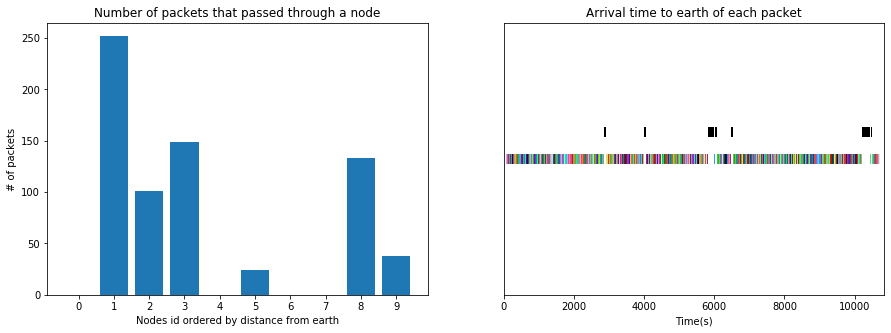

In [7]:
if True:
    _, axs = plt.subplots(1, 2, figsize = (15, 5))
    axs[0].bar(np.arange(n), packet_distribution)
    axs[0].set_title("Number of packets that passed through a node")
    axs[0].set_xlabel("Nodes id ordered by distance from earth")
    axs[0].set_ylabel("# of packets")
    axs[0].set_xticks(np.arange(n))
    pkt_plot(results, ttr, axs[1]) 

1) From the first possible it is possible to immediately notice an intuitive fact that is: 
 the closer a node is to the destination the more packets will pass through it. Since this was the expected behaviour it reassures us about the fact that the greedy algorithm is working properly because each node is trying to bring the packets closer to Earth.
The high number of packets passed through the 8th node is due to packets being redirected back because of links teardown, it is possible to visualize this phenomenon in the animation.

2) The key observation for the second plot is that Earth is almost always receiving packets, this means that the algorithm is very efficient.

### Transmission Time effect on the algorithm

In next section the outcome of the algorithm is tested in case the transmission time greatly changes, this value is related to the dimension of the packet (L) and to the bandwidth of the channel (B), in particular $t_{tr} = \frac{L}{B}$.
This helps us understand how the algorithm answers to low bandwidth networks or when it is necessary to send very big packets.

The following plots show how the arrival time, the throughput and the number of optimal routes changes as the transmission time increases.

In order to reduce the effect of noise we ran the algorithm multiple times with different network configurations and we averaged the outcome. The whole procedure was repeated with two different link deactivation probabilities in order to see how this impacts on the algorithm.

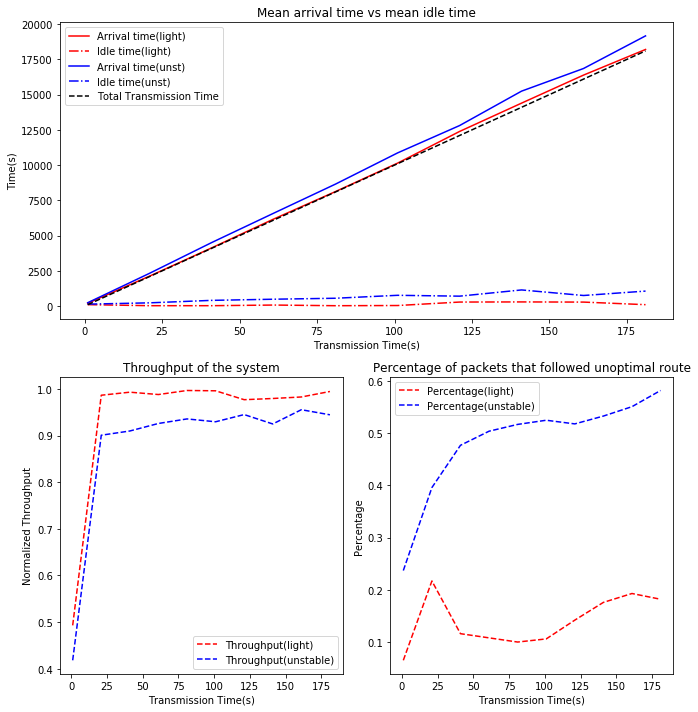

In [8]:
np.random.seed(1000)
fig = plt.figure(figsize=(10, 10))

#generating the axes as wanted
gs = fig.add_gridspec(2, 2)
axs = []
axs.append(fig.add_subplot(gs[0, :]))
axs.append(fig.add_subplot(gs[1, 0]))
axs.append(fig.add_subplot(gs[1, 1]))

#generating some random packets with earth as destination
packets = np.random.randint(1, n, (100, 2))
packets[:,1] = 0

if True:
    #trying out the outcomes with two different link deactivation modes
    for mode in ["light", "unstable"]:
        
        #choosing the color to be used in the plot
        color = ["blue", "red"]
        color = color[mode == "light"]
        
        #defining the transmission times that will be tested
        ttrs = range(1, 200, 20)
        
        #number of different configurations used for testing
        max_rand = 10
        
        #outputs of the routing algorithm for each configuration and ttr
        outputs = np.zeros((len(ttrs), max_rand))
        deviation_arr = np.zeros((len(ttrs), max_rand))

        for rand_iter in tqdm(range(max_rand)):

            #generate a new configuration
            nodes = generate_network(n,r_max)
            A = adjacency_matrix(nodes,tau_max)
            At = disable_links(A,500000, delta_time, mode=mode)

            #for each transmission time
            for ttr_ind in range(len(ttrs)):

                #calculate the route of each packet
                results = greedy_routing(At, packets, ttrs[ttr_ind], delta_time)
                #finding out the arrival times of each packet
                arrival_times = np.array([packet.arrival_times[-1] for packet in results])
                #the overall transmission time is the maximum of the arrival times
                outputs[ttr_ind, rand_iter] = np.max(arrival_times)
                #getting the number of packets that followed a route different from the ideal one
                deviation_arr[ttr_ind, rand_iter] = deviations(A, results)

        #finding the mean over the different configurations of the arrival times
        arrival_times = np.mean(outputs, axis = 1)

        #plotting
        axs[0].plot(ttrs, arrival_times, linestyle="-", c = color)
        axs[0].plot(ttrs, arrival_times - packets.shape[0] * np.array(ttrs), linestyle="-.", c=color)
        axs[1].plot(ttrs, throughput(packets.shape[0], arrival_times)*np.array(ttrs), linestyle="--", c = color)
        axs[2].plot(ttrs, np.mean(deviation_arr, axis = 1), linestyle="--", c = color)

    axs[0].plot(ttrs, packets.shape[0] * np.array(ttrs), linestyle = "--", c="black")
    axs[0].set_ylabel("Time(s)")
    axs[0].set_xlabel("Transmission Time(s)")
    axs[0].set_title("Mean arrival time vs mean idle time")

    axs[0].legend([
        "Arrival time(light)", 
        "Idle time(light)",
        "Arrival time(unst)",
        "Idle time(unst)",
        "Total Transmission Time",
    ])

    axs[1].set_title("Throughput of the system")
    axs[1].set_ylabel("Normalized Throughput")
    axs[1].set_xlabel("Transmission Time(s)")
    axs[1].legend([
        "Throughput(light)",
        "Throughput(unstable)"
    ])

    axs[2].set_title("Percentage of packets that followed unoptimal route")
    axs[2].set_ylabel("Percentage")
    axs[2].set_xlabel("Transmission Time(s)")
    axs[2].legend([
        "Percentage(light)",
        "Percentage(unstable)"
    ])
    plt.tight_layout()

### Some insights on the plots

1) What we get in the first plot is that the idle time remains almost equal to zero even if we increase the transmission time a 
lot. The total transmission time can be expressed as $T_{tot} = t_{tx}n_{packets}$ and is the lower bound for the arrival time $t_a = T_{tot} + t_{idle}$. If we consider the light and unstable mode we can see that the results are very similar, the arrival time though is always higher for the unstable mode as expected; this is because if more links are being shut down it is reasonable to expect a longer arrival time.

2) With the second plot it is possible to see that for small values of the transmission time the normalized throughput is very small, this is due to the fact that the arrival time is dominated by the propagation times.
In other words since $t_{tx}$ is small it means that the earth has a lot of idle time, meaning that the normalized throughput is not too high.
With $t_{tx}>50s$ we can see that the throughput is basically unaffected by the transmission time.
Also in this case as expected the light mode curve is above the unstable mode one.


3) In the third plot we can observe something very intuitive: the bigger the transmission time, the 
higher the percentage of non optimal routes will be; this is due to the fact as $t_{tx}$ increase so does the queueing time, meaning that it is more likely that the path will be changed.
Here instead we can spot a big difference between light and unstable mode, given by the 
fact that with unstable mode we are shutting down many more links than with light mode so the number of unoptimal routes must be higher.

### Propagation time effects
The next plots investigate how the arrival time, throughput and percentage of optimal routes changes as functions of the distance between nodes. The distance between nodes is actually proportional to the propagation time $t_p = \frac{dist}{c}$ where c is the speed of light so the two analisys will yeald the same results.

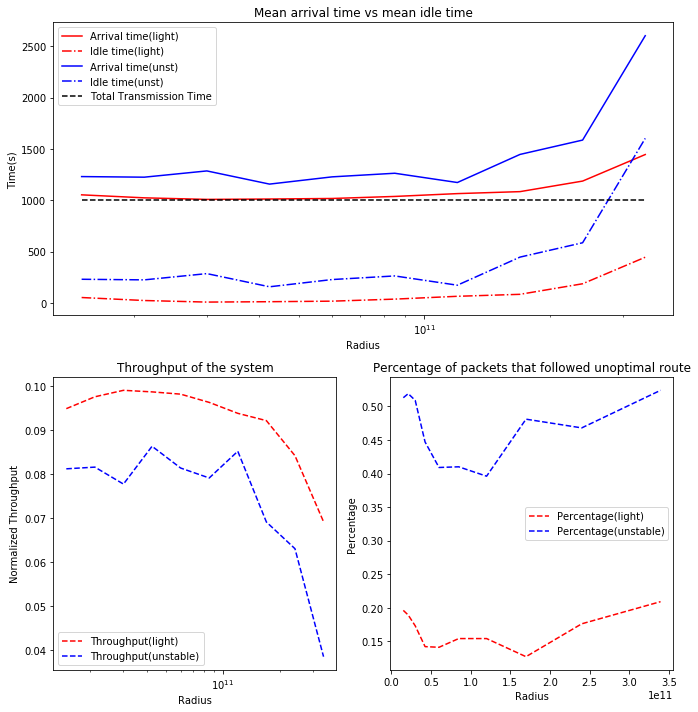

In [9]:
ttr = T_tx
fig = plt.figure(figsize=(10, 10))

#generating the axes as wanted
gs = fig.add_gridspec(2, 2)
axs = []
axs.append(fig.add_subplot(gs[0, :]))
axs.append(fig.add_subplot(gs[1, 0]))
axs.append(fig.add_subplot(gs[1, 1]))


if True:
    #iterating over two different modes
    for mode in ["light", "unstable"]:
    
        color = ["blue", "red"]
        color = color[mode == "light"]
    
        #constants that multiplied by the propagation times simulate the expansion of the configuration
        r_maxes = np.array([2**((i-4)/2) for i in range(10)])
        
        #temporary variables used to store 
        outputs = np.zeros((len(r_maxes), max_rand))
        deviation_arr = np.zeros((len(r_maxes), max_rand))

        #for each different configuration
        for rand_iter in tqdm(range(max_rand)):

            #generating a configuration
            nodes = generate_network(n, r_max)
            A = adjacency_matrix(nodes, tau_max)
            At = disable_links(A,200000, delta_time, mode=mode)

            #for each constant
            for i in range(len(r_maxes)):

                #keeping the same configuration but rescaling the proagation times
                results = greedy_routing(At*r_maxes[i], packets, ttr, delta_time)
                
                #getting the overall transmission time and the number of unoptimal routes
                arrival_times = np.array([packet.arrival_times[-1] for packet in results])
                outputs[i, rand_iter] = np.max(arrival_times)
                deviation_arr[i, rand_iter] = deviations(A*r_maxes[i], results)

        arrival_times = np.mean(outputs, axis = 1)
        axs[0].semilogx(r_maxes * r_max, arrival_times, linestyle="-", c = color)
        axs[0].semilogx(r_maxes * r_max, arrival_times - packets.shape[0] * ttr, linestyle="-.", c = color)
        axs[1].semilogx(r_maxes * r_max, throughput(packets.shape[0], arrival_times), linestyle="--", c = color)
        axs[2].plot(r_maxes * r_max, np.mean(deviation_arr, axis = 1), linestyle="--", c = color)

    axs[0].semilogx(r_maxes * r_max, np.ones(len(r_maxes))*packets.shape[0] * ttr, linestyle="--", c="black")
    axs[0].set_ylabel("Time(s)")
    axs[0].set_xlabel("Radius")
    axs[0].set_title("Mean arrival time vs mean idle time")
    axs[0].legend([
        "Arrival time(light)", 
        "Idle time(light)",
        "Arrival time(unst)",
        "Idle time(unst)",
        "Total Transmission Time"
    ])

    axs[1].set_title("Throughput of the system")
    axs[1].set_ylabel("Normalized Throughput")
    axs[1].set_xlabel("Radius")
    axs[1].legend([
        "Throughput(light)", 
        "Throughput(unstable)",
    ])

    axs[2].set_title("Percentage of packets that followed unoptimal route")
    axs[2].set_ylabel("Percentage")
    axs[2].set_xlabel("Radius")
    axs[2].legend([
        "Percentage(light)",
        "Percentage(unstable)"
    ])
    plt.tight_layout()    



### Some insights on the plots 

1) With the first plot we are visualizing the arrival time, the idle time and the total transmission 
time as a function of the maximum radius under light and unstable mode.
What we see is that:
      
* Either with light and unstable mode the idle time is almost constant up to a certain radius. This
    constant is close to zero for light mode whereas for unstable mode it is about 300 seconds. Then from 
    a certain radius on we see an increse which for light mode is very slow and instead for the unstable 
    mode is very fast but in both case the trend is linear with the propagation time.
    The fact that at the beginning the arrival time is almost constant is due to the fact that the 
    transmission time dominates the transmission while after $t_{tx}$ becomes negligible with respect to
    $t_p$ then the arrival time starts to become proportional with the maximum radius.


2) With the second plot we're pointing out the throughput as a function of the maximum radius;
what we observe is that the behaviour under light and unstable mode is similar but of course light mode gives us a higher throughput. Anyway for both modes the throughput is almost constant (for the unstable mode the constant is centered at 0.08 instead for the light mode it is centered at 0.09) like before when the transmission time becomes negligible with respect to the propagation time the transmission becomes dominated by the latter resulting in a lower normalized throughput.
  

3) In the last image we can observe the percentage of packets that followed unoptimal routes as a function of the maximum
radius. What we get for the two different modes is a similar behaviours and they don't express a clear relation with the maximum radius.

### Effect of the number of packets
Finally with the next plots we want to see how the various metrics change as the number of packets, and thus the network load, increases.

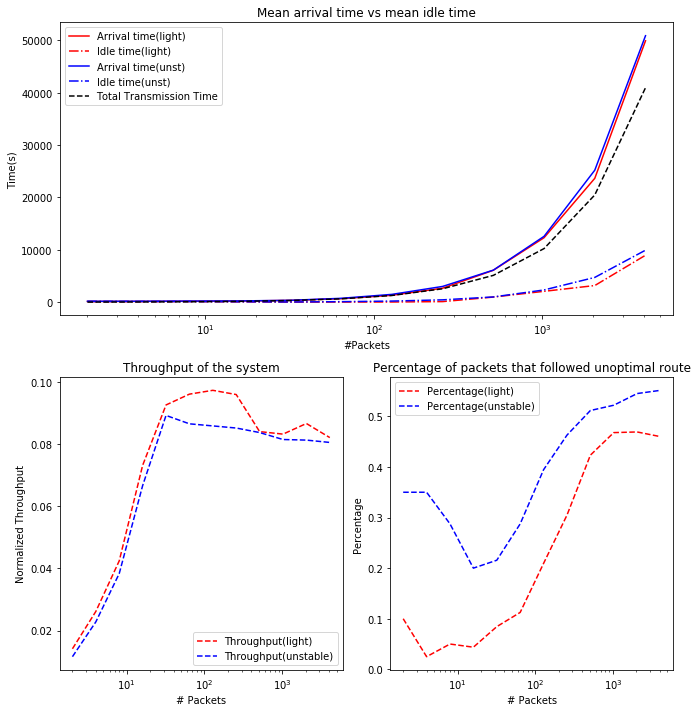

In [10]:
fig = plt.figure(figsize=(10, 10))
#generating the axes as wanted
gs = fig.add_gridspec(2, 2)
axs = []
axs.append(fig.add_subplot(gs[0, :]))
axs.append(fig.add_subplot(gs[1, 0]))
axs.append(fig.add_subplot(gs[1, 1]))
ttr = T_tx
max_rand = 10
if True:
    for mode in ["light", "unstable"]:

        color = ["blue", "red"]
        color = color[mode == "light"]

        #changing the number of packets
        packet_numbers = [2**i for i in range(1,13)]
        
        outputs = np.zeros((len(packet_numbers), max_rand))
        deviation_arr = np.zeros((len(packet_numbers), max_rand))

        for rand_iter in tqdm(range(max_rand)):

            nodes = generate_network(n,r_max)
            A = adjacency_matrix(nodes,tau_max)
            At = disable_links(A,200000, delta_time, mode=mode)
        
            for i in range(len(packet_numbers)):

                #generating new packets every time since their number changes at every iteration
                packets = np.random.randint(1, n, (packet_numbers[i], 2))
                packets[:,1] = 0

                results = greedy_routing(At, packets, ttr, delta_time)
                arrival_times = np.array([packet.arrival_times[-1] for packet in results])
                outputs[i, rand_iter] = np.max(arrival_times)
                deviation_arr[i, rand_iter] = deviations(A, results)

        arrival_times = np.mean(outputs, axis = 1)

        axs[0].semilogx(packet_numbers, arrival_times, linestyle="-", c = color)
        axs[0].semilogx(packet_numbers, arrival_times - np.array(packet_numbers) * ttr, linestyle="-.", c=color)
        axs[1].semilogx(
            packet_numbers, 
            throughput(np.array(packet_numbers), arrival_times), 
            linestyle="--",
            c=color
        )
        axs[2].semilogx(packet_numbers, np.mean(deviation_arr, axis = 1), linestyle="--", c=color)

    axs[0].semilogx(packet_numbers, np.array(packet_numbers) * ttr, linestyle = "--", c="black")
    axs[0].set_ylabel("Time(s)")
    axs[0].set_xlabel("#Packets")
    axs[0].set_title("Mean arrival time vs mean idle time")
    axs[0].legend([
        "Arrival time(light)", 
        "Idle time(light)",
        "Arrival time(unst)",
        "Idle time(unst)",
        "Total Transmission Time"
    ])


    axs[1].set_title("Throughput of the system")
    axs[1].set_ylabel("Normalized Throughput")
    axs[1].set_xlabel("# Packets")
    axs[1].legend([
        "Throughput(light)", 
        "Throughput(unstable)",
    ])

    axs[2].set_title("Percentage of packets that followed unoptimal route")
    axs[2].set_ylabel("Percentage")
    axs[2].set_xlabel("# Packets")
    axs[2].legend([
        "Percentage(light)",
        "Percentage(unstable)"
    ])

    plt.tight_layout()

# An insight on the plots

1) With the first plot we are visualizing the arrival time, the idle time and the total transmission 
time as a function of the maximum radius under light and unstable mode.
We observe a very similar behaviour under light and unstable mode indicating that even if the load of the network is increased the arrival time is not really affected by the number of disabled links.
One interesting thing to notice is that as the number of packets increses so does the idle time, this was expected because increasing the number of packets obviously increases the chance that earth spends some time without receiving data.


2) With the second image we're pointing out the throughput as a function of the number of packets; what we observe is that 
the behaviour under light and unstable mode is similar but of course light mode gives us a higher throughput.
Initially the throughput is low because, with a small amount of packets, the percentage of time in which the earth is idle is very high since it takes time for the first packet to reach it.
  

3) In the last image we can observe the percentage of packets that followed unoptimal routes as a function of the number of packets. What we get for the two different modes is a similar behaviour. 
As the plot shows the more the packets, the higher the percentage of packets that follows
unoptimal routes. Anyway as we could expect the percentage is always higher with unstable mode.
For both modes this value tends to increase because with high load also the queuing time is high, meaning that the chance of a packet following an unoptimal path because of topological changes increases.

# Epidemic Algorithm
A key problem affecting DTNs is the fact that the topology of network changes a lot over time. In some cases, it is not possible to predict these network changes. For example in our case study, some celestial bodies could suddenly pass between the Earth and our satellites causing the link to fail and we cannot know if and when the link will become active again.<br> 
The epidemic algorithm suggests an approach that we can use to solve these types of problems,because it does not require a complete previous knowledge of the network topology. The algorithm works like an epidemic; if it is not possible to send packets to Earth, each node spreads the packets to all nearby nodes. So this procedure creates many copies of the same packet, in fact pure Epidemic routing has usually a high message delivery ratio. We can see below the main phases of the algorithm.<br>

   * 1) If the link is up the packets are sent from the node to the Earth, if the link is down the packets are sent to all nearby nodes that they can reach(the topology of network is locally fully-connected, but it is possible that some links are temporarily interrupted)<br><br>
   
   * 2) This procedure is repeated for all nodes over time, until all the packets have arrived to Earth. But if a node has already sent a copy of the packets to its neighbour, it doesn't need to send it back.<br><br>
   
   * 3) It is possible that the packet is discarded. This happens when: the packet is sent but during the propagation time the link breaks or when the packet arrives but there are some collisions on the receiver because other packets arrive in the same moment.  In both cases this is implemented by checking beforehand if it is possible to send the packet, if it is not then the packet is just not sent which is equivalent to discarding the packet midair. In case of collision one of the colliding packets is kept because by using CDMA (Code Division Multiple Access) it is actually possible to distinguish between the different signals even if there is interference.<br><br>
   
Using Epidemic algorithm, unless a node always remains isolated, we are sure that all packets arrive to Earth. The problem is that many copies of the same packet can create a congestion in the network and an increase of total energy consumption for data transmission.
In this algorithm we assume to know the topology of network, namely if the links are active or not, only in the current moment in which we are. We have no information about the future, so we cannot route efficiently the packets, like it happens in the algorithms above.

Obviously as the number of nodes and of packets increases the load of the network does too and it does exponentially, this means that in case of sensors networks, that contain many nodes, or other extreme cases this might not be the best algorithmic choice.
### Earth occupation
Like we did for the greedy algorithm we would like to find out when the earth is occupied receiving useful data.
Unlike in the greedy case though here we need to take into consideration also duplicate packets as they can not be called useful.

In the following section the earth occupation is represented, in particular colored slots correspond to the reception of a useful packet while black slots correspond to the reception of a duplicate or nothing at all.

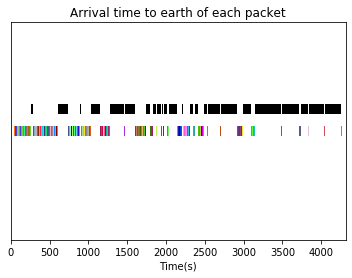

In [11]:
transmission_time = T_tx
slot_time = delta_time

#generating new packets with earth as a destination
packets = np.random.randint(1, n, (250, 2))
packets[:, 1] = 0

#generating the new configuration
At = disable_links(A, 100000, slot_time, mode="unstable")

#performing the routing algorithm
packet_arrive, packet_time, vulnerable, anim_packets = epidemic(
    At,
    transmission_time,
    slot_time,
    packets,
    return_anim=True
)

#filtering packets that arrived to earth and removing duplicates
packets_to_earth = remove_duplicates(list(filter(lambda x: x.route[0] == 0, anim_packets)))

pkt_plot(packets_to_earth, transmission_time)

### Some insights on the plot

It is immediately possible to notice that, in contrast with the greedy algorithm, the idle time is dominant in the representation meaning that the algorithm is taking a lot more time to send all the packets that are needed.
A thing that can be noticed straight away is that most of the idle time is concentrated in final part of the transmission because a lot more duplicates are present in the network at that time.

Just this graph shows that the greedy algrithm is probabily more robust to extreme situations and probably performs better in all cases. This is obviously mainly due to the knowledge advantage that it has if compared with the epidemic algorithm.


## Metrics analysis
Also in this case different metrics values are displayed in order to try and understand how the algorithm behaves in different situations. All the computations were repeated for 10 different configurations and the results averaged out in order to reduce the noise and the algorithm was tested both with light and unstable mode.

### Effects of the number of packets
In the next section the dependence of the arrival time, throughput and packet fraction from the number of packets is investigated.
The packet praction is a quantity that we defines that represents the ratio between the number of useful packets received by earth and the total number of packets received.

This is an important metric for this algorithm because it approimately shows how much useless information reaches Earth.

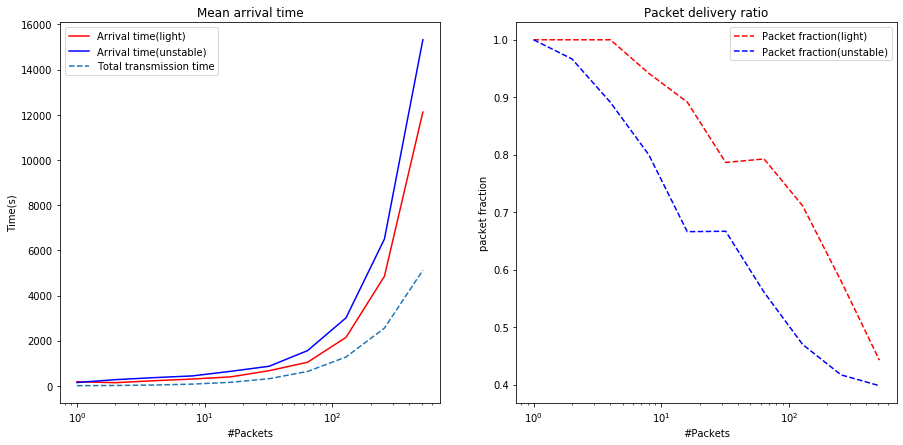

In [12]:
#generate figure
fig = plt.figure(figsize=(15, 7))
    
gs = fig.add_gridspec(1, 2)
axs = []
axs.append(fig.add_subplot(gs[0, 0]))
axs.append(fig.add_subplot(gs[0, 1]))

#seeing how the system behaves as number of packets increases
max_rand = 10

if True:
    #plots and analysis with 10 nodes and r_max
    for mode in ["light", "unstable"]:

        color = ["blue", "red"]
        color = color[mode == "light"]
        
        #number packet that we want to send to earth
        packet_numbers = [2**i for i in range(10)]
        
        #temp variables used to store data that will be used for the plots
        arrival_times = np.zeros((len(packet_numbers), max_rand))
        packet_fraction = np.zeros((len(packet_numbers), max_rand))

        for sample in tqdm(range(max_rand)):

            #generating a new network configuration
            nodes = generate_network(n, r_max)
            A = adjacency_matrix(nodes, tau_max)
            At = disable_links(A, 100000, slot_time, mode = mode)

            for i in range(len(packet_numbers)):

                #generating new packets with earth as a destination
                packets = np.random.randint(1, n, (packet_numbers[i], 2))
                packets[:, 1] = 0
                
                #performing the routing algorithm
                packet_arrive, _, vulnerable = epidemic(At, transmission_time, slot_time, packets)
                arrival_times[i, sample] = vulnerable[0] + transmission_time
                packet_fraction[i, sample] = len(set(packet_arrive))/len(packet_arrive)

        axs[0].semilogx(packet_numbers, np.mean(arrival_times, axis = 1), c = color)
        axs[1].semilogx(packet_numbers, np.mean(packet_fraction, axis = 1), c = color, linestyle="--")

    axs[0].semilogx(packet_numbers, np.array(packet_numbers)*transmission_time, linestyle="--")
    axs[0].set_ylabel("Time(s)")
    axs[0].set_xlabel("#Packets")
    axs[0].set_title("Mean arrival time")
    axs[0].legend([
        "Arrival time(light)",
        "Arrival time(unstable)",
        "Total transmission time"
    ])

    axs[1].set_ylabel("packet fraction")
    axs[1].set_xlabel("#Packets")
    axs[1].set_title("Packet delivery ratio")
    axs[1].legend([
        "Packet fraction(light)",
        "Packet fraction(unstable)"
    ])

1) We can see that the mean arrival time in both cases increases linearly (the x axis is in logarithmical scale) with the number of packets. Normally one would expect to see an exponential trend, what is probably preventing this to happen is the fact that if a node knows that it can send the packet directly to earth it doesn't send copies around. Even if the number of disabled links is higher than in the unstable case we do not see the exponential trend because the number of nodes that effectively receive the packet is lower since most connections are disabled.
It is possible to see that with a bigger number of nodes the arrival time becomes exponential, the analysis was not presented in this notebook because it takes more than one hour just to run one simulation.
This though shows that this algorithm can actually be used if the number of nodes in the network is contained.
As expected the light mode curve is below the unstable one.

2)From the second plot we can see that the packet fraction value decreses as the number of packets increases. This was obvious because more packets means more copies in the network meaning more congestion and thus more useless packets reaching earth.

### Effects of the transmission time
The following cell wants to show the dependence of the various metrics from the transmission time, since the outcome of these measurements were very noisy the number of configurations used was increased to 30.

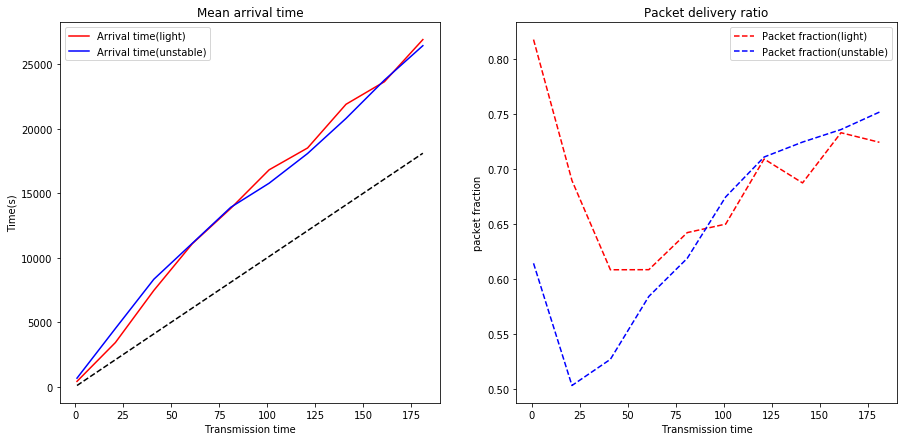

In [13]:
#generate figure
fig = plt.figure(figsize=(15, 7))
   
gs = fig.add_gridspec(1, 2)
axs = []
axs.append(fig.add_subplot(gs[0, 0]))
axs.append(fig.add_subplot(gs[0, 1]))

#seeing how the system behaves as the transmission time increases
max_rand = 30
packet_numbers = 100

if True:
    for mode in ["light", "unstable"]:

        color = ["blue", "red"]
        color = color[mode == "light"]

        transm_time = np.arange(1, 200, 20)
        arrival_times = np.zeros((len(transm_time), max_rand))
        packet_fraction = np.zeros((len(transm_time), max_rand))

        for sample in tqdm(range(max_rand)):

            nodes = generate_network(n, r_max)
            A = adjacency_matrix(nodes, tau_max)
            At = disable_links(A, 100000, slot_time, mode = mode)

            for i in range(len(transm_time)):

                packets = np.random.randint(1, n, (packet_numbers, 2))
                packet_arrive, _, vulnerable = epidemic(At, transm_time[i], slot_time, packets)
                arrival_times[i, sample] = vulnerable[0] + transm_time[i]
                packet_fraction[i, sample] = len(set(packet_arrive))/len(packet_arrive)

        axs[0].plot(transm_time, np.mean(arrival_times, axis = 1), c = color)
        axs[0].set_ylabel("Time(s)")
        axs[0].set_xlabel("Transmission time")
        axs[0].set_title("Mean arrival time")
        axs[0].legend([
        "Arrival time(light)",
        "Arrival time(unstable)",
        ])

        axs[1].plot(transm_time, np.mean(packet_fraction, axis = 1), c = color, linestyle = "--")
        axs[1].set_ylabel("packet fraction")
        axs[1].set_xlabel("Transmission time")
        axs[1].set_title("Packet delivery ratio")
        axs[1].legend([
        "Packet fraction(light)",
        "Packet fraction(unstable)"
        ])

    axs[0].plot(transm_time, np.array(transm_time*packet_numbers), c="black", linestyle="--")

From the plots it is possible to notice some very awkward behaviours, in particular it looks like that when the transmission times become comparable with the propagation times the number of deactivated links becomes ininfluent.
This can be seen in both plots as from a certain point the two lines tend to overlap which is an unexpected behaviour.
The second plot looks strange because the packet fraction increases after a certain point, this is probably due to the fact that with very high transmission rate it is very likely that a link is deactivated before the packet reaches its destination meaning that not too many packets are forwarded epidemically reducing the number of useless packets that reach earth.

## Algorithm comparison
From the Earth occupation plots it is already clear that the the greedy algorithm is more performing. The opposite would have been quite strange since it relies on more information than the epidemic one.

It is still important to compare the two performances in case the same conditions are used for both, on the plots below the arrival times are confronted. Only the unstable mode was used and the performances were compared firstly as functions of the transmission times and later as functions of the number of packets.

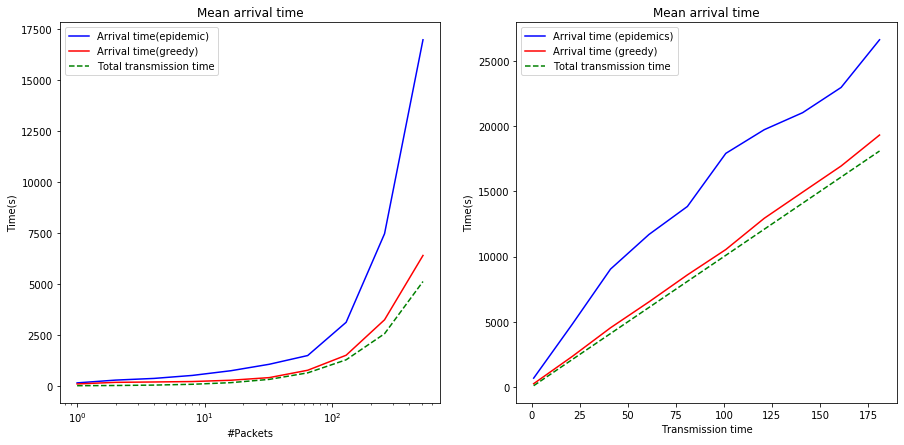

In [14]:
#generate figure
fig = plt.figure(figsize=(15, 7))
    
gs = fig.add_gridspec(1, 2)
axs = []
axs.append(fig.add_subplot(gs[0]))
axs.append(fig.add_subplot(gs[1]))
max_rand = 10

if True:
    
    #different transmission times
    transm_time = np.arange(1, 200, 20)
    
    #number packet that we want to send to earth
    packet_numbers = [2**i for i in range(10)]
    
    #temp variables needed for plots
    arrival_times = np.zeros((len(packet_numbers), max_rand))
    outputs = np.zeros((len(packet_numbers), max_rand))
    outputs_ttr = np.zeros((len(packet_numbers), max_rand))
    arrival_times_ttr = np.zeros((len(packet_numbers), max_rand))
        
    for sample in tqdm(range(max_rand)):

        #generating a new configuration
        nodes = generate_network(n, r_max)
        A = adjacency_matrix(nodes, tau_max)
        At = disable_links(A, 100000, slot_time, mode = "unstable")
        
        #getting the arrival times as the number of packets changes
        for i in range(len(packet_numbers)):
    
            packets = np.random.randint(1, n, (packet_numbers[i], 2))
            packets[:, 1] = 0
            
            #greedy routing results
            results = greedy_routing(At, packets, transmission_time, delta_time)
            
            #epidemic routing results
            packet_arrive, _, vulnerable = epidemic(At, transmission_time, slot_time, packets)
            
            arrival_times_greedy = np.array([packet.arrival_times[-1] for packet in results])
            outputs[i, sample] = np.max(arrival_times_greedy)
            arrival_times[i, sample] = vulnerable[0] + transmission_time

        #getting the arrival times as the transmission time changes
        for i in range(len(transm_time)):
            
            packets = np.random.randint(1, n, (100, 2))
            packets[:, 1] = 0
            
            #greedy routing results
            results = greedy_routing(At, packets, transm_time[i], delta_time)
            
            #epidemic routing results
            packet_arrive, _, vulnerable = epidemic(At, transm_time[i], slot_time, packets)
            
            arrival_times_greedy = np.array([packet.arrival_times[-1] for packet in results])
            outputs_ttr[i, sample] = np.max(arrival_times_greedy)
            arrival_times_ttr[i, sample] = vulnerable[0] + transm_time[i]
            
    arrival_times_greedy = np.mean(outputs, axis = 1)
    axs[0].semilogx(packet_numbers, np.mean(arrival_times, axis = 1), c= "blue")
    axs[0].semilogx(packet_numbers, arrival_times_greedy, c="red")

    axs[0].semilogx(packet_numbers, np.array(packet_numbers)*transmission_time, linestyle="--", color="green")
    axs[0].set_ylabel("Time(s)")
    axs[0].set_xlabel("#Packets")
    axs[0].set_title("Mean arrival time")
    axs[0].legend([
        "Arrival time(epidemic)",
        "Arrival time(greedy)",
        "Total transmission time"
    ])

    arrival_times_greedy = np.mean(outputs_ttr, axis = 1)
    axs[1].plot(transm_time, np.mean(arrival_times_ttr, axis = 1), color = "blue")
    axs[1].plot(transm_time, arrival_times_greedy, color = "red")
    axs[1].plot(transm_time, np.array(transm_time)*100,color="green" ,linestyle="--")
    axs[1].set_ylabel("Time(s)")
    axs[1].set_xlabel("Transmission time")
    axs[1].set_title("Mean arrival time")
    axs[1].legend([
        "Arrival time (epidemics)",
        "Arrival time (greedy)",
        "Total transmission time"
    ])


As we can observe the arrival time with the epidemic approach increases much faster than with the greedy one in both cases. This confirms our expectations, because since the beginning we knew that the greedy algorithm was the one with the strictest hypothesis but also the most efficient. 

In particular, as expected the epidemic algorithm performs really poorly in case many packets need to be forwarded because more packets generate a lot of duplicates this does not happen for the greedy algorithm so even if some packets might follow a better path (in the epidemic case), the extra load generated by the network is too much for the algorithm to compete with the greedy one.

# Conclusions

Here we want to sum up the results of our efforts by recapping which were the initial objectives and how the two 
different approaches tackled the problem. 

So our goal was to find an effective routing algorithm in the scenario of Delay Tolerant Networks, where nodes are 
located very far from each other and the links are not always working. 

The first strategy which we studied and implemented is a greedy algorithm which turned out to be very efficient and 
probably the best type of approach when dealing with DTNs.
We can say that this algorithm is very efficient because Earth (which is the destination node) is always busy in the
sense that there are almost no idle times for the destination node which is always receiving packets.


The two main resons why we also tested the epidemic algorithm were

1) It needs much less information about the system to work properly.

2) We thought that because packets are sent everywhere some packets would arrive to earth faster than they would with the greedy algorithm, this because the greedy algorithm does not keep queues in consideration when computing the best path meaning that some packets may be forced to take strange routes.
Unfortunately the amount of duplicate packets was more than enough to overcome this effect making the epidemic algorithm actually way worse.

In [1] the authors actually express very clearly the fact that in many cases the epidemic algorithm becomes unfeasible because it fills up the buffers and it generates too many packets.
From the simulations though we saw that for small networks where the topology can not be known in advance, this approach might actually work decently well as it takes all the packets to destination.

In [15]:
if False:    #for testing purposes, to be removed
    ## ANIMATION 1

    #enable first line to make the animation work
    #WARNING: all other figures will be affected until you restart the kernel

    #%matplotlib notebook 

    coord = generate_network(n,r_max, seed = 1)
    polar = generate_network(n,r_max,polar=True, seed = 1)
    print()

    def update_graph(num):

        theta = polar[:,1]
        phi = polar[:,2]

        old_r = np.linalg.norm(coord,axis=1)

        coord[:,0] += - c*np.cos(theta)*np.sin(phi)
        coord[:,1] += - c*np.sin(theta)*np.sin(phi)
        coord[:,2] += - c*np.cos(phi)

        new_r = np.linalg.norm(coord,axis=1)

        not_done = new_r < old_r  #this happens after a packet reach Earth

        #coord = coord * not_done.reshape((n,-1))  #sets coordinates of a pkt to 0 if it already reached Earth

        for i in range(n):    # ISSUE: previous line doesn't work, this "for" cycle is a substitute
            if not not_done[i]:
                coord[i,0] = coord[i,1] = coord[i,2] = 0

        graph._offsets3d = (coord[:,0],coord[:,1],coord[:,2])
        title.set_text("time={}".format(num))


    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    title = ax.set_title('Pkts')

    graph = ax.scatter(coord[:,0],coord[:,1],coord[:,2])
    ax.scatter(0,0,0,color="red",s=60)   #Earth

    ani = animation.FuncAnimation(fig, update_graph, 
                                   interval=50, blit=False)

    plt.show()

<IPython.core.display.Javascript object>


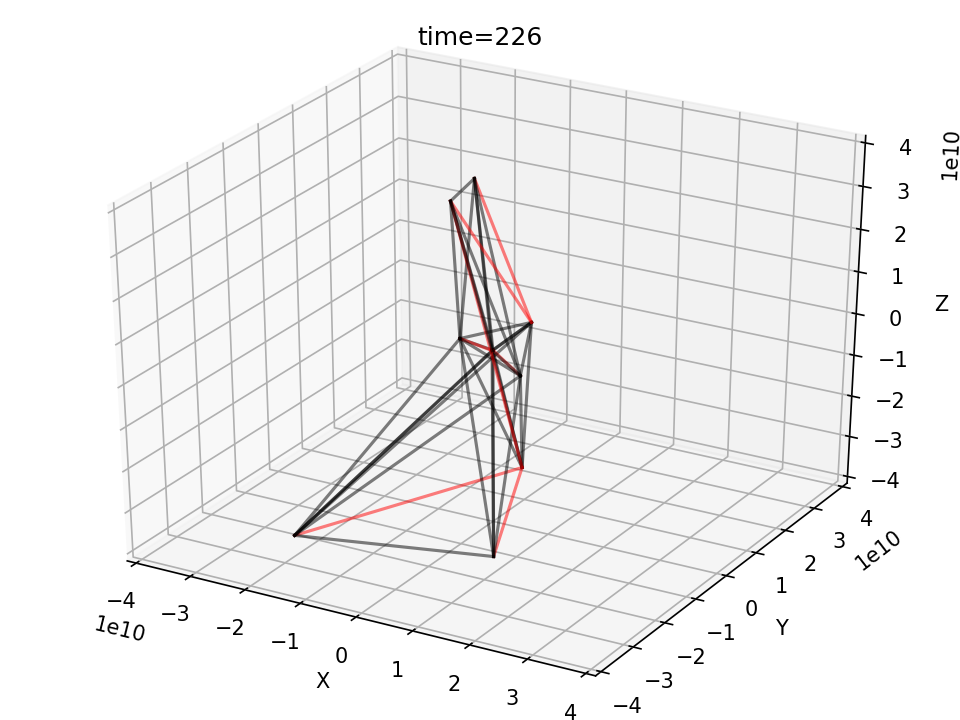

In [16]:
## ANIMATION 2

#enable first line to make the animation work
#WARNING: all other figures will be affected until you restart the kernel

%matplotlib notebook 

nodes = generate_network(n,r_max, seed = 100)

#returns a list of active links
def get_links(A):
    n = A.shape[0]
    return [np.array([nodes[i],nodes[j]]).T for i in range(n) for j in range(i+1) if A[i,j]!=np.inf]

#checks if a link is active 
def check_active(link, link_list):
    for x in link_list:
        if np.array_equal(x, link):
            return True
    return False

A = adjacency_matrix(nodes, tau_max)
At = disable_links(A,5000,1,mode="unstable")  #test

n_updates = At.shape[2]
links = get_links(A)
active_links = [get_links(At[:,:,t]) for t in range(n_updates)]

def update_lines(num, dataLines, lines) :

    title.set_text("time={}".format(num))
    
    for line, data in zip(lines, dataLines) :
        # NOTE: there is no .set_data() for 3 dim data...
        line.set_data(data[0:2, :])
        line.set_3d_properties(data[2, :])
        line.set_color("black")
        if not check_active(data, active_links[num]):
              line.set_color("red")
    return lines

# Attaching 3D axis to the figure
fig = plt.figure()
ax = p3.Axes3D(fig)

data = links
lines = [ax.plot(dat[0, :], dat[1, :], dat[2, :],alpha=0.5)[0] for dat in links]

if True:   #autoscale off
    # Setting the axes properties
    ax.set_xlim3d([-4e10, 4e10])
    ax.set_xlabel('X')

    ax.set_ylim3d([-4e10, 4e10])
    ax.set_ylabel('Y')

    ax.set_zlim3d([-4e10,4e10])
    ax.set_zlabel('Z')

title = ax.set_title('Links')

# Creating the Animation object
line_ani = animation.FuncAnimation(fig, update_lines, n_updates, fargs=(data, lines),
                              interval=10, blit=False)

plt.show()

In [17]:
def get_vel(node1, node2):
    diff = node2 - node1
    dist = np.linalg.norm(diff)
    time = dist/c
    vel = diff/time
    return vel

packets = packets_greedy
A = initial_A
coord_nodes = np.copy(initial_nodes)

n_pkt = len(packets)
coord = coord_nodes[[pkt.source for pkt in packets]]
path = [[pkt.source] + pkt.route for pkt in packets]
arrival_times = [pkt.arrival_times for pkt in packets]
start_times = [[pkt.arrival_times[j] - A[path[i][j],path[i][j+1]] for j in range(len(pkt.route))] for i,pkt in enumerate(packets)]

delay = max([pkt.arrival_time for pkt in packets])

next_hop = coord_nodes[[x.route[0] for x in packets]]
diff = next_hop - coord
dist = np.linalg.norm(diff,axis=1)
times = dist/c
vel = (diff.T / times).T

fixed_coord = np.copy(coord)  #keep a fixed copy to be able to run the animation multiple times
fixed_vel = np.copy(vel)

<IPython.core.display.Javascript object>


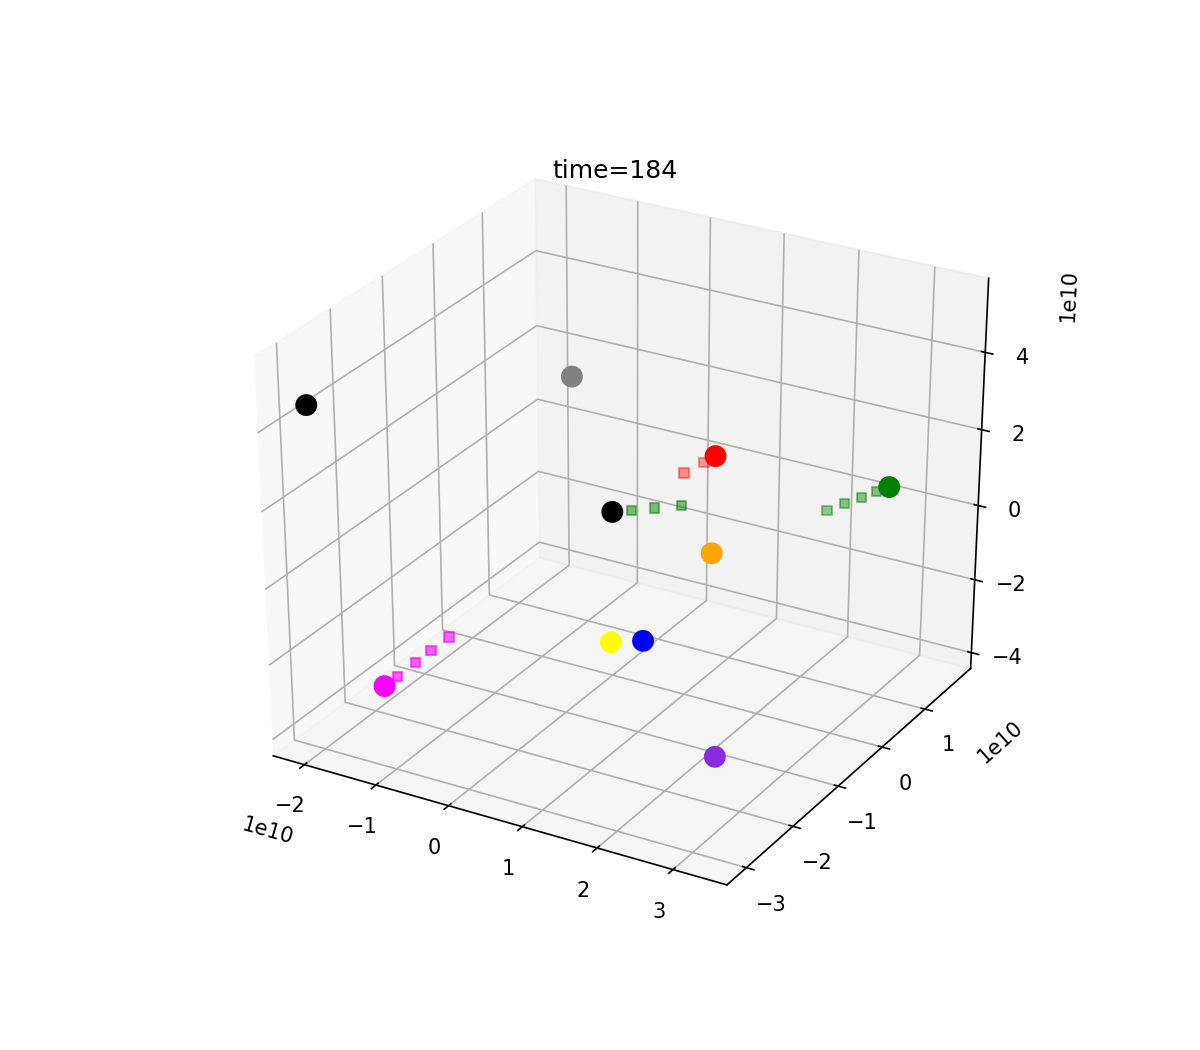

In [18]:
## ANIMATION 4: SIMPLE VERSION

#enable first line to make the animation work
#WARNING: all other figures will be affected until you restart the kernel

%matplotlib notebook 

coord = np.copy(fixed_coord)##
vel = np.copy(fixed_vel)

step = np.zeros(n_pkt, dtype=int) #current step

done = [False for x in packets]
def update_graph(num,coord,start_times,arrival_times,step,n_pkt,vel,done):
    
    speed = 1.5   #animation speed
    time = num * speed
    
    for i in range(n_pkt):
        if done[i]:
            continue
  
        start = start_times[i][step[i]]
        end = arrival_times[i][step[i]]
        
        if time < start:
            status = "waiting"
        elif start <= time <= end:
            status = "midair"
        elif time > end:
            status = "arrived"
        if status == "midair":
            coord[i,:] = coord[i,:] + vel[i,:] * speed
            
        elif status == "waiting":
            pass
        elif status == "arrived":
            try:
                step[i] += 1
                vel[i,:] = get_vel(coord_nodes[path[i][step[i]],:], coord_nodes[path[i][step[i]+1],:])
                start = start_times[i][step[i]]
                end = arrival_times[i][step[i]]
            except IndexError:
                done[i] = True

    
    graph._offsets3d = (coord[:,0],coord[:,1],coord[:,2])
    title.set_text("time={}".format(num))


fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('Pkts')

cnodes = ["black","red","orange","yellow","green","blue","magenta","blueviolet","grey","black"]

pkt_color = [cnodes[pkt.source] for pkt in packets]
graph = ax.scatter(coord[:,0],coord[:,1],coord[:,2],s=20,color=pkt_color,marker="s")

ax.scatter(coord_nodes[:,0],coord_nodes[:,1],coord_nodes[:,2],s=90,color=cnodes,alpha=1)
ax.scatter(0,0,0,color="red",s=60)   #Earth

ani4 = animation.FuncAnimation(fig, update_graph, interval=5, blit=False,
                              fargs=(coord,start_times,arrival_times,step,n_pkt,vel,done))

plt.show()

# Bibliography

[1] Jain, Sushant, Kevin Fall, and Rabin Patra. "Routing in a delay tolerant network." Proceedings of the 2004 conference on Applications, technologies, architectures, and protocols for computer communications. 2004.<br>
[2] Evan P.C. Jone, Paul A.S. War. "Routing Strategies for Delay-Tolerant Networks."